# OBJETIVOS



# Inicio

## Pacotes

In [1]:
import math
import pandas as pd
pd.set_option('display.max_colwidth', 255)
import numpy as np
import os

import matplotlib.pyplot as plt
plt.rcParams.update({
    #"axes.unicode_minus" : False,
    "font.family": "serif",  # use serif/main font for text elements
    "font.serif" : "Computer Modern Roman",
    "font.sans-serif" : "Computer Modern Sans serif",
    "font.monospace"  : "Computer Modern Typewriter",
    "text.usetex": True,     # use inline math for ticks
    "pgf.rcfonts": False,    # don't setup fonts from rc parameters   
    #"figure.figsize": [18,7],
    "axes.titlesize": "xx-large",   # fontsize of the axes title
    "axes.labelsize": "xx-large",  # fontsize of the x any y labels
    "xtick.labelsize": "xx-large",  # font size of the tick labels
    "ytick.labelsize": "xx-large",  # font size of the tick labels
    "legend.fontsize":   "large",
    #"pgf.preamble": "\n".join([
         #r"\usepackage{url}",            # load additional packages
         #r"\usepackage{unicode-math}",   # unicode math setup
         #r"\setmainfont{DejaVu Serif}",  # serif font via preamble

    #])
})


import seaborn as sns
from scipy import stats
from scipy.signal import find_peaks
import scipy.stats
import random

with open('res_sub_tab.txt', 'w') as res_sub_tab:
    res_sub_tab.write('Tabelas Latex para os resultados dos métodos subjetivos')
    res_sub_tab.write('\n')
    res_sub_tab.close()

#Cores
ccmLBlue = (0.170/0.255,0.200/0.255,0.230/0.255)
ccmBlue = (0.020/0.255,0.080/0.255,0.200/0.255)
ccmDBlue = (0.025/0.255,0.050/0.255,0.120/0.255)
ccmRed = (0.190/0.255,0.0,0.0)
ccmOrange = (0.255/0.255,0.100/0.255,0.0)
ccmLGray = (0.210/0.255,0.210/0.255,0.210/0.255)
ccmDGray = (0.085/0.255,0.085/0.255,0.085/0.255)

cor1 = ccmRed
cor2 = ccmDBlue
cor3 = ccmLGray
cor4 = ccmOrange
cor5 = ccmLBlue
cor6 = ccmDGray
cor7 = ccmBlue

# Create an array with the colors you want to use
paletaCores = [cor1,cor2,cor3,cor4,cor5,cor6,cor7]
# Set your custom color palette
sns.set_palette(sns.color_palette(paletaCores))
plt.rcParams.update({'font.size': 22})

csvPreparado = False

plotarSinal = True


## Funções

### Segundos para minutos

In [2]:
def ToMinute(time):

    m = '{timeM}:{timeS:02d}'.format(timeM = int(time/60), timeS = int(time%60))

    return m

#print('Se a diferença entre alguma média for superior a {dun:.2f} então a hipótese alternativa pode ser valida para essa determinada comparação'.format(dun = dun))

### Slice de um dicionario

In [3]:
# ----------------------------------------------------------------------------------------------------------------------------
# Essa função faz o slice de um dicionario
# ----------------------------------------------------------------------------------------------------------------------------

def slice_dic(entrada,inicio,fim):
    # Checar se as entradas e saídas existem
    keys_set = set(entrada.keys())
    bol_inicio = inicio in keys_set
    bol_fim = fim in keys_set
    while bol_fim == False:
        fim = fim - 1
        bol_fim = fim in keys_set

    saida = {}
    keys = range(inicio,fim)
    for key in keys:
        saida[key] = entrada[key]
    return saida

### Filtro ECG

In [4]:
def filtro_ecg(listaECG, N, Fs, Wn):

    time = listaECG.iloc[:,0]
    sig = listaECG.iloc[:,1]
    sos = signal.butter(N, Wn, btype='band', analog=False, output='sos', fs=Fs)
    filtered = signal.sosfilt(sos, sig)
    sp = np.fft.fft(sig)

    n_graficos = 2
    plt.figure(figsize=[20,10 * n_graficos])
    plt.subplot(2,1,1)
    plt.plot(time,sig)
    plt.title('Sinal Original')
    plt.subplot(2,1,2)
    plt.plot(time,filtered)
    #plt.ylim([-500,500])
    plt.title('Sinal filtrado')

### Intervalo entre picos ECG

In [5]:
# ----------------------------------------------------------------------------------------------------------------------------
# Essa função calcula o intervalo de tempo entre picos
# ----------------------------------------------------------------------------------------------------------------------------

def funcao_dif_pico(pico_rr_t):
    nni = []
    i = 0
    while i < (len(pico_rr_t) - 1):
        nni.append(pico_rr_t[i+1] - pico_rr_t[i])
        i = i + 1
    return nni

### Variação Sensores

#### Variação Baseline

In [6]:
def variacaoSensores (dados):

    df = pd.DataFrame([],columns = nomeCenasSensores,index = indexDef)

    dados_var_cen_par = []

    for p in range(len(participantes)):
        dadosPorCena_var_cen_par = []
        for c in range(len(cenas) + 1):
            if c == 0:
                baseline = dados[p][0][0]
                df.iloc[p*2,c] = baseline
                df.iloc[p*2+1,c] = np.nan
            else:
                dadosPorEtapa_var_cen_par = []
                for e in range(len(etapas)):
                    #print(ecgDados[p][c][:])
                    #print(np.mean(ecgDados[p][c][:]))
                    valorDados = dados[p][c][e]
                    df.iloc[p*2+e,c] = valorDados
                    dadosPorEtapa_var_cen_par.append((valorDados-baseline)/baseline*100)
                dadosPorCena_var_cen_par.append(dadosPorEtapa_var_cen_par)
        dados_var_cen_par.append(dadosPorCena_var_cen_par)

    df_var = pd.DataFrame([], columns=nomeCenas, index = indexDef)
    for p in range(len(participantes)):
        for e in range(len(etapas)):
            for c in range(len(cenas)):
                df_var.loc[(df_var.index[p*2][0]),df_var.columns[c]] = dados_var_cen_par[p][c]
    df.set_index(indexDef, inplace = True)
    return df.astype(float), df_var

#### Variação entre etapas

In [7]:
def variacaoSensoresEtapas (dados):

    df = pd.DataFrame([],columns = nomeCenasSensores,index = indexDef)

    dados_var_cen_par = []

    for p in range(len(participantes)):
        dadosPorCena_var_cen_par = []
        for c in range(len(cenas) + 1):
            if c == 0:
                baseline = dados[p][0][0]
                df.iloc[p*2,c] = baseline
                df.iloc[p*2+1,c] = np.nan
            else:
                valorPrimeira = dados[p][c][0]
                valorRetorno = dados[p][c][1]
                df.iloc[p*2,c] = valorPrimeira
                df.iloc[p*2+1,c] = valorRetorno
                dadosPorCena_var_cen_par.append((valorRetorno-valorPrimeira)/valorPrimeira*100)
        dados_var_cen_par.append(dadosPorCena_var_cen_par)

    df_var = pd.DataFrame(dados_var_cen_par, columns=nomeCenas, index = participantes.index)
    df.set_index(indexDef, inplace = True)
    df_var = pd.concat([df_var,participantes.loc[:,'Deficiência visual']],axis = 1)
    df_var.rename(columns = {'Deficiência visual' : 'Visual Condition'}, inplace=True) 
    df_var.index.names = ['Participant']

    return df.astype(float), df_var


### Variação Sensores geral

In [8]:
def variacaoSensoresGeral(dados):

    aux = dados.reset_index(level = 1)#.groupby(by = 'Visual Condition').mean()
    for c in range(len(aux.columns)):
        if c != 0:
            aux = aux.astype({aux.columns[c]:'float'})
        else:
            aux = aux.astype({aux.columns[c]:'category'})
    aux.dtypes

    df = aux.groupby(by = 'Visual Condition').mean()
    return df

### Tabela Latex

In [9]:
def TabelaLatex(df,label,caption,teste, colformat, floatBarrier = False, escape = True):
    if colformat == "":
        colformat = 'l'*(len(df.columns) + len(df.index.names))
    tabela = pd.DataFrame.to_latex(df, label = label, caption = caption, position = '!htb', float_format="{:0.3f}".format, escape = escape, column_format = colformat)
    print(tabela)
    caminho = teste + '/Tabelas/' + label[4:] + '.tex'

    with open(caminho, 'w') as res_sub_tab:
        #res_sub_tab.write('\n' +'\n' + caption + '\n')
        res_sub_tab.write('\n' + tabela + '\n')
        if floatBarrier == True:
            res_sub_tab.write('\n \FloatBarrier \n')

def TabelaLatexSemIndex(df,label,caption,teste,colformat,floatBarrier = False, escape = True):
    if colformat == "":
        colformat = 'l'*(len(df.columns) + len(df.index.names))
    tabela = pd.DataFrame.to_latex(df, label = label, caption = caption, position = '!htb', float_format="{:0.3f}".format, escape = escape, index = False, column_format = colformat) 
    print(tabela)
    caminho = teste + '/Tabelas/' + label[4:] + '.tex'

    with open(caminho, 'w') as res_sub_tab:
        #res_sub_tab.write('\n' +'\n' + caption + '\n')
        res_sub_tab.write('\n' + tabela + '\n')
        if floatBarrier == True:
            res_sub_tab.write('\n \FloatBarrier \n')

### Tabela Latex (sem \begin{table})

In [10]:
def TabelaLatexSemBegin(df,label,caption,teste, colformat, floatBarrier = False, escape = True):
    if colformat == "":
        colformat = 'l'*(len(df.columns) + len(df.index.names))
    tabela = pd.DataFrame.to_latex(df, label = label, caption = caption, position = '!htb', float_format="{:0.3f}".format, escape = escape, column_format = colformat)[20:-13]
    print(tabela)
    caminho = teste + '/Tabelas/' + label[4:] + 'SemBegin.tex'

    with open(caminho, 'w') as res_sub_tab:
        #res_sub_tab.write('\n' +'\n' + caption + '\n')
        res_sub_tab.write('\n' + tabela + '\n')
        if floatBarrier == True:
            res_sub_tab.write('\n \FloatBarrier \n')

def TabelaLatexSemIndexSemBegin(df,label,caption,teste,colformat,floatBarrier = False, escape = True):
    if colformat == "":
        colformat = 'l'*(len(df.columns) + len(df.index.names))
    tabela = pd.DataFrame.to_latex(df, label = label, caption = caption, position = '!htb', float_format="{:0.3f}".format, escape = escape, index = False, column_format = colformat)[20:-13]
    print(tabela)
    caminho = teste + '/Tabelas/' + label[4:] + 'SemBegin.tex'

    with open(caminho, 'w') as res_sub_tab:
        #res_sub_tab.write('\n' +'\n' + caption + '\n')
        res_sub_tab.write('\n' + tabela + '\n')
        if floatBarrier == True:
            res_sub_tab.write('\n \FloatBarrier \n')

### Teste Shapiro

In [11]:
def TesteShapiro(dados):

    aux = dados.reset_index(level = 1)
    blind = aux.reset_index(level = 1)[aux.reset_index(level = 1)['Visual Condition'] == 'Blind']
    sight = aux.reset_index(level = 1)[aux.reset_index(level = 1)['Visual Condition'] == 'Sight']

    mdShapiro = []
    for m in nomeCenas:
        #print('Shapiro ' + s)
        _, pBlind = stats.shapiro(blind[m])
        _, pSight = stats.shapiro(sight[m])
        #print(p)
        dict = [m + ' blind', pBlind]
        mdShapiro.append(dict)
        dict = [m + ' sight', pSight]
        mdShapiro.append(dict)
    mdShapiro = pd.DataFrame(mdShapiro,columns = ['Method', 'Shapiro P-Value'])
    return mdShapiro    

### Teste T

In [12]:
def TesteT(dados):

    aux = dados.reset_index(level = 1)
    blind = aux.reset_index(level = 1)[aux.reset_index(level = 1)['Visual Condition'] == 'Blind']
    sight = aux.reset_index(level = 1)[aux.reset_index(level = 1)['Visual Condition'] == 'Sight']

    tTest = []
    for m in nomeCenas:
        #print('Teste T ' + m)
        _, p =stats.ttest_ind(blind[m],sight[m])
        #print(p)
        dict = [m, p]
        tTest.append(dict)
    tTest = pd.DataFrame(tTest,columns = ['Method', 'T-Test P-Value'])
    return tTest

### Teste anova

In [13]:
def TesteAnova(dados):

    aux = dados.reset_index(level = 1)
    anova = aux[aux['Visual Condition'] == 'Blind'].drop('Visual Condition', axis = 1)

    mediaGeral = np.average(anova)

    res_amostras = pd.DataFrame([], columns=anova.columns)
    for a in anova.columns:
        res_amostras_a = []
        for n_ij in anova[a]:
            res_amostras_a.append(n_ij - mediaGeral)
        res_amostras[a] = res_amostras_a
        #fig = sm.qqplot(res_amostras[a], fit = True, line = 'r')
        #plt.show()
        sns.residplot(y=a, x=res_amostras.index, data = res_amostras)
    plt.legend(bbox_to_anchor=(1, 1.26), loc='upper right', borderaxespad=0)
    plt.ylabel('Residuals')
    #plt.savefig('Nasa-TLX/Figuras/boxplot_md.png',bbox_inches='tight')
    plt.show()
    return anova

### Tabela Anova

In [175]:
def AnovaTable(df):
    totalGeral = sum(sum(df.values))
    N = sum(df.count())
    replicas = df.count()[0]
    fatores = len(df.columns)
    mediaGeral = totalGeral/N

    # Somatória dos erros
    SS_t = 0
    SS_f = 0
    for a in df.columns:
        somaFator = 0
        SS_i = 0
        for n_ij in df[a]:
            SS_ij = (n_ij-mediaGeral)**2
            somaFator = somaFator + n_ij
            SS_t = SS_t + SS_ij
        SS_f = SS_f + (somaFator/len(df[a]) - mediaGeral)**2
    SS_f = SS_f*replicas
    SS_e = SS_t - SS_f
    SS_lista = [SS_f, SS_e, SS_t]
    #SS_lista = [int(SS_f), int(SS_e), int(SS_t)]

    # Graus de liberdade
    gL_1 = len(df.columns) - 1
    gL_2 = N - len(df.columns)
    gL = gL_1 + gL_2
    gL_lista = [gL_1, gL_2, gL]

    # Média dos erros
    MS_f = SS_f/gL_1
    MS_e = SS_e/gL_2
    MS_lista = [MS_f, MS_e, '']
    #MS_lista = [int(MS_f), int(MS_e), '']

    # Fator F
    F = MS_f/MS_e
    F_lista = [F,'' ,'' ]

    # p-Value
    p_value = stats.f.sf(F, gL_1, gL_2, loc=0, scale=1)
    P_value_list = [p_value, '', '']

    Fonte = ['Between factors', 'Inside factors', 'Total']
    colPValue = r'\begin{tabular}[c]{@{}l@{}}P-Value \\ $(F_{0} > F)$\end{tabular}'

    df_summary = pd.DataFrame([], columns = ['Source', 'Squared sum', 'DOF', 'Squared average', 'F', colPValue])
    df_summary['Source'] = Fonte 
    df_summary['Squared sum'] = SS_lista
    df_summary['DOF'] = gL_lista
    df_summary['Squared average'] = MS_lista
    df_summary['F'] = F_lista
    df_summary[colPValue] = P_value_list

    print(df_summary.to_string(index=False))
    print('-----------------------')
    print('-----------------------')

    return df_summary

def BlockedAnovaTable(df,blocos):
    totalGeral = sum(sum(df.values))
    N = sum(df.count())
    replicas = df.count()[0]
    fatores = len(df.columns)
    mediaGeral = totalGeral/N

    # Somatória dos erros
    if (blocos == 0 ):

        SS_t = 0
        SS_f = 0
        for a in df.columns:
            somaFator = 0
            SS_i = 0
            for n_ij in df[a]:
                SS_ij = (n_ij-mediaGeral)**2
                somaFator = somaFator + n_ij
                SS_t = SS_t + SS_ij
            SS_f = SS_f + (somaFator/len(df[a]) - (totalGeral/N))**2
        SS_f = SS_f*replicas
        SS_e = SS_t - SS_f

        SS_lista = [SS_f, SS_e, SS_t]

        # Graus de liberdade
        gL_f = len(df.columns) - 1
        gL_e = N - len(df.columns)
        gL = gL_f + gL_e
        gL_lista = [gL_f, gL_e, gL]

        # Média dos erros
        MS_f = SS_f/gL_f
        MS_e = SS_e/gL_e
        MS_lista = [MS_f, MS_e, '']

        # Fator F
        F = MS_f/MS_e
        F_lista = [F,'' ,'' ]

        # p-Value
        p_value = scipy.stats.f.sf(F, gL_f, gL_e, loc=0, scale=1)
        P_value_list = [p_value, '', '']

        Fonte = ['Fatores', 'Erro', 'Total']
    else:
        SS_t = 0
        SS_f = 0
        SS_b = 0
        for f in range(len(df.columns)):
            somaFator = 0
            SS_i = 0
            for n_ij in df.iloc[:,f]:
                SS_ij = (n_ij-mediaGeral)**2
                somaFator = somaFator + n_ij
                SS_t = SS_t + SS_ij
            SS_f = SS_f + (somaFator/len(df.iloc[:,f]) - mediaGeral)**2
        SS_f = SS_f*blocos
        for b in range(len(df.index)):
            somaBloco = 0
            for n_ji in df.iloc[b,:]:
                somaBloco = somaBloco + n_ji
            SS_b = SS_b + (somaBloco/len(df.iloc[:,b]) - mediaGeral)**2
        SS_b = SS_b*fatores
        SS_e = SS_t - SS_f - SS_b
        
        SS_lista = [SS_f, SS_b, SS_e, SS_t]

        # Graus de liberdade
        gL_f = fatores - 1
        gL_b = blocos - 1
        gL_e = gL_f*gL_b
        gL = N - 1
        gL_lista = [gL_f, gL_b, gL_e,  gL]

        # Média dos erros
        MS_f = SS_f/gL_f
        MS_e = SS_e/gL_e
        MS_b = SS_b/gL_b
        MS_lista = [MS_f, MS_b, MS_e, '']

        # Fator F
        F_f = MS_f/MS_e
        F_b = MS_b/MS_e
        #F_lista = [F_f, F_b,'' ,'' ]
        F_lista = [F_f, '','' ,'' ]

        # p-Value
        p_value_f = scipy.stats.f.sf(F_f, gL_f, gL_e, loc=0, scale=1)
        p_value_b = scipy.stats.f.sf(F_b, gL_b, gL_e, loc=0, scale=1)
        #P_value_list = [p_value_f,p_value_b, '', '']
        P_value_list = [p_value_f,'', '', '']

        Fonte = ['Fatores','Blocos', 'Erro', 'Total']
        colPValue = r'\begin{tabular}[c]{@{}l@{}}P-Value \\ $(F_{0} > F)$\end{tabular}'

    df_summary = pd.DataFrame([], columns = ['Fonte', 'Soma dos quadrados', 'Graus de liberdade', 'Média quadrada', 'F', colPValue])
    df_summary['Fonte'] = Fonte
    df_summary['Soma dos quadrados'] = SS_lista
    df_summary['Graus de liberdade'] = gL_lista
    df_summary['Média quadrada'] = MS_lista
    df_summary['F'] = F_lista
    df_summary[colPValue] = P_value_list

    print(df_summary.to_string(index=False))
    print('-----------------------')
    print('-----------------------')

    return df_summary

def LSDPostHocAnova(df):
    alpha = 0.05
    nomeFatores = df.columns
    
    totalGeral = sum(sum(df.values))
    N = sum(df.count())
    replicas = df.count()[0]
    mediaGeral = totalGeral/N

    # Graus de liberdade
    gL_2 = N - len(df.columns)

    # Somatória dos erros
    SS_t = 0
    SS_f = 0
    for a in df.columns:
        somaFator = 0
        SS_i = 0
        for n_ij in df[a]:
            SS_ij = (n_ij-mediaGeral)**2
            somaFator = somaFator + n_ij
            SS_t = SS_t + SS_ij
        SS_f = SS_f + (somaFator/len(df[a]) - mediaGeral)**2
    SS_f = SS_f*replicas
    SS_e = SS_t - SS_f

    # Média dos erros
    MS_e = SS_e/gL_2


    LSD = stats.t.isf(alpha,gL_2)/2 * np.sqrt(2*MS_e/len(df.iloc[:,1]))

    colMetodo = r'\multicolumn{3}{c}{Method}'

    df_postHoc = pd.DataFrame([], columns = [colMetodo, 'Analysis'])
    comparacaoLista = []
    resultadoLista = []

    mediaFator = []
    for a in df.columns:
        somaFator = 0
        for n_ij in df[a]:
            somaFator = somaFator + n_ij
        mediaFator.append(somaFator/len(df[a]))
    i = 0
    while i < len(mediaFator):
        j = 0
        while j < len(mediaFator):
            if (i<j and i!=j):
                comparacaoLista.append(nomeFatores[i] + r' & $X$ & ' + nomeFatores[j])
                if (abs(mediaFator[i] - mediaFator[j])>=LSD):
                    #r'$f_{{in,{0}}}$'.format('a')
                    resultadoLista.append(r'$H_1 : \mu_{' + nomeFatores[i] + '} \ne \mu_{' + nomeFatores[j] + '}**$')
                    #resultadoLista.append(r'$**H_1 : \mu_' + nomeFatores[i] + ' != \mu_' + nomeFatores[j] + '**')
                else:
                    resultadoLista.append(r'$H_0 : \mu_{' + nomeFatores[i] + '} = \mu_{' + nomeFatores[j] + '}$')
                    #resultadoLista.append('H_0 : \mu_' + nomeFatores[i] + ' == \mu_' + nomeFatores[j])
            j = j + 1
        i = i + 1
    df_postHoc[colMetodo] = comparacaoLista
    df_postHoc['Analysis'] = resultadoLista
    print('If the difference is higher than {lsd:.2f} then the alternative hypothesis may be valid'.format(lsd = LSD))
    print(df_postHoc.to_string(index=False))
    print('-----------------------')
    print('-----------------------')

    return df_postHoc

def DunnettPostHocAnova(df,dun_0,controle):
    df.drop(columns = controle.name, inplace= True)
    
    #alpha = 0.05
    nomeFatores = df.columns
        
    totalGeral = sum(sum(df.values))
    N = sum(df.count())
    replicas = df.count()[0]
    mediaGeral = totalGeral/N

    # Graus de liberdade
    gL_2 = N - len(df.columns)

    # Somatória dos erros
    SS_t = 0
    SS_f = 0
    for a in df.columns:
        somaFator = 0
        SS_i = 0
        for n_ij in df[a]:
            SS_ij = (n_ij-mediaGeral)**2
            somaFator = somaFator + n_ij
            SS_t = SS_t + SS_ij
        SS_f = SS_f + (somaFator/len(df[a]) - mediaGeral)**2
    SS_f = SS_f*replicas
    SS_e = SS_t - SS_f

    # Média dos erros
    MS_e = SS_e/gL_2

    nomeControle = controle.name
    dun = dun_0 * np.sqrt(2*MS_e/len(df.iloc[:,1]))

    
    df_postHoc = pd.DataFrame([], columns = ['Comparação', 'Resultado'])
    comparacaoLista = []
    resultadoLista = []

    mediaFator = []
    for a in df.columns:
        somaFator = 0
        for n_ij in df[a]:
            somaFator = somaFator + n_ij
        mediaFator.append(somaFator/len(df[a]))

    mediaControle = 0
    for n_i in controle:
        somaFator = somaFator + n_i
    mediaControle = somaFator/len(controle)

    for m in range(len(mediaFator)):
        comparacaoLista.append(nomeFatores[m] + ' versus ' + nomeControle)
        if (abs(mediaFator[m] - mediaControle)>=dun):
            resultadoLista.append('**H_1 : \mu_' + nomeFatores[m] + ' != \mu_' + nomeControle + '**')
        else:
            resultadoLista.append('H_0 : \mu_' + nomeFatores[m] + ' == \mu_' + nomeControle)

    df_postHoc['Comparação'] = comparacaoLista
    df_postHoc['Resultado'] = resultadoLista
    print('Se a diferença entre alguma média for superior a {dun:.2f} então a hipótese alternativa pode ser valida para essa determinada comparação'.format(dun = dun))
    print(df_postHoc.to_string(index=False))
    print('-----------------------')
    print('-----------------------')

### Plotar Todos Gráficos em barra

In [15]:
def PlotarGraficosTodosBarra(dados,score,Score,teste,label):

    plot = copy.deepcopy(dados).reset_index(level = [1,2])
    
    mdMelt = pd.melt(plot.reset_index(),id_vars = ['Participant','Round','Visual Condition'], var_name = 'Scene', value_name = 'Score',ignore_index=True)
    mdMelt.set_index('Participant')

    plt.figure(figsize = tamanhoBarra5)
    sns.barplot(data = mdMelt[mdMelt['Visual Condition'] == 'Blind'], x = 'Scene', y = 'Score', hue = 'Round')
    plt.title(Score + ' score variation for blind users between rounds')
    plt.legend(bbox_to_anchor=(1, 1.4), loc='upper right', borderaxespad=0)
    plt.ylabel(Score)
    plt.savefig(teste + '/Figuras/png/barplot_' + label + '_scene_blind.png',bbox_inches='tight')
    plt.savefig(teste + '/Figuras/barplot_' + label + '_scene_blind.pgf',bbox_inches='tight')
    plt.show()

    plt.figure(figsize = tamanhoBarra5)
    sns.barplot(data = mdMelt[mdMelt['Visual Condition'] == 'Sight'], x = 'Scene', y = 'Score', hue = 'Round')
    plt.title(Score + ' score variation for sight users')
    plt.legend(bbox_to_anchor=(1, 1.4), loc='upper right', borderaxespad=0)
    plt.ylabel(Score)
    plt.savefig(teste + '/Figuras/png/barplot_' + label + '_scene_sight.png',bbox_inches='tight')
    plt.savefig(teste + '/Figuras/barplot_' + label + '_scene_sight.pgf',bbox_inches='tight')
    plt.show()

    plt.figure(figsize = tamanhoBarra5)
    sns.barplot(data = mdMelt, x = 'Scene', y = 'Score', hue = 'Visual Condition')
    plt.title(Score + ' score variation for blind and sight users between rounds')
    plt.legend(bbox_to_anchor=(1, 1.4), loc='upper right', borderaxespad=0)
    plt.ylabel(Score)
    plt.savefig(teste + '/Figuras/png/barplot_' + label + '_scene.png',bbox_inches='tight')
    plt.savefig(teste + '/Figuras/barplot_' + label + '_scene.pgf',bbox_inches='tight')
    plt.show()

    plt.figure(figsize = tamanhoBarra2)
    sns.barplot(data = mdMelt, x = 'Visual Condition', y = 'Score')
    plt.title('Global ' + score + ' score variation for \n  blind and sight users')
    #plt.legend(bbox_to_anchor=(1, 1.26), loc='upper right', borderaxespad=0)
    plt.ylabel(Score)
    plt.savefig(teste + '/Figuras/png/barplot_' + label + '_global.png',bbox_inches='tight')
    plt.savefig(teste + '/Figuras/barplot_' + label + '_global.pgf',bbox_inches='tight')
    plt.show()

### Plotar gráficos box plot

In [16]:
def PlotarGraficosBox(dados,score,Score,teste,label):
    plot = copy.deepcopy(dados.reset_index(level = 1))

    plot.loc[plot['Visual Condition'] == 0, 'Visual Condition'] = "Sight"
    plot.loc[plot['Visual Condition'] == 1, 'Visual Condition'] = "Blind"

    mdMelt = pd.melt(plot.reset_index(),id_vars = ['Participant','Round','Visual Condition'], var_name = 'Scene', value_name = 'Data' ,ignore_index=True)
    mdMelt.set_index('Participant')

    plt.figure(figsize = tamanhoBox)
    sns.boxplot(data = mdMelt, x = 'Visual Condition', y = 'Data', hue = "Scene")
    plt.title('Box plot comparison of \n' + score + ' between the users.')
    #plt.legend(bbox_to_anchor=(1, 1.6), loc='upper right', borderaxespad=0)
    plt.legend(bbox_to_anchor=(0., 1.20, 1., .102), loc='lower left', ncol=2, mode="expand", borderaxespad=0.)
    plt.ylabel(Score + ' \%')
    plt.savefig(teste + '/Figuras/png/boxplot_' + label + '_scene.png',bbox_inches='tight')
    plt.savefig(teste + '/Figuras/boxplot_' + label + '_scene.pgf',bbox_inches='tight')
    plt.show()  

    plot.loc[plot['Visual Condition'] == 0, 'Visual Condition'] = "Sight"
    plot.loc[plot['Visual Condition'] == 1, 'Visual Condition'] = "Blind"

    mdMelt = pd.melt(plot,id_vars = 'Visual Condition', var_name = 'Scene', value_name = 'Average')

    plt.figure(figsize = tamanhoBox)
    sns.boxplot(data = mdMelt, x = 'Visual Condition', y = 'Average')
    plt.title('Box plot comparison of \n the global ' + score + ' between the users.')
    plt.legend(bbox_to_anchor=(1, 1.6), loc='upper right', borderaxespad=0)
    plt.ylabel(Score + ' \%')
    plt.savefig(teste + '/Figuras/png/boxplot_' + label + '.png',bbox_inches='tight')
    plt.savefig(teste + '/Figuras/boxplot_' + label + '.pgf',bbox_inches='tight')
    plt.show()

# Leitura e organização dos dados

## Leitura dos dados brutos

### Sensores

#### ECG

In [17]:
#pasta = "C:\\Users\\ivan\\Documents\\Mestrado\\Dissertação\\Resultados\\ECG\\"
pasta = "ECG\\"
listaECG = []
p = 0
j = 0
for ecg in os.listdir(pasta):
    j += 1
    if ecg.endswith(".csv"):
        #print(ecg[:-4])
        p += 1
        if p in [2]:
            df = pd.read_csv(pasta + ecg, sep = ';',encoding='UTF-8', header = 0, low_memory=False).replace(',','.', regex=True).astype('float64')
        else:
            df = pd.read_csv(pasta + ecg, sep = ';',encoding='UTF-16 LE', header = 45, low_memory=False).replace(',','.', regex=True).astype('float64')
            df.drop(df.iloc[:,-1].name, axis = 1, inplace = True)
        ecgPart = []
        for i in range(0,len(df.columns),2):
            ecgPart.append(pd.DataFrame(df.iloc[:,i:i+2].dropna()))
        listaECG.append(ecgPart)


#### GSR

In [18]:
pasta = "C:\\Users\\ivan\\Documents\\Mestrado\\Dissertação\\Resultados\\GSR\\"
#pasta = "D:\\ITA\\\Dissertação\\Resultados\\GSR\\"

listaGSR = []
p = 0
for gsr in os.listdir(pasta):
    if gsr.endswith(".csv"):
        #print(gsr[:-4])
        p += 1
        #print(p)
        if p in [2]:
            df = pd.read_csv(pasta + gsr, sep = ';',encoding='UTF-8', header = 0, low_memory=False).replace(',','.', regex=True).astype('float64')
            #df.drop(df.iloc[:,-1].name, axis = 1, inplace = True)
        else:
            df = pd.read_csv(pasta + gsr, sep = ';',encoding='UTF-16 LE', header = 89, low_memory=False).replace(',','.', regex=True).astype('float64')
            df.drop(df.iloc[:,-1].name, axis = 1, inplace = True)
        gsrPart = []
        for i in range(0,len(df.columns),4):
            aux = pd.concat([df.iloc[:,i:i+2].dropna(),df.iloc[:,i+3].dropna()], axis = 1)
            aux.rename(columns = {aux.columns[0]: 'Time'}, inplace = True)
            gsrPart.append(aux)
    listaGSR.append(gsrPart)

### Questionários

In [19]:
df = pd.read_excel("Todas as respostas.xlsx")
participantes = df.loc[:,['Participante:','Idade:','Sexo:','Como deficiente visual você se identifica como:']]
participantes.set_index('Participante:', drop = True, inplace = True)
df_resto_1 = df.drop(['Idade:','Sexo:','Como deficiente visual você se identifica como:','Qual o cenário'],axis = 1)
df_resto_1

,Participante:,Ordem dos cenários [Primeiro],Ordem dos cenários [Segundo],Ordem dos cenários [Terceiro],Ordem dos cenários [Quarto],Ordem dos cenários [Quinto],1.1) Demanda Mental,1.1) Demanda física,1.1) Demanda Temporal,1.1) Perfomance,...,Tempo Total 1,Tempo Total 2,Tempo Total 3,Tempo Total 4,Tempo Total 5,Tempo Total 6,Tempo Total 7,Tempo Total 8,Tempo Total 9,Tempo Total 10
0,001,4,1,3,5,2,6,7,6,15,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,001C,3,5,4,1,2,3,2,1,15,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,002C,4,1,5,3,2,5,1,1,20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,003,3,1,5,2,4,2,3,2,19,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,003C,1,3,4,5,2,5,1,1,15,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,004,3,4,1,2,5,8,8,5,15,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,004C,4,2,1,3,5,9,5,10,15,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,005,5,3,2,4,1,2,2,2,20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Separação dos dados

### Ordem dos cenários

In [20]:
ordemCenarios = df_resto_1.iloc[:,range(0,6)]
#ordemCenarios = ordemCenarios.drop(ordemCenarios.columns[range(1,4)], axis = 1)
ordemCenarios.set_index(keys = "Participante:", inplace = True)
df_resto_2 = df_resto_1.drop(ordemCenarios.columns,axis = 1)


### Nasa

In [21]:
cenas = list(range(1,6))
nomeCenas = ['Base', 'Audio', 'Haptic Belt', 'Virtual Cane', 'Mixture']
nomeCenasSensores = ['Baseline', 'Base', 'Audio', 'Haptic Belt', 'Virtual Cane', 'Mixture']
etapas = [1,2]
dimensoesNasa = ['Demanda Mental','Demanda física', 'Demanda Temporal', 'Perfomance', 'Esforço', 'Frustação']
dimensoesNasas_todas = ['Participante:']
for c in cenas:
    for e in etapas:
        for d in dimensoesNasa:
            nome = str(c) + '.' + str(e) + ') '+ d
            dimensoesNasas_todas.append(nome)

dfNasa = df_resto_2.loc[:,dimensoesNasas_todas]
dfNasa.set_index('Participante:',inplace = True)
df_resto_3 = df_resto_2.drop(dfNasa.columns, axis = 1)
# dfNasa.head()


### Sagat

In [22]:
perguntasSagat = ['Existe algum objeto próximo de você?', 'Sinalize onde o objeto está', 'Existe alguém perto de você?', 'Sinaliza onde está pessoa esta', 
'Você percebeu alguma fonte de som característica do lugar onde você se encontra?', 'Sinalize de onde vem o som', 'Sinalize em que direção está a recepcionista', 
'Sinalize em que direção está a saída', 'Qual a distância você imagina que existe entre a mesa da recepção e qual direção ela está?',	
'Qual a distância você imagina que existe entre a saída?']

perguntasSagat_todas = ['Participante:'] 
for c in cenas:
    for e in etapas:
        for p in perguntasSagat:
            nome = str(c) + '.' + str(e) + ') '+ p
            perguntasSagat_todas.append(nome)

dfSagat = df_resto_3.loc[:,perguntasSagat_todas]
dfSagat.set_index('Participante:',inplace = True)
df_resto_4 = df_resto_3.drop(dfSagat.columns, axis = 1)
#dfSagat.head()

### Tempo

In [23]:
dfTempo = df_resto_4.set_index('Participante:').iloc[:,-10:]
i = 0
j = 0
for p in dfTempo.index:
    for c in range(len(dfTempo.columns)):
        #print(p)
        dfTempo.iloc[j,c] = listaGSR[j][c].iloc[-1,0] - listaGSR[j][c].iloc[0,0]
        i += 1
    j += 1
df_resto_5 = df_resto_4.drop(dfTempo.columns, axis = 1)

### Questionário dos métodos de guiagem

In [24]:
dfQuestionario = df_resto_5.set_index('Participante:')
#dfQuestionario.head()

## Reorganizar os dados

### Transformar dados qualitativos em quantitativos

Cego ficou definido como número 0
Vidente ficou definido como número 1

Masculino ficou definido como número 0
Feminino ficou definido como número 1

In [25]:
sexo = []
for s in participantes.iloc[:,1]:
    if s == 'Masculino':
        sexo.append(0)
    else:
        sexo.append(1)

visual = []
for v in participantes.iloc[:,2]:
    if v == 'Não sou deficiente visual':
        visual.append('Sight')
    else:
        visual.append('Blind')

participantes.insert(2,'Sexo 0/1', sexo)
participantes.insert(4,'Deficiência visual', visual)
participantes

,Idade:,Sexo:,Sexo 0/1,Como deficiente visual você se identifica como:,Deficiência visual
Participante:,,,,,
001,22,Masculino,0,Não sou deficiente visual,Sight
001C,56,Masculino,0,Cego,Blind
002C,26,Masculino,0,Cego,Blind
003,28,Masculino,0,Não sou deficiente visual,Sight
003C,42,Masculino,0,Cego,Blind
004,30,Masculino,0,Não sou deficiente visual,Sight
004C,50,Masculino,0,Cego,Blind
005,31,Feminino,1,Não sou deficiente visual,Sight


### Nasa

In [26]:
nasa = []
for p in range(len(participantes)):
    nasaPorCena = []
    for c in range(len(cenas)):
        nasaPorEtapa = []
        for e in range(len(etapas)):
            nasaEtapa = []
            for d in range(len(dimensoesNasa)):
                #print(dfNasa.iloc[d+e*6+c*12])
                nasaEtapa.append(dfNasa.iloc[p,d+e*6+c*12])
            nasaPorEtapa.append(nasaEtapa)
        nasaPorCena.append(nasaPorEtapa)
    nasa.append(nasaPorCena)
#nasa

### Sagat

In [27]:
sagat = []
for p in range(len(participantes)):
    sagatPorCena = []
    for c in range(len(cenas)):
        sagatPorEtapa = []
        for e in range(len(etapas)):
            sagatEtapa = []
            for d in range(len(perguntasSagat)):
                #print(dfSagat.iloc[d+e*10+c*20])
                sagatEtapa.append(dfSagat.iloc[p,d+e*10+c*20])
            sagatPorEtapa.append(sagatEtapa)
        sagatPorCena.append(sagatPorEtapa)
    sagat.append(sagatPorCena)
#sagat

### Tempo

In [28]:
tempo = []
for p in range(len(participantes)):
    tempoPorCena = []
    for c in range(len(cenas)):
        tempoPorEtapa = []
        for e in range(len(etapas)):
            #print(dftempo.iloc[d+e*6+c*12])
            t = dfTempo.iloc[p,e+c*2]
            if math.isnan(t):
                t = random.randrange(5*60,7*60)
            tempoPorEtapa.append(t)
        tempoPorCena.append(tempoPorEtapa)
    tempo.append(tempoPorCena)
tempo

[[[618.59375, 758.15625],
  [785.28125, 385.84375],
  [402.90625, 461.96875],
  [412.09375, 628.21875],
  [474.65625, 321.96875]],
 [[131.1875, 681.625],
  [360.03125, 461.53125],
  [641.78125, 366.15625],
  [542.03125, 336.84375],
  [462.84375, 370.09375]],
 [[122.46875, 812.40625],
  [377.09375, 486.03125],
  [272.09375, 482.53125],
  [454.09375, 215.21875],
  [248.03125, 237.53125]],
 [[486.90625, 251.53125],
  [134.71875, 925.71875],
  [171.46875, 410.78125],
  [261.15625, 325.03125],
  [491.28125, 258.09375]],
 [[160.09375, 398.53125],
  [676.7812500000002, 299.21875],
  [484.28125, 240.59375],
  [320.21875, 532.40625],
  [342.53125, 332.90625]],
 [[160.09375, 398.53125],
  [676.7812500000002, 299.21875],
  [484.28125, 240.59375],
  [320.21875, 532.40625],
  [342.53125, 332.90625]],
 [[150.90625, 509.21874999999994],
  [386.2812500000002, 385],
  [263.34375, 685.9687499999995],
  [304.03125, 269.03125],
  [234.90625, 384.53125]],
 [[153.96875, 496.96875],
  [418.21875, 526.71875],

### Questionários dos métodos de guiagem

In [29]:
perguntasQuestionario = [7,6,7,20]

questionarios = []
for p in range(len(participantes)):
    questionariosPorCena = []
    for c in range(len(cenas)-1):
        questionarioCena = []
        for d in range(perguntasQuestionario[c]):
            #print(dfQuestionario.iloc[d+sum(perguntasQuestionario[:c])])
            questionarioCena.append(dfQuestionario.iloc[p,d+sum(perguntasQuestionario[:c])])
        questionariosPorCena.append(questionarioCena)
    questionarios.append(questionariosPorCena)
questionarios

[[[3, 4, 7, 6, 7, 3, 'Não'],
  [2, 2, 5, 5, 3, 'Não'],
  [5, 0, 2, 4, 3, 'N]ao', 'Bengala. Achou ela mais precisa'],
  [4, 5, 6, 5, 5, 3, 3, 2, 4, 2, 3, 7, 5, 6, 0, 3, 1, 2, 'Não', 'Cinto']],
 [[2, 1, 4, 6, 7, 3, 'Sim. Em qual sentido está o objeto'],
  [5, 1, 5, 5, 3, 'Sim. Ele não informou onde estava as paredes'],
  [5,
   3,
   6,
   1,
   1,
   'Sim. Não informa o formato do objeto (quando comparado com a bengala)',
   'Bengala, mais preciso (pode escolher onde aponta)'],
  [2,
   3,
   0,
   0,
   0,
   0,
   6,
   1,
   1,
   6,
   1,
   0,
   3,
   5,
   3,
   5,
   1,
   2,
   'Sim. INformação sobre o formato do objeto',
   'Audio foi desnecessário']],
 [[1, 1, 7, 4, 1, 1, 'Não'],
  [7, 1, 1, 4, 1, 'Não, mas o vibrar do controle é um bom complemento'],
  [5, 1, 7, 1, 3, 'Indicar o que esta na superficie da mesa', 'Não fez ainda'],
  [1, 1, 7, 7, 7, 1, 7, 1, 1, 7, 1, 7, 4, 7, 4, 7, 1, 1, 'Não', 'Não']],
 [[2,
   1,
   4,
   4,
   4,
   4,
   'O participante não usou comandos de

In [30]:
reducaoQ = [1,1,2,2]
contMedia = []
for p in range(len(participantes)):
    #print('Participante')
    #print(str(p+1) + ' de ' + str(len(questionarios)))
    contMediaPart = []
    for c in range(len(cenas)-1):
        #print('Cena')
        #print(str(c+1) + ' de ' + str(len(questionarios[p])))
        #print(questionarios[p][c])
        #teste = 0
        contMediaCena = []
        for n in range(len(questionarios[p][c])-reducaoQ[c]):
            cont0 = 0
            cont = []
            #teste = teste + 1
            #print('Pergunta')
            #print(str(teste) + ' de ' + str(len(questionarios[p][c])))
            if c == 0:
                if n == 3:
                    questionarios[p][c][n] = abs(questionarios[p][c][n]-8)/4
                else:
                    questionarios[p][c][n] = abs(questionarios[p][c][n]-8)/7
                cont.append(len(questionarios[p][c])-reducaoQ[c] - cont0)
                cont0 = 0
            if c == 1:
                if n != 0 and n != 3:
                    questionarios[p][c][n] = abs(questionarios[p][c][n]-8)/7
                else:
                    questionarios[p][c][n] = questionarios[p][c][n]/7
                cont.append(len(questionarios[p][c])-reducaoQ[c] - cont0)
                cont0 = 0
            if c == 2:
                if questionarios[p][c][2] == 2:
                    cont0 = cont0 + 1 
                questionarios[p][c][n] = questionarios[p][c][n]/7
                cont.append(len(questionarios[p][c])-reducaoQ[c] - cont0)
                cont0
            if c == 3:
                if questionarios[p][c][n] == 0:
                    cont0 = cont0 + 1 
                if n in [0,1,2,4,5,7,8,10]:
                    questionarios[p][c][n] = abs(questionarios[p][c][n]-8)/7
                elif n == 3:
                    questionarios[p][c][n] = abs(questionarios[p][c][n]-8)/4
                else:
                    questionarios[p][c][n] = questionarios[p][c][n]/7
                cont.append(len(questionarios[p][c])-reducaoQ[c] - cont0)
                cont0
            contMediaCena.append(cont)
        contMediaPart.append(contMediaCena)
    contMedia.append(contMediaPart)


# Separar e definir os valores para análise

## ECG

### Intervalos entre picos

#### Sinal

In [31]:
height = []

height_1 = 0.7
height_2 = 0.6
height_3 = 0.7
height_4 = 0.7
height_5 = 0.7
height_6 = 0.7
height_7 = 0.7
height_8 = 0.7

height.append([height_1,height_2,height_3,height_4,height_5,height_6,height_7,height_8])

In [32]:
max = []

max_1 = 400
max_2 = 300
max_3 = 200
max_4 = 200
max_5 = 200
max_6 = 75
max_7 = 80
max_8 = 100

max.append([max_1,max_2,max_3,max_4,max_5,max_6,max_7,max_8])

In [33]:
plotarSinal = False
plotarCorrigido = False
plotarPicos = False

#for p in range(len(listaECG)):
for p in range(len(participantes)):
    for c in range(len(nomeCenasSensores)):
        for e in range(len(etapas)):
            if not (c == 0 and e == 1):
                if c != 0:
                    n = (c)*2+e-1
                else:
                    n = 0
                    
                time = listaECG[p][n].iloc[:,0]
                ecg = listaECG[p][n].iloc[:,1]
                # Vetor tempo
                taxa = 256
                step = 1/taxa

                sampleMin = -100
                sampleMax = 100

                ecgCorrigido = []
                for s in range(len(ecg)):
                    sample = ecg[s]
                    if sample > sampleMax:
                        #print(ecg[s])
                        ecgCorrigido.append(0)
                        #print(ecg[s])
                    elif sample < sampleMin:
                        #print(ecg[s])
                        ecgCorrigido.append(0)
                        #print(ecg[s])
                    else:
                        ecgCorrigido.append(sample)

                ecgCorrigido = pd.Series(ecgCorrigido,name = ecg.name, dtype = 'float')

                ecgNorm = pd.Series([(sample - sampleMin)/(sampleMax - sampleMin) for sample in ecgCorrigido], name = ecgCorrigido.name)

                height = 0.7

                peaks = find_peaks(ecgNorm,height = height, distance = 40/60*256)

                peaksS = [peak for peak in peaks[0]]
                peaksT = [peak/taxa * 1000 for peak in peaks[0]]
                nni = funcao_dif_pico(peaksT)

                if plotarSinal == True:
                    plot = ecg
                    # Plot do sinal
                    n_graficos = 2
                    plt.figure(figsize=[20,10 * n_graficos])
                    plt.subplot(2,1,e+1)
                    plt.plot(time,plot,c = cor1)
                    if e == 0:
                        plt.title('ECG Participante ' + participantes.index[p] + ', Cena ' + nomeCenasSensores[c] + ' Primeira visita')
                    else:
                        plt.title('ECG Participante ' + participantes.index[p] + ', Cena ' + nomeCenasSensores[c] + ' Retorno') 

                if plotarCorrigido == True:
                    plot = ecgCorrigido
                    # Plot do sinal
                    n_graficos = 2
                    plt.figure(p*100+n+e, figsize=[20,10 * n_graficos])
                    plt.subplot(2,1,e+1)
                    plt.plot(time,plot,c = cor2)
                    if e == 0:
                        plt.title('ECG Corrigido Participante ' + participantes.index[p] + ', Cena ' + nomeCenasSensores[c] + ' Primeira visita')
                    else:
                        plt.title('ECG Corrigido Participante ' + participantes.index[p] + ', Cena ' + nomeCenasSensores[c] + ' Retorno') 

                if plotarPicos == True:
                    # Plot do sinal
                    plot = ecgNorm
                    nGraficos = 2
                    plt.figure(p*100+c, figsize=[20,10 * nGraficos])
                    plt.subplot(2,1,e+1)
                    plt.plot(time,plot,c = cor4)
                    #plt.ylim([-sampleMax,sampleMax])
                    plt.plot(time[peaksS], plot[peaksS],'bo')
                    if e == 0:
                        plt.title('Picos Participante ' + participantes.index[p] + ', Cena ' + nomeCenasSensores[c] + ' Primeira visita')
                    else:
                        plt.title('Picos Participante ' + participantes.index[p] + ', Cena ' + nomeCenasSensores[c] + ' Retorno') 

                # --------------------------------------------------------------
                # Exportando para um arquivo .txt
                # --------------------------------------------------------------
                
                pasta = "C:\\Users\\ivan\\Documents\\Mestrado\\Dissertação\\Resultados\\ECG\\Intervalos"
                #pasta = "D:\\ITA\\\Dissertação\\Resultados\\ECG\\Intervalos"

                if e == 0:
                    name = pasta + '\\NNi_' + participantes.index[p] + '_' + nomeCenasSensores[c] + '_Primeira_visita.txt'
                else:
                    name =  pasta + '\\NNi_' + participantes.index[p] + '_' + nomeCenasSensores[c] + '_Retorno.txt'
                np.savetxt(name, nni)

#### Intervalo e variação entre picos e razão entre potências no domínio da frequência

In [34]:
pasta = "ECG\\Intervalos\\"

ecgDados = []
ecgDadosBPMMedio = []
ecgDadosSDNN = []
ecgDadosRMSSD = []
ecgDadosPNN50 = []
ecgDadosLFHF = []

for p in range(len(participantes)):
    ecgDadosPorCena = []
    ecgDadosBPMMedioPorCena = []
    ecgDadosSDNNPorCena = []
    ecgDadosRMSSDPorCena = []
    ecgDadosPNN50PorCena = []
    ecgDadosLFHFPorCena = []
    for c in range(len(cenas)+1):
        ecgDadosPorEtapa = []
        ecgDadosBPMMedioPorEtapa = []
        ecgDadosSDNNPorEtapa = []
        ecgDadosRMSSDPorEtapa = []
        ecgDadosPNN50PorEtapa = []
        ecgDadosLFHFPorEtapa = []
        for e in range(len(etapas)):
            if not (c==0 and e == 1):
                if e == 0:
                    name = pasta + 'NNi_' + participantes.index[p] + '_' + nomeCenasSensores[c] + '_Primeira_visita_hrv.csv'
                else:
                    name =  pasta + 'NNi_' + participantes.index[p] + '_' + nomeCenasSensores[c] + '_Retorno_hrv.csv'
                #print(name)
                try:
                    dfTime = pd.read_csv(name, sep = ';',  header = 50, nrows = 8, usecols = [0,1], low_memory=False)
                    bpmMedio = dfTime.iloc[1,1]
                    sdnn = dfTime.iloc[0,1]
                    rmssd = dfTime.iloc[5,1]
                    pNN50 = dfTime.iloc[7,1]
                    dfFreq = pd.read_csv(name, sep = ';', header = 83, nrows = 1, usecols = [0,1], low_memory=False)
                    lfHF = dfFreq.iloc[0,1]

                    ecgDadosPorEtapa.append([bpmMedio, sdnn, rmssd, pNN50, lfHF])
                    ecgDadosBPMMedioPorEtapa.append(bpmMedio)
                    ecgDadosSDNNPorEtapa.append(sdnn)
                    ecgDadosRMSSDPorEtapa.append(rmssd)
                    ecgDadosPNN50PorEtapa.append(pNN50)
                    ecgDadosLFHFPorEtapa.append(lfHF)
                    #print(bpmMedio)
                except:
                    #print('não existe ' + name)
                    continue
        ecgDadosPorCena.append(ecgDadosPorEtapa)
        ecgDadosBPMMedioPorCena.append(ecgDadosBPMMedioPorEtapa)
        ecgDadosSDNNPorCena.append(ecgDadosSDNNPorEtapa)
        ecgDadosRMSSDPorCena.append(ecgDadosRMSSDPorEtapa)
        ecgDadosPNN50PorCena.append(ecgDadosPNN50PorEtapa)
        ecgDadosLFHFPorCena.append(ecgDadosLFHFPorEtapa)

    ecgDados.append(ecgDadosPorCena)

    ecgDadosBPMMedio.append(ecgDadosBPMMedioPorCena)
    ecgDadosSDNN.append(ecgDadosSDNNPorCena)
    ecgDadosRMSSD.append(ecgDadosRMSSDPorCena)
    ecgDadosPNN50.append(ecgDadosPNN50PorCena)
    ecgDadosLFHF.append(ecgDadosLFHFPorCena)
#ecgDados

### Variação percentual nos dados do ECG com relação ao baseline (por cenários, por participante)

In [35]:
i1 = []
for i in participantes.index:
    i1.append(i)
    i1.append(i)

i2 = []
for i in participantes.iloc[:,4]:
    i2.append(i)
    i2.append(i)

indexDef = list(zip(i1,i2,['First','Return']*10))
indexDef = pd.MultiIndex.from_tuples(indexDef, names=["Participant", "Visual Condition", 'Round'])
indexDefPrint = pd.MultiIndex.from_tuples(indexDef, names=["Participant", r"\begin{tabular}[c]{@{}l@{}}Visual\\ Condition\end{tabular}", 'Round'])

dfECGVariationBPMMedio, dfECGDadosBPMMedio_var_cen_par = variacaoSensores(ecgDadosBPMMedio)
dfECGVariationSDNN, dfECGDadosSDNN_var_cen_par = variacaoSensores(ecgDadosSDNN)
dfECGVariationRMSSD, dfECGDadosRMSSD_var_cen_par = variacaoSensores(ecgDadosRMSSD)
dfECGVariationPNN50, dfECGDadosPNN50_var_cen_par = variacaoSensores(ecgDadosPNN50)
dfECGVariationLFHF, dfECGDadosLFHF_var_cen_par = variacaoSensores(ecgDadosLFHF)

dfECGBPM, dfECGVarEtapaBPMMedio = variacaoSensoresEtapas(ecgDadosBPMMedio)
dfECGSDNN, dfECGVarEtapaSDNN = variacaoSensoresEtapas(ecgDadosSDNN)
dfECGRMSSD, dfECGVarEtapaRMSSD = variacaoSensoresEtapas(ecgDadosRMSSD)
dfECGPNN50, dfECGVarEtapaPNN50 = variacaoSensoresEtapas(ecgDadosPNN50)
dfECGLFHF, dfECGVarEtapaLFHF = variacaoSensoresEtapas(ecgDadosLFHF)

In [36]:
label = 'tab:ecg_bpm_table'
caption = 'ECG average BPM felled by the participants.'

dfPrint = dfECGVariationBPMMedio.copy()
colunasPrint = dfPrint.rename(columns = {'Haptic Belt' : r"\begin{tabular}[c]{@{}l@{}}Haptic\\ Belt\end{tabular}", 'Virtual Cane' : r"\begin{tabular}[c]{@{}l@{}}Virtual\\ Cane\end{tabular}"})
dfPrint = pd.DataFrame(dfPrint.values, index = indexDefPrint,columns = colunasPrint.columns)

for i in range(len(dfPrint.index)):
    for c in range(len(dfPrint.columns)):
        if np.isnan(dfPrint.iloc[i,c]):
            #print('NaN')
            dfPrint.iloc[i,c] = ""
        else:
            dfPrint.iloc[i,c] = '{:.2f}'.format(dfPrint.iloc[i,c])

TabelaLatex(dfPrint,label,caption,'ECG',escape = False, colformat = 'lllrrrrrr')

label = 'tab:ecg_sdnn_table'
caption = 'ECG Average SDNN felled by the participants.'

dfPrint = dfECGVariationSDNN.copy()
colunasPrint = dfPrint.rename(columns = {'Haptic Belt' : r"\begin{tabular}[c]{@{}l@{}}Haptic\\ Belt\end{tabular}", 'Virtual Cane' : r"\begin{tabular}[c]{@{}l@{}}Virtual\\ Cane\end{tabular}"})
dfPrint = pd.DataFrame(dfPrint.values, index = indexDefPrint,columns = colunasPrint.columns)

for i in range(len(dfPrint.index)):
    for c in range(len(dfPrint.columns)):
        if np.isnan(dfPrint.iloc[i,c]):
            #print('NaN')
            dfPrint.iloc[i,c] = ""
        else:
            dfPrint.iloc[i,c] = '{:.2f}'.format(dfPrint.iloc[i,c])

TabelaLatex(dfPrint,label,caption,'ECG',escape = False, colformat = 'lllrrrrrr')

label = 'tab:ecg_rmssd_table'
caption = 'ECG Average RMSSD felled by the participants.'

dfPrint = dfECGVariationRMSSD.copy()
colunasPrint = dfPrint.rename(columns = {'Haptic Belt' : r"\begin{tabular}[c]{@{}l@{}}Haptic\\ Belt\end{tabular}", 'Virtual Cane' : r"\begin{tabular}[c]{@{}l@{}}Virtual\\ Cane\end{tabular}"})
dfPrint = pd.DataFrame(dfPrint.values, index = indexDefPrint,columns = colunasPrint.columns)

for i in range(len(dfPrint.index)):
    for c in range(len(dfPrint.columns)):
        if np.isnan(dfPrint.iloc[i,c]):
            #print('NaN')
            dfPrint.iloc[i,c] = ""
        else:
            dfPrint.iloc[i,c] = '{:.2f}'.format(dfPrint.iloc[i,c])

TabelaLatex(dfPrint,label,caption,'ECG',escape = False, colformat = 'lllrrrrrr')

label = 'tab:ecg_pnn50_table'
caption = 'ECG Average pNN50 felled by the participants.'

dfPrint = dfECGVariationPNN50.copy()
colunasPrint = dfPrint.rename(columns = {'Haptic Belt' : r"\begin{tabular}[c]{@{}l@{}}Haptic\\ Belt\end{tabular}", 'Virtual Cane' : r"\begin{tabular}[c]{@{}l@{}}Virtual\\ Cane\end{tabular}"})
dfPrint = pd.DataFrame(dfPrint.values, index = indexDefPrint,columns = colunasPrint.columns)

for i in range(len(dfPrint.index)):
    for c in range(len(dfPrint.columns)):
        if np.isnan(dfPrint.iloc[i,c]):
            #print('NaN')
            dfPrint.iloc[i,c] = ""
        else:
            dfPrint.iloc[i,c] = '{:.2f}'.format(dfPrint.iloc[i,c])

TabelaLatex(dfPrint,label,caption,'ECG',escape = False, colformat = 'lllrrrrrr')

label = 'tab:ecg_lfhf_table'
caption = 'ECG Average LF/HF felled by the participants.'

dfPrint = dfECGVariationLFHF.copy()
colunasPrint = dfPrint.rename(columns = {'Haptic Belt' : r"\begin{tabular}[c]{@{}l@{}}Haptic\\ Belt\end{tabular}", 'Virtual Cane' : r"\begin{tabular}[c]{@{}l@{}}Virtual\\ Cane\end{tabular}"})
dfPrint = pd.DataFrame(dfPrint.values, index = indexDefPrint,columns = colunasPrint.columns)

for i in range(len(dfPrint.index)):
    for c in range(len(dfPrint.columns)):
        if np.isnan(dfPrint.iloc[i,c]):
            #print('NaN')
            dfPrint.iloc[i,c] = ""
        else:
            dfPrint.iloc[i,c] = '{:.2f}'.format(dfPrint.iloc[i,c])

TabelaLatex(dfPrint,label,caption,'ECG',escape = False, colformat = 'lllrrrrrr')

tabela = 0
label = 0
caption = 0

\begin{table}[!htb]
\centering
\caption{ECG average BPM felled by the participants.}
\label{tab:ecg_bpm_table}
\begin{tabular}{lllrrrrrr}
\toprule
    &       &        & Baseline &   Base &  Audio & \begin{tabular}[c]{@{}l@{}}Haptic\\ Belt\end{tabular} & \begin{tabular}[c]{@{}l@{}}Virtual\\ Cane\end{tabular} & Mixture \\
Participant & \begin{tabular}[c]{@{}l@{}}Visual\\ Condition\end{tabular} & Round &          &        &        &                                                       &                                                        &         \\
\midrule
001 & Sight & First &    81.29 &  76.86 &  71.23 &                                                 63.02 &                                                  64.85 &   58.77 \\
    &       & Return &          &  72.88 &  73.18 &                                                 61.18 &                                                  66.78 &   66.26 \\
001C & Blind & First &    78.33 &  75.75 &  60.71 &                              

In [37]:
label = 'tab:ecg_bpm_variation'
caption = 'ECG average BPM variation in relation to the baseline by participant and method.'

dfPrint = dfECGDadosBPMMedio_var_cen_par.copy()
colunasPrint = dfPrint.rename(columns = {'Haptic Belt' : r"\begin{tabular}[c]{@{}l@{}}Haptic\\ Belt\end{tabular}", 'Virtual Cane' : r"\begin{tabular}[c]{@{}l@{}}Virtual\\ Cane\end{tabular}"})
dfPrint = pd.DataFrame(dfPrint.values, index = indexDefPrint,columns = colunasPrint.columns)

for i in range(len(dfPrint.index)):
    for c in range(len(dfPrint.columns)):
        dfPrint.iloc[i,c] = '{:.1f}\%'.format(dfPrint.iloc[i,c])

TabelaLatex(dfPrint,label,caption,'ECG',escape = False, colformat = 'lllrrrrr')


label = 'tab:ecg_sdnn_variation'
caption = 'ECG Average SDNN variation in relation to the baseline by participant and method.'

dfPrint = dfECGDadosSDNN_var_cen_par.copy()
colunasPrint = dfPrint.rename(columns = {'Haptic Belt' : r"\begin{tabular}[c]{@{}l@{}}Haptic\\ Belt\end{tabular}", 'Virtual Cane' : r"\begin{tabular}[c]{@{}l@{}}Virtual\\ Cane\end{tabular}"})
dfPrint = pd.DataFrame(dfPrint.values, index = indexDefPrint,columns = colunasPrint.columns)

for i in range(len(dfPrint.index)):
    for c in range(len(dfPrint.columns)):
        dfPrint.iloc[i,c] = '{:.1f}\%'.format(dfPrint.iloc[i,c])

TabelaLatex(dfPrint,label,caption,'ECG',escape = False, colformat = 'lllrrrrr')


label = 'tab:ecg_rmssd_variation'
caption = 'ECG Average RMSSD variation in relation to the baseline by participant and method.'

dfPrint = dfECGDadosRMSSD_var_cen_par.copy()
colunasPrint = dfPrint.rename(columns = {'Haptic Belt' : r"\begin{tabular}[c]{@{}l@{}}Haptic\\ Belt\end{tabular}", 'Virtual Cane' : r"\begin{tabular}[c]{@{}l@{}}Virtual\\ Cane\end{tabular}"})
dfPrint = pd.DataFrame(dfPrint.values, index = indexDefPrint,columns = colunasPrint.columns)

for i in range(len(dfPrint.index)):
    for c in range(len(dfPrint.columns)):
        dfPrint.iloc[i,c] = '{:.1f}\%'.format(dfPrint.iloc[i,c])

TabelaLatex(dfPrint,label,caption,'ECG',escape = False, colformat = 'lllrrrrr')


label = 'tab:ecg_pnn50_variation'
caption = 'ECG Average pNN50 variation in relation to the baseline by participant and method.'

dfPrint = dfECGDadosPNN50_var_cen_par.copy()
colunasPrint = dfPrint.rename(columns = {'Haptic Belt' : r"\begin{tabular}[c]{@{}l@{}}Haptic\\ Belt\end{tabular}", 'Virtual Cane' : r"\begin{tabular}[c]{@{}l@{}}Virtual\\ Cane\end{tabular}"})
dfPrint = pd.DataFrame(dfPrint.values, index = indexDefPrint,columns = colunasPrint.columns)

for i in range(len(dfPrint.index)):
    for c in range(len(dfPrint.columns)):
        dfPrint.iloc[i,c] = '{:.1f}\%'.format(dfPrint.iloc[i,c])

TabelaLatex(dfPrint,label,caption,'ECG',escape = False, colformat = 'lllrrrrr')


label = 'tab:ecg_lfhf_variation'
caption = 'ECG Average LF/HF variation in relation to the baseline by participant and method.'

dfPrint = dfECGDadosLFHF_var_cen_par.copy()
colunasPrint = dfPrint.rename(columns = {'Haptic Belt' : r"\begin{tabular}[c]{@{}l@{}}Haptic\\ Belt\end{tabular}", 'Virtual Cane' : r"\begin{tabular}[c]{@{}l@{}}Virtual\\ Cane\end{tabular}"})
dfPrint = pd.DataFrame(dfPrint.values, index = indexDefPrint,columns = colunasPrint.columns)

for i in range(len(dfPrint.index)):
    for c in range(len(dfPrint.columns)):
        dfPrint.iloc[i,c] = '{:.1f}\%'.format(dfPrint.iloc[i,c])

TabelaLatex(dfPrint,label,caption,'ECG',escape = False, colformat = 'lllrrrrr')

\begin{table}[!htb]
\centering
\caption{ECG average BPM variation in relation to the baseline by participant and method.}
\label{tab:ecg_bpm_variation}
\begin{tabular}{lllrrrrr}
\toprule
    &       &        &     Base &    Audio & \begin{tabular}[c]{@{}l@{}}Haptic\\ Belt\end{tabular} & \begin{tabular}[c]{@{}l@{}}Virtual\\ Cane\end{tabular} &  Mixture \\
Participant & \begin{tabular}[c]{@{}l@{}}Visual\\ Condition\end{tabular} & Round &          &          &                                                       &                                                        &          \\
\midrule
001 & Sight & First &   -5.4\% &  -12.4\% &                                               -22.5\% &                                                -20.2\% &  -27.7\% \\
    &       & Return &  -10.3\% &  -10.0\% &                                               -24.7\% &                                                -17.9\% &  -18.5\% \\
001C & Blind & First &   -3.3\% &  -22.5\% &                     

In [38]:
label = 'tab:ecg_bpm_var_etapa'
caption = 'ECG average BPM variation between rounds.'

dfPrint = dfECGVarEtapaBPMMedio.copy()
colunasPrint = dfPrint.rename(columns = {'Haptic Belt' : r"\begin{tabular}[c]{@{}l@{}}Haptic\\ Belt\end{tabular}", 'Virtual Cane' : r"\begin{tabular}[c]{@{}l@{}}Virtual\\ Cane\end{tabular}", 'Visual Condition' : r"\begin{tabular}[c]{@{}l@{}}Visual\\ Condition\end{tabular}"})
dfPrint = pd.DataFrame(dfPrint.values, index = dfPrint.index,columns = colunasPrint.columns)

for i in range(len(dfPrint.index)):
    for c in range(len(dfPrint.columns)-1):
        dfPrint.iloc[i,c] = '{:.1f}\%'.format(dfPrint.iloc[i,c])

TabelaLatex(dfPrint,label,caption,'ECG',escape = False, colformat = 'lrrrrrl')


label = 'tab:ecg_sdnn_var_etapa'
caption = 'ECG Average SDNN variation between rounds.'

dfPrint = dfECGVarEtapaSDNN.copy()
colunasPrint = dfPrint.rename(columns = {'Haptic Belt' : r"\begin{tabular}[c]{@{}l@{}}Haptic\\ Belt\end{tabular}", 'Virtual Cane' : r"\begin{tabular}[c]{@{}l@{}}Virtual\\ Cane\end{tabular}", 'Visual Condition' : r"\begin{tabular}[c]{@{}l@{}}Visual\\ Condition\end{tabular}"})
dfPrint = pd.DataFrame(dfPrint.values, index = dfPrint.index,columns = colunasPrint.columns)

for i in range(len(dfPrint.index)):
    for c in range(len(dfPrint.columns)-1):
        dfPrint.iloc[i,c] = '{:.1f}\%'.format(dfPrint.iloc[i,c])

TabelaLatex(dfPrint,label,caption,'ECG',escape = False, colformat = 'lrrrrrl')


label = 'tab:ecg_rmssd_var_etapa'
caption = 'ECG Average RMSSD variation between rounds.'

dfPrint = dfECGVarEtapaRMSSD.copy()
colunasPrint = dfPrint.rename(columns = {'Haptic Belt' : r"\begin{tabular}[c]{@{}l@{}}Haptic\\ Belt\end{tabular}", 'Virtual Cane' : r"\begin{tabular}[c]{@{}l@{}}Virtual\\ Cane\end{tabular}", 'Visual Condition' : r"\begin{tabular}[c]{@{}l@{}}Visual\\ Condition\end{tabular}"})
dfPrint = pd.DataFrame(dfPrint.values, index = dfPrint.index,columns = colunasPrint.columns)

for i in range(len(dfPrint.index)):
    for c in range(len(dfPrint.columns)-1):
        dfPrint.iloc[i,c] = '{:.1f}\%'.format(dfPrint.iloc[i,c])

TabelaLatex(dfPrint,label,caption,'ECG',escape = False, colformat = 'lrrrrrl')


label = 'tab:ecg_pnn50_var_etapa'
caption = 'ECG Average pNN50 variation between rounds.'

dfPrint = dfECGVarEtapaPNN50.copy()
colunasPrint = dfPrint.rename(columns = {'Haptic Belt' : r"\begin{tabular}[c]{@{}l@{}}Haptic\\ Belt\end{tabular}", 'Virtual Cane' : r"\begin{tabular}[c]{@{}l@{}}Virtual\\ Cane\end{tabular}", 'Visual Condition' : r"\begin{tabular}[c]{@{}l@{}}Visual\\ Condition\end{tabular}"})
dfPrint = pd.DataFrame(dfPrint.values, index = dfPrint.index,columns = colunasPrint.columns)

for i in range(len(dfPrint.index)):
    for c in range(len(dfPrint.columns)-1):
        dfPrint.iloc[i,c] = '{:.1f}\%'.format(dfPrint.iloc[i,c])

TabelaLatex(dfPrint,label,caption,'ECG',escape = False, colformat = 'lrrrrrl')


label = 'tab:ecg_lfhf_var_etapa'
caption = 'ECG Average LF/HF variation between rounds.'

dfPrint = dfECGVarEtapaLFHF.copy()
colunasPrint = dfPrint.rename(columns = {'Haptic Belt' : r"\begin{tabular}[c]{@{}l@{}}Haptic\\ Belt\end{tabular}", 'Virtual Cane' : r"\begin{tabular}[c]{@{}l@{}}Virtual\\ Cane\end{tabular}", 'Visual Condition' : r"\begin{tabular}[c]{@{}l@{}}Visual\\ Condition\end{tabular}"})
dfPrint = pd.DataFrame(dfPrint.values, index = dfPrint.index,columns = colunasPrint.columns)

for i in range(len(dfPrint.index)):
    for c in range(len(dfPrint.columns)-1):
        dfPrint.iloc[i,c] = '{:.1f}\%'.format(dfPrint.iloc[i,c])

TabelaLatex(dfPrint,label,caption,'ECG',escape = False, colformat = 'lrrrrrl')

\begin{table}[!htb]
\centering
\caption{ECG average BPM variation between rounds.}
\label{tab:ecg_bpm_var_etapa}
\begin{tabular}{lrrrrrl}
\toprule
{} &    Base &   Audio & \begin{tabular}[c]{@{}l@{}}Haptic\\ Belt\end{tabular} & \begin{tabular}[c]{@{}l@{}}Virtual\\ Cane\end{tabular} & Mixture & \begin{tabular}[c]{@{}l@{}}Visual\\ Condition\end{tabular} \\
Participant &         &         &                                                       &                                                        &         &                                                            \\
\midrule
001         &  -5.2\% &   2.7\% &                                                -2.9\% &                                                  3.0\% &  12.7\% &                                                      Sight \\
001C        &  -6.2\% &  -3.5\% &                                                -6.9\% &                                                  8.7\% &   3.7\% &                                        

### Variação percentual nos dados do ECG com relação ao baseline (por cenários, por deficiencia)

In [39]:
dfECGDadosBPMMedio_var_cen_def = variacaoSensoresGeral(dfECGDadosBPMMedio_var_cen_par)
dfECGDadosSDNN_var_cen_def = variacaoSensoresGeral(dfECGDadosSDNN_var_cen_par)
dfECGDadosRMSSD_var_cen_def = variacaoSensoresGeral(dfECGDadosRMSSD_var_cen_par)
dfECGDadosPNN50_var_cen_def = variacaoSensoresGeral(dfECGDadosPNN50_var_cen_par)
dfECGDadosLFHF_var_cen_def = variacaoSensoresGeral(dfECGDadosLFHF_var_cen_par)


In [40]:
label = 'tab:ecg_bpm_average_group'
caption = 'ECG average BPM average in relation to the baseline grouped by participant and visual Condition.'

dfPrint = dfECGDadosBPMMedio_var_cen_def.copy()

for i in range(len(dfPrint.index)):
    for c in range(len(dfPrint.columns)):
        dfPrint.iloc[i,c] = '{:.1f}%'.format(dfPrint.iloc[i,c])

TabelaLatex(dfPrint,label,caption,'ECG',escape = False, colformat = 'lrrrrr')

label = 'tab:ecg_sdnn_average_group'
caption = 'ECG Average SDNN average in relation to the baseline grouped by participant and visual Condition.'

dfPrint = dfECGDadosSDNN_var_cen_def.copy()

for i in range(len(dfPrint.index)):
    for c in range(len(dfPrint.columns)):
        dfPrint.iloc[i,c] = '{:.1f}%'.format(dfPrint.iloc[i,c])

TabelaLatex(dfPrint,label,caption,'ECG',escape = False, colformat = 'lrrrrr')


label = 'tab:ecg_rmssd_average_group'
caption = 'ECG Average RMSSD average in relation to the baseline grouped by participant and visual Condition.'

dfPrint = dfECGDadosRMSSD_var_cen_def.copy()

for i in range(len(dfPrint.index)):
    for c in range(len(dfPrint.columns)):
        dfPrint.iloc[i,c] = '{:.1f}%'.format(dfPrint.iloc[i,c])

TabelaLatex(dfPrint,label,caption,'ECG',escape = False, colformat = 'lrrrrr')


label = 'tab:ecg_pnn50_average_group'
caption = 'ECG Average pNN50 average in relation to the baseline grouped by participant and visual Condition.'

dfPrint = dfECGDadosPNN50_var_cen_def.copy()

for i in range(len(dfPrint.index)):
    for c in range(len(dfPrint.columns)):
        dfPrint.iloc[i,c] = '{:.1f}%'.format(dfPrint.iloc[i,c])

TabelaLatex(dfPrint,label,caption,'ECG',escape = False, colformat = 'lrrrrr')

label = 'tab:ecg_lfhf_average_group'
caption = 'ECG Average LF/HF average in relation to the baseline grouped by participant and visual Condition'

dfPrint = dfECGDadosLFHF_var_cen_def.copy()

for i in range(len(dfPrint.index)):
    for c in range(len(dfPrint.columns)):
        dfPrint.iloc[i,c] = '{:.1f}%'.format(dfPrint.iloc[i,c])

TabelaLatex(dfPrint,label,caption,'ECG',escape = False, colformat = 'lrrrrr')

tabela = 0
label = 0
caption = 0

\begin{table}[!htb]
\centering
\caption{ECG average BPM average in relation to the baseline grouped by participant and visual Condition.}
\label{tab:ecg_bpm_average_group}
\begin{tabular}{lrrrrr}
\toprule
{} &   Base &   Audio & Haptic Belt & Virtual Cane & Mixture \\
Visual Condition &        &         &             &              &         \\
\midrule
Blind            &  -7.3% &  -14.3% &       -6.9% &       -10.9% &   -8.4% \\
Sight            &  -0.8% &   -5.0% &      -10.0% &        -9.0% &   -7.2% \\
\bottomrule
\end{tabular}
\end{table}

\begin{table}[!htb]
\centering
\caption{ECG Average SDNN average in relation to the baseline grouped by participant and visual Condition.}
\label{tab:ecg_sdnn_average_group}
\begin{tabular}{lrrrrr}
\toprule
{} &   Base &  Audio & Haptic Belt & Virtual Cane & Mixture \\
Visual Condition &        &        &             &              &         \\
\midrule
Blind            &  84.4% &  92.1% &       74.3% &       102.1% &  112.2% \\
Sight           

## GSR

### GSR médio e desvio padrão

In [41]:
gsrMedio = []
gsrStd = []
for p in range(len(participantes)):
    gsrMedioPorCena = []
    gsrStdPorCena = []
    for c in range(len(cenas)+1):
        gsrMedioPorEtapa = []
        gsrStdPorEtapa = []
        for e in range(len(etapas)):
            n = (c)*2+e-1
            if c != 0:
                #print(listaGSR[p][c*2+e].iloc[:,2].mean())
                #print(listaGSR[p][c*2+e].iloc[:,2].std())
                
                gsrMedioPorEtapa.append(listaGSR[p][n].iloc[:,2].mean())
                gsrStdPorEtapa.append(listaGSR[p][n].iloc[:,2].std())
            else: #BASELINE
                if e == 0:
                    #print(listaGSR[p][c*2+e].iloc[:,2].mean())
                    #print(listaGSR[p][c*2+e].iloc[:,2].std())
                    gsrMedioPorEtapa.append(listaGSR[p][0].iloc[:,2].mean())
                    gsrStdPorEtapa.append(listaGSR[p][0].iloc[:,2].std())
        gsrMedioPorCena.append(gsrMedioPorEtapa)
        gsrStdPorCena.append(gsrStdPorEtapa)
    gsrMedio.append(gsrMedioPorCena)
    gsrStd.append(gsrStdPorCena)
#gsrMedio

In [42]:
plotarGSR = False
plotarTemp = False

plt.close('all')


for p in range(len(participantes)):
    for c in range(len(nomeCenasSensores)):
        for e in range(len(etapas)):
            if not (c == 0 and e == 1):
                if c != 0:
                    n = (c)*2+e-1
                else:
                    n = 0

                taxa = 32    
                time = listaGSR[p][n].iloc[:,0]
                temp = listaGSR[p][n].iloc[:,1].rolling(32).mean()
                gsr = listaGSR[p][n].iloc[:,2]

                if plotarGSR == True:
                    plot = gsr
                    # Plot do sinal
                    n_graficos = 2
                    fig = plt.figure(p*100+n+e,figsize=[20,10 * n_graficos])
                    ax = plt.subplot(2,1,e+1)
                    plt.plot(time,plot)
                    if e == 0:
                        plt.title('GSR Participante ' + participantes.index[p] + ', Cena ' + nomeCenasSensores[c] + ' Primeira visita')
                    else:
                        plt.title('GSR Participante ' + participantes.index[p] + ', Cena ' + nomeCenasSensores[c] + ' Retorno') 

                if plotarTemp == True:
                    plot = temp
                    # Plot do sinal
                #    n_graficos = 2
                #    plt.figure(p*100+n+e, figsize=[20,10 * n_graficos])
                #    plt.subplot(2,1,e+1)
                #    plt.plot(time,plot)

                    ax2 = ax.twinx()

                    ax2.set_ylabel('Temp')  # we already handled the x-label with ax1
                    ax2.plot(time, temp, c = cor2)
                    ax2.set_ylim([20,30])
                    fig.tight_layout()  # otherwise the right y-label is slightly clipped
                    plt.show()


### Variação percentual no GSR médio com relação ao baseline (por cenários, por participante)

In [43]:
i1 = []
for i in participantes.index:
    i1.append(i)
    i1.append(i)

i2 = []
for i in participantes.iloc[:,4]:
    i2.append(i)
    i2.append(i)

indexDef = list(zip(i1,i2,['First','Return']*10))
indexDef = pd.MultiIndex.from_tuples(indexDef, names=["Participant", "Visual Condition", 'Round'])
indexDefPrint = pd.MultiIndex.from_tuples(indexDef, names=["Participant", r"\begin{tabular}[c]{@{}l@{}}Visual\\ Condition\end{tabular}", 'Round'])

#dfGSRVariation, dfGSRMedio_var_cen_par = variacaoSensores(gsrMedio)

dfGSRVariation = pd.DataFrame([],columns = nomeCenasSensores,index = indexDef)

gsrMedio_var_cen_par = []
for p in range(len(participantes)):
    gsrMedioPorCena_var_cen_par = []
    gsrMedioPorCena_var_etp_par = []
    for c in range(len(cenas) + 1):
        if c == 0:
            gsrMedioBaseline = gsrMedio[p][0][0]
            dfGSRVariation.iloc[p*2,c] = float("{:.3f}".format(gsrMedioBaseline))
            dfGSRVariation.iloc[p*2+1,c] = np.nan
        else:
            gsrMedioPorEtapa_var_cen_par = []
            gsrMedioPorEtapa_var_etp_par = []
            for e in range(len(etapas)):
                #print(gsrMedio[p][c][:])
                #print(np.mean(gsrMedio[p][c][:]))
                valorGSRMedio = gsrMedio[p][c][e]
                dfGSRVariation.iloc[p*2+e,c] = float("{:.3f}".format(valorGSRMedio))
                #gsrMedioPorEtapa_var_etp_par.append(float("{:.3f}".format((valorGSRMedio-gsrMedioBaseline)/gsrMedioBaseline*100)))
                gsrMedioPorEtapa_var_cen_par.append(float("{:.3f}".format((valorGSRMedio-gsrMedioBaseline)/gsrMedioBaseline*100)))
            #gsrMedioPorCena_var_etp_par.append(gsrMedioPorEtapa_var_etp_par)
            gsrMedioPorCena_var_cen_par.append(gsrMedioPorEtapa_var_cen_par)
    gsrMedio_var_cen_par.append(gsrMedioPorCena_var_cen_par)
    #gsrMedio_var_cen_par.append(gsrMedioPorCena_var_cen_par)
    #gsrMedio_var_cen_par_teste = gsrMedio_var_cen_par

dfGSRMedio_var_cen_par = pd.DataFrame([], columns=nomeCenas, index = indexDef)
for p in range(len(participantes)):
    for e in range(len(etapas)):
        for c in range(len(cenas)):
            dfGSRMedio_var_cen_par.loc[(dfGSRMedio_var_cen_par.index[p*2][0]),dfGSRMedio_var_cen_par.columns[c]] = gsrMedio_var_cen_par[p][c]
dfGSRVariation.set_index(indexDef, inplace = True)
dfGSRVariation.astype(float)

Baseline    Base   Audio  Haptic Belt  \
Participant Visual Condition Round                                           
001         Sight            First      4.270   8.800  15.190       15.667   
                             Return       NaN  11.481  14.952       15.086   
001C        Blind            First      0.371   0.484   1.026        3.138   
                             Return       NaN   0.835   1.585        2.807   
002C        Blind            First      0.170   0.906   0.225        0.170   
                             Return       NaN   0.428   0.173        0.161   
003         Sight            First      0.193   0.187   0.170        0.170   
                             Return       NaN   0.170   0.170        0.170   
003C        Blind            First      0.303   0.562   0.558        0.619   
                             Return       NaN   0.622   0.634        0.645   
004         Sight            First      0.303   0.562   0.558        0.619   
                             Return       NaN   0.622   0.634        0.645   
004C        Blind            First      1.235   2.342   3.070        3.493   
                             Return       NaN   2.572   2.947        3.199   
005         Sight            First      0.467   1.879   1.583        1.437   
                             Return       NaN   1.658   1.527        1.470   

                                     Virtual Cane  Mixture  
Participant Visual Condition Round                          
001         Sight            First         15.187   14.155  
                             Return        15.723   21.515  
001C        Blind            First          3.785    3.900  
                             Return         4.038    4.570  
002C        Blind            First          0.170    0.170  
                             Return         0.170    0.170  
003         Sight            First          0.170    0.170  
                             Return         0.170    0.170  
003C        Blind            First          0.855    1.087  
                             Return         0.916    1.060  
004         Sight            First          0.855    1.087  
                             Return         0.916    1.060  
004C        Blind            First          2.277    2.232  
                             Return         2.208    2.243  
005         Sight            First          1.372    1.329  
                             Return         1.492    1.335

In [44]:
label = 'tab:gsr_table'
caption = 'GSR Average felled by the participants.'

dfPrint = dfGSRVariation.copy()
colunasPrint = dfPrint.rename(columns = {'Haptic Belt' : r"\begin{tabular}[c]{@{}l@{}}Haptic\\ Belt\end{tabular}", 'Virtual Cane' : r"\begin{tabular}[c]{@{}l@{}}Virtual\\ Cane\end{tabular}"})
dfPrint = pd.DataFrame(dfPrint.values, index = indexDefPrint,columns = colunasPrint.columns)

for i in range(len(dfPrint.index)):
    for c in range(len(dfPrint.columns)):
        if np.isnan(dfPrint.iloc[i,c]):
            #print('NaN')
            dfPrint.iloc[i,c] = ""
        else:
            dfPrint.iloc[i,c] = '{:.2f}'.format(dfPrint.iloc[i,c])

TabelaLatex(dfPrint,label,caption,'GSR',escape = False, colformat = 'lllrrrrrr')

tabela = 0
label = 0
caption = 0

\begin{table}[!htb]
\centering
\caption{GSR Average felled by the participants.}
\label{tab:gsr_table}
\begin{tabular}{lllrrrrrr}
\toprule
    &       &        & Baseline &   Base &  Audio & \begin{tabular}[c]{@{}l@{}}Haptic\\ Belt\end{tabular} & \begin{tabular}[c]{@{}l@{}}Virtual\\ Cane\end{tabular} & Mixture \\
Participant & \begin{tabular}[c]{@{}l@{}}Visual\\ Condition\end{tabular} & Round &          &        &        &                                                       &                                                        &         \\
\midrule
001 & Sight & First &     4.27 &   8.80 &  15.19 &                                                 15.67 &                                                  15.19 &   14.15 \\
    &       & Return &          &  11.48 &  14.95 &                                                 15.09 &                                                  15.72 &   21.52 \\
001C & Blind & First &     0.37 &   0.48 &   1.03 &                                      

In [45]:
label = 'tab:gsr_variation'
caption = 'GSR average variation in relation to the baseline by participant and method.'

dfPrint = dfGSRMedio_var_cen_par.copy()
colunasPrint = dfPrint.rename(columns = {'Haptic Belt' : r"\begin{tabular}[c]{@{}l@{}}Haptic\\ Belt\end{tabular}", 'Virtual Cane' : r"\begin{tabular}[c]{@{}l@{}}Virtual\\ Cane\end{tabular}"})
dfPrint = pd.DataFrame(dfPrint.values, index = indexDefPrint,columns = colunasPrint.columns)

for i in range(len(dfPrint.index)):
    for c in range(len(dfPrint.columns)):
        dfPrint.iloc[i,c] = '{:.1f}\%'.format(dfPrint.iloc[i,c])

TabelaLatex(dfPrint,label,caption,'GSR',escape = False, colformat = 'lllrrrrr')

tabela = 0
label = 0
caption = 0

\begin{table}[!htb]
\centering
\caption{GSR average variation in relation to the baseline by participant and method.}
\label{tab:gsr_variation}
\begin{tabular}{lllrrrrr}
\toprule
    &       &        &     Base &    Audio & \begin{tabular}[c]{@{}l@{}}Haptic\\ Belt\end{tabular} & \begin{tabular}[c]{@{}l@{}}Virtual\\ Cane\end{tabular} &   Mixture \\
Participant & \begin{tabular}[c]{@{}l@{}}Visual\\ Condition\end{tabular} & Round &          &          &                                                       &                                                        &           \\
\midrule
001 & Sight & First &  106.1\% &  255.8\% &                                               266.9\% &                                                255.7\% &   231.5\% \\
    &       & Return &  168.9\% &  250.2\% &                                               253.3\% &                                                268.2\% &   403.9\% \\
001C & Blind & First &   30.6\% &  176.5\% &                         

### Variação percentual no GSR médio com relação ao baseline (por cenários, por deficiencia)

In [46]:
dfGSRMedio_var_cen_def = variacaoSensoresGeral(dfGSRMedio_var_cen_par)

#aux = dfGSRMedio_var_cen_par.reset_index(level = 1)#.groupby(by = 'Visual Condition.mean()
#for c in range(len(aux.columns)):
#    if c != 0:
#        aux = aux.astype({aux.columns[c]:'float'})
#    else:
#        aux = aux.astype({aux.columns[c]:'category'})
#aux.dtypes
#
#dfGSRMedio_var_cen_def = aux.groupby(by = 'Visual Condition').mean()
#dfGSRMedio_var_cen_def

In [47]:
label = 'tab:gsr_var_average_group'
caption = 'GSR average variation in relation to the baseline grouped by participant and visual Condition.'

dfPrint = dfGSRMedio_var_cen_def.copy()

for i in range(len(dfPrint.index)):
    for c in range(len(dfPrint.columns)):
        dfPrint.iloc[i,c] = '{:.1f}%'.format(dfPrint.iloc[i,c])


TabelaLatex(dfPrint,label,caption,'GSR',escape = False, colformat = 'lrrrrr')

tabela = 0
label = 0
caption = 0

\begin{table}[!htb]
\centering
\caption{GSR average variation in relation to the baseline grouped by participant and visual Condition.}
\label{tab:gsr_var_average_group}
\begin{tabular}{lrrrrr}
\toprule
{} &    Base &   Audio & Haptic Belt & Virtual Cane & Mixture \\
Visual Condition &         &         &             &              &         \\
\midrule
Blind            &  141.1% &  127.3% &      244.6% &       307.2% &  344.4% \\
Sight            &  126.1% &  142.7% &      142.0% &       162.3% &  186.3% \\
\bottomrule
\end{tabular}
\end{table}



## Nasa

### Demanda Mental

In [48]:
mdNasa = []
for p in range(len(participantes)):
    mdNasaPorCena = []
    for c in range(len(cenas)):
        mdNasaPorEtapa = []
        for e in range(len(etapas)):
            #print(nasa[p][c][e][0])
            mdNasaPorEtapa.append(nasa[p][c][e][0])
            #print(mdNasaPorEtapa)
        mdNasaPorCena.append(mdNasaPorEtapa)
        #print(mdNasaPorCena)
    mdNasa.append(mdNasaPorCena)
#mdNasa

### Variação percentual na Demanda Mental (por cenários, por participante)

In [49]:
i1 = []
for i in participantes.index:
    i1.append(i)
    i1.append(i)

i2 = []
for i in participantes.iloc[:,4]:
    i2.append(i)
    i2.append(i)

indexDef = list(zip(i1,i2,['First','Return']*10))
indexDef = pd.MultiIndex.from_tuples(indexDef, names=["Participant", "Visual Condition", 'Round'])
indexDefPrint = pd.MultiIndex.from_tuples(indexDef, names=["Participant", r"\begin{tabular}[c]{@{}l@{}}Visual\\ Condition\end{tabular}", 'Round'])

dfMdVariation = pd.DataFrame([],columns = nomeCenas,index = indexDef)

mdNasa_var_cen_par = []
for p in range(len(participantes)):
    mdNasaPorCena_var_cen_par = []
    for c in range(len(cenas)):
        #print(mdNasa[p][c][:])
        #print(np.mean(mdNasa[p][c][:]))
        mdFinal = mdNasa[p][c][1]
        mdInicial = mdNasa[p][c][0]
        dfMdVariation.iloc[p*2,c] = mdInicial
        dfMdVariation.iloc[p*2+1,c] = mdFinal
        mdNasaPorCena_var_cen_par.append((mdFinal-mdInicial)/mdInicial*100)
    mdNasa_var_cen_par.append(mdNasaPorCena_var_cen_par)
    mdNasa_var_cen_par_teste = mdNasa_var_cen_par
mdNasa_var_cen_par = pd.DataFrame(mdNasa_var_cen_par, columns=nomeCenas, index = participantes.index)
mdNasa_var_cen_par = pd.concat([mdNasa_var_cen_par,participantes.loc[:,'Deficiência visual']],axis = 1)
mdNasa_var_cen_par.rename(columns = {'Deficiência visual' : 'Visual Condition'}, inplace=True) 
mdNasa_var_cen_par.index.names = ['Participant']
mdNasa_var_cen_par
dfMdVariation.set_index(indexDef, inplace = True)
dfMdVariation.astype(float)

Base  Audio  Haptic Belt  Virtual Cane  \
Participant Visual Condition Round                                            
001         Sight            First    6.0   12.0         11.0           5.0   
                             Return   6.0   13.0         13.0           5.0   
001C        Blind            First    3.0    1.0         14.0           3.0   
                             Return   1.0    1.0         10.0           2.0   
002C        Blind            First    5.0    1.0          1.0          10.0   
                             Return   1.0    1.0          1.0          10.0   
003         Sight            First    2.0   18.0         18.0          16.0   
                             Return   1.0   12.0         15.0          11.0   
003C        Blind            First    5.0    5.0          5.0           8.0   
                             Return   3.0    1.0          1.0           2.0   
004         Sight            First    8.0   17.0         20.0          12.0   
                             Return   5.0   12.0         15.0          10.0   
004C        Blind            First    9.0   10.0         15.0          10.0   
                             Return   7.0   10.0         14.0           8.0   
005         Sight            First    2.0    4.0         12.0          10.0   
                             Return   2.0    6.0         10.0           6.0   

                                     Mixture  
Participant Visual Condition Round            
001         Sight            First       9.0  
                             Return     10.0  
001C        Blind            First       6.0  
                             Return      6.0  
002C        Blind            First      12.0  
                             Return      3.0  
003         Sight            First      10.0  
                             Return      8.0  
003C        Blind            First       1.0  
                             Return      1.0  
004         Sight            First      20.0  
                             Return     15.0  
004C        Blind            First      10.0  
                             Return     10.0  
005         Sight            First      13.0  
                             Return     12.0

In [50]:
label = 'tab:md_variation'
caption = 'Mental demand variation by participant and method.'

dfPrint = mdNasa_var_cen_par.copy()
dfPrint.rename(columns = {'Haptic Belt' : r"\begin{tabular}[c]{@{}l@{}}Haptic\\ Belt\end{tabular}", 'Virtual Cane' : r"\begin{tabular}[c]{@{}l@{}}Virtual\\ Cane\end{tabular}", 'Visual Condition' : r"\begin{tabular}[c]{@{}l@{}}Visual\\ Condition\end{tabular}"},inplace = True)

for i in range(len(dfPrint.index)):
    for c in range(len(dfPrint.columns)-1):
        dfPrint.iloc[i,c] = '{:.1f}\%'.format(dfPrint.iloc[i,c])

TabelaLatex(dfPrint,label,caption,'Nasa', escape = False, colformat = 'lrrrrrr')

tabela = 0
label = 0
caption = 0
dfPrint = 0


label = 'tab:md_table'
caption = 'Mental demand felled by the participants.'

dfPrint = dfMdVariation.copy()
colunasPrint = dfPrint.rename(columns = {'Haptic Belt' : r"\begin{tabular}[c]{@{}l@{}}Haptic\\ Belt\end{tabular}", 'Virtual Cane' : r"\begin{tabular}[c]{@{}l@{}}Virtual\\ Cane\end{tabular}"})
dfPrint = pd.DataFrame(dfPrint.values, index = indexDefPrint,columns = colunasPrint.columns)

TabelaLatex(dfPrint,label,caption,'Nasa',escape = False, colformat = 'lllrrrrr')

tabela = 0
label = 0
caption = 0
dfPrint = 0


\begin{table}[!htb]
\centering
\caption{Mental demand variation by participant and method.}
\label{tab:md_variation}
\begin{tabular}{lrrrrrr}
\toprule
{} &     Base &    Audio & \begin{tabular}[c]{@{}l@{}}Haptic\\ Belt\end{tabular} & \begin{tabular}[c]{@{}l@{}}Virtual\\ Cane\end{tabular} &  Mixture & \begin{tabular}[c]{@{}l@{}}Visual\\ Condition\end{tabular} \\
Participant &          &          &                                                       &                                                        &          &                                                            \\
\midrule
001         &    0.0\% &    8.3\% &                                                18.2\% &                                                  0.0\% &   11.1\% &                                                      Sight \\
001C        &  -66.7\% &    0.0\% &                                               -28.6\% &                                                -33.3\% &    0.0\% &                        

### Variação percentual Demanda Mental (por cenários, por deficiencia)

In [51]:
mdNasa_var_cen_def = mdNasa_var_cen_par.groupby(by = 'Visual Condition').mean()
mdNasa_var_cen_def

,Base,Audio,Haptic Belt,Virtual Cane,Mixture
Visual Condition,,,,,
Blind,-52.222222,-20.000000,-28.809524,-32.083333,-18.750000
Sight,-21.875000,-1.102941,-10.037879,-21.979167,-10.395299


In [52]:
label = 'tab:md_var_average_group'
caption = 'Mental demand variation grouped by participant and visual Condition'

dfPrint = mdNasa_var_cen_def.copy()
dfPrint.rename(columns = {'Haptic Belt' : r"\begin{tabular}[c]{@{}l@{}}Haptic\\ Belt\end{tabular}", 'Virtual Cane' : r"\begin{tabular}[c]{@{}l@{}}Virtual\\ Cane\end{tabular}", 'Visual Condition' : r"\begin{tabular}[c]{@{}l@{}}Visual\\ Condition\end{tabular}"},inplace = True)

for i in range(len(dfPrint.index)):
    for c in range(len(dfPrint.columns)-1):
        dfPrint.iloc[i,c] = '{:.1f}\%'.format(dfPrint.iloc[i,c])

TabelaLatex(dfPrint,label,caption,'Nasa', escape = False, colformat = 'lrrrrrr')

tabela = 0
label = 0
caption = 0
dfPrint = 0

\begin{table}[!htb]
\centering
\caption{Mental demand variation grouped by participant and visual Condition}
\label{tab:md_var_average_group}
\begin{tabular}{lrrrrrr}
\toprule
{} &     Base &    Audio & \begin{tabular}[c]{@{}l@{}}Haptic\\ Belt\end{tabular} & \begin{tabular}[c]{@{}l@{}}Virtual\\ Cane\end{tabular} &  Mixture \\
Visual Condition &          &          &                                                       &                                                        &          \\
\midrule
Blind            &  -52.2\% &  -20.0\% &                                               -28.8\% &                                                -32.1\% &  -18.750 \\
Sight            &  -21.9\% &   -1.1\% &                                               -10.0\% &                                                -22.0\% &  -10.395 \\
\bottomrule
\end{tabular}
\end{table}



### Média Demanda Mental (por cenários, por participante)

In [53]:
mdNasa_media_cen_par = []
for p in range(len(participantes)):
    mdNasaPorCena_media_cen_par = []
    for c in range(len(cenas)):
        #print(mdNasa[p][c][:])
        #print(np.mean(mdNasa[p][c][:]))
        mdNasaPorCena_media_cen_par.append(np.mean(mdNasa[p][c][:]))
    mdNasa_media_cen_par.append(mdNasaPorCena_media_cen_par)
mdNasa_media_cen_par = pd.DataFrame(mdNasa_media_cen_par, columns=nomeCenas, index = participantes.index)
mdNasa_media_cen_par = pd.concat([mdNasa_media_cen_par,participantes.loc[:,'Deficiência visual']],axis = 1)
mdNasa_media_cen_par.rename(columns = {'Deficiência visual' : 'Visual Condition'}, inplace=True) 
mdNasa_media_cen_par.index.names = ['Participant']
mdNasa_media_cen_par

,Base,Audio,Haptic Belt,Virtual Cane,Mixture,Visual Condition
Participant,,,,,,
001,6.0,12.5,12.0,5.0,9.5,Sight
001C,2.0,1.0,12.0,2.5,6.0,Blind
002C,3.0,1.0,1.0,10.0,7.5,Blind
003,1.5,15.0,16.5,13.5,9.0,Sight
003C,4.0,3.0,3.0,5.0,1.0,Blind
004,6.5,14.5,17.5,11.0,17.5,Sight
004C,8.0,10.0,14.5,9.0,10.0,Blind
005,2.0,5.0,11.0,8.0,12.5,Sight


In [54]:
label = 'tab:md_average'
caption = 'Mental demand average by participant and method.'

dfPrint = mdNasa_media_cen_par.copy()
dfPrint.rename(columns = {'Haptic Belt' : r"\begin{tabular}[c]{@{}l@{}}Haptic\\ Belt\end{tabular}", 'Virtual Cane' : r"\begin{tabular}[c]{@{}l@{}}Virtual\\ Cane\end{tabular}", 'Visual Condition' : r"\begin{tabular}[c]{@{}l@{}}Visual\\ Condition\end{tabular}"},inplace = True)

for i in range(len(dfPrint.index)):
    for c in range(len(dfPrint.columns)-1):
        dfPrint.iloc[i,c] = '{:.2f}'.format(dfPrint.iloc[i,c])

TabelaLatex(dfPrint,label,caption,'Nasa', escape = False, colformat = 'lrrrrrr')

tabela = 0
label = 0
caption = 0
dfPrint = 0

\begin{table}[!htb]
\centering
\caption{Mental demand average by participant and method.}
\label{tab:md_average}
\begin{tabular}{lrrrrrr}
\toprule
{} &  Base &  Audio & \begin{tabular}[c]{@{}l@{}}Haptic\\ Belt\end{tabular} & \begin{tabular}[c]{@{}l@{}}Virtual\\ Cane\end{tabular} & Mixture & \begin{tabular}[c]{@{}l@{}}Visual\\ Condition\end{tabular} \\
Participant &       &        &                                                       &                                                        &         &                                                            \\
\midrule
001         &  6.00 &  12.50 &                                                 12.00 &                                                   5.00 &    9.50 &                                                      Sight \\
001C        &  2.00 &   1.00 &                                                 12.00 &                                                   2.50 &    6.00 &                                                    

### Média Demanda Mental (por cenários, por deficiencia)

In [55]:
mdNasa_media_cen_def = mdNasa_media_cen_par.groupby(by = 'Visual Condition').mean()
mdNasa_media_cen_def

,Base,Audio,Haptic Belt,Virtual Cane,Mixture
Visual Condition,,,,,
Blind,4.25,3.75,7.625,6.625,6.125
Sight,4.00,11.75,14.250,9.375,12.125


In [56]:
label = 'tab:md_average_group'
caption = 'Mental demand average grouped by participant and visual Condition'

dfPrint = mdNasa_media_cen_def.copy()
dfPrint.rename(columns = {'Haptic Belt' : r"\begin{tabular}[c]{@{}l@{}}Haptic\\ Belt\end{tabular}", 'Virtual Cane' : r"\begin{tabular}[c]{@{}l@{}}Virtual\\ Cane\end{tabular}", 'Visual Condition' : r"\begin{tabular}[c]{@{}l@{}}Visual\\ Condition\end{tabular}"},inplace = True)

for i in range(len(dfPrint.index)):
    for c in range(len(dfPrint.columns)-1):
        dfPrint.iloc[i,c] = '{:.2f}'.format(dfPrint.iloc[i,c])

TabelaLatex(dfPrint,label,caption,'Nasa', escape = False, colformat = 'lrrrrrr')

tabela = 0
label = 0
caption = 0
dfPrint = 0

\begin{table}[!htb]
\centering
\caption{Mental demand average grouped by participant and visual Condition}
\label{tab:md_average_group}
\begin{tabular}{lrrrrrr}
\toprule
{} &  Base &  Audio & \begin{tabular}[c]{@{}l@{}}Haptic\\ Belt\end{tabular} & \begin{tabular}[c]{@{}l@{}}Virtual\\ Cane\end{tabular} &  Mixture \\
Visual Condition &       &        &                                                       &                                                        &          \\
\midrule
Blind            &  4.25 &   3.75 &                                                  7.62 &                                                   6.62 &    6.125 \\
Sight            &  4.00 &  11.75 &                                                 14.25 &                                                   9.38 &   12.125 \\
\bottomrule
\end{tabular}
\end{table}



### Carga Mental

In [57]:
cmNasa = []
for p in range(len(participantes)):
    cmNasaPorCena = []
    for c in range(len(cenas)):
        cmNasaPorEtapa = []
        for e in range(len(etapas)):
            #print(nasa[p][c][e][:])
            cmNasaPorEtapa.append(np.mean(nasa[p][c][e][:]))
            #print(cmNasaPorEtapa)
        cmNasaPorCena.append(cmNasaPorEtapa)
        #print(cmNasaPorCena)
    cmNasa.append(cmNasaPorCena)
#cdNasa

### Variação percentual Carga Mental (por cenários, por participante)

In [58]:
i1 = []
for i in participantes.index:
    i1.append(i)
    i1.append(i)

i2 = []
for i in participantes.iloc[:,4]:
    i2.append(i)
    i2.append(i)

indexDef = list(zip(i1,i2,['First','Return']*10))
indexDef = pd.MultiIndex.from_tuples(indexDef, names=["Participant", "Visual Condition", 'Round'])
indexDefPrint = pd.MultiIndex.from_tuples(indexDef, names=["Participant", r"\begin{tabular}[c]{@{}l@{}}Visual\\ Condition\end{tabular}", 'Round'])

dfCmVariation = pd.DataFrame([],columns = nomeCenas,index = indexDef)
cmNasa_var_cen_par = []
for p in range(len(participantes)):
    cmNasaPorCena_var_cen_par = []
    for c in range(len(cenas)):
        #print(cdNasa[p][c][:])
        #print(np.mean(cdNasa[p][c][:]))
        cmFinal = cmNasa[p][c][1]
        cmInicial = cmNasa[p][c][0]
        dfCmVariation.iloc[p*2,c] = cmInicial
        dfCmVariation.iloc[p*2+1,c] = cmFinal
        cmNasaPorCena_var_cen_par.append((cmFinal - cmInicial)/cmInicial*100)
    cmNasa_var_cen_par.append(cmNasaPorCena_var_cen_par)
cmNasa_var_cen_par = pd.DataFrame(cmNasa_var_cen_par, columns=nomeCenas, index = participantes.index)
cmNasa_var_cen_par = pd.concat([cmNasa_var_cen_par,participantes.loc[:,'Deficiência visual']],axis = 1)
cmNasa_var_cen_par.rename(columns = {'Deficiência visual' : 'Visual Condition'}, inplace=True) 
cmNasa_var_cen_par.index.names = ['Participant']
cmNasa_var_cen_par
dfCmVariation.astype(float)

Base      Audio  Haptic Belt  \
Participant Visual Condition Round                                      
001         Sight            First   7.833333  10.166667     9.833333   
                             Return  8.000000  11.000000    10.833333   
001C        Blind            First   4.833333   4.000000     8.833333   
                             Return  4.166667   4.000000     6.666667   
002C        Blind            First   6.333333   4.833333     4.833333   
                             Return  4.500000   4.833333     4.833333   
003         Sight            First   4.833333   9.833333    10.166667   
                             Return  4.333333   6.666667     9.666667   
003C        Blind            First   4.000000   4.000000     5.333333   
                             Return  4.000000   3.833333     3.666667   
004         Sight            First   6.666667  14.833333    13.666667   
                             Return  6.833333  11.833333    11.833333   
004C        Blind            First   9.833333  10.000000    12.666667   
                             Return  8.666667   9.166667    11.666667   
005         Sight            First   5.000000   7.666667     9.000000   
                             Return  5.000000   7.666667     8.666667   

                                     Virtual Cane    Mixture  
Participant Visual Condition Round                            
001         Sight            First       7.000000   9.000000  
                             Return      6.166667   9.333333  
001C        Blind            First       5.166667   6.333333  
                             Return      4.500000   6.166667  
002C        Blind            First       9.000000   7.000000  
                             Return      7.000000   5.166667  
003         Sight            First       9.500000   6.500000  
                             Return      7.833333   4.833333  
003C        Blind            First       6.666667   3.500000  
                             Return      3.500000   3.500000  
004         Sight            First      11.500000  15.833333  
                             Return     10.833333  12.166667  
004C        Blind            First       9.666667  11.000000  
                             Return      9.333333  10.833333  
005         Sight            First       8.000000   9.666667  
                             Return      7.666667   6.000000

In [59]:
label = 'tab:nasa_table'
caption = 'NASA score felled by the participants.'

dfPrint = dfCmVariation.copy()
colunasPrint = dfPrint.rename(columns = {'Haptic Belt' : r"\begin{tabular}[c]{@{}l@{}}Haptic\\ Belt\end{tabular}", 'Virtual Cane' : r"\begin{tabular}[c]{@{}l@{}}Virtual\\ Cane\end{tabular}"})
dfPrint = pd.DataFrame(dfPrint.values, index = indexDefPrint,columns = colunasPrint.columns)

for i in range(len(dfPrint.index)):
    for c in range(len(dfPrint.columns)-1):
        dfPrint.iloc[i,c] = '{:.2f}'.format(dfPrint.iloc[i,c])

TabelaLatex(dfPrint,label,caption,'Nasa',escape = False, colformat = 'lllrrrrr')

tabela = 0
label = 0
caption = 0
dfPrint = 0

label = 'tab:nasa_var'
caption = 'NASA-TLX score variation grouped by participant and method.'

dfPrint = cmNasa_var_cen_par.copy()
dfPrint.rename(columns = {'Haptic Belt' : r"\begin{tabular}[c]{@{}l@{}}Haptic\\ Belt\end{tabular}", 'Virtual Cane' : r"\begin{tabular}[c]{@{}l@{}}Virtual\\ Cane\end{tabular}", 'Visual Condition' : r"\begin{tabular}[c]{@{}l@{}}Visual\\ Condition\end{tabular}"},inplace = True)

for i in range(len(dfPrint.index)):
    for c in range(len(dfPrint.columns)-1):
        dfPrint.iloc[i,c] = '{:.1f}\%'.format(dfPrint.iloc[i,c])

TabelaLatex(dfPrint,label,caption,'Nasa', escape = False, colformat = 'lrrrrrr')

tabela = 0
label = 0
caption = 0
dfPrint = 0

\begin{table}[!htb]
\centering
\caption{NASA score felled by the participants.}
\label{tab:nasa_table}
\begin{tabular}{lllrrrrr}
\toprule
    &       &        &  Base &  Audio & \begin{tabular}[c]{@{}l@{}}Haptic\\ Belt\end{tabular} & \begin{tabular}[c]{@{}l@{}}Virtual\\ Cane\end{tabular} & Mixture \\
Participant & \begin{tabular}[c]{@{}l@{}}Visual\\ Condition\end{tabular} & Round &       &        &                                                       &                                                        &         \\
\midrule
001 & Sight & First &  7.83 &  10.17 &                                                  9.83 &                                                   7.00 &   9.000 \\
    &       & Return &  8.00 &  11.00 &                                                 10.83 &                                                   6.17 &   9.333 \\
001C & Blind & First &  4.83 &   4.00 &                                                  8.83 &                                           

### Variação Carga Mental (por cenários, por deficiencia)

In [60]:
cmNasa_var_cen_def  = cmNasa_var_cen_par.groupby(by = 'Visual Condition').mean()
cmNasa_var_cen_def

,Base,Audio,Haptic Belt,Virtual Cane,Mixture
Visual Condition,,,,,
Blind,-13.651220,-3.125000,-15.91826,-21.518431,-7.584302
Sight,-1.429292,-11.057847,-2.96672,-9.853097,-20.756563


In [61]:
label = 'tab:nasa_average_group'
caption = 'NASA-TLX score grouped by participant and visual Condition.'

dfPrint = cmNasa_var_cen_def.copy()
dfPrint.rename(columns = {'Haptic Belt' : r"\begin{tabular}[c]{@{}l@{}}Haptic\\ Belt\end{tabular}", 'Virtual Cane' : r"\begin{tabular}[c]{@{}l@{}}Virtual\\ Cane\end{tabular}", 'Visual Condition' : r"\begin{tabular}[c]{@{}l@{}}Visual\\ Condition\end{tabular}"},inplace = True)

for i in range(len(dfPrint.index)):
    for c in range(len(dfPrint.columns)-1):
        dfPrint.iloc[i,c] = '{:.1f}\%'.format(dfPrint.iloc[i,c])

TabelaLatex(dfPrint,label,caption,'Nasa', escape = False, colformat = 'lrrrrrr')

tabela = 0
label = 0
caption = 0
dfPrint = 0

\begin{table}[!htb]
\centering
\caption{NASA-TLX score grouped by participant and visual Condition.}
\label{tab:nasa_average_group}
\begin{tabular}{lrrrrrr}
\toprule
{} &     Base &    Audio & \begin{tabular}[c]{@{}l@{}}Haptic\\ Belt\end{tabular} & \begin{tabular}[c]{@{}l@{}}Virtual\\ Cane\end{tabular} &  Mixture \\
Visual Condition &          &          &                                                       &                                                        &          \\
\midrule
Blind            &  -13.7\% &   -3.1\% &                                               -15.9\% &                                                -21.5\% &   -7.584 \\
Sight            &   -1.4\% &  -11.1\% &                                                -3.0\% &                                                 -9.9\% &  -20.757 \\
\bottomrule
\end{tabular}
\end{table}



### Média Carga Mental (por cenários, por participante)

In [62]:
cmNasa_media_cen_par = []
for p in range(len(participantes)):
    cmNasaPorCena_media_cen_par = []
    for c in range(len(cenas)):
        #print(cdNasa[p][c][:])
        #print(np.mean(cdNasa[p][c][:]))
        cmNasaPorCena_media_cen_par.append(np.mean(cmNasa[p][c][:]))
    cmNasa_media_cen_par.append(cmNasaPorCena_media_cen_par)
cmNasa_media_cen_par = pd.DataFrame(cmNasa_media_cen_par, columns=nomeCenas, index = participantes.index)
cmNasa_media_cen_par = pd.concat([cmNasa_media_cen_par,participantes.loc[:,'Deficiência visual']],axis = 1)
cmNasa_media_cen_par.rename(columns = {'Deficiência visual' : 'Visual Condition'}, inplace=True) 
cmNasa_media_cen_par.index.names = ['Participant']
cmNasa_media_cen_par

,Base,Audio,Haptic Belt,Virtual Cane,Mixture,Visual Condition
Participant,,,,,,
001,7.916667,10.583333,10.333333,6.583333,9.166667,Sight
001C,4.500000,4.000000,7.750000,4.833333,6.250000,Blind
002C,5.416667,4.833333,4.833333,8.000000,6.083333,Blind
003,4.583333,8.250000,9.916667,8.666667,5.666667,Sight
003C,4.000000,3.916667,4.500000,5.083333,3.500000,Blind
004,6.750000,13.333333,12.750000,11.166667,14.000000,Sight
004C,9.250000,9.583333,12.166667,9.500000,10.916667,Blind
005,5.000000,7.666667,8.833333,7.833333,7.833333,Sight


In [63]:
label = 'tab:nasa_average'
caption = 'NASA-TLX score grouped by participant and method.'

dfPrint = cmNasa_media_cen_par.copy()
dfPrint.rename(columns = {'Haptic Belt' : r"\begin{tabular}[c]{@{}l@{}}Haptic\\ Belt\end{tabular}", 'Virtual Cane' : r"\begin{tabular}[c]{@{}l@{}}Virtual\\ Cane\end{tabular}", 'Visual Condition' : r"\begin{tabular}[c]{@{}l@{}}Visual\\ Condition\end{tabular}"},inplace = True)

for i in range(len(dfPrint.index)):
    for c in range(len(dfPrint.columns)-1):
        dfPrint.iloc[i,c] = '{:.1f}\%'.format(dfPrint.iloc[i,c])

TabelaLatex(dfPrint,label,caption,'Nasa', escape = False, colformat = 'lrrrrrr')

tabela = 0
label = 0
caption = 0
dfPrint = 0


\begin{table}[!htb]
\centering
\caption{NASA-TLX score grouped by participant and method.}
\label{tab:nasa_average}
\begin{tabular}{lrrrrrr}
\toprule
{} &   Base &   Audio & \begin{tabular}[c]{@{}l@{}}Haptic\\ Belt\end{tabular} & \begin{tabular}[c]{@{}l@{}}Virtual\\ Cane\end{tabular} & Mixture & \begin{tabular}[c]{@{}l@{}}Visual\\ Condition\end{tabular} \\
Participant &        &         &                                                       &                                                        &         &                                                            \\
\midrule
001         &  7.9\% &  10.6\% &                                                10.3\% &                                                  6.6\% &   9.2\% &                                                      Sight \\
001C        &  4.5\% &   4.0\% &                                                 7.8\% &                                                  4.8\% &   6.2\% &                                         

### Média Carga Mental (por cenários, por deficiencia)

In [64]:
cmNasa_media_cen_def  = cmNasa_media_cen_par.groupby(by = 'Visual Condition').mean()
cmNasa_media_cen_def

,Base,Audio,Haptic Belt,Virtual Cane,Mixture
Visual Condition,,,,,
Blind,5.791667,5.583333,7.312500,6.854167,6.687500
Sight,6.062500,9.958333,10.458333,8.562500,9.166667


In [65]:
label = 'tab:nasa_average_group'
caption = 'NASA-TLX score grouped by participant and visual Condition'

dfPrint = cmNasa_media_cen_def.copy()
dfPrint.rename(columns = {'Haptic Belt' : r"\begin{tabular}[c]{@{}l@{}}Haptic\\ Belt\end{tabular}", 'Virtual Cane' : r"\begin{tabular}[c]{@{}l@{}}Virtual\\ Cane\end{tabular}", 'Visual Condition' : r"\begin{tabular}[c]{@{}l@{}}Visual\\ Condition\end{tabular}"},inplace = True)

for i in range(len(dfPrint.index)):
    for c in range(len(dfPrint.columns)-1):
        dfPrint.iloc[i,c] = '{:.2f}'.format(dfPrint.iloc[i,c])

TabelaLatex(dfPrint,label,caption,'Nasa', escape = False, colformat = 'lrrrrrr')

tabela = 0
label = 0
caption = 0
dfPrint = 0

\begin{table}[!htb]
\centering
\caption{NASA-TLX score grouped by participant and visual Condition}
\label{tab:nasa_average_group}
\begin{tabular}{lrrrrrr}
\toprule
{} &  Base & Audio & \begin{tabular}[c]{@{}l@{}}Haptic\\ Belt\end{tabular} & \begin{tabular}[c]{@{}l@{}}Virtual\\ Cane\end{tabular} &  Mixture \\
Visual Condition &       &       &                                                       &                                                        &          \\
\midrule
Blind            &  5.79 &  5.58 &                                                  7.31 &                                                   6.85 &    6.688 \\
Sight            &  6.06 &  9.96 &                                                 10.46 &                                                   8.56 &    9.167 \\
\bottomrule
\end{tabular}
\end{table}



## Sagat

### Pontuação global Sagat

In [66]:
saSagat = []
for p in range(len(participantes)):
    saSagatPorCena = []
    for c in range(len(cenas)):
        saSagatPorEtapa = []
        for e in range(len(etapas)):
            #print(sagat[p][c][e][:])
            saSagatPorEtapa.append(np.mean(sagat[p][c][e][:]))
        saSagatPorCena.append(saSagatPorEtapa)
    saSagat.append(saSagatPorCena)
#saSagat

### Variação pontuação global Sagat (por cenários, por participante)

In [67]:
i1 = []
for i in participantes.index:
    i1.append(i)
    i1.append(i)

i2 = []
for i in participantes.iloc[:,4]:
    i2.append(i)
    i2.append(i)

indexDef = list(zip(i1,i2,['First','Return']*10))
indexDef = pd.MultiIndex.from_tuples(indexDef, names=["Participant", "Visual Condition", 'Round'])
indexDefPrint = pd.MultiIndex.from_tuples(indexDef, names=["Participant", r"\begin{tabular}[c]{@{}l@{}}Visual\\ Condition\end{tabular}", 'Round'])

dfSaVariation = pd.DataFrame([],columns = nomeCenas,index = indexDef)

saSagat_var_cen_par = []
for p in range(len(participantes)):
    saSagatPorCena_var_cen_par = []
    for c in range(len(cenas)):
        #print(saSagat[p][c][:])
        #print(np.mean(saSagat[p][c][:]))
        saFinal = saSagat[p][c][1]
        saInicial = saSagat[p][c][0]
        dfSaVariation.iloc[p*2,c] = saInicial
        dfSaVariation.iloc[p*2+1,c] = saFinal
        saSagatPorCena_var_cen_par.append((saFinal - saInicial)/saInicial*100)
    saSagat_var_cen_par.append(saSagatPorCena_var_cen_par)
saSagat_var_cen_par = pd.DataFrame(saSagat_var_cen_par, columns=nomeCenas, index = participantes.index)
saSagat_var_cen_par = pd.concat([saSagat_var_cen_par,participantes.loc[:,'Deficiência visual']],axis = 1)
saSagat_var_cen_par.rename(columns = {'Deficiência visual' : 'Visual Condition'}, inplace=True) 
saSagat_var_cen_par.index.names = ['Participant']
saSagat_var_cen_par
dfSaVariation.astype(float)

Base  Audio  Haptic Belt  Virtual Cane  \
Participant Visual Condition Round                                             
001         Sight            First   1.000  0.450        0.433         0.266   
                             Return  1.000  0.600        0.500         0.500   
001C        Blind            First   0.625  0.550        0.533         0.583   
                             Return  0.625  0.650        0.850         0.550   
002C        Blind            First   0.675  0.450        0.399         0.450   
                             Return  0.525  0.500        0.400         0.650   
003         Sight            First   1.000  0.675        0.599         0.399   
                             Return  1.000  0.600        0.725         0.625   
003C        Blind            First   0.725  0.750        0.749         0.466   
                             Return  1.000  1.000        0.850         0.900   
004         Sight            First   1.000  0.725        0.799         0.599   
                             Return  1.000  0.775        0.950         0.825   
004C        Blind            First   0.750  0.600        0.766         0.499   
                             Return  0.900  0.600        0.925         0.725   
005         Sight            First   1.000  0.300        0.316         0.399   
                             Return  1.000  0.375        0.300         0.200   

                                     Mixture  
Participant Visual Condition Round            
001         Sight            First     0.650  
                             Return    0.450  
001C        Blind            First     0.350  
                             Return    0.550  
002C        Blind            First     0.625  
                             Return    0.850  
003         Sight            First     0.675  
                             Return    0.750  
003C        Blind            First     0.900  
                             Return    0.900  
004         Sight            First     0.825  
                             Return    0.700  
004C        Blind            First     0.650  
                             Return    0.900  
005         Sight            First     0.400  
                             Return    0.600

In [68]:
label = 'tab:sagat'
caption = 'Adapted Sagat global score by participant and guidance method.'

dfPrint = dfSaVariation.copy()
colunasPrint = dfPrint.rename(columns = {'Haptic Belt' : r"\begin{tabular}[c]{@{}l@{}}Haptic\\ Belt\end{tabular}", 'Virtual Cane' : r"\begin{tabular}[c]{@{}l@{}}Virtual\\ Cane\end{tabular}"})
dfPrint = pd.DataFrame(dfPrint.values, index = indexDefPrint,columns = colunasPrint.columns)

for i in range(len(dfPrint.index)):
    for c in range(len(dfPrint.columns)-1):
        dfPrint.iloc[i,c] = '{:.2f}'.format(dfPrint.iloc[i,c])

TabelaLatex(dfPrint,label,caption,'SAGAT',escape = False, colformat = 'lllrrrrr')

tabela = 0
label = 0
caption = 0
dfPrint = 0

label = 'tab:sagat_var'
caption = 'Adapted Sagat global score variation grouped by participant and guidance method.'

dfPrint = saSagat_var_cen_par.copy()
dfPrint.rename(columns = {'Haptic Belt' : r"\begin{tabular}[c]{@{}l@{}}Haptic\\ Belt\end{tabular}", 'Virtual Cane' : r"\begin{tabular}[c]{@{}l@{}}Virtual\\ Cane\end{tabular}", 'Visual Condition' : r"\begin{tabular}[c]{@{}l@{}}Visual\\ Condition\end{tabular}"},inplace = True)

for i in range(len(dfPrint.index)):
    for c in range(len(dfPrint.columns)-1):
        dfPrint.iloc[i,c] = '{:.1f}\%'.format(dfPrint.iloc[i,c])

TabelaLatex(dfPrint,label,caption,'SAGAT', escape = False, colformat = 'lrrrrrr')

\begin{table}[!htb]
\centering
\caption{Adapted Sagat global score by participant and guidance method.}
\label{tab:sagat}
\begin{tabular}{lllrrrrr}
\toprule
    &       &        &  Base & Audio & \begin{tabular}[c]{@{}l@{}}Haptic\\ Belt\end{tabular} & \begin{tabular}[c]{@{}l@{}}Virtual\\ Cane\end{tabular} & Mixture \\
Participant & \begin{tabular}[c]{@{}l@{}}Visual\\ Condition\end{tabular} & Round &       &       &                                                       &                                                        &         \\
\midrule
001 & Sight & First &  1.00 &  0.45 &                                                  0.43 &                                                   0.27 &   0.650 \\
    &       & Return &  1.00 &  0.60 &                                                  0.50 &                                                   0.50 &   0.450 \\
001C & Blind & First &  0.62 &  0.55 &                                                  0.53 &                             

### Variação pontuação global Sagat (por cenários, por deficiencia)

In [69]:
saSagat_var_cen_def = saSagat_var_cen_par.groupby(by = 'Visual Condition').mean()
saSagat_var_cen_def

,Base,Audio,Haptic Belt,Virtual Cane,Mixture
Visual Condition,,,,,
Blind,8.927203,15.656566,23.491781,44.301924,32.901099
Sight,0.000000,13.529693,12.585958,33.116598,3.797591


In [70]:
label = 'tab:sagat_var_average_group'
caption = 'Adapted Sagat global score variation grouped by participant and visual Condition'

dfPrint = saSagat_var_cen_def.copy()
dfPrint.rename(columns = {'Haptic Belt' : r"\begin{tabular}[c]{@{}l@{}}Haptic\\ Belt\end{tabular}", 'Virtual Cane' : r"\begin{tabular}[c]{@{}l@{}}Virtual\\ Cane\end{tabular}", 'Visual Condition' : r"\begin{tabular}[c]{@{}l@{}}Visual\\ Condition\end{tabular}"},inplace = True)

for i in range(len(dfPrint.index)):
    for c in range(len(dfPrint.columns)-1):
        dfPrint.iloc[i,c] = '{:.2f}'.format(dfPrint.iloc[i,c])

TabelaLatex(dfPrint,label,caption,'SAGAT', escape = False, colformat = 'lrrrrrr')

tabela = 0
label = 0
caption = 0
dfPrint = 0

\begin{table}[!htb]
\centering
\caption{Adapted Sagat global score variation grouped by participant and visual Condition}
\label{tab:sagat_var_average_group}
\begin{tabular}{lrrrrrr}
\toprule
{} &  Base &  Audio & \begin{tabular}[c]{@{}l@{}}Haptic\\ Belt\end{tabular} & \begin{tabular}[c]{@{}l@{}}Virtual\\ Cane\end{tabular} &  Mixture \\
Visual Condition &       &        &                                                       &                                                        &          \\
\midrule
Blind            &  8.93 &  15.66 &                                                 23.49 &                                                  44.30 &   32.901 \\
Sight            &  0.00 &  13.53 &                                                 12.59 &                                                  33.12 &    3.798 \\
\bottomrule
\end{tabular}
\end{table}



### Média pontuação global Sagat (por cenários, por participante)

In [71]:
saSagat_media_cen_par = []
for p in range(len(participantes)):
    saSagatPorCena_media_cen_par = []
    for c in range(len(cenas)):
        #print(saSagat[p][c][:])
        #print(np.mean(saSagat[p][c][:]))
        saSagatPorCena_media_cen_par.append(np.mean(saSagat[p][c][:]))
    saSagat_media_cen_par.append(saSagatPorCena_media_cen_par)
saSagat_media_cen_par = pd.DataFrame(saSagat_media_cen_par, columns=nomeCenas, index = participantes.index)
saSagat_media_cen_par = pd.concat([saSagat_media_cen_par,participantes.loc[:,'Deficiência visual']],axis = 1)
saSagat_media_cen_par.rename(columns = {'Deficiência visual' : 'Visual Condition'}, inplace=True) 
saSagat_media_cen_par.index.names = ['Participant']
saSagat_media_cen_par

,Base,Audio,Haptic Belt,Virtual Cane,Mixture,Visual Condition
Participant,,,,,,
001,1.0000,0.5250,0.4665,0.3830,0.5500,Sight
001C,0.6250,0.6000,0.6915,0.5665,0.4500,Blind
002C,0.6000,0.4750,0.3995,0.5500,0.7375,Blind
003,1.0000,0.6375,0.6620,0.5120,0.7125,Sight
003C,0.8625,0.8750,0.7995,0.6830,0.9000,Blind
004,1.0000,0.7500,0.8745,0.7120,0.7625,Sight
004C,0.8250,0.6000,0.8455,0.6120,0.7750,Blind
005,1.0000,0.3375,0.3080,0.2995,0.5000,Sight


In [72]:
label = 'tab:sagat_average'
caption = 'Adapted Sagat average global score grouped by participant and guidance method.'

dfPrint = saSagat_media_cen_par.copy()
dfPrint.rename(columns = {'Haptic Belt' : r"\begin{tabular}[c]{@{}l@{}}Haptic\\ Belt\end{tabular}", 'Virtual Cane' : r"\begin{tabular}[c]{@{}l@{}}Virtual\\ Cane\end{tabular}", 'Visual Condition' : r"\begin{tabular}[c]{@{}l@{}}Visual\\ Condition\end{tabular}"},inplace = True)

for i in range(len(dfPrint.index)):
    for c in range(len(dfPrint.columns)-1):
        dfPrint.iloc[i,c] = '{:.2f}'.format(dfPrint.iloc[i,c])

TabelaLatex(dfPrint,label,caption,'SAGAT', escape = False, colformat = 'lrrrrrr')

\begin{table}[!htb]
\centering
\caption{Adapted Sagat average global score grouped by participant and guidance method.}
\label{tab:sagat_average}
\begin{tabular}{lrrrrrr}
\toprule
{} &  Base & Audio & \begin{tabular}[c]{@{}l@{}}Haptic\\ Belt\end{tabular} & \begin{tabular}[c]{@{}l@{}}Virtual\\ Cane\end{tabular} & Mixture & \begin{tabular}[c]{@{}l@{}}Visual\\ Condition\end{tabular} \\
Participant &       &       &                                                       &                                                        &         &                                                            \\
\midrule
001         &  1.00 &  0.53 &                                                  0.47 &                                                   0.38 &    0.55 &                                                      Sight \\
001C        &  0.62 &  0.60 &                                                  0.69 &                                                   0.57 &    0.45 &                       

### Média pontuação global Sagat (por cenários, por deficiencia)

In [73]:
saSagat_media_cen_def = saSagat_media_cen_par.groupby(by = 'Visual Condition').mean()
saSagat_media_cen_def

,Base,Audio,Haptic Belt,Virtual Cane,Mixture
Visual Condition,,,,,
Blind,0.728125,0.6375,0.68400,0.602875,0.715625
Sight,1.000000,0.5625,0.57775,0.476625,0.631250


In [74]:
label = 'tab:sagat_average_group'
caption = 'Adapted Sagat average global score grouped by participant and visual Condition.'

dfPrint = saSagat_media_cen_def.copy()
dfPrint.rename(columns = {'Haptic Belt' : r"\begin{tabular}[c]{@{}l@{}}Haptic\\ Belt\end{tabular}", 'Virtual Cane' : r"\begin{tabular}[c]{@{}l@{}}Virtual\\ Cane\end{tabular}", 'Visual Condition' : r"\begin{tabular}[c]{@{}l@{}}Visual\\ Condition\end{tabular}"},inplace = True)

for i in range(len(dfPrint.index)):
    for c in range(len(dfPrint.columns)-1):
        dfPrint.iloc[i,c] = '{:.2f}'.format(dfPrint.iloc[i,c])

TabelaLatex(dfPrint,label,caption,'SAGAT', escape = False, colformat = 'lrrrrrr')

tabela = 0
label = 0
caption = 0
dfPrint = 0

\begin{table}[!htb]
\centering
\caption{Adapted Sagat average global score grouped by participant and visual Condition.}
\label{tab:sagat_average_group}
\begin{tabular}{lrrrrrr}
\toprule
{} &  Base & Audio & \begin{tabular}[c]{@{}l@{}}Haptic\\ Belt\end{tabular} & \begin{tabular}[c]{@{}l@{}}Virtual\\ Cane\end{tabular} &  Mixture \\
Visual Condition &       &       &                                                       &                                                        &          \\
\midrule
Blind            &  0.73 &  0.64 &                                                  0.68 &                                                   0.60 &    0.716 \\
Sight            &  1.00 &  0.56 &                                                  0.58 &                                                   0.48 &    0.631 \\
\bottomrule
\end{tabular}
\end{table}



## Tempo

### Duração em cada cena

In [75]:
duracao = []
for p in range(len(participantes)):
    duracaoPorCena = []
    for c in range(len(cenas)):
        duracaoPorEtapa = []
        for e in range(len(etapas)):
            #print(sagat[p][c][e][:])
            duracaoPorEtapa.append(np.mean(tempo[p][c][e]))
        duracaoPorCena.append(duracaoPorEtapa)
    duracao.append(duracaoPorCena)
duracao

[[[618.59375, 758.15625],
  [785.28125, 385.84375],
  [402.90625, 461.96875],
  [412.09375, 628.21875],
  [474.65625, 321.96875]],
 [[131.1875, 681.625],
  [360.03125, 461.53125],
  [641.78125, 366.15625],
  [542.03125, 336.84375],
  [462.84375, 370.09375]],
 [[122.46875, 812.40625],
  [377.09375, 486.03125],
  [272.09375, 482.53125],
  [454.09375, 215.21875],
  [248.03125, 237.53125]],
 [[486.90625, 251.53125],
  [134.71875, 925.71875],
  [171.46875, 410.78125],
  [261.15625, 325.03125],
  [491.28125, 258.09375]],
 [[160.09375, 398.53125],
  [676.7812500000002, 299.21875],
  [484.28125, 240.59375],
  [320.21875, 532.40625],
  [342.53125, 332.90625]],
 [[160.09375, 398.53125],
  [676.7812500000002, 299.21875],
  [484.28125, 240.59375],
  [320.21875, 532.40625],
  [342.53125, 332.90625]],
 [[150.90625, 509.21874999999994],
  [386.2812500000002, 385.0],
  [263.34375, 685.9687499999995],
  [304.03125, 269.03125],
  [234.90625, 384.53125]],
 [[153.96875, 496.96875],
  [418.21875, 526.71875

### Variação na duração (por cenários, por participante)

In [76]:
i1 = []
for i in participantes.index:
    i1.append(i)
    i1.append(i)

i2 = []
for i in participantes.iloc[:,4]:
    i2.append(i)
    i2.append(i)

indexDef = list(zip(i1,i2,['First','Return']*10))
indexDef = pd.MultiIndex.from_tuples(indexDef, names=["Participant", "Visual Condition", 'Round'])
indexDefPrint = pd.MultiIndex.from_tuples(indexDef, names=["Participant", r"\begin{tabular}[c]{@{}l@{}}Visual\\ Condition\end{tabular}", 'Round'])


dfTVariation = pd.DataFrame([],columns = nomeCenas,index = indexDef)
dfTVariationMin = pd.DataFrame([],columns = nomeCenas,index = indexDef)

duracao_var_cen_par = []
for p in range(len(participantes)):
    duracaoPorCena_var_cen_par = []
    for c in range(len(cenas)):
        #print(duracao[p][c][:])
        #print(np.mean(duracao[p][c][:]))
        tFinal = duracao[p][c][1]
        tInicial = duracao[p][c][0]
        dfTVariation.iloc[p*2,c] = tInicial
        dfTVariation.iloc[p*2+1,c] = tFinal
        dfTVariationMin.iloc[p*2,c] = ToMinute(tInicial)
        dfTVariationMin.iloc[p*2+1,c] = ToMinute(tFinal)
        duracaoPorCena_var_cen_par.append((tFinal - tInicial)/tInicial*100)
    duracao_var_cen_par.append(duracaoPorCena_var_cen_par)
duracao_var_cen_par = pd.DataFrame(duracao_var_cen_par, columns=nomeCenas, index = participantes.index)
duracao_var_cen_par = pd.concat([duracao_var_cen_par,participantes.loc[:,'Deficiência visual']],axis = 1)
duracao_var_cen_par.rename(columns = {'Deficiência visual' : 'Visual Condition'}, inplace=True) 
duracao_var_cen_par.index.names = ['Participant']
duracao_var_cen_par
dfTVariation.astype(float)

Base      Audio  Haptic Belt  \
Participant Visual Condition Round                                       
001         Sight            First   618.59375  785.28125    402.90625   
                             Return  758.15625  385.84375    461.96875   
001C        Blind            First   131.18750  360.03125    641.78125   
                             Return  681.62500  461.53125    366.15625   
002C        Blind            First   122.46875  377.09375    272.09375   
                             Return  812.40625  486.03125    482.53125   
003         Sight            First   486.90625  134.71875    171.46875   
                             Return  251.53125  925.71875    410.78125   
003C        Blind            First   160.09375  676.78125    484.28125   
                             Return  398.53125  299.21875    240.59375   
004         Sight            First   160.09375  676.78125    484.28125   
                             Return  398.53125  299.21875    240.59375   
004C        Blind            First   150.90625  386.28125    263.34375   
                             Return  509.21875  385.00000    685.96875   
005         Sight            First   153.96875  418.21875    334.21875   
                             Return  496.96875  526.71875    265.53125   

                                     Virtual Cane    Mixture  
Participant Visual Condition Round                            
001         Sight            First      412.09375  474.65625  
                             Return     628.21875  321.96875  
001C        Blind            First      542.03125  462.84375  
                             Return     336.84375  370.09375  
002C        Blind            First      454.09375  248.03125  
                             Return     215.21875  237.53125  
003         Sight            First      261.15625  491.28125  
                             Return     325.03125  258.09375  
003C        Blind            First      320.21875  342.53125  
                             Return     532.40625  332.90625  
004         Sight            First      320.21875  342.53125  
                             Return     532.40625  332.90625  
004C        Blind            First      304.03125  234.90625  
                             Return     269.03125  384.53125  
005         Sight            First      309.71875  472.46875  
                             Return     405.53125  180.21875

In [77]:
label = 'tab:duracao_var'
caption = 'Duration difference grouped by participant and guidance method.'

dfPrint = duracao_var_cen_par.copy()
dfPrint.rename(columns = {'Haptic Belt' : r"\begin{tabular}[c]{@{}l@{}}Haptic\\ Belt\end{tabular}", 'Virtual Cane' : r"\begin{tabular}[c]{@{}l@{}}Virtual\\ Cane\end{tabular}", 'Visual Condition' : r"\begin{tabular}[c]{@{}l@{}}Visual\\ Condition\end{tabular}"},inplace = True)

for i in range(len(dfPrint.index)):
    for c in range(len(dfPrint.columns)-1):
        dfPrint.iloc[i,c] = '{:.1f}\%'.format(dfPrint.iloc[i,c])

TabelaLatex(dfPrint,label,caption,'Tempo', escape = False, colformat = 'lrrrrrr')

tabela = 0
label = 0
caption = 0
dfPrint = 0

label = 'tab:duracao_average_sec'
caption = 'Duration grouped by participant and guidance method (in seconds).'

dfPrint = dfTVariation.copy()
dfPrint.rename(columns = {'Haptic Belt' : r"\begin{tabular}[c]{@{}l@{}}Haptic\\ Belt\end{tabular}", 'Virtual Cane' : r"\begin{tabular}[c]{@{}l@{}}Virtual\\ Cane\end{tabular}"}, inplace = True)
dfPrint = pd.DataFrame(dfPrint.values, index = indexDefPrint)

TabelaLatex(dfPrint,label,caption,'Tempo',escape = False, colformat = 'lllrrrrr')

tabela = 0
label = 0
caption = 0

label = 'tab:duracao_average'
caption = 'Duration grouped by participant and guidance method (in minutes).'

dfPrint = dfTVariationMin.copy()
colunasPrint = dfPrint.rename(columns = {'Haptic Belt' : r"\begin{tabular}[c]{@{}l@{}}Haptic\\ Belt\end{tabular}", 'Virtual Cane' : r"\begin{tabular}[c]{@{}l@{}}Virtual\\ Cane\end{tabular}"})
dfPrint = pd.DataFrame(dfPrint.values, index = indexDefPrint,columns = colunasPrint.columns)

TabelaLatex(dfPrint,label,caption,'Tempo',escape = False, colformat = 'lllrrrrr')

tabela = 0
label = 0
caption = 0

\begin{table}[!htb]
\centering
\caption{Duration difference grouped by participant and guidance method.}
\label{tab:duracao_var}
\begin{tabular}{lrrrrrr}
\toprule
{} &     Base &    Audio & \begin{tabular}[c]{@{}l@{}}Haptic\\ Belt\end{tabular} & \begin{tabular}[c]{@{}l@{}}Virtual\\ Cane\end{tabular} &  Mixture & \begin{tabular}[c]{@{}l@{}}Visual\\ Condition\end{tabular} \\
Participant &          &          &                                                       &                                                        &          &                                                            \\
\midrule
001         &   22.6\% &  -50.9\% &                                                14.7\% &                                                 52.4\% &  -32.2\% &                                                      Sight \\
001C        &  419.6\% &   28.2\% &                                               -42.9\% &                                                -37.9\% &  -20.0\% &            

### Variação duração (por cenários, por deficiencia)

In [78]:
duracao_var_cen_def = duracao_var_cen_par.groupby(by = 'Visual Condition').mean()
duracao_var_cen_def

,Base,Audio,Haptic Belt,Virtual Cane,Mixture
Visual Condition,,,,,
Blind,342.328847,0.240262,36.139484,-8.927186,9.153291
Sight,86.482243,126.609753,20.838572,43.525687,-36.074774


In [79]:
label = 'tab:duracao_var_group'
caption = 'Duration difference grouped by participant and visual Condition.'

dfPrint = duracao_var_cen_def.copy()

for i in range(len(dfPrint.index)):
    for c in range(len(dfPrint.columns)):
        dfPrint.iloc[i,c] = '{:.1f}%'.format(dfPrint.iloc[i,c])

TabelaLatex(dfPrint,label,caption,'Tempo', colformat = 'lrrrrr')

tabela = 0
label = 0
caption = 0

\begin{table}[!htb]
\centering
\caption{Duration difference grouped by participant and visual Condition.}
\label{tab:duracao_var_group}
\begin{tabular}{lrrrrr}
\toprule
{} &    Base &   Audio & Haptic Belt & Virtual Cane & Mixture \\
Visual Condition &         &         &             &              &         \\
\midrule
Blind            &  342.3\% &    0.2\% &       36.1\% &        -8.9\% &    9.2\% \\
Sight            &   86.5\% &  126.6\% &       20.8\% &        43.5\% &  -36.1\% \\
\bottomrule
\end{tabular}
\end{table}



### Duração média (por cenários, por participante)

In [80]:
duracao_media_cen_par = []
duracao_min_media_cen_par = []
for p in range(len(participantes)):
    duracaoPorCena_media_cen_par = []
    duracaoMinPorCena_media_cen_par = []
    for c in range(len(cenas)):
        #print(duracao[p][c][:])
        #print(np.mean(duracao[p][c][:]))
        s = np.mean(duracao[p][c][:])
        duracaoPorCena_media_cen_par.append(s)
        m = ToMinute(s)
        duracaoMinPorCena_media_cen_par.append(m)
    duracao_media_cen_par.append(duracaoPorCena_media_cen_par)
    duracao_min_media_cen_par.append(duracaoMinPorCena_media_cen_par)

duracao_media_cen_par = pd.DataFrame(duracao_media_cen_par, columns=nomeCenas, index = participantes.index)
duracao_media_cen_par = pd.concat([duracao_media_cen_par,participantes.loc[:,'Deficiência visual']],axis = 1)
duracao_media_cen_par.rename(columns = {'Deficiência visual' : 'Visual Condition'}, inplace=True) 
duracao_media_cen_par.index.names = ['Participant']

duracao_min_media_cen_par = pd.DataFrame(duracao_min_media_cen_par, columns=nomeCenas, index = participantes.index)
duracao_min_media_cen_par = pd.concat([duracao_min_media_cen_par,participantes.loc[:,'Deficiência visual']],axis = 1)
duracao_min_media_cen_par.rename(columns = {'Deficiência visual' : 'Visual Condition'}, inplace=True) 
duracao_min_media_cen_par.index.names = ['Participant']
duracao_min_media_cen_par

,Base,Audio,Haptic Belt,Virtual Cane,Mixture,Visual Condition
Participant,,,,,,
001,11:28,9:45,7:12,8:40,6:38,Sight
001C,6:46,6:50,8:23,7:19,6:56,Blind
002C,7:47,7:11,6:17,5:34,4:02,Blind
003,6:09,8:50,4:51,4:53,6:14,Sight
003C,4:39,8:08,6:02,7:06,5:37,Blind
004,4:39,8:08,6:02,7:06,5:37,Sight
004C,5:30,6:25,7:54,4:46,5:09,Blind
005,5:25,7:52,4:59,5:57,5:26,Sight


In [81]:
duracao_media_cen_par

,Base,Audio,Haptic Belt,Virtual Cane,Mixture,Visual Condition
Participant,,,,,,
001,688.37500,585.562500,432.43750,520.15625,398.31250,Sight
001C,406.40625,410.781250,503.96875,439.43750,416.46875,Blind
002C,467.43750,431.562500,377.31250,334.65625,242.78125,Blind
003,369.21875,530.218750,291.12500,293.09375,374.68750,Sight
003C,279.31250,488.000000,362.43750,426.31250,337.71875,Blind
004,279.31250,488.000000,362.43750,426.31250,337.71875,Sight
004C,330.06250,385.640625,474.65625,286.53125,309.71875,Blind
005,325.46875,472.468750,299.87500,357.62500,326.34375,Sight


In [82]:
label = 'tab:duracao_average_scene_sec'
caption = 'Average duration grouped by participant and guidance method (in seconds).'

dfPrint = duracao_media_cen_par.copy()
dfPrint.rename(columns = {'Haptic Belt' : r"\begin{tabular}[c]{@{}l@{}}Haptic\\ Belt\end{tabular}", 'Virtual Cane' : r"\begin{tabular}[c]{@{}l@{}}Virtual\\ Cane\end{tabular}"}, inplace = True)
dfPrint = pd.DataFrame(dfPrint.values, index = dfPrint.index, columns = dfPrint.columns)

TabelaLatex(dfPrint,label,caption,'Tempo',escape = False, colformat = 'lrrrrrl')

tabela = 0
label = 0
caption = 0

label = 'tab:duracao_average_scene'
caption = 'Average duration grouped by participant and guidance method (in minutes).'

dfPrint = duracao_min_media_cen_par.copy()
colunasPrint = dfPrint.rename(columns = {'Haptic Belt' : r"\begin{tabular}[c]{@{}l@{}}Haptic\\ Belt\end{tabular}", 'Virtual Cane' : r"\begin{tabular}[c]{@{}l@{}}Virtual\\ Cane\end{tabular}"})
dfPrint = pd.DataFrame(dfPrint.values, index = dfPrint.index, columns = dfPrint.columns)

TabelaLatex(dfPrint,label,caption,'Tempo',escape = False,colformat = 'lrrrrrl')

tabela = 0
label = 0
caption = 0

\begin{table}[!htb]
\centering
\caption{Average duration grouped by participant and guidance method (in seconds).}
\label{tab:duracao_average_scene_sec}
\begin{tabular}{lrrrrrl}
\toprule
{} &    Base &   Audio & \begin{tabular}[c]{@{}l@{}}Haptic\\ Belt\end{tabular} & \begin{tabular}[c]{@{}l@{}}Virtual\\ Cane\end{tabular} & Mixture & Visual Condition \\
Participant &         &         &                                                       &                                                        &         &                  \\
\midrule
001         & 688.375 & 585.562 &                                               432.438 &                                                520.156 & 398.312 &            Sight \\
001C        & 406.406 & 410.781 &                                               503.969 &                                                439.438 & 416.469 &            Blind \\
002C        & 467.438 & 431.562 &                                               377.312 &                

### Duração média (por cenários, por deficiencia)

In [83]:
duracao_media_cen_def = duracao_media_cen_par.groupby(by = 'Visual Condition').mean()
duracao_media_cen_def

,Base,Audio,Haptic Belt,Virtual Cane,Mixture
Visual Condition,,,,,
Blind,370.804688,428.996094,429.59375,371.734375,326.671875
Sight,415.593750,519.062500,346.46875,399.296875,359.265625


In [84]:
label = 'tab:duracao_average_group'
caption = 'Duration difference grouped by participant and visual condition'

dfPrint = duracao_media_cen_def.copy()

for i in range(len(dfPrint.index)):
    for c in range(len(dfPrint.columns)):
        dfPrint.iloc[i,c] = '{:.2f}'.format(dfPrint.iloc[i,c])

TabelaLatex(dfPrint,label,caption,'Tempo', colformat = 'lrrrrr')

tabela = 0
label = 0
caption = 0

\begin{table}[!htb]
\centering
\caption{Duration difference grouped by participant and visual condition}
\label{tab:duracao_average_group}
\begin{tabular}{lrrrrr}
\toprule
{} &    Base &   Audio & Haptic Belt & Virtual Cane & Mixture \\
Visual Condition &         &         &             &              &         \\
\midrule
Blind            &  370.80 &  429.00 &      429.59 &       371.73 &  326.67 \\
Sight            &  415.59 &  519.06 &      346.47 &       399.30 &  359.27 \\
\bottomrule
\end{tabular}
\end{table}



## Questionários sobre os métodos

### Pontuação global guiagem

In [85]:
### Transformar as respostas 0 (o participante não conseguia responder) para NaN

for i in range(len(questionarios)):
    for j in range(len(questionarios[i])):
        #print(questionarios1[i][j])
        for k in range(len(questionarios[i][j])):
            if questionarios[i][j][k] == 0:
                questionarios[i][j][k] = np.nan
        #print(questionarios1[i][j])
        #print(questionarios[i][j])
        #means = np.nanmean(data[:, 1:], axis=1)

### Média pontuação global guiagem

In [86]:
pgQuestionario_media = []
for p in range(len(participantes)):
    pgQuestionarioPorCena = []
    for c in range(len(cenas)-1):
        pgQuestionarioCena = 0
        if (c == 2 or c == 3):
            #print(questionarios[p][c][:len(questionarios[p][c])-2])
            pgQuestionarioCena = np.nanmean(questionarios[p][c][:len(questionarios[p][c])-2])
        else:
            #print(questionarios[p][c][:len(questionarios[p][c])-1])
            pgQuestionarioCena = np.nanmean(questionarios[p][c][:len(questionarios[p][c])-1])
        pgQuestionarioPorCena.append(pgQuestionarioCena)
    pgQuestionario_media.append(pgQuestionarioPorCena)
pgQuestionario_media = pd.DataFrame(pgQuestionario_media, columns=nomeCenas[1:5], index = participantes.index)
pgQuestionario_media = pd.concat([pgQuestionario_media,participantes.loc[:,'Deficiência visual']],axis = 1)
pgQuestionario_media.rename(columns = {'Deficiência visual' : 'Visual Condition'}, inplace=True) 
pgQuestionario_media.index.names = ['Participant']
pgQuestionario_media


,Audio,Haptic Belt,Virtual Cane,Mixture,Visual Condition
Participant,,,,,
001,0.464286,0.600000,0.500000,0.556723,Sight
001C,0.630952,0.714286,0.457143,0.848739,Blind
002C,0.857143,0.914286,0.485714,0.720238,Blind
003,0.761905,0.714286,0.678571,0.866071,Sight
003C,0.690476,0.742857,0.542857,0.761905,Blind
004,0.857143,0.771429,0.571429,0.638655,Sight
004C,0.595238,0.657143,0.400000,0.611111,Blind
005,0.613095,0.742857,0.535714,0.731092,Sight


In [87]:
label = 'tab:questionnaire_average'
caption = 'Guidance method questionnaire average score grouped by participant.'

dfPrint = pgQuestionario_media.copy()
colunasPrint = dfPrint.rename(columns = {'Haptic Belt' : r"\begin{tabular}[c]{@{}l@{}}Haptic\\ Belt\end{tabular}", 'Virtual Cane' : r"\begin{tabular}[c]{@{}l@{}}Virtual\\ Cane\end{tabular}"})
dfPrint = pd.DataFrame(dfPrint.values, index = dfPrint.index,columns = colunasPrint.columns)

for i in range(len(dfPrint.index)):
    for c in range(len(dfPrint.columns)-1):
        dfPrint.iloc[i,c] = '{:.2f}'.format(dfPrint.iloc[i,c])

TabelaLatex(dfPrint,label,caption,'Questionario',escape = False, colformat = 'lllrrrrr')

tabela = 0
label = 0
caption = 0

\begin{table}[!htb]
\centering
\caption{Guidance method questionnaire average score grouped by participant.}
\label{tab:questionnaire_average}
\begin{tabular}{lllrrrrr}
\toprule
{} & Audio & \begin{tabular}[c]{@{}l@{}}Haptic\\ Belt\end{tabular} & \begin{tabular}[c]{@{}l@{}}Virtual\\ Cane\end{tabular} & Mixture & Visual Condition \\
Participant &       &                                                       &                                                        &         &                  \\
\midrule
001         &  0.46 &                                                  0.60 &                                                   0.50 &    0.56 &            Sight \\
001C        &  0.63 &                                                  0.71 &                                                   0.46 &    0.85 &            Blind \\
002C        &  0.86 &                                                  0.91 &                                                   0.49 &    0.72 &            Blind 

### Média pontuação global guiagem (por cenários, por deficiencia)

In [88]:
pgQuestionario_media_def = pgQuestionario_media.groupby(by = 'Visual Condition').mean()
pgQuestionario_media_def

,Audio,Haptic Belt,Virtual Cane,Mixture
Visual Condition,,,,
Blind,0.693452,0.757143,0.471429,0.735498
Sight,0.674107,0.707143,0.571429,0.698136


In [89]:
label = 'tab:questionnaire_average_group'
caption = 'Guidance method questionnaire average score grouped by visual condition.'

dfPrint = pgQuestionario_media_def.copy()

for i in range(len(dfPrint.index)):
    for c in range(len(dfPrint.columns)):
        dfPrint.iloc[i,c] = '{:.2f}'.format(dfPrint.iloc[i,c])

TabelaLatex(dfPrint,label,caption,'Questionario', colformat = 'lrrrrr')

tabela = 0
label = 0
caption = 0

\begin{table}[!htb]
\centering
\caption{Guidance method questionnaire average score grouped by visual condition.}
\label{tab:questionnaire_average_group}
\begin{tabular}{lrrrrr}
\toprule
{} & Audio & Haptic Belt & Virtual Cane & Mixture \\
Visual Condition &       &             &              &         \\
\midrule
Blind            &  0.69 &        0.76 &         0.47 &    0.74 \\
Sight            &  0.67 &        0.71 &         0.57 &    0.70 \\
\bottomrule
\end{tabular}
\end{table}



# Análise Shapiro, Teste-T e Gráficos

## (CUIDADO) Gerar novos dados para fazer testes

In [90]:
import copy
fake_participants = list(range(1,2))
nCegos = 1
gerar = False

### Demanda Mental

In [91]:
if gerar == True:
    mdNasa_media_cen_par_2 = copy.deepcopy(mdNasa_media_cen_par)
    df2 = pd.DataFrame([], columns = mdNasa_media_cen_par.columns)
    for i in fake_participants:
        if i<11:
            s = []
            for n in nomeCenas:
                s.append(random.randrange(1,21)*1.0)
            s.append('Sight')
            df2 = df2.append(pd.DataFrame([s],columns = mdNasa_media_cen_par.columns))
        else:
            s = []
            for n in nomeCenas:
                s.append(random.randrange(1,21)*1.0)
            s.append('Blind')
            df2 = df2.append(pd.DataFrame([s],columns = mdNasa_media_cen_par.columns))

    df2['i'] = fake_participants
    df2.set_index('i',inplace = True)

    mdNasa_media_cen_par_2 = mdNasa_media_cen_par_2.append(df2)
    mdNasa_media_cen_par_2

In [92]:
if gerar == True:
    mdNasa_var_cen_par_2 = copy.deepcopy(mdNasa_var_cen_par)    
    df2 = pd.DataFrame([], columns = mdNasa_var_cen_par.columns)
    p = []
    for i in fake_participants:
        p.append(i)
        if i<3:
            defic = []
            s = []    
            n = []
            for c in nomeCenas:    
                r1 = random.randrange(1,21)*1.0
                r2 = random.randrange(1,21)*1.0
                n = (r2-r1)/r1*100
                s.append(n)
            s.append('Sight')
            df2 = df2.append(pd.DataFrame([s],columns = mdNasa_var_cen_par.columns))
            defic.append('Sight')
                
        else:
            defic = []
            s = []    
            n = []
            for c in nomeCenas:    
                r1 = random.randrange(1,21)*1.0
                r2 = random.randrange(1,21)*1.0
                n = (r2-r1)/r1*100
                s.append(n)
            s.append('Blind')
            df2 = df2.append(pd.DataFrame([s],columns = mdNasa_var_cen_par.columns))
            defic.append('Blind')
    
    df2['i'] = fake_participants
    df2.set_index('i',inplace = True)
    
    mdNasa_var_cen_par_2 = mdNasa_var_cen_par_2.append(df2)
    mdNasa_var_cen_par_2

In [93]:
if gerar == True:
    dfMdVariation_2 = copy.deepcopy(dfMdVariation)
    df2 = pd.DataFrame([], columns = dfMdVariation.columns)
    p = []
    for i in fake_participants:
        p.append(i)
        p.append(i)
        if i<3:
            defic = []
            s = []    
            for r in list(range(2)):
                n = []
                for c in nomeCenas:    
                    n.append(random.randrange(1,21))
                df2 = df2.append(pd.DataFrame([n],columns = dfMdVariation.columns))
                defic.append('Sight')
                
        else:
            s = []    
            for r in list(range(2)):
                n = []
                for c in nomeCenas:    
                    n.append(random.randrange(1,21))
                df2 = df2.append(pd.DataFrame([n],columns = dfMdVariation.columns))
                defic.append('Blind')
    df2.set_index(pd.MultiIndex.from_tuples(list(zip(p,defic,['First','Return'])),names = dfMdVariation.index.names),inplace = True)
    dfMdVariation_2 = dfMdVariation_2.append(df2)
    dfMdVariation_2

### Carga Mental

In [94]:
if gerar == True:
    cmNasa_media_cen_par_2 = copy.deepcopy(cmNasa_media_cen_par)
    df2 = pd.DataFrame([], columns = cmNasa_media_cen_par.columns)
    for i in fake_participants:
        if i<11:
            s = []
            for n in nomeCenas:
                n = []
                for d in dimensoesNasa:
                    n.append(random.randrange(1,21)*1.0)
                s.append(np.average(n))
            s.append('Sight')
            df2 = df2.append(pd.DataFrame([s],columns = cmNasa_media_cen_par.columns))
        else:
            s = []
            for n in nomeCenas:
                n = []
                for d in dimensoesNasa:
                    n.append(random.randrange(1,21)*1.0)
                s.append(np.average(n))
            s.append('Blind')
            df2 = df2.append(pd.DataFrame([s],columns = cmNasa_media_cen_par.columns))

    df2['i'] = fake_participants
    df2.set_index('i',inplace = True)

    cmNasa_media_cen_par_2 = cmNasa_media_cen_par_2.append(df2)
    cmNasa_media_cen_par_2

In [95]:
if gerar == True:
    cmNasa_var_cen_par_2 = copy.deepcopy(cmNasa_var_cen_par)    
    df2 = pd.DataFrame([], columns = cmNasa_var_cen_par.columns)
    p = []
    for i in fake_participants:
        p.append(i)
        if i<3:
            defic = []
            s = []    
            n = []
            for c in nomeCenas:
                n = []
                for e in range(2):
                    r = []
                    for d in dimensoesNasa:
                        r.append(random.randrange(1,21))
                    n.append(np.mean(r))
                s.append((n[1]-n[0])/n[0]*100)
            s.append('Sight')
            df2 = df2.append(pd.DataFrame([s],columns = cmNasa_var_cen_par.columns))
            defic.append('Sight')
                
        else:
            defic = []
            s = []    
            n = []
            for c in nomeCenas:
                n = []
                for e in range(2):
                    r = []
                    for d in dimensoesNasa:
                        r.append(random.randrange(1,21))
                    n.append(np.mean(r))
                s.append((n[1]-n[0])/n[0]*100)
            s.append('Blind')
            df2 = df2.append(pd.DataFrame([s],columns = cmNasa_var_cen_par.columns))
            defic.append('Blind')
    
    df2['i'] = fake_participants
    df2.set_index('i',inplace = True)
    
    cmNasa_var_cen_par_2 = cmNasa_var_cen_par_2.append(df2)
    cmNasa_var_cen_par_2

In [96]:
if gerar == True:
    dfCmVariation_2 = copy.deepcopy(dfCmVariation)
    df2 = pd.DataFrame([], columns = dfCmVariation.columns)
    p = []
    for i in fake_participants:
        p.append(i)
        p.append(i)
        if i<3:
            defic = []
            s = []    
            for r in list(range(2)):
                n = []
                for c in nomeCenas:
                    n.append(np.mean([random.randrange(1,21) for d in dimensoesNasa]))
                df2 = df2.append(pd.DataFrame([n],columns = dfCmVariation.columns))
                defic.append('Sight')
                
        else:
            s = []    
            for r in list(range(2)):
                n = []
                for c in nomeCenas:
                    n.append(np.mean([random.randrange(1,21) for d in dimensoesNasa]))
                df2 = df2.append(pd.DataFrame([n],columns = dfCmVariation.columns))
                defic.append('Blind')
    df2.set_index(pd.MultiIndex.from_tuples(list(zip(p,defic,['First','Return'])),names = dfCmVariation.index.names),inplace = True)
    dfCmVariation_2 = dfCmVariation_2.append(df2)
    dfCmVariation_2

### Sagat

In [97]:
if gerar == True:
    saSagat_media_cen_par_2 = copy.deepcopy(saSagat_media_cen_par)
    df2 = pd.DataFrame([], columns = saSagat_media_cen_par.columns)
    for i in fake_participants:
        if i<11:
            s = []
            for n in nomeCenas:
                n = []
                for d in perguntasSagat:
                    n.append(random.randrange(0,11)/10)
                s.append(np.average(n))
            s.append('Sight')
            df2 = df2.append(pd.DataFrame([s],columns = saSagat_media_cen_par.columns))
        else:
            s = []
            for n in nomeCenas:
                n = []
                for d in perguntasSagat:
                    n.append(random.randrange(0,11)/10)
                s.append(np.average(n))
            s.append('Blind')
            df2 = df2.append(pd.DataFrame([s],columns = saSagat_media_cen_par.columns))

    df2['i'] = fake_participants
    df2.set_index('i',inplace = True)

    saSagat_media_cen_par_2 = saSagat_media_cen_par_2.append(df2)
    saSagat_media_cen_par_2

#for i in range(len(saSagat_media_cen_par_2[saSagat_media_cen_par_2['Visual Condition'] == 'Sight'].loc[:,'Base'])):
#    saSagat_media_cen_par_2.loc[saSagat_media_cen_par_2['Visual Condition'] == 'Sight', 'Base'] = 0.0

In [98]:
if gerar == True:
    saSagat_var_cen_par_2 = copy.deepcopy(saSagat_var_cen_par)    
    df2 = pd.DataFrame([], columns = saSagat_var_cen_par.columns)
    p = []
    for i in fake_participants:
        p.append(i)
        if i<3:
            defic = []
            s = []    
            for c in nomeCenas:
                n = []
                for e in range(2):
                    r = []
                    for d in range(11):
                        r.append(random.randrange(1,11)/10.0)
                    n.append(np.mean(r))
                s.append((n[1]-n[0])/n[0]*100)
            s.append('Sight')
            df2 = df2.append(pd.DataFrame([s],columns = saSagat_var_cen_par.columns))
            defic.append('Sight')
                
        else:
            defic = []
            s = []    
            for c in nomeCenas:
                n = []
                for e in range(2):
                    r = []
                    for d in range(11):
                        r.append(random.randrange(1,11)/10.0)
                    n.append(np.mean(r))
                s.append((n[1]-n[0])/n[0]*100)
            s.append('Blind')
            df2 = df2.append(pd.DataFrame([s],columns = saSagat_var_cen_par.columns))
            defic.append('Blind')
    
    df2['i'] = fake_participants
    df2.set_index('i',inplace = True)
    
    saSagat_var_cen_par_2 = saSagat_var_cen_par_2.append(df2)
    saSagat_var_cen_par_2

In [99]:
if gerar == True:
    dfSaVariation_2 = copy.deepcopy(dfSaVariation)
    df2 = pd.DataFrame([], columns = dfSaVariation.columns)
    p = []
    for i in fake_participants:
        p.append(i)
        p.append(i)
        if i<3:
            defic = []
            s = []    
            for r in list(range(2)):
                n = []
                for c in nomeCenas:
                    n.append(np.mean([random.randrange(1,11)/10.0 for d in dimensoesNasa]))
                df2 = df2.append(pd.DataFrame([n],columns = dfSaVariation.columns))
                defic.append('Sight')
                
        else:
            s = []    
            for r in list(range(2)):
                n = []
                for c in nomeCenas:
                    n.append(np.mean([random.randrange(1,11)/10.0 for d in dimensoesNasa]))
                df2 = df2.append(pd.DataFrame([n],columns = dfSaVariation.columns))
                defic.append('Blind')
    df2.set_index(pd.MultiIndex.from_tuples(list(zip(p,defic,['First','Return'])),names = dfSaVariation.index.names),inplace = True)
    dfSaVariation_2 = dfSaVariation_2.append(df2)
    dfSaVariation_2

### Tempo

In [100]:
if gerar == True:
    duracao_media_cen_par_2 = copy.deepcopy(duracao_media_cen_par)
    df2 = pd.DataFrame([], columns = duracao_media_cen_par.columns)
    for i in fake_participants:
        if i<11:
            s = []
            for n in nomeCenas:
                n = []
                for d in perguntasSagat:
                    n.append(random.randrange(5*60,7*60))
                s.append(np.average(n))
            s.append('Sight')
            df2 = df2.append(pd.DataFrame([s],columns = duracao_media_cen_par.columns))
        else:
            s = []
            for n in nomeCenas:
                n = []
                for d in perguntasSagat:
                    n.append(random.randrange(5*60,7*60))
                s.append(np.average(n))
            s.append('Blind')
            df2 = df2.append(pd.DataFrame([s],columns = duracao_media_cen_par.columns))

    df2['i'] = fake_participants
    df2.set_index('i',inplace = True)

    duracao_media_cen_par_2 = duracao_media_cen_par_2.append(df2)
    duracao_media_cen_par_2

#for i in range(len(saSagat_media_cen_par_2[saSagat_media_cen_par_2['Visual Condition] == 'Sight'].loc[:,'Base'])):
#    saSagat_media_cen_par_2.loc[saSagat_media_cen_par_2['Visual Condition'] == 'Sight', 'Base'] = 0.0

In [101]:
if gerar == True:
    duracao_var_cen_par_2 = copy.deepcopy(duracao_var_cen_par)
    df2 = pd.DataFrame([], columns = duracao_var_cen_par.columns)
    p = []
    for i in fake_participants:
        p.append(i)
        if i<3:
            defic = []
            s = []    
            for c in nomeCenas:
                n = []
                for e in range(2):
                    r = []
                    for d in range(11):
                        r.append(random.randrange(5*60,7*60))
                    n.append(np.mean(r))
                s.append((n[1]-n[0])/n[0]*100)
            s.append('Sight')
            df2 = df2.append(pd.DataFrame([s],columns = duracao_var_cen_par.columns))
            defic.append('Sight')
                
        else:
            defic = []
            s = []    
            for c in nomeCenas:
                n = []
                for e in range(2):
                    r = []
                    for d in range(11):
                        r.append(random.randrange(5*60,7*60))
                    n.append(np.mean(r))
                s.append((n[1]-n[0])/n[0]*100)
            s.append('Blind')
            df2 = df2.append(pd.DataFrame([s],columns = duracao_var_cen_par.columns))
            defic.append('Blind')
    
    df2['i'] = fake_participants
    df2.set_index('i',inplace = True)
    
    duracao_var_cen_par_2 = duracao_var_cen_par_2.append(df2)
    duracao_var_cen_par_2

In [102]:
if gerar == True:
    dfTVariation_2 = copy.deepcopy(dfTVariation)
    df2 = pd.DataFrame([], columns = dfTVariation_2.columns)
    p = []
    for i in fake_participants:
        p.append(i)
        p.append(i)
        if i<3:
            defic = []
            s = []    
            for r in list(range(2)):
                n = []
                for c in nomeCenas:    
                    n.append(random.randrange(5*60,7*60))
                df2 = df2.append(pd.DataFrame([n],columns = dfTVariation_2.columns))
                defic.append('Sight')
                
        else:
            s = []    
            for r in list(range(2)):
                n = []
                for c in nomeCenas:    
                    n.append(random.randrange(5*60,7*60))
                df2 = df2.append(pd.DataFrame([n],columns = dfTVariation_2.columns))
    df2.set_index(pd.MultiIndex.from_tuples(list(zip(p,defic,['First','Return'])),names = dfTVariation_2.index.names),inplace = True)
    dfTVariation_2 = dfTVariation_2.append(df2)
    dfTVariation_2

### Questionarios

In [103]:
if gerar == True:
    pgQuestionario_media_2 = copy.deepcopy(pgQuestionario_media)
    df2 = pd.DataFrame([], columns = pgQuestionario_media.columns)
    for i in fake_participants:
        if i<11:
            s = []
            for d in perguntasQuestionario:
                n = []
                for j in range(d):
                    n.append(random.randrange(0,11)/10.0)
                s.append(np.average(n))
            s.append('Sight')
            df2 = df2.append(pd.DataFrame([s],columns = pgQuestionario_media.columns))
        else:
            s = []
            for d in perguntasQuestionario:
                n = []
                for j in range(d):
                    n.append(random.randrange(0,11)/10.0)
                s.append(np.average(n))
            s.append('Blind')
            df2 = df2.append(pd.DataFrame([s],columns = pgQuestionario_media.columns))

    df2['i'] = fake_participants
    df2.set_index('i',inplace = True)

    pgQuestionario_media_2 = pgQuestionario_media_2.append(df2)
    pgQuestionario_media_2

### Tabelas geradas

#### Demanda Mental

In [104]:
if gerar == True:
    label = 'tab:md_table'
    caption = 'Mental demand felled by the participants.'

    TabelaLatex(dfMdVariation_2,label,caption,'Nasa')

    tabela = 0
    label = 0
    caption = 0

#### Variação Demanda Mental

In [105]:
if gerar == True:
    label = 'tab:md_var'
    caption = 'Mental demand variation by participant and method.'

    TabelaLatex(mdNasa_var_cen_par_2,label,caption,'Nasa')

    tabela = 0
    label = 0
    caption = 0

    mdNasa_var_cen_def_2 = mdNasa_var_cen_par_2.groupby(by = 'Visual Condition').mean()

    label = 'tab:md_var_average_group'
    caption = 'Mental demand variation grouped by participant and visual Condition.'

    TabelaLatex(mdNasa_var_cen_def_2,label,caption,'Nasa')

    tabela = 0
    label = 0
    caption = 0

#### Média Demanda Mental

In [106]:
if gerar == True:
    label = 'tab:md_average'
    caption = 'Mental demand average by participant and method.'

    TabelaLatex(mdNasa_media_cen_par_2,label,caption,'Nasa')

    tabela = 0
    label = 0
    caption = 0

    mdNasa_media_cen_def_2 = mdNasa_media_cen_par_2.groupby(by = 'Visual Condition').mean()

    label = 'tab:md_average_group'
    caption = 'Mental demand average grouped by participant and visual Condition.'

    TabelaLatex(mdNasa_media_cen_def_2,label,caption,'Nasa')

    tabela = 0
    label = 0
    caption = 0

#### Carga Mental

In [107]:
if gerar == True:
    label = 'tab:nasa_table'
    caption = 'NASA score felled by the participants.'

    TabelaLatex(dfCmVariation_2,label,caption,'Nasa')

    tabela = 0
    label = 0
    caption = 0

#### Variação Carga Mental

In [108]:
if gerar == True:
    label = 'tab:nasa_var'
    caption = 'NASA-TLX score variation grouped by participant and method.'

    TabelaLatex(cmNasa_var_cen_par_2,label,caption,'Nasa')

    tabela = 0
    label = 0
    caption = 0

    cmNasa_var_cen_def_2 = cmNasa_var_cen_par_2.groupby(by = 'Visual Condition').mean()

    label = 'tab:nasa_average_group'
    caption = 'NASA-TLX score grouped by participant and visual Condition'

    TabelaLatex(cmNasa_var_cen_def_2,label,caption,'Nasa')

    tabela = 0
    label = 0
    caption = 0

#### Carga Mental Média

In [109]:
if gerar == True:
    label = 'tab:nasa_average'
    caption = 'NASA-TLX score grouped by participant and method.'

    TabelaLatex(cmNasa_media_cen_par_2,label,caption,'Nasa')

    tabela = 0
    label = 0
    caption = 0

    cmNasa_media_cen_def_2 = cmNasa_media_cen_par_2.groupby(by = 'Visual Condition').mean()

    label = 'tab:md_average_group'
    caption = 'Mental demand average grouped by participant and visual Condition.'

    TabelaLatex(cmNasa_media_cen_def_2,label,caption,'Nasa')

    tabela = 0
    label = 0
    caption = 0

#### Sagat

In [110]:
if gerar == True:
    label = 'tab:sagat'
    caption = 'Adapted Sagat global score variation grouped by participant and guidance method.'

    TabelaLatex(dfSaVariation,label,caption,'SAGAT')

    tabela = 0
    label = 0
    caption = 0

#### Variação Sagat

In [111]:
if gerar == True:
    label = 'tab:sagat_var'
    caption = 'Adapted Sagat global score variation grouped by participant and guidance method.'

    TabelaLatex(saSagat_var_cen_par_2,label,caption,'SAGAT')

    tabela = 0
    label = 0
    caption = 0

    saSagat_var_cen_def_2 = saSagat_var_cen_par_2.groupby(by = 'Visual Condition').mean()

    label = 'tab:sagat_var_average_group'
    caption = 'Adapted Sagat global score variation grouped by participant and visual Condition.'

    TabelaLatex(saSagat_var_cen_def,label,caption,'SAGAT')

    tabela = 0
    label = 0
    caption = 0

#### Sagat Médio

In [112]:
if gerar == True:
    label = 'tab:sagat_average'
    caption = 'Adapted Sagat average global score grouped by participant and guidance method.'

    TabelaLatex(saSagat_media_cen_par_2,label,caption,'SAGAT')

    tabela = 0
    label = 0
    caption = 0

    saSagat_media_cen_def_2 = saSagat_media_cen_par_2.groupby(by = 'Visual Condition').mean()

    label = 'tab:sagat_average_group'
    caption = 'Adapted Sagat average global score grouped by participant and visual Condition'

    TabelaLatex(saSagat_media_cen_def_2,label,caption,'SAGAT')

    tabela = 0
    label = 0
    caption = 0

#### Tempo

In [113]:
if gerar == True:
    label = 'tab:duration'
    caption = 'Duration of each participant with each guidance method.'

    TabelaLatex(dfTVariation,label,caption,'Tempo')

    tabela = 0
    label = 0
    caption = 0

#### Variação Tempo

In [114]:
if gerar == True:
    label = 'tab:duracao_var'
    caption = 'Duration difference grouped by participant and guidance method.'
    
    TabelaLatex(duracao_var_cen_par_2,label,caption,'Tempo')
    
    tabela = 0
    label = 0
    caption = 0

#### Tempo Médio

In [115]:
if gerar == True:
    label = 'tab:duracao_var_group'
    caption = 'Duration difference grouped by participant and visual Condition.'

    TabelaLatex(duracao_var_cen_par_2,label,caption,'Tempo')

    tabela = 0
    label = 0
    caption = 0

#### Questionário

In [116]:
if gerar == True:
    label = 'tab:questionnaire_average'
    caption = 'Guidance method questionnaire average score by participant.'

    TabelaLatex(pgQuestionario_media_2,label,caption,'Questionario')

    tabela = 0
    label = 0
    caption = 0

#### Questionario Médio

In [117]:
if gerar == True:
    pgQuestionario_media_def_2 = pgQuestionario_media_2.groupby(by = 'Visual Condition').mean()

    label = 'tab:questionnaire_average_group'
    caption = 'Guidance method questionnaire average global score grouped by visual Condition.'

    TabelaLatex(pgQuestionario_media_def,label,caption,'Questionario')

    tabela = 0
    label = 0
    caption = 0

## Teste Shapiro-Wilkins

### Dados ECG

In [118]:
ecgDadosBPMMedioShapiro = TesteShapiro(dfECGDadosBPMMedio_var_cen_par)
ecgDadosSDNNShapiro = TesteShapiro(dfECGDadosSDNN_var_cen_par)
ecgDadosRMSSDShapiro = TesteShapiro(dfECGDadosRMSSD_var_cen_par)
ecgDadosPNN50Shapiro = TesteShapiro(dfECGDadosPNN50_var_cen_par)
ecgDadosLFHFShapiro = TesteShapiro(dfECGDadosLFHF_var_cen_par)

label = 'tab:shapiro_ecg_bpm'
caption = 'Shapiro test p-value for the ecg average BPM for each method and visual condition'

TabelaLatexSemIndex(ecgDadosBPMMedioShapiro,label,caption,'ECG', colformat = 'lr')
TabelaLatexSemIndexSemBegin(ecgDadosBPMMedioShapiro,label,caption,'ECG', colformat = 'lr')

label = 'tab:shapiro_ecg_sdnn'
caption = 'Shapiro test p-value for the ecg average SDNN for each method and visual condition'

TabelaLatexSemIndex(ecgDadosSDNNShapiro,label,caption,'ECG', colformat = 'lr')
TabelaLatexSemIndexSemBegin(ecgDadosSDNNShapiro,label,caption,'ECG', colformat = 'lr')

label = 'tab:shapiro_ecg_rmssd'
caption = 'Shapiro test p-value for the ecg average RMSSD for each method and visual condition.'

TabelaLatexSemIndex(ecgDadosRMSSDShapiro,label,caption,'ECG', colformat = 'lr')
TabelaLatexSemIndexSemBegin(ecgDadosRMSSDShapiro,label,caption,'ECG', colformat = 'lr')

label = 'tab:shapiro_ecg_pnn50'
caption = 'Shapiro test p-value for the ecg average pNN50 for each method and visual condition.'

TabelaLatexSemIndex(ecgDadosPNN50Shapiro,label,caption,'ECG', colformat = 'lr')
TabelaLatexSemIndexSemBegin(ecgDadosPNN50Shapiro,label,caption,'ECG', colformat = 'lr')

label = 'tab:shapiro_ecg_lfhf'
caption = 'Shapiro test p-value for the ecg average LF/HF for each method and visual condition'

TabelaLatex(ecgDadosLFHFShapiro,label,caption,'ECG', colformat = 'lr')
TabelaLatexSemIndexSemBegin(ecgDadosLFHFShapiro,label,caption,'ECG', colformat = 'lr')

tabela = 0
label = 0
caption = 0

\begin{table}[!htb]
\centering
\caption{Shapiro test p-value for the ecg average BPM for each method and visual condition}
\label{tab:shapiro_ecg_bpm}
\begin{tabular}{lr}
\toprule
            Method &  Shapiro P-Value \\
\midrule
        Base blind &            0.377 \\
        Base sight &            0.086 \\
       Audio blind &            0.721 \\
       Audio sight &            0.969 \\
 Haptic Belt blind &            0.665 \\
 Haptic Belt sight &            0.059 \\
Virtual Cane blind &            0.584 \\
Virtual Cane sight &            0.743 \\
     Mixture blind &            0.379 \\
     Mixture sight &            0.663 \\
\bottomrule
\end{tabular}
\end{table}

\centering
\caption{Shapiro test p-value for the ecg average BPM for each method and visual condition}
\label{tab:shapiro_ecg_bpm}
\begin{tabular}{lr}
\toprule
            Method &  Shapiro P-Value \\
\midrule
        Base blind &            0.377 \\
        Base sight &            0.086 \\
       Audio blind &         

### Média GSR

In [119]:
gsrShapiro = TesteShapiro(dfGSRMedio_var_cen_par)

label = 'tab:shapiro_gsr'
caption = 'Shapiro test p-value for the gsr average for each method and visual condition'
TabelaLatexSemIndex(gsrShapiro,label,caption,'GSR', colformat = 'lr')
TabelaLatexSemIndexSemBegin(gsrShapiro,label,caption,'GSR', colformat = 'lr')

\begin{table}[!htb]
\centering
\caption{Shapiro test p-value for the gsr average for each method and visual condition}
\label{tab:shapiro_gsr}
\begin{tabular}{lr}
\toprule
            Method &  Shapiro P-Value \\
\midrule
        Base blind &            0.002 \\
        Base sight &            0.565 \\
       Audio blind &            0.544 \\
       Audio sight &            0.065 \\
 Haptic Belt blind &            0.017 \\
 Haptic Belt sight &            0.194 \\
Virtual Cane blind &            0.004 \\
Virtual Cane sight &            0.020 \\
     Mixture blind &            0.011 \\
     Mixture sight &            0.281 \\
\bottomrule
\end{tabular}
\end{table}

\centering
\caption{Shapiro test p-value for the gsr average for each method and visual condition}
\label{tab:shapiro_gsr}
\begin{tabular}{lr}
\toprule
            Method &  Shapiro P-Value \\
\midrule
        Base blind &            0.002 \\
        Base sight &            0.565 \\
       Audio blind &            0.544 \\
    

### Demanda mental

In [120]:
if gerar == True:
    blindDM = mdNasa_media_cen_par_2[mdNasa_media_cen_par_2['Visual Condition'] == 'Blind']
    sightDM = mdNasa_media_cen_par_2[mdNasa_media_cen_par_2['Visual Condition'] == 'Sight']
else:
    blindDM = mdNasa_media_cen_par[mdNasa_media_cen_par['Visual Condition'] == 'Blind']
    sightDM = mdNasa_media_cen_par[mdNasa_media_cen_par['Visual Condition'] == 'Sight']

mdShapiro = []
for m in nomeCenas:
    #print('Shapiro ' + s)
    _, pBlind = stats.shapiro(blindDM[m])
    _, pSight = stats.shapiro(sightDM[m])
    #print(p)
    dict = [m + ' blind', pBlind]
    mdShapiro.append(dict)
    dict = [m + ' sight', pSight]
    mdShapiro.append(dict)
mdShapiro = pd.DataFrame(mdShapiro,columns = ['Method', 'Shapiro P-Value'])
mdShapiro    

label = 'tab:shapiro_mental_demand'
caption = 'Shapiro test p-value for the mental demand for each method and visual condition.'
TabelaLatexSemIndex(mdShapiro,label,caption,'Nasa', colformat = 'lr')
TabelaLatexSemIndexSemBegin(mdShapiro,label,caption,'Nasa', colformat = 'lr')
label = 0
caption = 0

\begin{table}[!htb]
\centering
\caption{Shapiro test p-value for the mental demand for each method and visual condition.}
\label{tab:shapiro_mental_demand}
\begin{tabular}{lr}
\toprule
            Method &  Shapiro P-Value \\
\midrule
        Base blind &            0.369 \\
        Base sight &            0.145 \\
       Audio blind &            0.066 \\
       Audio sight &            0.117 \\
 Haptic Belt blind &            0.346 \\
 Haptic Belt sight &            0.300 \\
Virtual Cane blind &            0.555 \\
Virtual Cane sight &            0.948 \\
     Mixture blind &            0.771 \\
     Mixture sight &            0.339 \\
\bottomrule
\end{tabular}
\end{table}

\centering
\caption{Shapiro test p-value for the mental demand for each method and visual condition.}
\label{tab:shapiro_mental_demand}
\begin{tabular}{lr}
\toprule
            Method &  Shapiro P-Value \\
\midrule
        Base blind &            0.369 \\
        Base sight &            0.145 \\
       Audio blind 

### Carga Mental

In [121]:
if gerar == True:
    blindCM = cmNasa_media_cen_par_2[cmNasa_media_cen_par_2['Visual Condition'] == 'Blind']
    sightCM = cmNasa_media_cen_par_2[cmNasa_media_cen_par_2['Visual Condition'] == 'Sight']
else:
    blindCM = cmNasa_media_cen_par[cmNasa_media_cen_par['Visual Condition'] == 'Blind']
    sightCM = cmNasa_media_cen_par[cmNasa_media_cen_par['Visual Condition'] == 'Sight']

cmShapiro = []
for m in nomeCenas:
    #print('Shapiro ' + s)
    _, pBlind = stats.shapiro(blindCM[m])
    _, pSight = stats.shapiro(sightCM[m])
    #print(p)
    dict = [m + ' blind', pBlind]
    cmShapiro.append(dict)
    dict = [m + ' sight', pSight]
    cmShapiro.append(dict)
cmShapiro = pd.DataFrame(cmShapiro,columns = ['Method', 'Shapiro P-Value'])
cmShapiro    

label = 'tab:shapiro_nasa_score'
caption = 'Shapiro test p-value for the NASA score for each method and visual condition.'
TabelaLatexSemIndex(cmShapiro,label,caption,'Nasa', colformat = 'lr')
TabelaLatexSemIndexSemBegin(cmShapiro,label,caption,'Nasa', colformat = 'lr')
label = 0
caption = 0

\begin{table}[!htb]
\centering
\caption{Shapiro test p-value for the NASA score for each method and visual condition.}
\label{tab:shapiro_nasa_score}
\begin{tabular}{lr}
\toprule
            Method &  Shapiro P-Value \\
\midrule
        Base blind &            0.176 \\
        Base sight &            0.550 \\
       Audio blind &            0.034 \\
       Audio sight &            0.533 \\
 Haptic Belt blind &            0.321 \\
 Haptic Belt sight &            0.592 \\
Virtual Cane blind &            0.329 \\
Virtual Cane sight &            0.792 \\
     Mixture blind &            0.527 \\
     Mixture sight &            0.695 \\
\bottomrule
\end{tabular}
\end{table}

\centering
\caption{Shapiro test p-value for the NASA score for each method and visual condition.}
\label{tab:shapiro_nasa_score}
\begin{tabular}{lr}
\toprule
            Method &  Shapiro P-Value \\
\midrule
        Base blind &            0.176 \\
        Base sight &            0.550 \\
       Audio blind &           

### SAGAT

In [122]:
if gerar == True:
    blindSA = saSagat_media_cen_par_2[saSagat_media_cen_par_2['Visual Condition'] == 'Blind']
    sightSA = saSagat_media_cen_par_2[saSagat_media_cen_par_2['Visual Condition'] == 'Sight']
else:
    blindSA = saSagat_media_cen_par[saSagat_media_cen_par['Visual Condition'] == 'Blind']
    sightSA = saSagat_media_cen_par[saSagat_media_cen_par['Visual Condition'] == 'Sight']

saShapiro = []
for m in nomeCenas:
    #print('Shapiro ' + s)
    _, pBlind = stats.shapiro(blindSA[m])
    _, pSight = stats.shapiro(sightSA[m])
    #print(p)
    dict = [m + ' blind', pBlind]
    saShapiro.append(dict)
    dict = [m + ' sight', pSight]
    saShapiro.append(dict)
saShapiro = pd.DataFrame(saShapiro,columns = ['Method', 'Shapiro P-Value'])
saShapiro    

label = 'tab:shapiro_sagat_score'
caption = 'Shapiro test p-value for the Sagat score for each method and visual condition'
TabelaLatexSemIndex(saShapiro,label,caption,'SAGAT', colformat = 'lr')
TabelaLatexSemIndexSemBegin(saShapiro,label,caption,'SAGAT', colformat = 'lr')
label = 0
caption = 0

\begin{table}[!htb]
\centering
\caption{Shapiro test p-value for the Sagat score for each method and visual condition}
\label{tab:shapiro_sagat_score}
\begin{tabular}{lr}
\toprule
            Method &  Shapiro P-Value \\
\midrule
        Base blind &            0.189 \\
        Base sight &            1.000 \\
       Audio blind &            0.350 \\
       Audio sight &            0.925 \\
 Haptic Belt blind &            0.315 \\
 Haptic Belt sight &            0.942 \\
Virtual Cane blind &            0.549 \\
Virtual Cane sight &            0.784 \\
     Mixture blind &            0.520 \\
     Mixture sight &            0.446 \\
\bottomrule
\end{tabular}
\end{table}

\centering
\caption{Shapiro test p-value for the Sagat score for each method and visual condition}
\label{tab:shapiro_sagat_score}
\begin{tabular}{lr}
\toprule
            Method &  Shapiro P-Value \\
\midrule
        Base blind &            0.189 \\
        Base sight &            1.000 \\
       Audio blind &         

c:\Users\ivan\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\stats\morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "


### Tempo

In [123]:
if gerar == True:
    blindT = duracao_media_cen_par_2[duracao_media_cen_par_2['Visual Condition'] == 'Blind']
    sightT = duracao_media_cen_par_2[duracao_media_cen_par_2['Visual Condition'] == 'Sight']
else:
    blindT = duracao_media_cen_par[duracao_media_cen_par['Visual Condition'] == 'Blind']
    sightT = duracao_media_cen_par[duracao_media_cen_par['Visual Condition'] == 'Sight']

tShapiro = []
for m in nomeCenas[1:]:
    #print('Shapiro ' + s)
    _, pBlind = stats.shapiro(blindT[m])
    _, pSight = stats.shapiro(sightT[m])
    #print(p)
    dict = [m + ' blind', pBlind]
    tShapiro.append(dict)
    dict = [m + ' sight', pSight]
    tShapiro.append(dict)
tShapiro = pd.DataFrame(tShapiro,columns = ['Method', 'Shapiro P-Value'])
tShapiro    

label = 'tab:shapiro_duration'
caption = 'Shapiro test p-value for the duration of participant in each method.'
TabelaLatexSemIndex(tShapiro,label,caption,'Tempo', colformat = 'lr')
TabelaLatexSemIndexSemBegin(tShapiro,label,caption,'Tempo', colformat = 'lr')
label = 0
caption = 0

\begin{table}[!htb]
\centering
\caption{Shapiro test p-value for the duration of participant in each method.}
\label{tab:shapiro_duration}
\begin{tabular}{lr}
\toprule
            Method &  Shapiro P-Value \\
\midrule
       Audio blind &            0.752 \\
       Audio sight &            0.623 \\
 Haptic Belt blind &            0.296 \\
 Haptic Belt sight &            0.420 \\
Virtual Cane blind &            0.402 \\
Virtual Cane sight &            0.954 \\
     Mixture blind &            0.966 \\
     Mixture sight &            0.619 \\
\bottomrule
\end{tabular}
\end{table}

\centering
\caption{Shapiro test p-value for the duration of participant in each method.}
\label{tab:shapiro_duration}
\begin{tabular}{lr}
\toprule
            Method &  Shapiro P-Value \\
\midrule
       Audio blind &            0.752 \\
       Audio sight &            0.623 \\
 Haptic Belt blind &            0.296 \\
 Haptic Belt sight &            0.420 \\
Virtual Cane blind &            0.402 \\
Virtual Cane

### Questionario

In [124]:
if gerar == True:
    blindQ = pgQuestionario_media_2[pgQuestionario_media_2['Visual Condition'] == 'Blind']
    sightQ = pgQuestionario_media_2[pgQuestionario_media_2['Visual Condition'] == 'Sight']
else:
    blindQ = pgQuestionario_media[pgQuestionario_media['Visual Condition'] == 'Blind']
    sightQ = pgQuestionario_media[pgQuestionario_media['Visual Condition'] == 'Sight']

qShapiro = []
for m in nomeCenas[1:]:
    #print('Shapiro ' + s)
    _, pBlind = stats.shapiro(blindQ[m])
    _, pSight = stats.shapiro(sightQ[m])
    #print(p)
    dict = [m + ' blind', pBlind]
    qShapiro.append(dict)
    dict = [m + ' sight', pSight]
    qShapiro.append(dict)
qShapiro = pd.DataFrame(qShapiro,columns = ['Method', 'Shapiro P-Value'])
qShapiro    

label = 'tab:shapiro_questionnaires'
caption = 'Shapiro test p-value for the questionnaires score for each method and visual condition.'
TabelaLatexSemIndex(qShapiro,label,caption,'Questionario', colformat = 'lr')
TabelaLatexSemIndexSemBegin(qShapiro,label,caption,'Questionario', colformat = 'lr')
label = 0
caption = 0

\begin{table}[!htb]
\centering
\caption{Shapiro test p-value for the questionnaires score for each method and visual condition.}
\label{tab:shapiro_questionnaires}
\begin{tabular}{lr}
\toprule
            Method &  Shapiro P-Value \\
\midrule
       Audio blind &            0.400 \\
       Audio sight &            0.882 \\
 Haptic Belt blind &            0.414 \\
 Haptic Belt sight &            0.369 \\
Virtual Cane blind &            0.995 \\
Virtual Cane sight &            0.577 \\
     Mixture blind &            0.966 \\
     Mixture sight &            0.925 \\
\bottomrule
\end{tabular}
\end{table}

\centering
\caption{Shapiro test p-value for the questionnaires score for each method and visual condition.}
\label{tab:shapiro_questionnaires}
\begin{tabular}{lr}
\toprule
            Method &  Shapiro P-Value \\
\midrule
       Audio blind &            0.400 \\
       Audio sight &            0.882 \\
 Haptic Belt blind &            0.414 \\
 Haptic Belt sight &            0.369 \\
Vir

## Teste T para comparar as médias entre cegos e videntes

### Dados ECG

In [125]:
ecgDadosBPMMedioTTest = TesteT(dfECGDadosBPMMedio_var_cen_par)
ecgDadosSDNNTTest = TesteT(dfECGDadosSDNN_var_cen_par)
ecgDadosRMSSDTTest = TesteT(dfECGDadosRMSSD_var_cen_par)
ecgDadosPNN50TTest = TesteT(dfECGDadosPNN50_var_cen_par)
ecgDadosLFHFTTest = TesteT(dfECGDadosLFHF_var_cen_par)

label = 'tab:ttest_ecg_bpm'
caption = 'T test p-value for the ecg average BPM each method for blinded users versus sighted users.'

TabelaLatexSemIndex(ecgDadosBPMMedioTTest,label,caption,'ECG', colformat = 'lr')
TabelaLatexSemIndexSemBegin(ecgDadosBPMMedioTTest,label,caption,'ECG', colformat = 'lr')

label = 'tab:ttest_ecg_sdnn'
caption = 'T test p-value for the ecg average SDNN each method for blinded users versus sighted users.'

TabelaLatexSemIndex(ecgDadosSDNNTTest,label,caption,'ECG', colformat = 'lr')
TabelaLatexSemIndexSemBegin(ecgDadosSDNNTTest,label,caption,'ECG', colformat = 'lr')

label = 'tab:ttest_ecg_rmssd'
caption = 'T test p-value for the ecg average RMSSD each method for blinded users versus sighted users.'

TabelaLatexSemIndex(ecgDadosRMSSDTTest,label,caption,'ECG', colformat = 'lr')
TabelaLatexSemIndexSemBegin(ecgDadosRMSSDTTest,label,caption,'ECG', colformat = 'lr')

label = 'tab:ttest_ecg_pnn50'
caption = 'T test p-value for the ecg average pNN50 each method for blinded users versus sighted users.'

TabelaLatexSemIndex(ecgDadosPNN50TTest,label,caption,'ECG', colformat = 'lr')
TabelaLatexSemIndexSemBegin(ecgDadosPNN50TTest,label,caption,'ECG', colformat = 'lr')

label = 'tab:ttest_ecg_lfhf'
caption = 'T test p-value for the ecg average LF/HF each method for blinded users versus sighted users.'

TabelaLatex(ecgDadosLFHFTTest,label,caption,'ECG', colformat = 'lr')
TabelaLatexSemIndexSemBegin(ecgDadosLFHFTTest,label,caption,'ECG', colformat = 'lr')

tabela = 0
label = 0
caption = 0

\begin{table}[!htb]
\centering
\caption{T test p-value for the ecg average BPM each method for blinded users versus sighted users.}
\label{tab:ttest_ecg_bpm}
\begin{tabular}{lr}
\toprule
      Method &  T-Test P-Value \\
\midrule
        Base &           0.279 \\
       Audio &           0.215 \\
 Haptic Belt &           0.594 \\
Virtual Cane &           0.750 \\
     Mixture &           0.834 \\
\bottomrule
\end{tabular}
\end{table}

\centering
\caption{T test p-value for the ecg average BPM each method for blinded users versus sighted users.}
\label{tab:ttest_ecg_bpm}
\begin{tabular}{lr}
\toprule
      Method &  T-Test P-Value \\
\midrule
        Base &           0.279 \\
       Audio &           0.215 \\
 Haptic Belt &           0.594 \\
Virtual Cane &           0.750 \\
     Mixture &           0.834 \\
\bottomrule
\end{tabular}
\begin{table}[!htb]
\centering
\caption{T test p-value for the ecg average SDNN each method for blinded users versus sighted users.}
\label{tab:ttest_ecg_s

### GSR Médio

In [126]:
gsrTTest = TesteT(dfGSRMedio_var_cen_par)

label = 'tab:ttest_gsr'
caption = 'T test p-value for the average GSR on each method for blinded users versus sighted users.'
TabelaLatexSemIndex(gsrTTest,label,caption,'GSR', colformat = 'lr')
TabelaLatexSemIndexSemBegin(gsrTTest,label,caption,'GSR', colformat = 'lr')
label = 0
caption = 0

\begin{table}[!htb]
\centering
\caption{T test p-value for the average GSR on each method for blinded users versus sighted users.}
\label{tab:ttest_gsr}
\begin{tabular}{lr}
\toprule
      Method &  T-Test P-Value \\
\midrule
        Base &           0.802 \\
       Audio &           0.780 \\
 Haptic Belt &           0.367 \\
Virtual Cane &           0.348 \\
     Mixture &           0.354 \\
\bottomrule
\end{tabular}
\end{table}

\centering
\caption{T test p-value for the average GSR on each method for blinded users versus sighted users.}
\label{tab:ttest_gsr}
\begin{tabular}{lr}
\toprule
      Method &  T-Test P-Value \\
\midrule
        Base &           0.802 \\
       Audio &           0.780 \\
 Haptic Belt &           0.367 \\
Virtual Cane &           0.348 \\
     Mixture &           0.354 \\
\bottomrule
\end{tabular}


### Demanda Mental

In [127]:
tTest = []
for m in nomeCenas:
    #print('Teste T ' + m)
    _, p =stats.ttest_ind(blindDM[m],sightDM[m])
    #print(p)
    dict = [m, p]
    tTest.append(dict)
tTest = pd.DataFrame(tTest,columns = ['Method', 'T-Test P-Value'])

label = 'tab:ttest_mental_demand'
caption = 'T test p-value for the mental demand on each method for blinded users versus sighted users.'
TabelaLatexSemIndex(tTest,label,caption,'Nasa', colformat = 'lr')
TabelaLatexSemIndexSemBegin(tTest,label,caption,'Nasa', colformat = 'lr')

label = 0
caption = 0

\begin{table}[!htb]
\centering
\caption{T test p-value for the mental demand on each method for blinded users versus sighted users.}
\label{tab:ttest_mental_demand}
\begin{tabular}{lr}
\toprule
      Method &  T-Test P-Value \\
\midrule
        Base &           0.897 \\
       Audio &           0.044 \\
 Haptic Belt &           0.122 \\
Virtual Cane &           0.320 \\
     Mixture &           0.070 \\
\bottomrule
\end{tabular}
\end{table}

\centering
\caption{T test p-value for the mental demand on each method for blinded users versus sighted users.}
\label{tab:ttest_mental_demand}
\begin{tabular}{lr}
\toprule
      Method &  T-Test P-Value \\
\midrule
        Base &           0.897 \\
       Audio &           0.044 \\
 Haptic Belt &           0.122 \\
Virtual Cane &           0.320 \\
     Mixture &           0.070 \\
\bottomrule
\end{tabular}


### Carga Mental

In [128]:
tTest = []
for m in nomeCenas:
    #print('Teste T ' + m)
    _, p =stats.ttest_ind(blindCM[m],sightCM[m])
    #print(p)
    dict = [m, p]
    tTest.append(dict)
tTest = pd.DataFrame(tTest,columns = ['Method', 'T-Test P-Value'])

label = 'tab:ttest_nasa_score'
caption = 'T test p-value for the NASA score on each method for blinded users versus sighted users.'
TabelaLatexSemIndex(tTest,label,caption,'Nasa', colformat = 'lr')
TabelaLatexSemIndexSemBegin(tTest,label,caption,'Nasa', colformat = 'lr')

label = 0
caption = 0

\begin{table}[!htb]
\centering
\caption{T test p-value for the NASA score on each method for blinded users versus sighted users.}
\label{tab:ttest_nasa_score}
\begin{tabular}{lr}
\toprule
      Method &  T-Test P-Value \\
\midrule
        Base &           0.855 \\
       Audio &           0.058 \\
 Haptic Belt &           0.159 \\
Virtual Cane &           0.296 \\
     Mixture &           0.331 \\
\bottomrule
\end{tabular}
\end{table}

\centering
\caption{T test p-value for the NASA score on each method for blinded users versus sighted users.}
\label{tab:ttest_nasa_score}
\begin{tabular}{lr}
\toprule
      Method &  T-Test P-Value \\
\midrule
        Base &           0.855 \\
       Audio &           0.058 \\
 Haptic Belt &           0.159 \\
Virtual Cane &           0.296 \\
     Mixture &           0.331 \\
\bottomrule
\end{tabular}


###

### SAGAT

In [129]:
tTest = []
for m in nomeCenas:
    #print('Teste T ' + m)
    _, p =stats.ttest_ind(blindSA[m],sightSA[m])
    #print(p)
    dict = [m, p]
    tTest.append(dict)
tTest = pd.DataFrame(tTest,columns = ['Method', 'T-Test P-Value'])

label = 'tab:ttest_sagat_score'
caption = 'T test p-value for the Sagat score on each method for blinded users versus sighted users.'
TabelaLatexSemIndex(tTest,label,caption,'Sagat', colformat = 'lr')
TabelaLatexSemIndexSemBegin(tTest,label,caption,'Sagat', colformat = 'lr')

label = 0
caption = 0

\begin{table}[!htb]
\centering
\caption{T test p-value for the Sagat score on each method for blinded users versus sighted users.}
\label{tab:ttest_sagat_score}
\begin{tabular}{lr}
\toprule
      Method &  T-Test P-Value \\
\midrule
        Base &           0.007 \\
       Audio &           0.561 \\
 Haptic Belt &           0.527 \\
Virtual Cane &           0.230 \\
     Mixture &           0.488 \\
\bottomrule
\end{tabular}
\end{table}

\centering
\caption{T test p-value for the Sagat score on each method for blinded users versus sighted users.}
\label{tab:ttest_sagat_score}
\begin{tabular}{lr}
\toprule
      Method &  T-Test P-Value \\
\midrule
        Base &           0.007 \\
       Audio &           0.561 \\
 Haptic Belt &           0.527 \\
Virtual Cane &           0.230 \\
     Mixture &           0.488 \\
\bottomrule
\end{tabular}


### Tempo

In [130]:
tTest = []
for m in nomeCenas:
    #print('Teste T ' + m)
    _, p =stats.ttest_ind(blindT[m],sightT[m])
    #print(p)
    dict = [m, p]
    tTest.append(dict)
tTest = pd.DataFrame(tTest,columns = ['Method', 'T-Test P-Value'])

label = 'tab:ttest_duration'
caption = 'T test p-value for the duration for blinded users versus sighted users.'
TabelaLatexSemIndex(tTest,label,caption,'Tempo', colformat = 'lr')
TabelaLatexSemIndexSemBegin(tTest,label,caption,'Tempo', colformat = 'lr')

label = 0
caption = 0

\begin{table}[!htb]
\centering
\caption{T test p-value for the duration for blinded users versus sighted users.}
\label{tab:ttest_duration}
\begin{tabular}{lr}
\toprule
      Method &  T-Test P-Value \\
\midrule
        Base &           0.675 \\
       Audio &           0.036 \\
 Haptic Belt &           0.134 \\
Virtual Cane &           0.667 \\
     Mixture &           0.442 \\
\bottomrule
\end{tabular}
\end{table}

\centering
\caption{T test p-value for the duration for blinded users versus sighted users.}
\label{tab:ttest_duration}
\begin{tabular}{lr}
\toprule
      Method &  T-Test P-Value \\
\midrule
        Base &           0.675 \\
       Audio &           0.036 \\
 Haptic Belt &           0.134 \\
Virtual Cane &           0.667 \\
     Mixture &           0.442 \\
\bottomrule
\end{tabular}


### Questionario

In [131]:
tTest = []
for m in nomeCenas[1:]:
    #print('Teste T ' + m)
    _, p =stats.ttest_ind(blindQ[m],sightQ[m])
    #print(p)
    dict = [m, p]
    tTest.append(dict)
tTest = pd.DataFrame(tTest,columns = ['Method', 'T-Test P-Value'])

label = 'tab:ttest_questionnaires'
caption = 'T test p-value for the questionnaire score on each method for blinded users versus sighted users.'
TabelaLatexSemIndex(tTest,label,caption,'Questionario', colformat = 'lr')
TabelaLatexSemIndexSemBegin(tTest,label,caption,'Questionario', colformat = 'lr')

label = 0
caption = 0

\begin{table}[!htb]
\centering
\caption{T test p-value for the questionnaire score on each method for blinded users versus sighted users.}
\label{tab:ttest_questionnaires}
\begin{tabular}{lr}
\toprule
      Method &  T-Test P-Value \\
\midrule
       Audio &           0.858 \\
 Haptic Belt &           0.483 \\
Virtual Cane &           0.086 \\
     Mixture &           0.667 \\
\bottomrule
\end{tabular}
\end{table}

\centering
\caption{T test p-value for the questionnaire score on each method for blinded users versus sighted users.}
\label{tab:ttest_questionnaires}
\begin{tabular}{lr}
\toprule
      Method &  T-Test P-Value \\
\midrule
       Audio &           0.858 \\
 Haptic Belt &           0.483 \\
Virtual Cane &           0.086 \\
     Mixture &           0.667 \\
\bottomrule
\end{tabular}


## Teste Anova para comparar as médias dos métodos dos cegos

### Dados ECG

In [177]:
anovaECGDadosBPMMedio = TesteAnova(dfECGDadosBPMMedio_var_cen_par)

df_summary = AnovaTable(anovaECGDadosBPMMedio)
label = 'tab:anova_average_bpm'
caption = 'Anova p-value for the average BPM on each method for blinded users.'
TabelaLatexSemIndex(df_summary,label,caption,'ECG', colformat = 'lrrrrr',escape = False)
label = 0
caption = 0

df_summary = BlockedAnovaTable(anovaECGDadosBPMMedio,4)
label = 'tab:blockedanova_average_bpm'
caption = 'Anova p-value for the average BPM on each method for blinded users.'
TabelaLatexSemIndex(df_summary,label,caption,'ECG', colformat = 'lrrrrr', escape = False)
label = 0
caption = 0

lsd = LSDPostHocAnova(anovaECGDadosBPMMedio)
label = 'tab:lsd_average_bpm'
caption = 'Cross validation p-value for the average BPM on each method for blinded users.'
TabelaLatexSemIndex(lsd,label,caption,'ECG', colformat = 'rclr', escape = False)
label = 0
caption = 0

anovaECGDadosSDNN = TesteAnova(dfECGDadosSDNN_var_cen_par)

df_summary = AnovaTable(anovaECGDadosSDNN)
label = 'tab:anova_average_SDNN'
caption = 'Anova p-value for the average SDNN on each method for blinded users.'
TabelaLatexSemIndex(df_summary,label,caption,'ECG', colformat = 'lrrrrr',escape = False)
label = 0
caption = 0

df_summary = BlockedAnovaTable(anovaECGDadosSDNN,4)
label = 'tab:blockedanova_average_SDNN'
caption = 'Anova p-value for the average SDNN on each method for blinded users.'
TabelaLatexSemIndex(df_summary,label,caption,'ECG', colformat = 'lrrrrr', escape = False)
label = 0
caption = 0

lsd = LSDPostHocAnova(anovaECGDadosSDNN)
label = 'tab:lsd_average_SDNN'
caption = 'Cross validation p-value for the average SDNN on each method for blinded users.'
TabelaLatexSemIndex(lsd,label,caption,'ECG', colformat = 'rclr', escape = False)
label = 0
caption = 0

anovaECGDadosRMSSD = TesteAnova(dfECGDadosRMSSD_var_cen_par)

df_summary = AnovaTable(anovaECGDadosRMSSD)
label = 'tab:anova_average_RMSSD'
caption = 'Anova p-value for the average RMSSD on each method for blinded users.'
TabelaLatexSemIndex(df_summary,label,caption,'ECG', colformat = 'lrrrrr',escape = False)
label = 0
caption = 0

df_summary = BlockedAnovaTable(anovaECGDadosRMSSD,4)
label = 'tab:blockedanova_average_RMSSD'
caption = 'Anova p-value for the average GSR on each method for blinded users.'
TabelaLatexSemIndex(df_summary,label,caption,'ECG', colformat = 'lrrrrr', escape = False)
label = 0
caption = 0

lsd = LSDPostHocAnova(anovaECGDadosRMSSD)
label = 'tab:lsd_average_RMSSD'
caption = 'Cross validation p-value for the average RMSSD on each method for blinded users.'
TabelaLatexSemIndex(lsd,label,caption,'ECG', colformat = 'rclr', escape = False)
label = 0
caption = 0


anovaECGDadosBPMPNN50 = TesteAnova(dfECGDadosPNN50_var_cen_par)

df_summary = AnovaTable(anovaECGDadosBPMPNN50)
label = 'tab:anova_average_pnn50'
caption = 'Anova p-value for the average pNN50 on each method for blinded users.'
TabelaLatexSemIndex(df_summary,label,caption,'ECG', colformat = 'lrrrrr',escape = False)
label = 0
caption = 0

df_summary = BlockedAnovaTable(anovaECGDadosBPMPNN50,4)
label = 'tab:blockedanova_average_pnn50'
caption = 'Anova p-value for the average pNN50 on each method for blinded users.'
TabelaLatexSemIndex(df_summary,label,caption,'ECG', colformat = 'lrrrrr', escape = False)
label = 0
caption = 0

lsd = LSDPostHocAnova(anovaECGDadosBPMPNN50)
label = 'tab:lsd_average_pnn50'
caption = 'Cross validation p-value for the average pNN50 on each method for blinded users.'
TabelaLatexSemIndex(lsd,label,caption,'ECG', colformat = 'rclr', escape = False)
label = 0
caption = 0

anovaECGDadosBPMLFHF = TesteAnova(dfECGDadosLFHF_var_cen_par)

df_summary = AnovaTable(anovaECGDadosBPMLFHF)
label = 'tab:anova_average_lfhf'
caption = 'Anova p-value for the average LF/HF on each method for blinded users.'
TabelaLatexSemIndex(df_summary,label,caption,'ECG', colformat = 'lrrrrr',escape = False)
label = 0
caption = 0

df_summary = BlockedAnovaTable(anovaECGDadosBPMLFHF,4)
label = 'tab:blockedanova_average_lfhf
caption = 'Anova p-value for the average LF/HF on each method for blinded users.'
TabelaLatexSemIndex(df_summary,label,caption,'ECG', colformat = 'lrrrrr', escape = False)
label = 0
caption = 0

lsd = LSDPostHocAnova(anovaECGDadosBPMLFHF)
label = 'tab:lsd_average_lfhf'
caption = 'Cross validation p-value for the average LF/HF on each method for blinded users.'
TabelaLatexSemIndex(lsd,label,caption,'ECG', colformat = 'rclr', escape = False)
label = 0
caption = 0

#dun_0 = 
#DunnettPostHocAnova(anova,dun_0,anova['Base'])

SyntaxError: EOL while scanning string literal (<ipython-input-177-32e13496e4fb>, line 104)

### GSR Médio

No handles with labels found to put in legend.


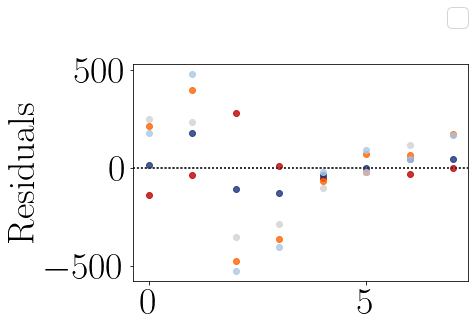

         Source  Squared sum  DOF Squared average         F \begin{tabular}[c]{@{}l@{}}P-Value \\ $(F_{0} > F)$\end{tabular}
Between factors 3.012408e+05    4    75310.196577  0.796833                                                         0.535368
 Inside factors 3.307917e+06   35    94511.905384                                                                           
          Total 3.609157e+06   39                                                                                           
-----------------------
-----------------------
\begin{table}[!htb]
\centering
\caption{Anova p-value for the average GSR on each method for blinded users.}
\label{tab:anova_gsr}
\begin{tabular}{lrrrrr}
\toprule
         Source &  Squared sum &  DOF & Squared average &     F & \begin{tabular}[c]{@{}l@{}}P-Value \\ $(F_{0} > F)$\end{tabular} \\
\midrule
Between factors &   301240.786 &    4 &       75310.197 & 0.797 &                                                            0.535 \\
 Inside fac

In [ ]:
if gerar == True:
    aux = dfGSRMedio_var_cen_par_2.reset_index(level = 1)
    anova = aux[aux['Visual Condition'] == 'Blind'].drop('Visual Condition', axis = 1)
else:
    aux = dfGSRMedio_var_cen_par.reset_index(level = 1)
    anova = aux[aux['Visual Condition'] == 'Blind'].drop('Visual Condition', axis = 1)

mediaGeral = np.average(anova)

res_amostras = pd.DataFrame([], columns=anova.columns)
for a in anova.columns:
    res_amostras_a = []
    for n_ij in anova[a]:
        res_amostras_a.append(n_ij - mediaGeral)
    res_amostras[a] = res_amostras_a
    #fig = sm.qqplot(res_amostras[a], fit = True, line = 'r')
    #plt.show()
    sns.residplot(y=a, x=res_amostras.index, data = res_amostras)
plt.legend(bbox_to_anchor=(1, 1.26), loc='upper right', borderaxespad=0)
plt.ylabel('Residuals')
#plt.savefig('Nasa-TLX/Figuras/boxplot_md.png',bbox_inches='tight')
plt.show()


df_summary = AnovaTable(anova)
label = 'tab:anova_gsr'
caption = 'Anova p-value for the average GSR on each method for blinded users.'
TabelaLatexSemIndex(df_summary,label,caption,'GSR', colformat = 'lrrrrr', escape = False)
label = 0
caption = 0

df_summary = BlockedAnovaTable(anova,4)
label = 'tab:blockedanova_gsr'
caption = 'Anova p-value for the average GSR on each method for blinded users.'
TabelaLatexSemIndex(df_summary,label,caption,'GSR', colformat = 'lrrrrr', escape = False)
label = 0
caption = 0

lsd = LSDPostHocAnova(anova)
label = 'tab:lsd_gsr'
caption = 'Cross validation p-value for the average GSR on each method for blinded users.'
TabelaLatexSemIndex(lsd,label,caption,'GSR', colformat = 'rclr', escape = False)
label = 0
caption = 0

#dun_0 = 
#DunnettPostHocAnova(anova,dun_0,anova['Base'])

### Demanda Mental

#### Variação

In [179]:
anova

,Base,Audio,Haptic Belt,Virtual Cane,Mixture
Participant,,,,,
001C,-66.666667,0.0,-28.571429,-33.333333,0.0
002C,-80.000000,0.0,0.000000,0.000000,-75.0
003C,-40.000000,-80.0,-80.000000,-75.000000,0.0
004C,-22.222222,0.0,-6.666667,-20.000000,0.0


No handles with labels found to put in legend.


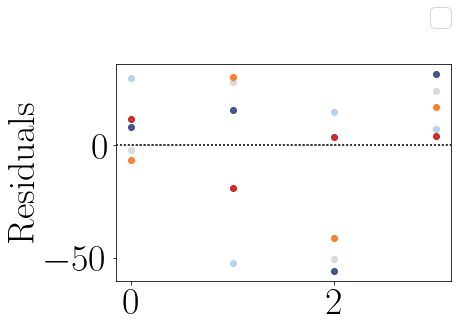

         Source  Squared sum  DOF Squared average         F \begin{tabular}[c]{@{}l@{}}P-Value \\ $(F_{0} > F)$\end{tabular}
Between factors  2901.805870    4      725.451468  0.604276                                                         0.665537
 Inside factors 18007.945956   15      1200.52973                                                                           
          Total 20909.751827   19                                                                                           
-----------------------
-----------------------
\begin{table}[!htb]
\centering
\caption{Anova p-value for the mental demand variation on each method for blinded users.}
\label{tab:anova_mental_demand_var}
\begin{tabular}{lrrrrr}
\toprule
         Source &  Squared sum &  DOF & Squared average &     F & \begin{tabular}[c]{@{}l@{}}P-Value \\ $(F_{0} > F)$\end{tabular} \\
\midrule
Between factors &     2901.806 &    4 &         725.451 & 0.604 &                                                      

In [178]:
mdNasa_var_cen_par

if gerar == True:
    anova = mdNasa_var_cen_par_2[mdNasa_var_cen_par_2['Visual Condition'] == 'Blind'].drop('Visual Condition', axis = 1)
else:
    anova = mdNasa_var_cen_par[mdNasa_var_cen_par['Visual Condition'] == 'Blind'].drop('Visual Condition', axis = 1)

mediaGeral = np.average(anova)

res_amostras = pd.DataFrame([], columns=anova.columns)
for a in anova.columns:
    res_amostras_a = []
    for n_ij in anova[a]:
        res_amostras_a.append(n_ij - mediaGeral)
    res_amostras[a] = res_amostras_a
    #fig = sm.qqplot(res_amostras[a], fit = True, line = 'r')
    #plt.show()
    sns.residplot(y=a, x=res_amostras.index, data = res_amostras)
plt.legend(bbox_to_anchor=(1, 1.26), loc='upper right', borderaxespad=0)
plt.ylabel('Residuals')
#plt.savefig('Nasa-TLX/Figuras/boxplot_md.png',bbox_inches='tight')
plt.show()


df_summary = AnovaTable(anova)
label = 'tab:anova_mental_demand_var'
caption = 'Anova p-value for the mental demand variation on each method for blinded users.'
TabelaLatexSemIndex(df_summary,label,caption,'Nasa', colformat = 'lrrrrr', escape = False)
label = 0
caption = 0

df_summary = BlockedAnovaTable(anova,4)
label = 'tab:blockedanova_mental_demand_var'
caption = 'Anova p-value for the variation of mental demand on each method for blinded users.'
TabelaLatexSemIndex(df_summary,label,caption,'Nasa', colformat = 'lrrrrr', escape = False)
label = 0
caption = 0

lsd = LSDPostHocAnova(anova)
label = 'tab:lsd_mental_demand_var'
caption = 'Cross validation p-value for the mental demand variation on each method for blinded users.'
TabelaLatexSemIndex(lsd,label,caption,'Nasa', colformat = 'rclr', escape = False)
label = 0
caption = 0

#dun_0 = 
#DunnettPostHocAnova(anova,dun_0,anova['Base'])

#### Média

In [180]:
anova

,Base,Audio,Haptic Belt,Virtual Cane,Mixture
Participant,,,,,
001C,-66.666667,0.0,-28.571429,-33.333333,0.0
002C,-80.000000,0.0,0.000000,0.000000,-75.0
003C,-40.000000,-80.0,-80.000000,-75.000000,0.0
004C,-22.222222,0.0,-6.666667,-20.000000,0.0


No handles with labels found to put in legend.


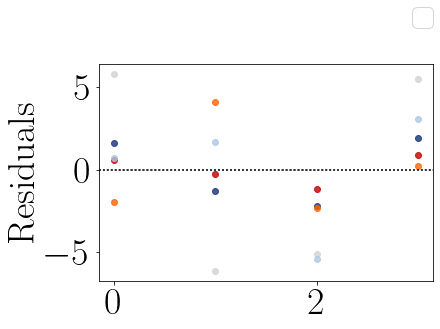

         Source  Squared sum  DOF Squared average         F \begin{tabular}[c]{@{}l@{}}P-Value \\ $(F_{0} > F)$\end{tabular}
Between factors      42.5750    4        10.64375  0.556172                                                         0.697788
 Inside factors     287.0625   15         19.1375                                                                           
          Total     329.6375   19                                                                                           
-----------------------
-----------------------
\begin{table}[!htb]
\centering
\caption{Anova p-value for the average mental demand on each method for blinded users.}
\label{tab:anova_mental_demand_avg}
\begin{tabular}{lrrrrr}
\toprule
         Source &  Squared sum &  DOF & Squared average &     F & \begin{tabular}[c]{@{}l@{}}P-Value \\ $(F_{0} > F)$\end{tabular} \\
\midrule
Between factors &       42.575 &    4 &          10.644 & 0.556 &                                                        

In [ ]:
if gerar == True:
    anova = mdNasa_media_cen_par_2[mdNasa_media_cen_par_2['Visual Condition'] == 'Blind'].drop('Visual Condition', axis = 1)
else:
    anova = mdNasa_media_cen_par[mdNasa_media_cen_par['Visual Condition'] == 'Blind'].drop('Visual Condition', axis = 1)

mediaGeral = np.average(anova)

res_amostras = pd.DataFrame([], columns=anova.columns)
for a in anova.columns:
    res_amostras_a = []
    for n_ij in anova[a]:
        res_amostras_a.append(n_ij - mediaGeral)
    res_amostras[a] = res_amostras_a
    #fig = sm.qqplot(res_amostras[a], fit = True, line = 'r')
    #plt.show()
    sns.residplot(y=a, x=res_amostras.index, data = res_amostras)
plt.legend(bbox_to_anchor=(1, 1.26), loc='upper right', borderaxespad=0)
plt.ylabel('Residuals')
#plt.savefig('Nasa-TLX/Figuras/boxplot_md.png',bbox_inches='tight')
plt.show()


df_summary = AnovaTable(anova)
label = 'tab:anova_mental_demand_avg'
caption = 'Anova p-value for the average mental demand on each method for blinded users.'
TabelaLatexSemIndex(df_summary,label,caption,'Nasa', colformat = 'lrrrrr', escape = False)
label = 0
caption = 0

df_summary = BlockedAnovaTable(anova,4)
label = 'tab:blockedanova_mental_demand_avg'
caption = 'Anova p-value for the average mental demand on each method for blinded users.'
TabelaLatexSemIndex(df_summary,label,caption,'Nasa', colformat = 'lrrrrr', escape = False)
label = 0
caption = 0

lsd = LSDPostHocAnova(anova)
label = 'tab:lsd_mental_demand_avg'
caption = 'Cross validation p-value for the average mental demand on each method for blinded users.'
TabelaLatexSemIndex(lsd,label,caption,'Nasa', colformat = 'rclr', escape = False)
label = 0
caption = 0

#dun_0 = 
#DunnettPostHocAnova(anova,dun_0,anova['Base'])

### Carga Mental

#### Variação

No handles with labels found to put in legend.


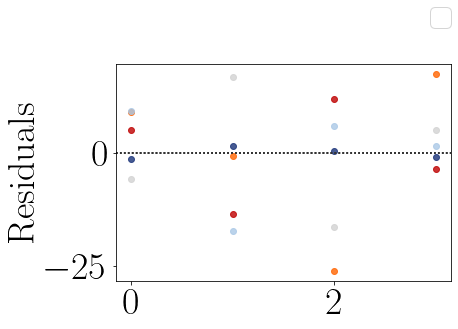

         Source  Squared sum  DOF Squared average         F \begin{tabular}[c]{@{}l@{}}P-Value \\ $(F_{0} > F)$\end{tabular}
Between factors   825.191344    4      206.297836  1.172319                                                         0.362225
 Inside factors  2639.611775   15      175.974118                                                                           
          Total  3464.803120   19                                                                                           
-----------------------
-----------------------
\begin{table}[!htb]
\centering
\caption{Anova p-value for the variation Nasa score on each method for blinded users.}
\label{tab:anova_nasa_var}
\begin{tabular}{lrrrrr}
\toprule
         Source &  Squared sum &  DOF & Squared average &     F & \begin{tabular}[c]{@{}l@{}}P-Value \\ $(F_{0} > F)$\end{tabular} \\
\midrule
Between factors &      825.191 &    4 &         206.298 & 1.172 &                                                            0.362 

In [ ]:
if gerar == True:
    anova = cmNasa_var_cen_par_2[cmNasa_media_cen_par_2['Visual Condition'] == 'Blind'].drop('Visual Condition', axis = 1)
else:
    anova = cmNasa_var_cen_par[cmNasa_media_cen_par['Visual Condition'] == 'Blind'].drop('Visual Condition', axis = 1)

mediaGeral = np.average(anova)

res_amostras = pd.DataFrame([], columns=anova.columns)
for a in anova.columns:
    res_amostras_a = []
    for n_ij in anova[a]:
        res_amostras_a.append(n_ij - mediaGeral)
    res_amostras[a] = res_amostras_a
    #fig = sm.qqplot(res_amostras[a], fit = True, line = 'r')
    #plt.show()
    sns.residplot(y=a, x=res_amostras.index, data = res_amostras)
plt.legend(bbox_to_anchor=(1, 1.26), loc='upper right', borderaxespad=0)
plt.ylabel('Residuals')
#plt.savefig('Nasa-TLX/Figuras/boxplot_md.png',bbox_inches='tight')
plt.show()


df_summary = AnovaTable(anova)
label = 'tab:anova_nasa_var'
caption = 'Anova p-value for the variation Nasa score on each method for blinded users.'
TabelaLatexSemIndex(df_summary,label,caption,'Nasa', colformat = 'lrrrrr', escape = False)
label = 0
caption = 0

df_summary = BlockedAnovaTable(anova,4)
label = 'tab:blockedanova_nasa_var'
caption = 'Anova p-value for the variation Nasa score on each method for blinded users.'
TabelaLatexSemIndex(df_summary,label,caption,'Nasa', colformat = 'lrrrrr', escape = False)
label = 0
caption = 0

lsd = LSDPostHocAnova(anova)
label = 'tab:lsd_nasa_var'
caption = 'Cross validation p-value for the variation Nasa score on each method for blinded users.'
TabelaLatexSemIndex(lsd,label,caption,'Nasa', colformat = 'rclr', escape = False)
label = 0
caption = 0

#dun_0 = 
#DunnettPostHocAnova(anova,dun_0,anova['Base'])

#### Média

No handles with labels found to put in legend.


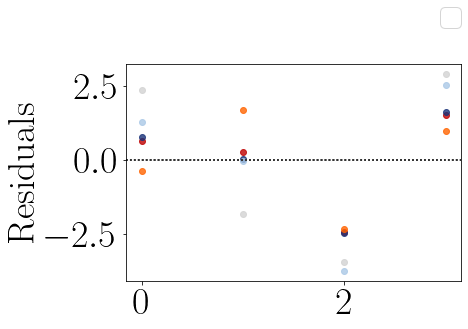

         Source  Squared sum  DOF Squared average         F \begin{tabular}[c]{@{}l@{}}P-Value \\ $(F_{0} > F)$\end{tabular}
Between factors     8.592361    4         2.14809  0.266794                                                         0.894731
 Inside factors   120.772569   15        8.051505                                                                           
          Total   129.364931   19                                                                                           
-----------------------
-----------------------
\begin{table}[!htb]
\centering
\caption{Anova p-value for the average Nasa score on each method for blinded users.}
\label{tab:anova_nasa_avg}
\begin{tabular}{lrrrrr}
\toprule
         Source &  Squared sum &  DOF & Squared average &     F & \begin{tabular}[c]{@{}l@{}}P-Value \\ $(F_{0} > F)$\end{tabular} \\
\midrule
Between factors &        8.592 &    4 &           2.148 & 0.267 &                                                            0.895 \\

In [ ]:
if gerar == True:
    anova = cmNasa_media_cen_par_2[cmNasa_media_cen_par_2['Visual Condition'] == 'Blind'].drop('Visual Condition', axis = 1)
else:
    anova = cmNasa_media_cen_par[cmNasa_media_cen_par['Visual Condition'] == 'Blind'].drop('Visual Condition', axis = 1)

mediaGeral = np.average(anova)

res_amostras = pd.DataFrame([], columns=anova.columns)
for a in anova.columns:
    res_amostras_a = []
    for n_ij in anova[a]:
        res_amostras_a.append(n_ij - mediaGeral)
    res_amostras[a] = res_amostras_a
    #fig = sm.qqplot(res_amostras[a], fit = True, line = 'r')
    #plt.show()
    sns.residplot(y=a, x=res_amostras.index, data = res_amostras)
plt.legend(bbox_to_anchor=(1, 1.26), loc='upper right', borderaxespad=0)
plt.ylabel('Residuals')
#plt.savefig('Nasa-TLX/Figuras/boxplot_md.png',bbox_inches='tight')
plt.show()


df_summary = AnovaTable(anova)
label = 'tab:anova_nasa_avg'
caption = 'Anova p-value for the average Nasa score on each method for blinded users.'
TabelaLatexSemIndex(df_summary,label,caption,'Nasa', colformat = 'lrrrrr', escape = False)
label = 0
caption = 0

df_summary = BlockedAnovaTable(anova,4)
label = 'tab:blockedanova_nasa_avg'
caption = 'Anova p-value for the average Nasa score on each method for blinded users.'
TabelaLatexSemIndex(df_summary,label,caption,'Nasa', colformat = 'lrrrrr', escape = False)
label = 0
caption = 0

lsd = LSDPostHocAnova(anova)
label = 'tab:lsd_nasa_avg'
caption = 'Cross validation p-value for the average Nasa score on each method for blinded users.'
TabelaLatexSemIndex(lsd,label,caption,'Nasa', colformat = 'rclr', escape = False)
label = 0
caption = 0

#dun_0 = 
#DunnettPostHocAnova(anova,dun_0,anova['Base'])

### Sagat

#### Média

No handles with labels found to put in legend.


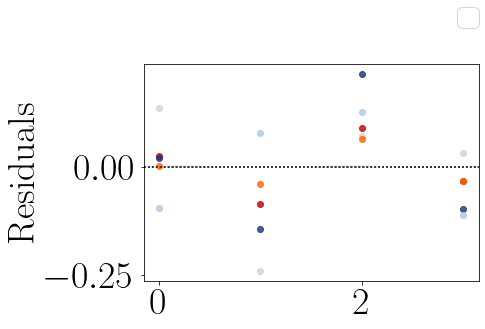

         Source  Squared sum  DOF Squared average         F \begin{tabular}[c]{@{}l@{}}P-Value \\ $(F_{0} > F)$\end{tabular}
Between factors     0.044610    4        0.011152  0.440562                                                         0.777462
 Inside factors     0.379713   15        0.025314                                                                           
          Total     0.424323   19                                                                                           
-----------------------
-----------------------
\begin{table}[!htb]
\centering
\caption{Anova p-value for the Sagat score on each method for blinded users.}
\label{tab:anova_sagat_avg}
\begin{tabular}{lrrrrr}
\toprule
         Source &  Squared sum &  DOF & Squared average &     F & \begin{tabular}[c]{@{}l@{}}P-Value \\ $(F_{0} > F)$\end{tabular} \\
\midrule
Between factors &        0.045 &    4 &           0.011 & 0.441 &                                                            0.777 \\
 Insi

In [ ]:
if gerar == True:
    anova = saSagat_media_cen_par_2[saSagat_media_cen_par_2['Visual Condition'] == 'Blind'].drop('Visual Condition', axis = 1)
else:
    anova = saSagat_media_cen_par[saSagat_media_cen_par['Visual Condition'] == 'Blind'].drop('Visual Condition', axis = 1)

mediaGeral = np.average(anova)

res_amostras = pd.DataFrame([], columns=anova.columns)
for a in anova.columns:
    res_amostras_a = []
    for n_ij in anova[a]:
        res_amostras_a.append(n_ij - mediaGeral)
    res_amostras[a] = res_amostras_a
    #fig = sm.qqplot(res_amostras[a], fit = True, line = 'r')
    #plt.show()
    sns.residplot(y=a, x=res_amostras.index, data = res_amostras)
plt.legend(bbox_to_anchor=(1, 1.26), loc='upper right', borderaxespad=0)
plt.ylabel('Residuals')
#plt.savefig('Nasa-TLX/Figuras/boxplot_md.png',bbox_inches='tight')
plt.show()


df_summary = AnovaTable(anova)
label = 'tab:anova_sagat_avg'
caption = 'Anova p-value for the Sagat score on each method for blinded users.'
TabelaLatexSemIndex(df_summary,label,caption,'Sagat', colformat = 'lrrrrr', escape = False)
label = 0
caption = 0

df_summary = BlockedAnovaTable(anova,4)
label = 'tab:blockedanova_sagat_avg'
caption = 'Anova p-value for the Sagat score on each method for blinded users.'
TabelaLatexSemIndex(df_summary,label,caption,'Sagat', colformat = 'lrrrrr', escape = False)
label = 0
caption = 0

lsd = LSDPostHocAnova(anova)
label = 'tab:lsd_sagat_avg'
caption = 'Cross validation p-value for the Sagat score on each method for blinded users.'
TabelaLatexSemIndex(lsd,label,caption,'Sagat', colformat = 'rclr', escape = False)
label = 0
caption = 0

#dun_0 = 
#DunnettPostHocAnova(anova,dun_0,anova['Base'])

#### Variação

No handles with labels found to put in legend.


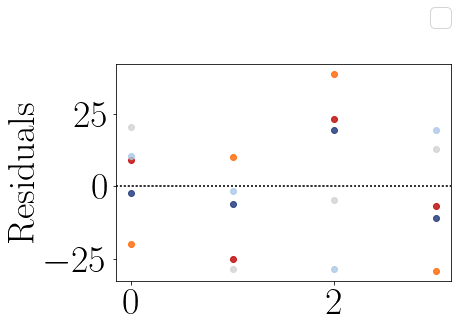

         Source  Squared sum  DOF Squared average         F \begin{tabular}[c]{@{}l@{}}P-Value \\ $(F_{0} > F)$\end{tabular}
Between factors  3131.541596    4      782.885399  1.054783                                                         0.412426
 Inside factors 11133.360143   15       742.22401                                                                           
          Total 14264.901739   19                                                                                           
-----------------------
-----------------------
\begin{table}[!htb]
\centering
\caption{Anova p-value for the variation Sagat score on each method for blinded users.}
\label{tab:anova_sagat_var}
\begin{tabular}{lrrrrr}
\toprule
         Source &  Squared sum &  DOF & Squared average &     F & \begin{tabular}[c]{@{}l@{}}P-Value \\ $(F_{0} > F)$\end{tabular} \\
\midrule
Between factors &     3131.542 &    4 &         782.885 & 1.055 &                                                            0.41

In [ ]:
if gerar == True:
    anova = saSagat_var_cen_par_2[saSagat_var_cen_par_2['Visual Condition'] == 'Blind'].drop('Visual Condition', axis = 1)
else:
    anova = saSagat_var_cen_par[saSagat_var_cen_par['Visual Condition'] == 'Blind'].drop('Visual Condition', axis = 1)

mediaGeral = np.average(anova)

res_amostras = pd.DataFrame([], columns=anova.columns)
for a in anova.columns:
    res_amostras_a = []
    for n_ij in anova[a]:
        res_amostras_a.append(n_ij - mediaGeral)
    res_amostras[a] = res_amostras_a
    #fig = sm.qqplot(res_amostras[a], fit = True, line = 'r')
    #plt.show()
    sns.residplot(y=a, x=res_amostras.index, data = res_amostras)
plt.legend(bbox_to_anchor=(1, 1.26), loc='upper right', borderaxespad=0)
plt.ylabel('Residuals')
#plt.savefig('Nasa-TLX/Figuras/boxplot_md.png',bbox_inches='tight')
plt.show()


df_summary = AnovaTable(anova)
label = 'tab:anova_sagat_var'
caption = 'Anova p-value for the Sagat score variation on each method for blinded users.'
TabelaLatexSemIndex(df_summary,label,caption,'Sagat', colformat = 'lrrrrr', escape = False)
label = 0
caption = 0

df_summary = BlockedAnovaTable(anova,4)
label = 'tab:blockedanova_sagat_var'
caption = 'Anova p-value for the Sagat score variation on each method for blinded users.'
TabelaLatexSemIndex(df_summary,label,caption,'Sagat', colformat = 'lrrrrr', escape = False)
label = 0
caption = 0

lsd = LSDPostHocAnova(anova)
label = 'tab:lsd_sagat_var'
caption = 'Cross validation p-value for the variation Sagat score on each method for blinded users.'
TabelaLatexSemIndex(lsd,label,caption,'Sagat', colformat = 'rclr', escape = False)
label = 0
caption = 0

#dun_0 = 
#DunnettPostHocAnova(anova,dun_0,anova['Base'])

### Tempo

#### Variação

No handles with labels found to put in legend.


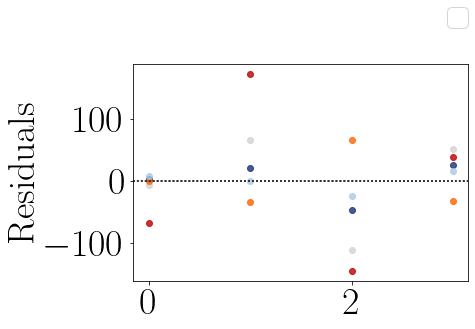

         Source   Squared sum  DOF Squared average         F \begin{tabular}[c]{@{}l@{}}P-Value \\ $(F_{0} > F)$\end{tabular}
Between factors 359761.342687    4    89940.335672  8.910354                                                         0.000684
 Inside factors 151408.689456   15     10093.91263                                                                           
          Total 511170.032143   19                                                                                           
-----------------------
-----------------------
\begin{table}[!htb]
\centering
\caption{Anova p-value for the duration of each method for blinded users.}
\label{tab:anova_duration_var}
\begin{tabular}{lrrrrr}
\toprule
         Source &  Squared sum &  DOF & Squared average &     F & \begin{tabular}[c]{@{}l@{}}P-Value \\ $(F_{0} > F)$\end{tabular} \\
\midrule
Between factors &   359761.343 &    4 &       89940.336 & 8.910 &                                                            0.001 \\
 

In [ ]:
if gerar == True:
    anova = duracao_var_cen_par_2[duracao_var_cen_par_2['Visual Condition'] == 'Blind'].drop('Visual Condition', axis = 1)
else:
    anova = duracao_var_cen_par[duracao_var_cen_par['Visual Condition'] == 'Blind'].drop('Visual Condition', axis = 1)

mediaGeral = np.average(anova)

res_amostras = pd.DataFrame([], columns=anova.columns)
for a in anova.columns:
    res_amostras_a = []
    for n_ij in anova[a]:
        res_amostras_a.append(n_ij - mediaGeral)
    res_amostras[a] = res_amostras_a
    #fig = sm.qqplot(res_amostras[a], fit = True, line = 'r')
    #plt.show()
    sns.residplot(y=a, x=res_amostras.index, data = res_amostras)
plt.legend(bbox_to_anchor=(1, 1.26), loc='upper right', borderaxespad=0)
plt.ylabel('Residuals')
#plt.savefig('Nasa-TLX/Figuras/boxplot_md.png',bbox_inches='tight')
plt.show()


df_summary = AnovaTable(anova)
label = 'tab:anova_duration_var'
caption = 'Anova p-value for the duration difference of each method for blinded users.'
TabelaLatexSemIndex(df_summary,label,caption,'Tempo', colformat = 'lrrrrr', escape = False)
label = 0
caption = 0

df_summary = BlockedAnovaTable(anova,4)
label = 'tab:blockedanova_duration_var'
caption = 'Anova p-value for the duration difference of each method for blinded users.'
TabelaLatexSemIndex(df_summary,label,caption,'Tempo', colformat = 'lrrrrr', escape = False)
label = 0
caption = 0

lsd = LSDPostHocAnova(anova)
label = 'tab:lsd_duration_var'
caption = 'Cross validation p-value for the duration of each method for blinded users.'
TabelaLatexSemIndex(lsd,label,caption,'Tempo', colformat = 'rclr', escape = False)
label = 0
caption = 0

#dun_0 = 
#DunnettPostHocAnova(anova,dun_0,anova['Base'])

#### Média

No handles with labels found to put in legend.


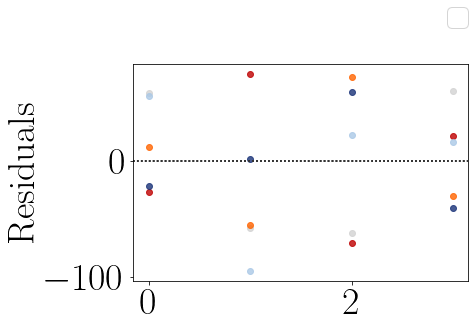

         Source   Squared sum  DOF Squared average         F \begin{tabular}[c]{@{}l@{}}P-Value \\ $(F_{0} > F)$\end{tabular}
Between factors  30809.375195    4     7702.343799  1.585963                                                         0.229207
 Inside factors  72848.605408   15     4856.573694                                                                           
          Total 103657.980603   19                                                                                           
-----------------------
-----------------------
\begin{table}[!htb]
\centering
\caption{Anova p-value for the duration of each method for blinded users.}
\label{tab:anova_duration}
\begin{tabular}{lrrrrr}
\toprule
         Source &  Squared sum &  DOF & Squared average &     F & \begin{tabular}[c]{@{}l@{}}P-Value \\ $(F_{0} > F)$\end{tabular} \\
\midrule
Between factors &    30809.375 &    4 &        7702.344 & 1.586 &                                                            0.229 \\
 Insi

In [ ]:
if gerar == True:
    anova = duracao_media_cen_par_2[duracao_media_cen_par_2['Visual Condition'] == 'Blind'].drop('Visual Condition', axis = 1)
else:
    anova = duracao_media_cen_par[duracao_media_cen_par['Visual Condition'] == 'Blind'].drop('Visual Condition', axis = 1)

mediaGeral = np.average(anova)

res_amostras = pd.DataFrame([], columns=anova.columns)
for a in anova.columns:
    res_amostras_a = []
    for n_ij in anova[a]:
        res_amostras_a.append(n_ij - mediaGeral)
    res_amostras[a] = res_amostras_a
    #fig = sm.qqplot(res_amostras[a], fit = True, line = 'r')
    #plt.show()
    sns.residplot(y=a, x=res_amostras.index, data = res_amostras)
plt.legend(bbox_to_anchor=(1, 1.26), loc='upper right', borderaxespad=0)
plt.ylabel('Residuals')
#plt.savefig('Nasa-TLX/Figuras/boxplot_md.png',bbox_inches='tight')
plt.show()


df_summary = AnovaTable(anova)
label = 'tab:anova_duration_avg'
caption = 'Anova p-value for the duration average of each method for blinded users.'
TabelaLatexSemIndex(df_summary,label,caption,'Tempo', colformat = 'lrrrrr', escape = False)
label = 0
caption = 0

df_summary = BlockedAnovaTable(anova,4)
label = 'tab:blockedanova_duration_avg'
caption = 'Anova p-value for the duration average of each method for blinded users.'
TabelaLatexSemIndex(df_summary,label,caption,'Tempo', colformat = 'lrrrrr', escape = False)
label = 0
caption = 0

lsd = LSDPostHocAnova(anova)
label = 'tab:lsd_duration'
caption = 'Cross validation p-value for the duration of each method for blinded users.'
TabelaLatexSemIndex(lsd,label,caption,'Tempo', colformat = 'rclr', escape = False)
label = 0
caption = 0

#dun_0 = 
#DunnettPostHocAnova(anova,dun_0,anova['Base'])

### Questionarios

No handles with labels found to put in legend.


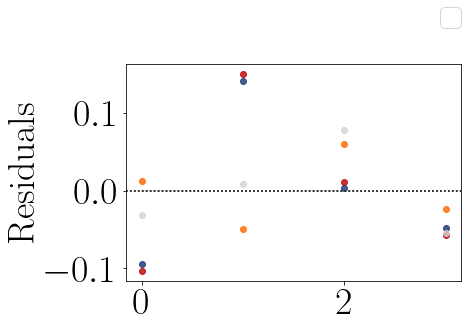

         Source  Squared sum  DOF Squared average         F \begin{tabular}[c]{@{}l@{}}P-Value \\ $(F_{0} > F)$\end{tabular}
Between factors     0.206953    3        0.068984  7.079635                                                         0.005393
 Inside factors     0.116929   12        0.009744                                                                           
          Total     0.323881   15                                                                                           
-----------------------
-----------------------
\begin{table}[!htb]
\centering
\caption{Anova p-value for the questionnaire score on each method for blinded users.}
\label{tab:anova_questionnaire}
\begin{tabular}{lrrrrr}
\toprule
         Source &  Squared sum &  DOF & Squared average &     F & \begin{tabular}[c]{@{}l@{}}P-Value \\ $(F_{0} > F)$\end{tabular} \\
\midrule
Between factors &        0.207 &    3 &           0.069 & 7.080 &                                                            0.

In [ ]:
if gerar == True:
    anova = pgQuestionario_media_2[pgQuestionario_media_2['Visual Condition'] == 'Blind'].drop('Visual Condition', axis = 1)
else:
    anova = pgQuestionario_media[pgQuestionario_media['Visual Condition'] == 'Blind'].drop('Visual Condition', axis = 1)

mediaGeral = np.average(anova)

res_amostras = pd.DataFrame([], columns=anova.columns)
for a in anova.columns:
    res_amostras_a = []
    for n_ij in anova[a]:
        res_amostras_a.append(n_ij - mediaGeral)
    res_amostras[a] = res_amostras_a
    #fig = sm.qqplot(res_amostras[a], fit = True, line = 'r')
    #plt.show()
    sns.residplot(y=a, x=res_amostras.index, data = res_amostras)
plt.legend(bbox_to_anchor=(1, 1.26), loc='upper right', borderaxespad=0)
plt.ylabel('Residuals')
#plt.savefig('Nasa-TLX/Figuras/boxplot_md.png',bbox_inches='tight')
plt.show()


df_summary = AnovaTable(anova)
label = 'tab:anova_questionnaire'
caption = 'Anova p-value for the questionnaire score on each method for blinded users.'
TabelaLatexSemIndex(df_summary,label,caption,'Questionario', colformat = 'lrrrrr', escape = False)
label = 0
caption = 0

df_summary = BlockedAnovaTable(anova,4)
label = 'tab:blockedanova_duration_avg'
caption = 'Anova p-value for the questionnaire score of each method for blinded users.'
TabelaLatexSemIndex(df_summary,label,caption,'Questionario', colformat = 'lrrrrr', escape = False)
label = 0
caption = 0

lsd = LSDPostHocAnova(anova)
label = 'tab:lsd_questionnaire'
caption = 'Cross validation p-value for the questionnaire score on each method for blinded users.'
TabelaLatexSemIndex(lsd,label,caption,'Questionario', colformat = 'rclr', escape = False)
label = 0
caption = 0

#dun_0 = 
#DunnettPostHocAnova(anova,dun_0,anova['Base'])

## Gráficos

In [ ]:
tamanhoBarra5 = [18,7]
tamanhoBarra2 = [10,10]
tamanhoBox = [10,10]

### Gráfico de barra da variação do ECG

#### Frequência cardiaca

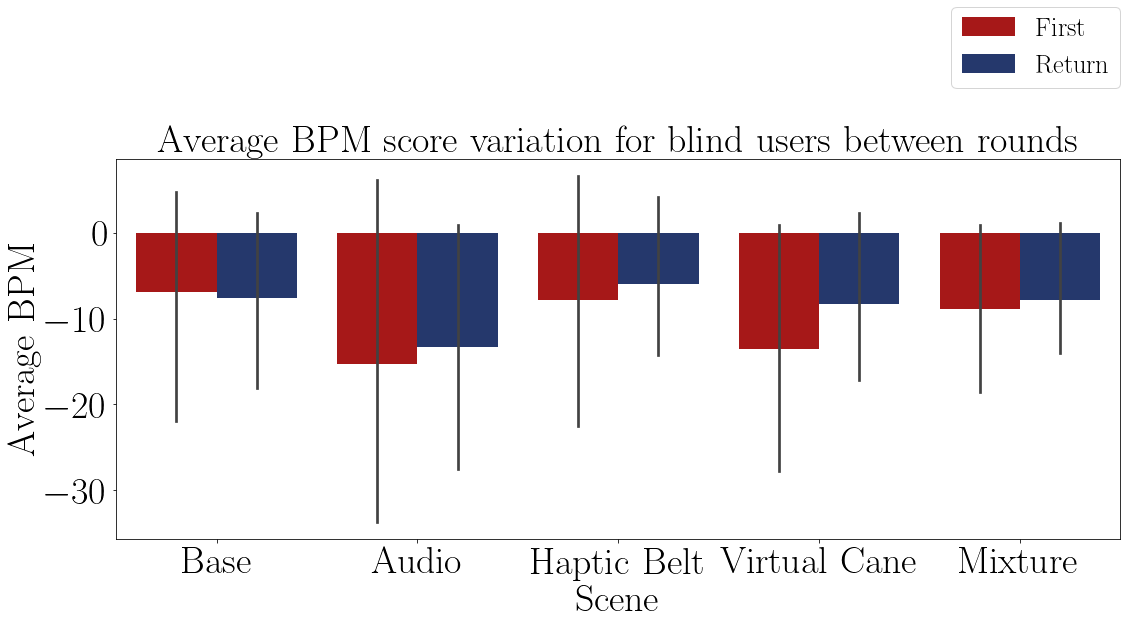

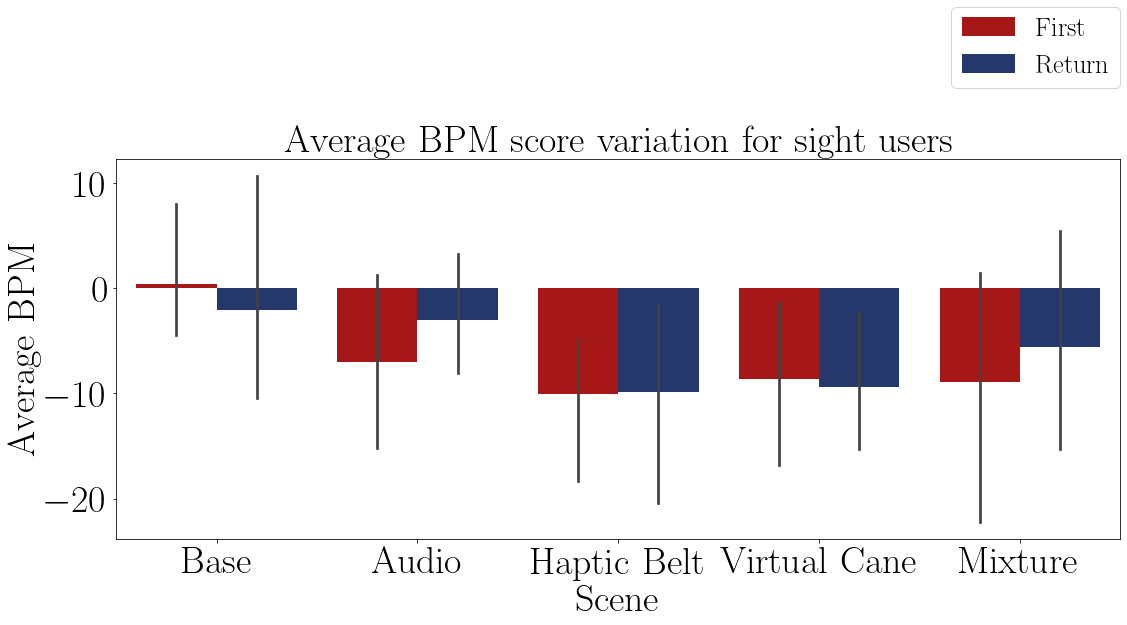

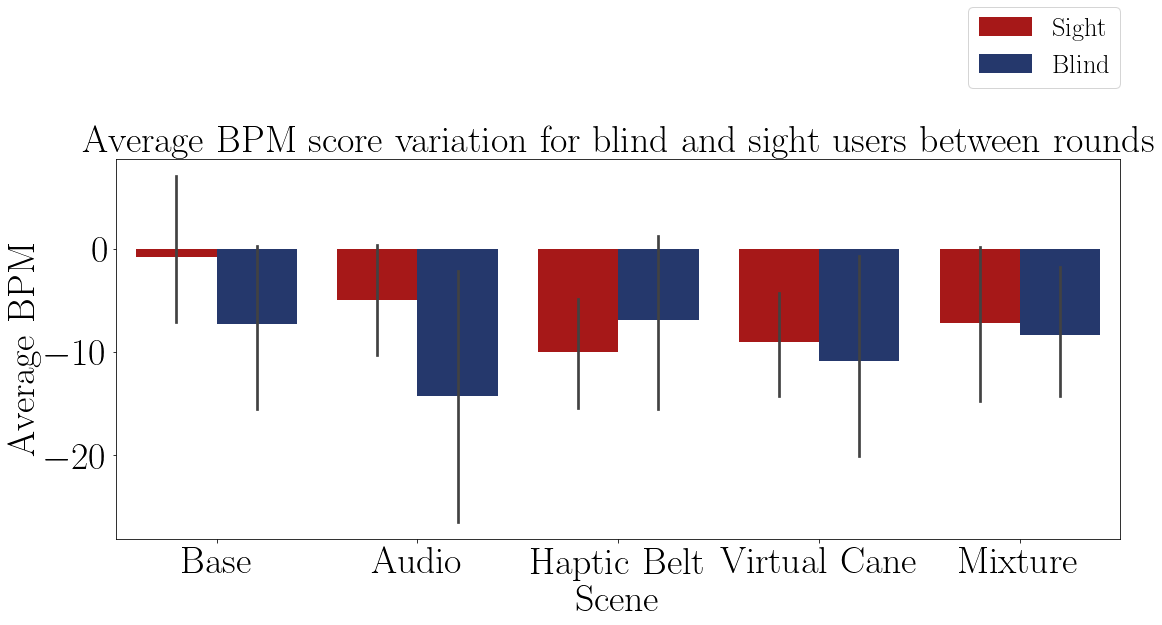

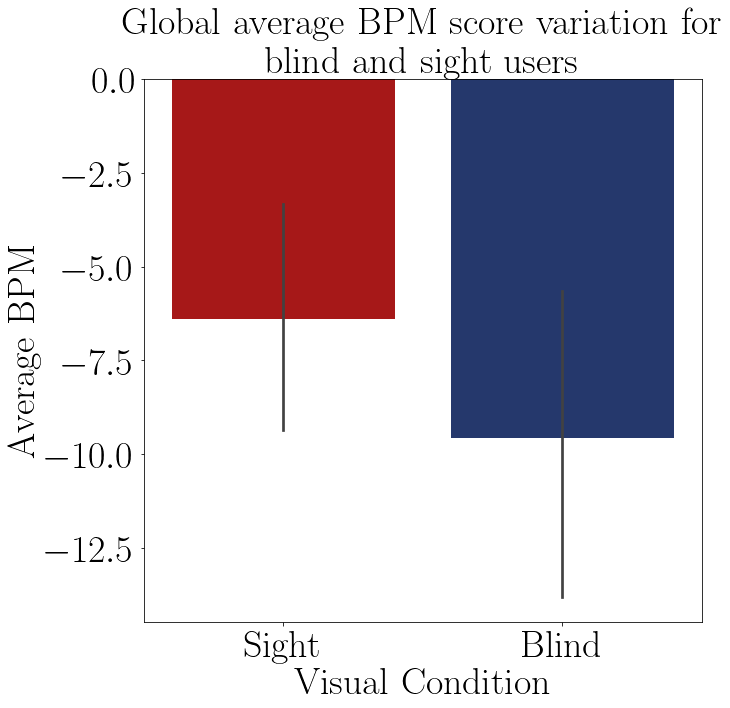

In [ ]:
teste = 'ECG'

score = 'average BPM'
Score = 'Average BPM'
label = 'ecg_bpm'

PlotarGraficosTodosBarra(dfECGDadosBPMMedio_var_cen_par,score,Score,teste,label)


#### Desvio Padrão entre intervalos

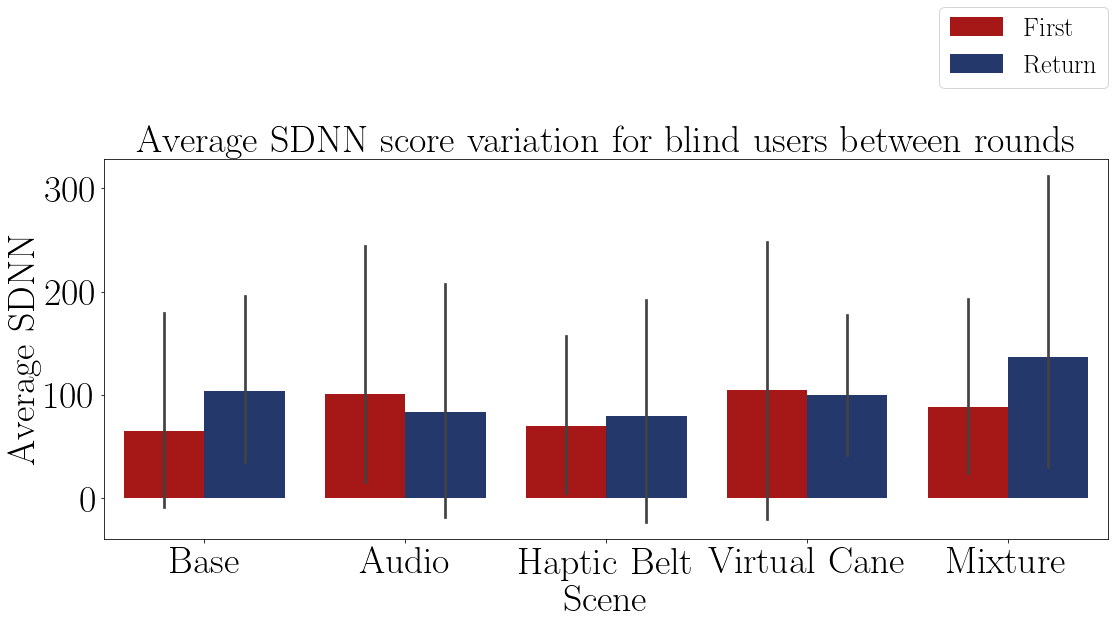

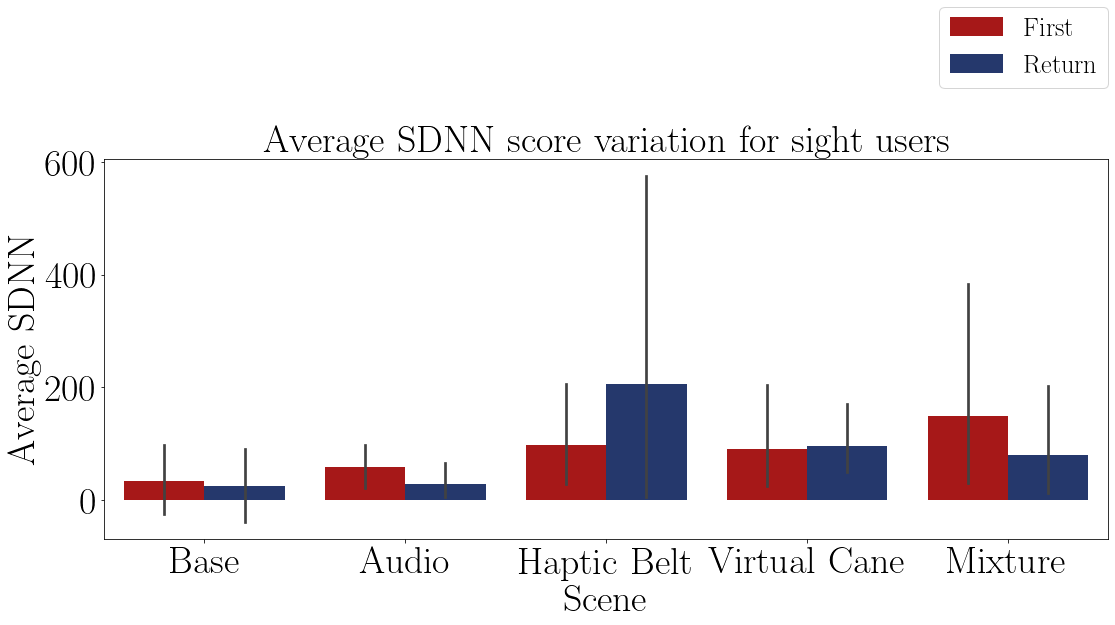

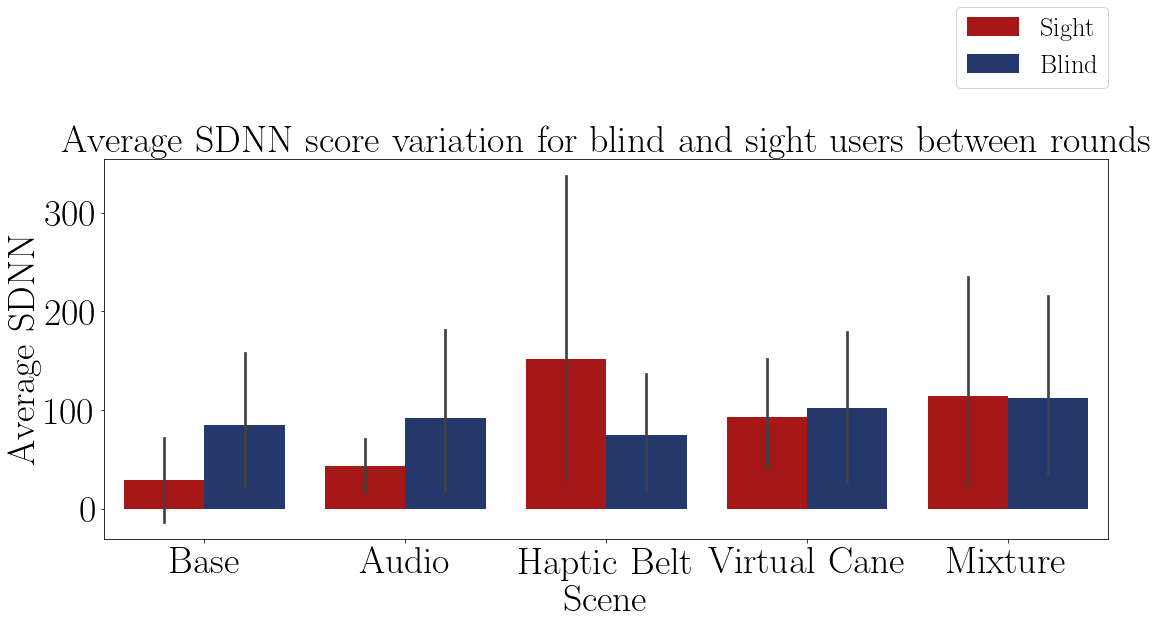

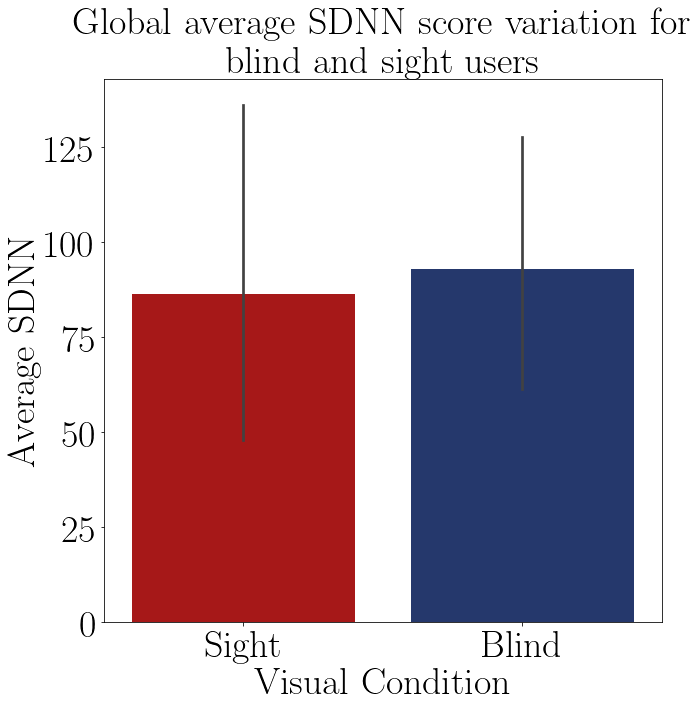

In [ ]:
score = 'average SDNN'
Score = 'Average SDNN'
label = 'ecg_sdnn'

PlotarGraficosTodosBarra(dfECGDadosSDNN_var_cen_par,score,Score,teste,label)

#### Erro quadrático médio

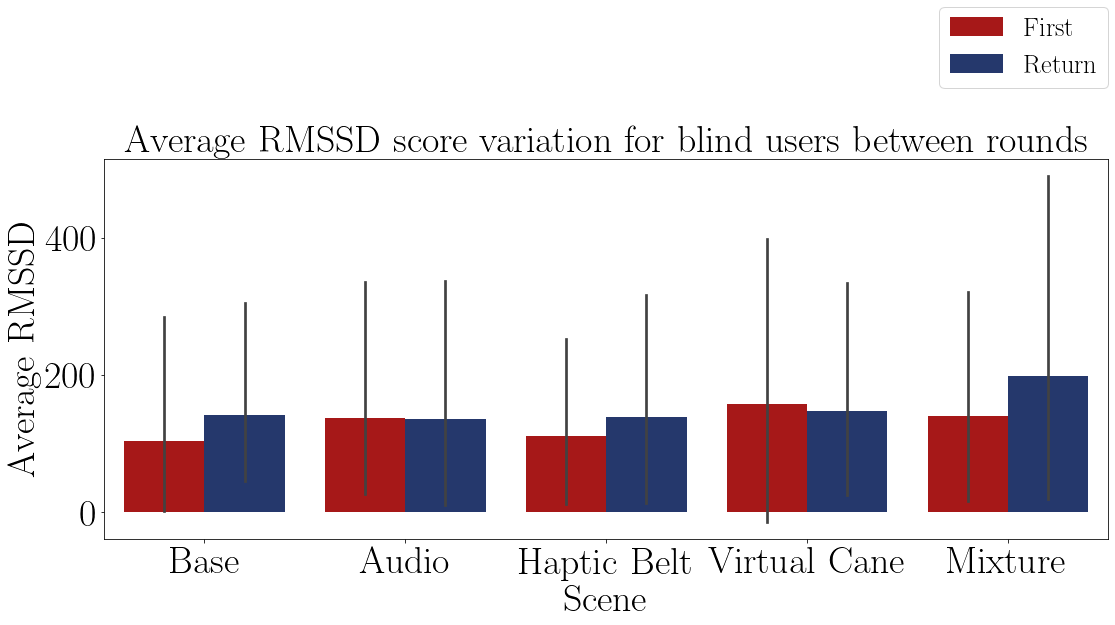

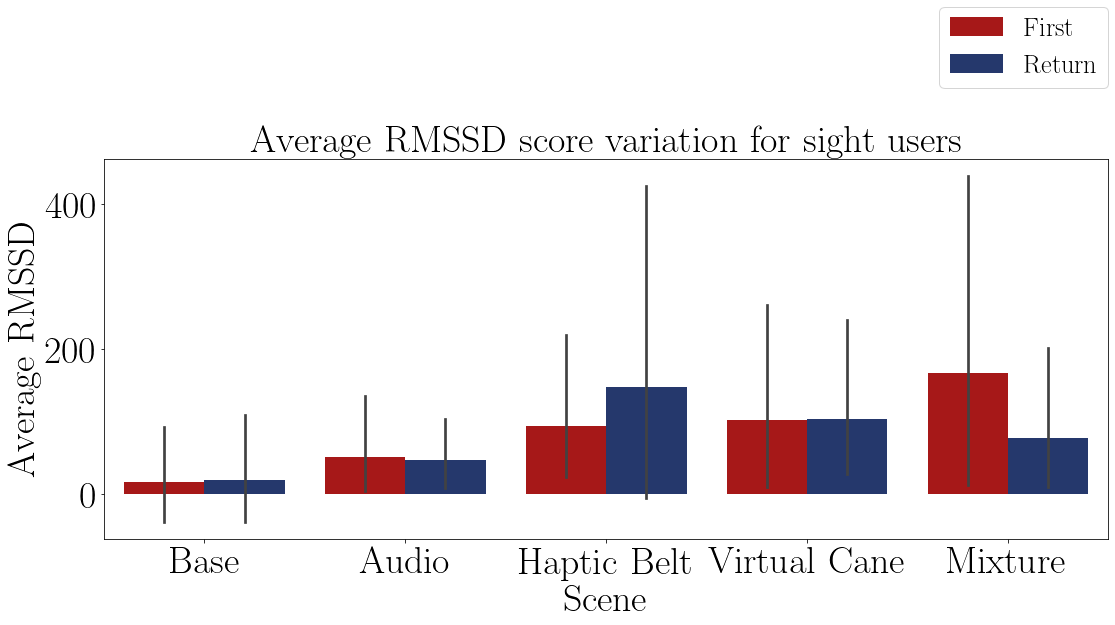

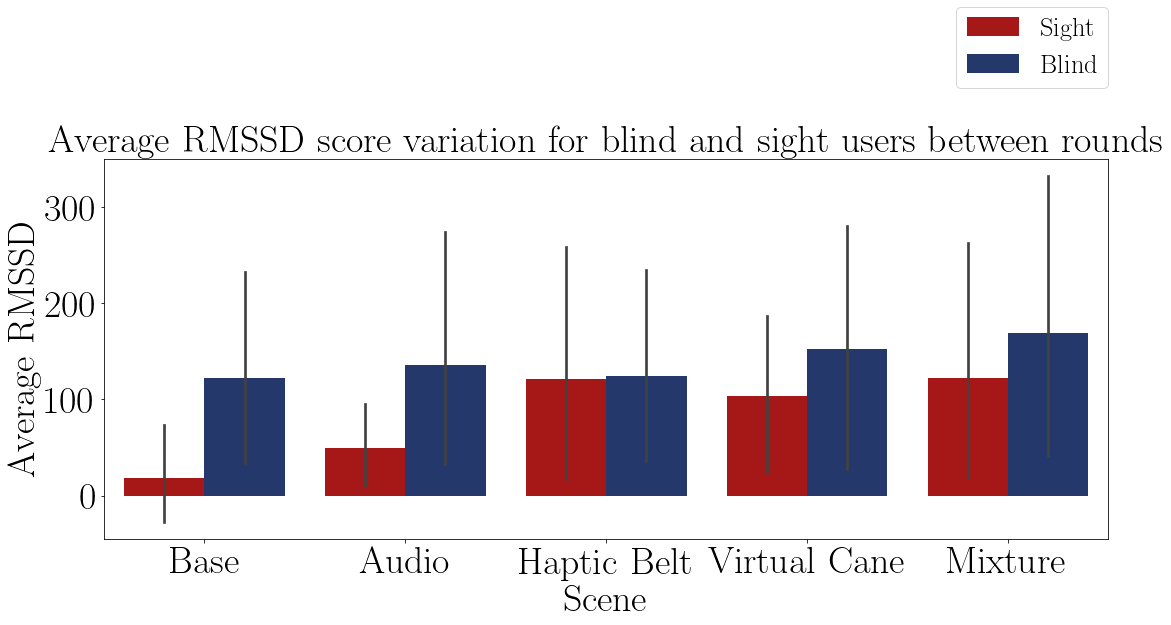

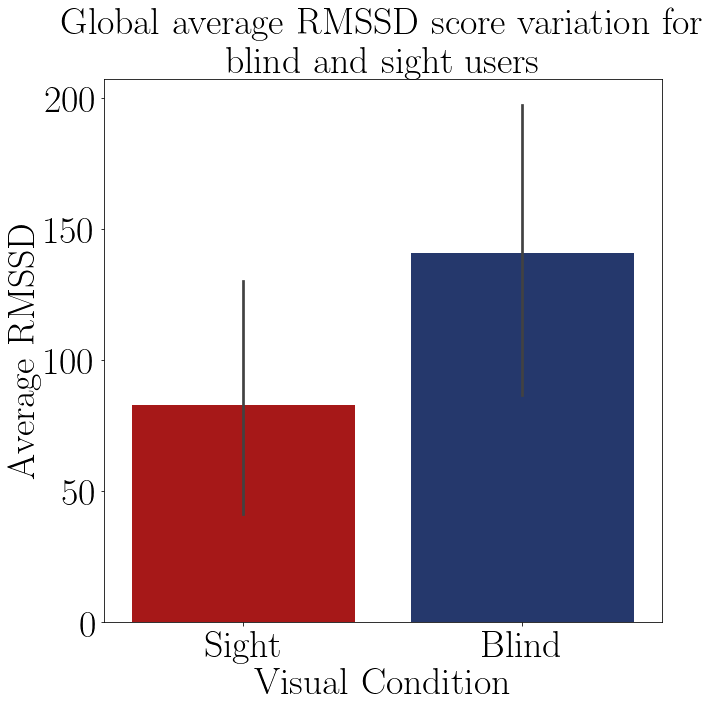

In [ ]:
score = 'average RMSSD'
Score = 'Average RMSSD'
label = 'ecg_rmssd'

PlotarGraficosTodosBarra(dfECGDadosRMSSD_var_cen_par,score,Score,teste,label)

#### pNN50

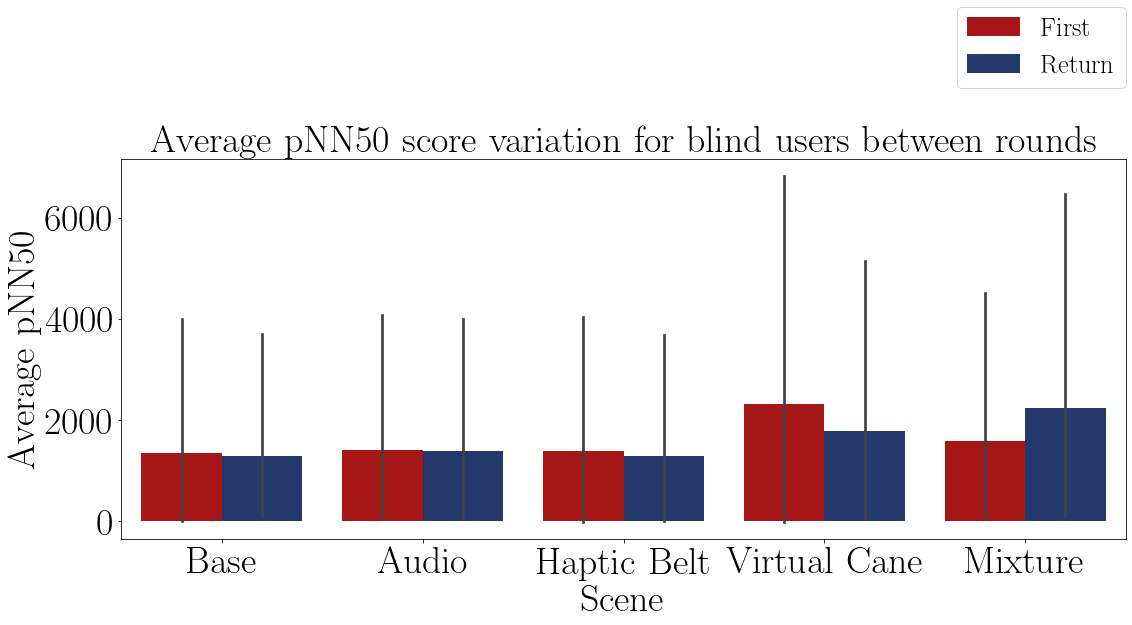

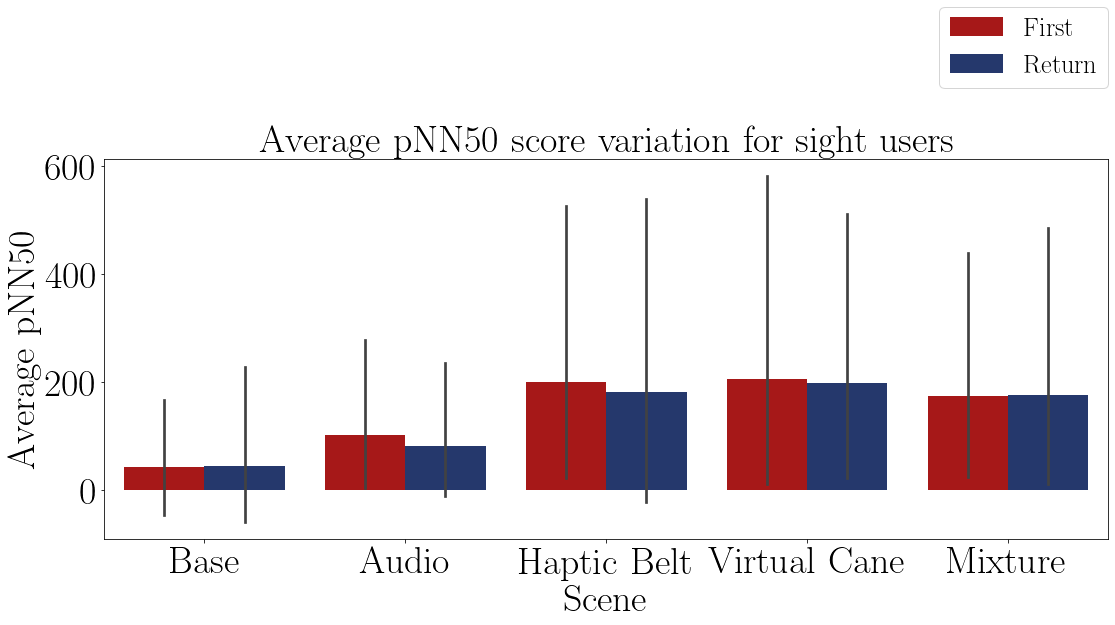

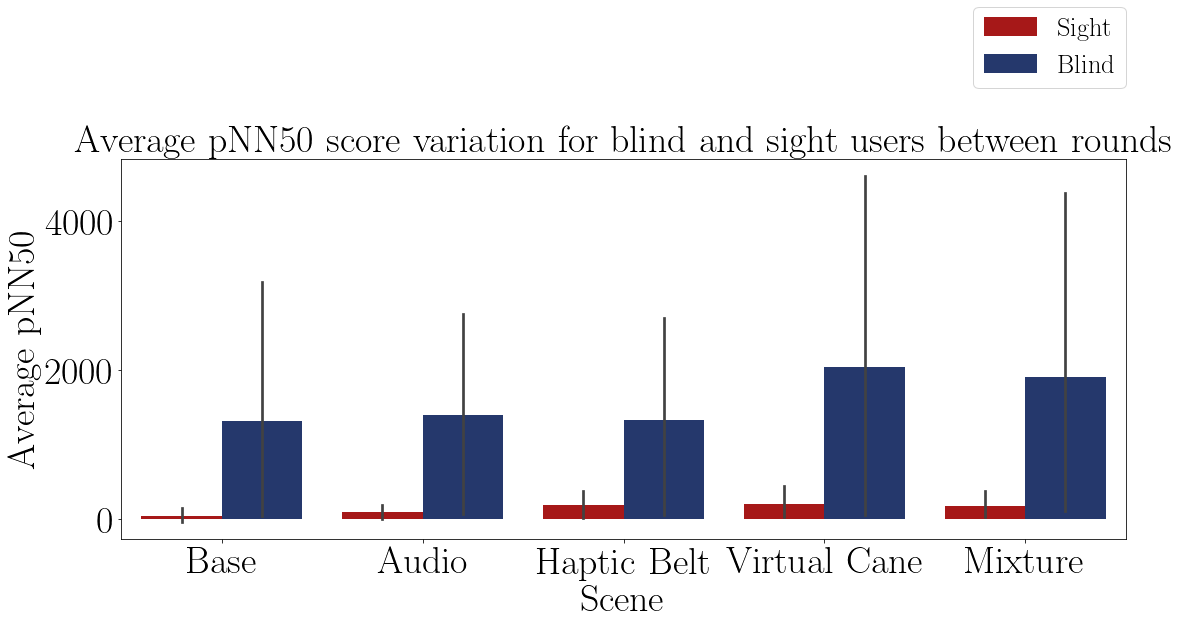

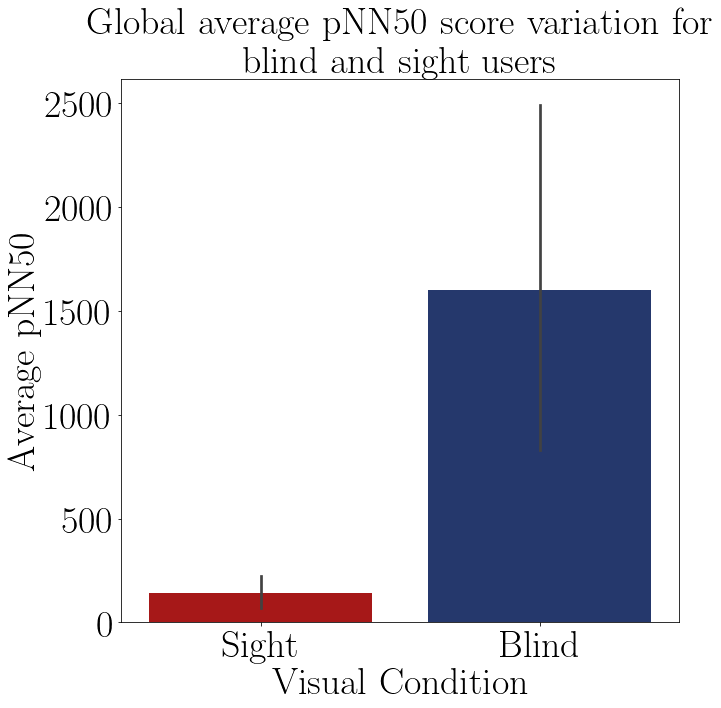

In [ ]:
score = 'average pNN50'
Score = 'Average pNN50'
label = 'ecg_pnn50'

PlotarGraficosTodosBarra(dfECGDadosPNN50_var_cen_par,score,Score,teste,label)

#### LF/HF

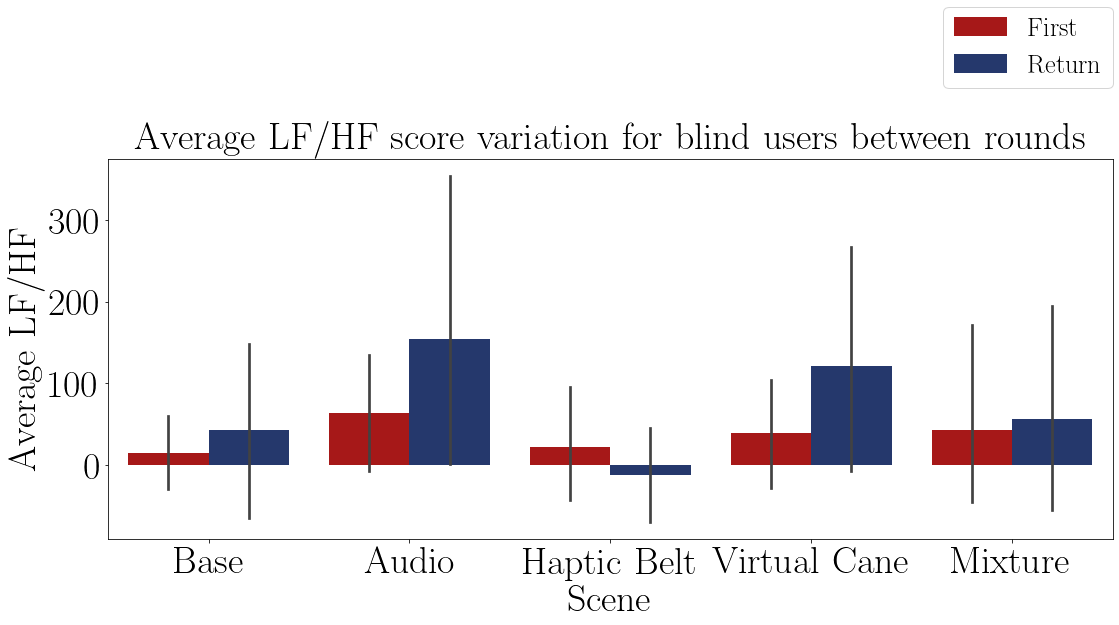

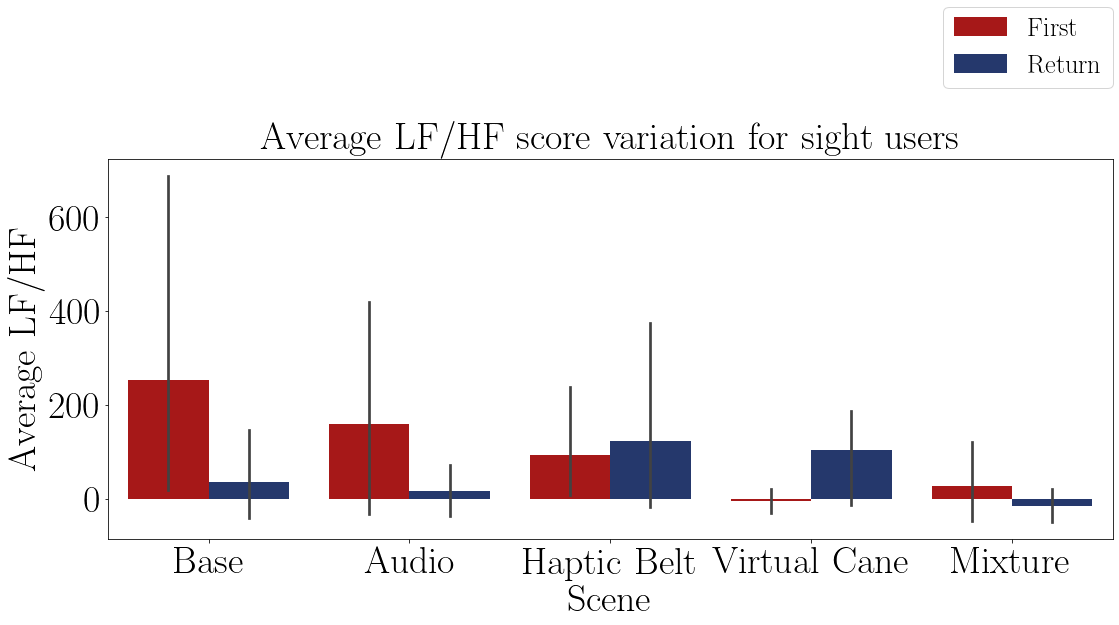

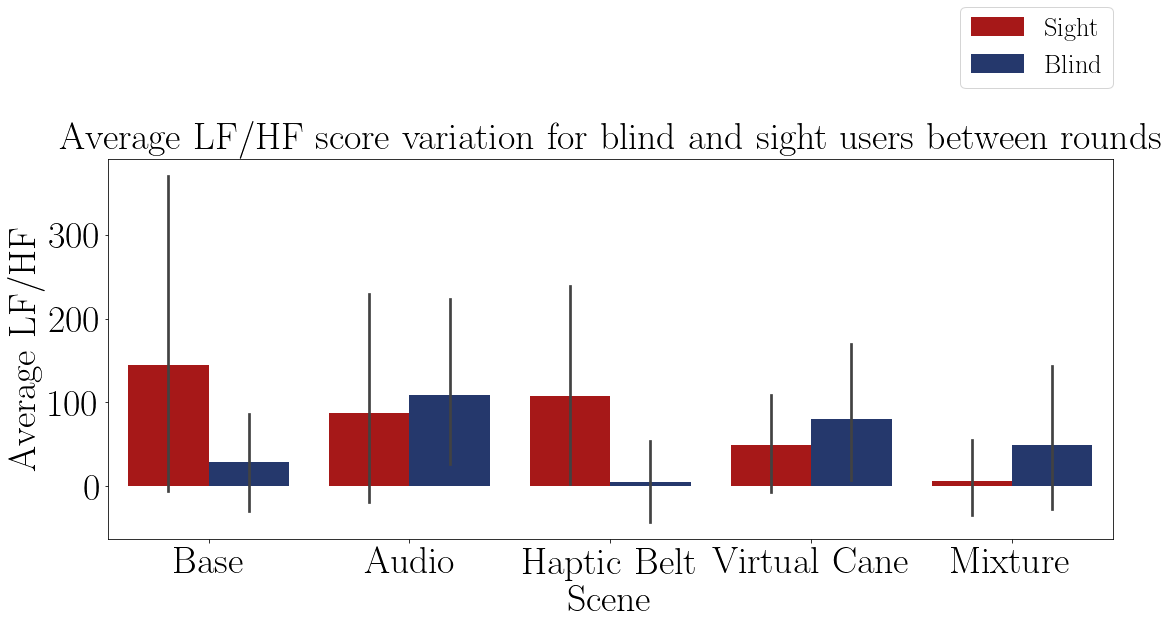

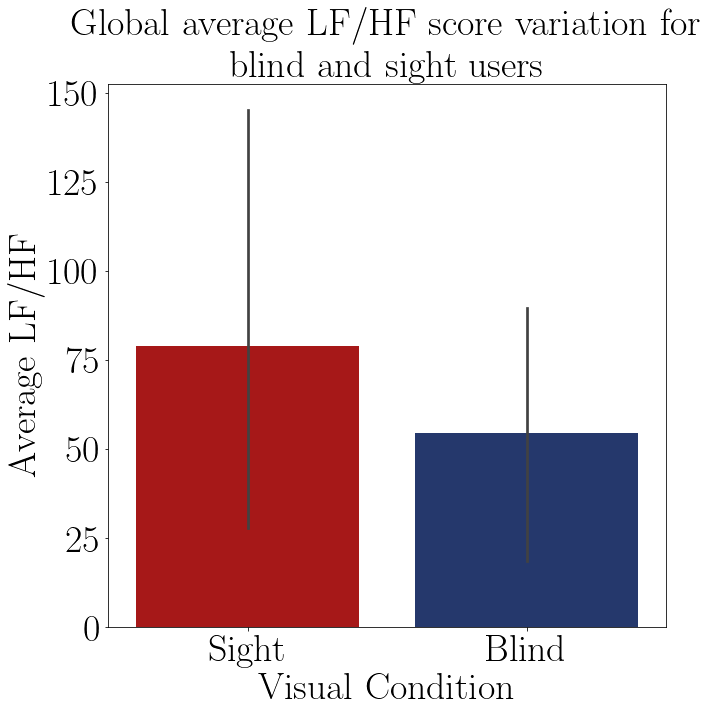

In [ ]:
score = 'average LF/HF'
Score = 'Average LF/HF'
label = 'ecg_lfhf'

PlotarGraficosTodosBarra(dfECGDadosLFHF_var_cen_par,score,Score,teste,label)

### Gráfico de barra da variação do GSR Médio

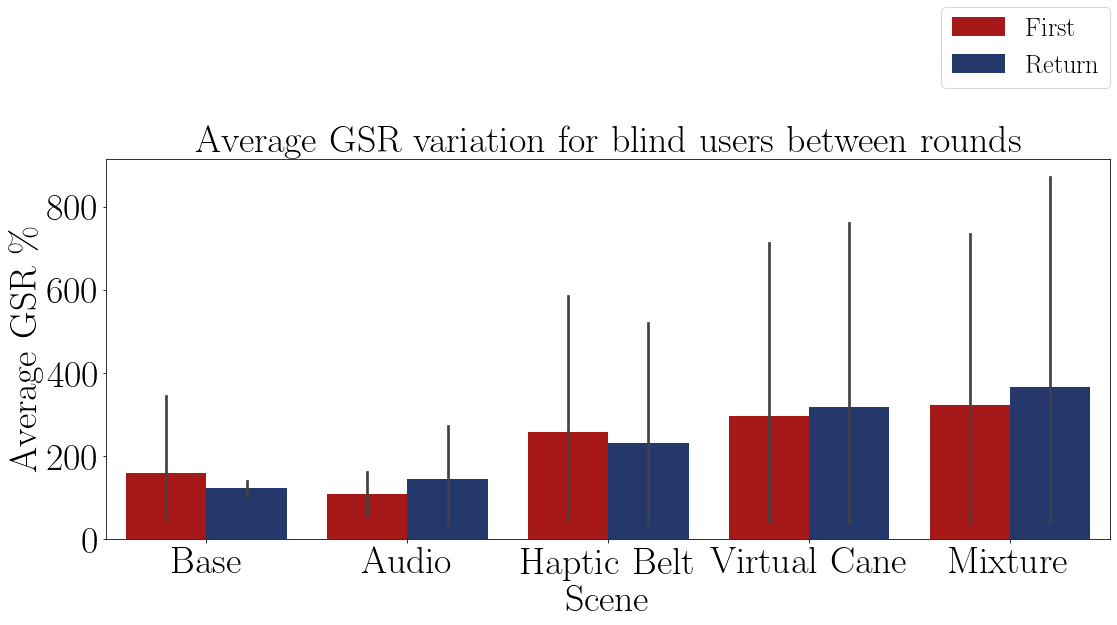

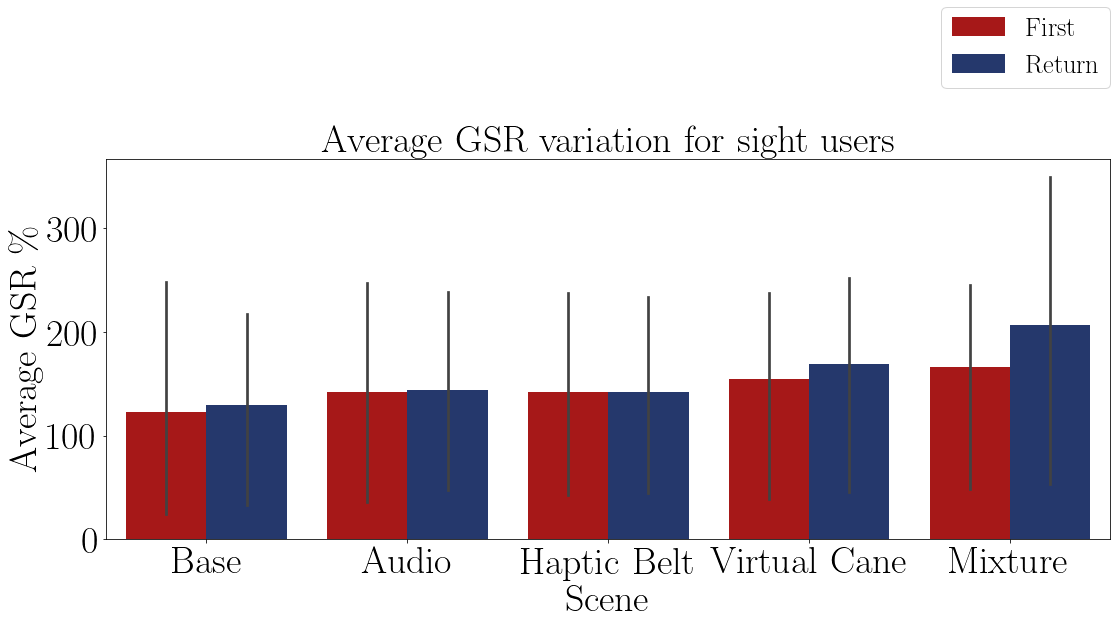

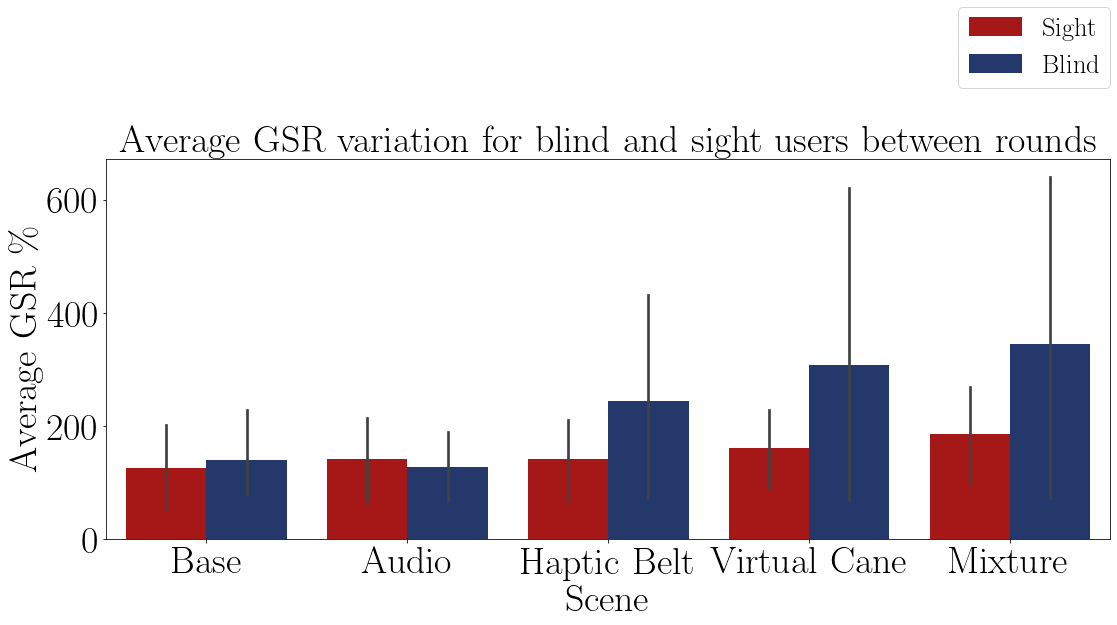

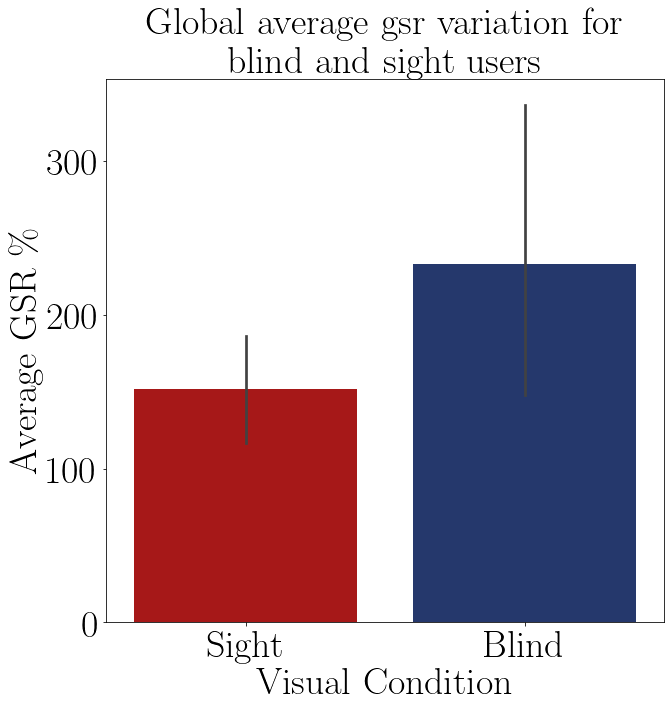

In [ ]:
# Gerar um box plot de todas as médias dos participantes em cada cena
if gerar == True:
    plot = copy.deepcopy(dfGSRMedio_var_cen_par_2).reset_index(level = [1,2])
else:
    plot = copy.deepcopy(dfGSRMedio_var_cen_par).reset_index(level = [1,2])
score = 'average gsr'
Score = 'Average GSR'
teste = 'GSR'
label = 'gsr'

mdMelt = pd.melt(plot.reset_index(),id_vars = ['Participant','Round','Visual Condition'], var_name = 'Scene', value_name = 'Score',ignore_index=True)
mdMelt.set_index('Participant')


plt.figure(figsize = tamanhoBarra5)
sns.barplot(data = mdMelt[mdMelt['Visual Condition'] == 'Blind'], x = 'Scene', y = 'Score', hue = 'Round')
plt.title(Score + ' variation for blind users between rounds')
plt.legend(bbox_to_anchor=(1, 1.4), loc='upper right', borderaxespad=0)
plt.ylabel(Score + ' \%')
plt.savefig(teste + '/Figuras/png/barplot_' + label + '_scene_blind.png',bbox_inches='tight')
plt.savefig(teste + '/Figuras/barplot_' + label + '_scene_blind.pgf',bbox_inches='tight')
plt.show()

plt.figure(figsize = tamanhoBarra5)
sns.barplot(data = mdMelt[mdMelt['Visual Condition'] == 'Sight'], x = 'Scene', y = 'Score', hue = 'Round')
plt.title(Score + ' variation for sight users')
plt.legend(bbox_to_anchor=(1, 1.4), loc='upper right', borderaxespad=0)
plt.ylabel(Score + ' \%')
plt.savefig(teste + '/Figuras/png/barplot_' + label + '_scene_sight.png',bbox_inches='tight')
plt.savefig(teste + '/Figuras/barplot_' + label + '_scene_sight.pgf',bbox_inches='tight')
plt.show()

plt.figure(figsize = tamanhoBarra5)
sns.barplot(data = mdMelt, x = 'Scene', y = 'Score', hue = 'Visual Condition')
plt.title(Score + ' variation for blind and sight users between rounds')
plt.legend(bbox_to_anchor=(1, 1.4), loc='upper right', borderaxespad=0)
plt.ylabel(Score + ' \%')
plt.savefig(teste + '/Figuras/png/barplot_' + label + '_scene.png',bbox_inches='tight')
plt.savefig(teste + '/Figuras/barplot_' + label + '_scene.pgf',bbox_inches='tight')
plt.show()

plt.figure(figsize = tamanhoBarra2)
sns.barplot(data = mdMelt, x = 'Visual Condition', y = 'Score')
plt.title('Global ' + score + ' variation for \n  blind and sight users')
#plt.legend(bbox_to_anchor=(1, 1.4), loc='upper right', borderaxespad=0)
plt.ylabel(Score + ' \%')
plt.savefig(teste + '/Figuras/png/barplot_' + label + '.png',bbox_inches='tight')
plt.savefig(teste + '/Figuras/barplot_' + label + '.pgf',bbox_inches='tight')
plt.show()

### Gráfico de barra da média da demanda mental

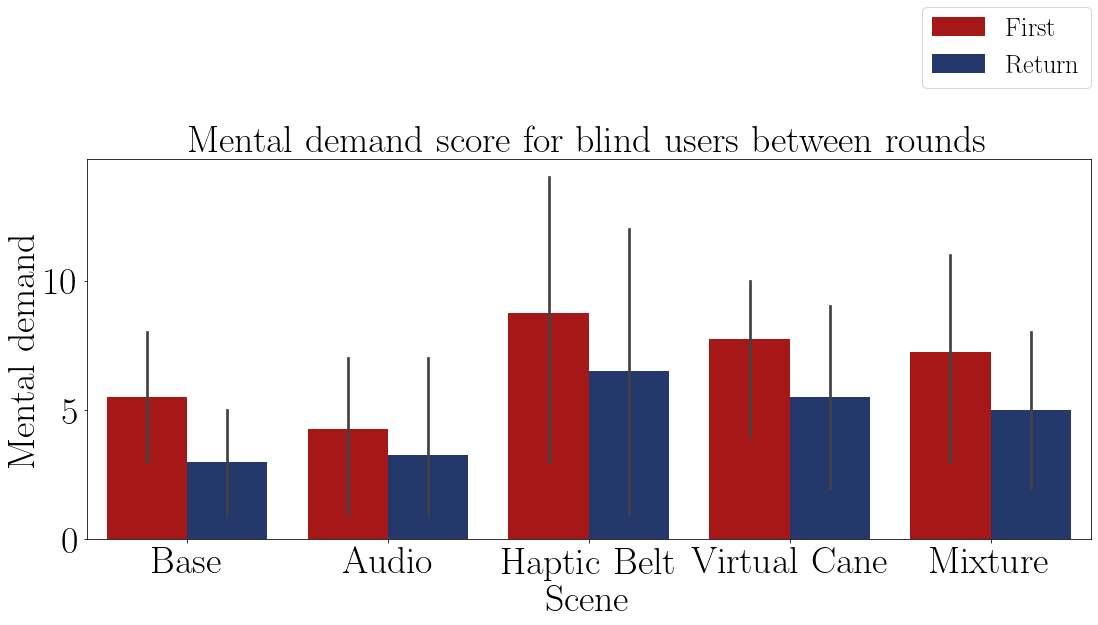

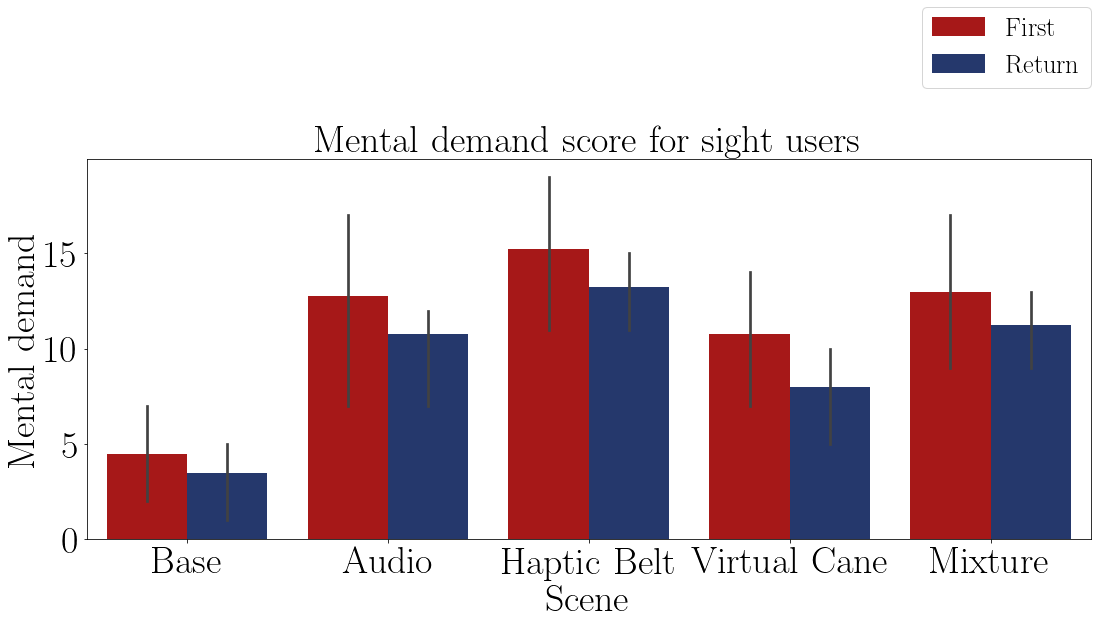

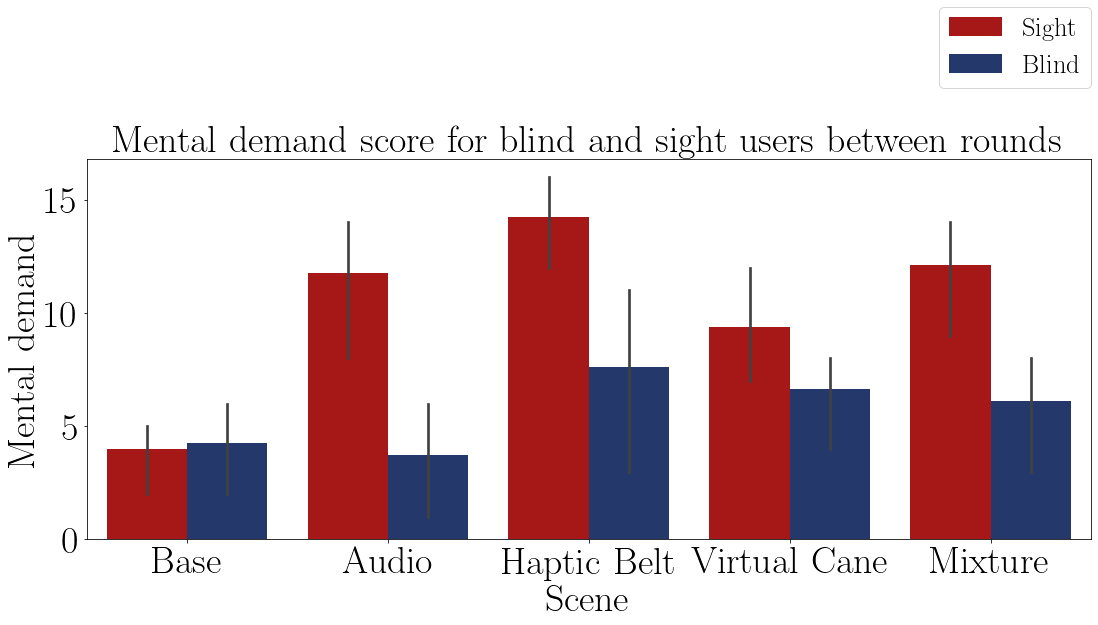

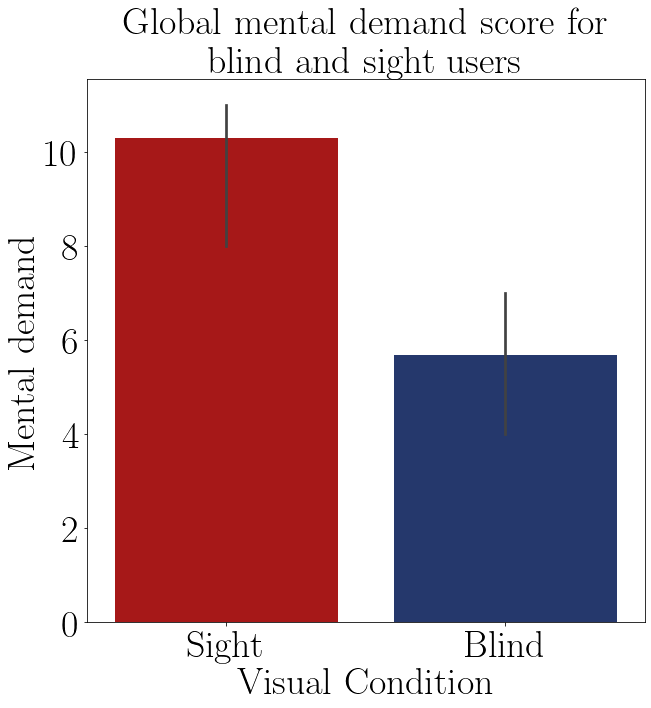

In [ ]:
# Gerar um box plot de todas as médias dos participantes em cada cena
if gerar == True:
    plot = copy.deepcopy(dfMdVariation_2).reset_index(level = [1,2])
else:
    plot = copy.deepcopy(dfMdVariation).reset_index(level = [1,2])
score = 'mental demand'
Score = 'Mental demand'
teste = 'Nasa'
label = 'md_avg'

mdMelt = pd.melt(plot.reset_index(),id_vars = ['Participant','Round','Visual Condition'], var_name = 'Scene', value_name = 'Score',ignore_index=True)
mdMelt.set_index('Participant')

plt.figure(figsize = tamanhoBarra5)
sns.barplot(data = mdMelt[mdMelt['Visual Condition'] == 'Blind'], x = 'Scene', y = 'Score', hue = 'Round')
plt.title(Score + ' score for blind users between rounds')
plt.legend(bbox_to_anchor=(1, 1.4), loc='upper right', borderaxespad=0)
plt.ylabel(Score)
plt.savefig(teste + '/Figuras/png/barplot_' + label + '_scene_blind.png',bbox_inches='tight')
plt.savefig(teste + '/Figuras/barplot_' + label + '_scene_blind.pgf',bbox_inches='tight')
plt.show()

plt.figure(figsize = tamanhoBarra5)
sns.barplot(data = mdMelt[mdMelt['Visual Condition'] == 'Sight'], x = 'Scene', y = 'Score', hue = 'Round')
plt.title(Score + ' score for sight users')
plt.legend(bbox_to_anchor=(1, 1.4), loc='upper right', borderaxespad=0)
plt.ylabel(Score)
plt.savefig(teste + '/Figuras/png/barplot_' + label + '_scene_sight.png',bbox_inches='tight')
plt.savefig(teste + '/Figuras/barplot_' + label + '_scene_sight.pgf',bbox_inches='tight')
plt.show()

plt.figure(figsize = tamanhoBarra5)
sns.barplot(data = mdMelt, x = 'Scene', y = 'Score', hue = 'Visual Condition')
plt.title(Score + ' score for blind and sight users between rounds')
plt.legend(bbox_to_anchor=(1, 1.4), loc='upper right', borderaxespad=0)
plt.ylabel(Score)
plt.savefig(teste + '/Figuras/png/barplot_' + label + '_scene.png',bbox_inches='tight')
plt.savefig(teste + '/Figuras/barplot_' + label + '_scene.pgf',bbox_inches='tight')
plt.show()

plt.figure(figsize = tamanhoBarra2)
sns.barplot(data = mdMelt, x = 'Visual Condition', y = 'Score')
plt.title('Global ' + score + ' score for \n blind and sight users')
#plt.legend(bbox_to_anchor=(1, 1.4), loc='upper right', borderaxespad=0)
plt.ylabel(Score)
plt.savefig(teste + '/Figuras/png/barplot_' + label + '_global.png',bbox_inches='tight')
plt.savefig(teste + '/Figuras/barplot_' + label + '_global.pgf',bbox_inches='tight')
plt.show()

### Gráfico de barra da variação de demanda mental

No handles with labels found to put in legend.


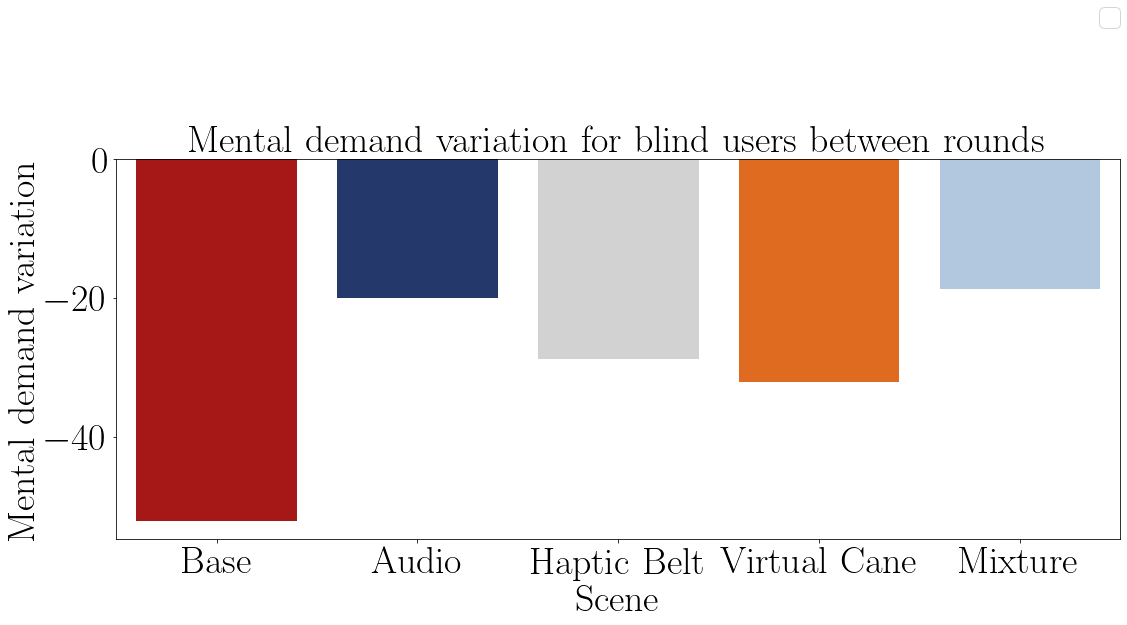

No handles with labels found to put in legend.


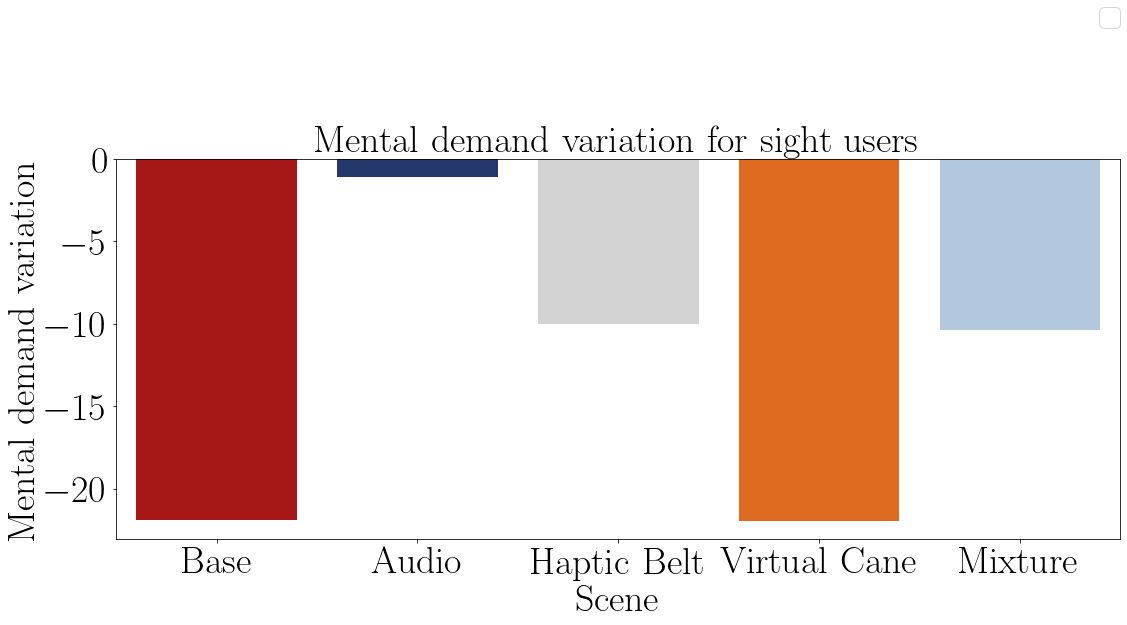

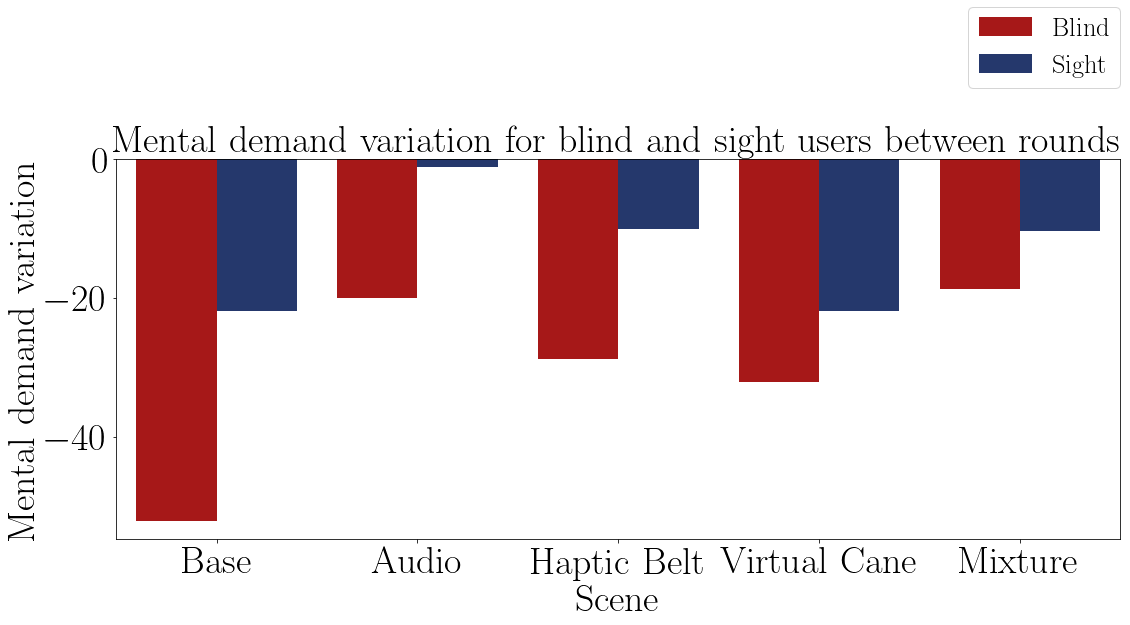

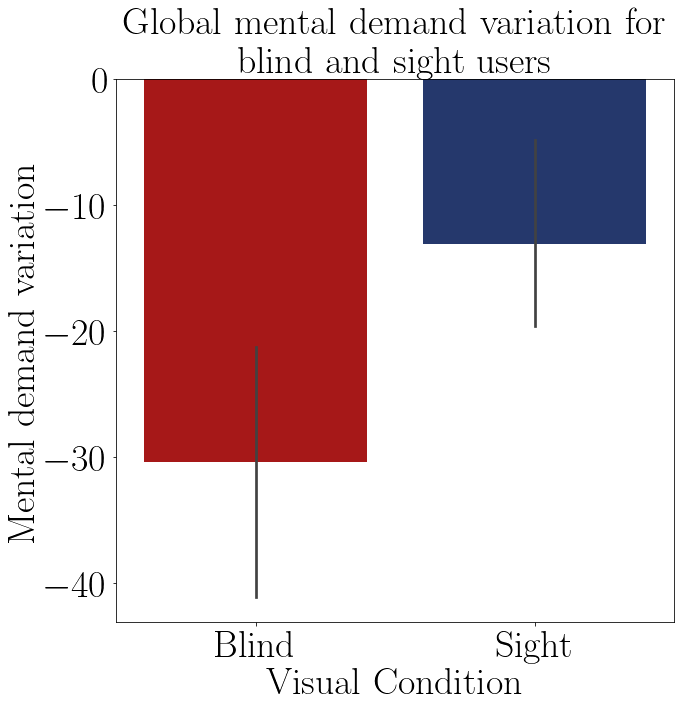

In [ ]:
# Gerar um box plot de todas as médias dos participantes em cada cena
if gerar == True:
    plot = copy.deepcopy(mdNasa_var_cen_def_2)
else:
    plot = copy.deepcopy(mdNasa_var_cen_def)
score = 'mental demand variation'
Score = 'Mental demand variation'
teste = 'Nasa'
label = 'md_var'

mdMelt = pd.melt(plot.reset_index(),id_vars = ['Visual Condition'], var_name = 'Scene', value_name = 'Score',ignore_index=True)
mdMelt.set_index('Visual Condition')

plt.figure(figsize = tamanhoBarra5)
sns.barplot(data = mdMelt[mdMelt['Visual Condition'] == 'Blind'], x = 'Scene', y = 'Score')
plt.title(Score + ' for blind users between rounds')
plt.legend(bbox_to_anchor=(1, 1.4), loc='upper right', borderaxespad=0)
plt.ylabel(Score)
plt.savefig(teste + '/Figuras/png/barplot_' + label + '_scene_blind.png',bbox_inches='tight')
plt.savefig(teste + '/Figuras/barplot_' + label + '_scene_blind.pgf',bbox_inches='tight')
plt.show()

plt.figure(figsize = tamanhoBarra5)
sns.barplot(data = mdMelt[mdMelt['Visual Condition'] == 'Sight'], x = 'Scene', y = 'Score')
plt.title(Score + ' for sight users')
plt.legend(bbox_to_anchor=(1, 1.4), loc='upper right', borderaxespad=0)
plt.ylabel(Score)
plt.savefig(teste + '/Figuras/png/barplot_' + label + '_scene_sight.png',bbox_inches='tight')
plt.savefig(teste + '/Figuras/barplot_' + label + '_scene_sight.pgf',bbox_inches='tight')
plt.show()

plt.figure(figsize = tamanhoBarra5)
sns.barplot(data = mdMelt, x = 'Scene', y = 'Score', hue = 'Visual Condition')
plt.title(Score + ' for blind and sight users between rounds')
plt.legend(bbox_to_anchor=(1, 1.4), loc='upper right', borderaxespad=0)
plt.ylabel(Score)
plt.savefig(teste + '/Figuras/png/barplot_' + label + '_scene.png',bbox_inches='tight')
plt.savefig(teste + '/Figuras/barplot_' + label + '_scene.pgf',bbox_inches='tight')
plt.show()

plt.figure(figsize = tamanhoBarra2)
sns.barplot(data = mdMelt, x = 'Visual Condition', y = 'Score')
plt.title('Global ' + score + ' for \n  blind and sight users')
#plt.legend(bbox_to_anchor=(1, 1.4), loc='upper right', borderaxespad=0)
plt.ylabel(Score)
plt.savefig(teste + '/Figuras/png/barplot_' + label + '_global.png',bbox_inches='tight')
plt.savefig(teste + '/Figuras/barplot_' + label + '_global.pgf',bbox_inches='tight')
plt.show()

### Gráfico de barra da média da carga mental

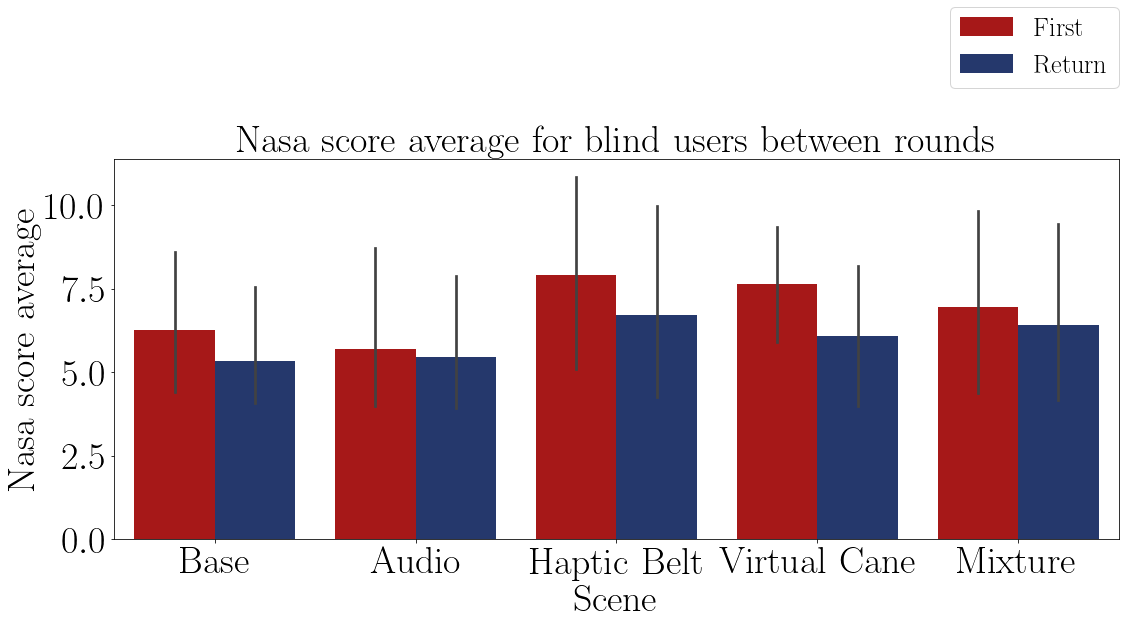

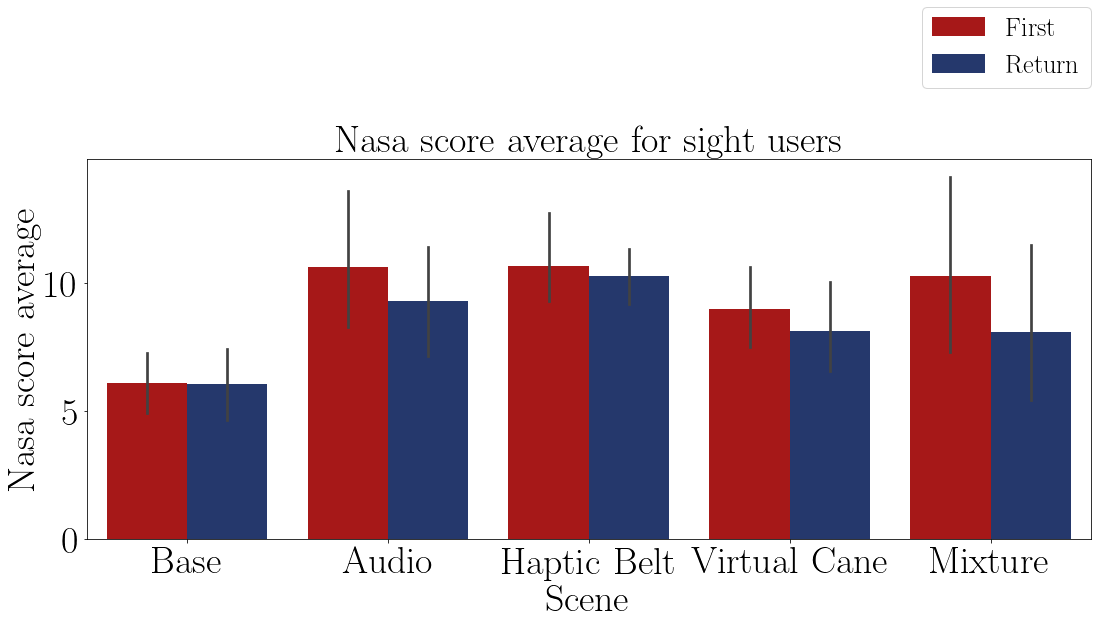

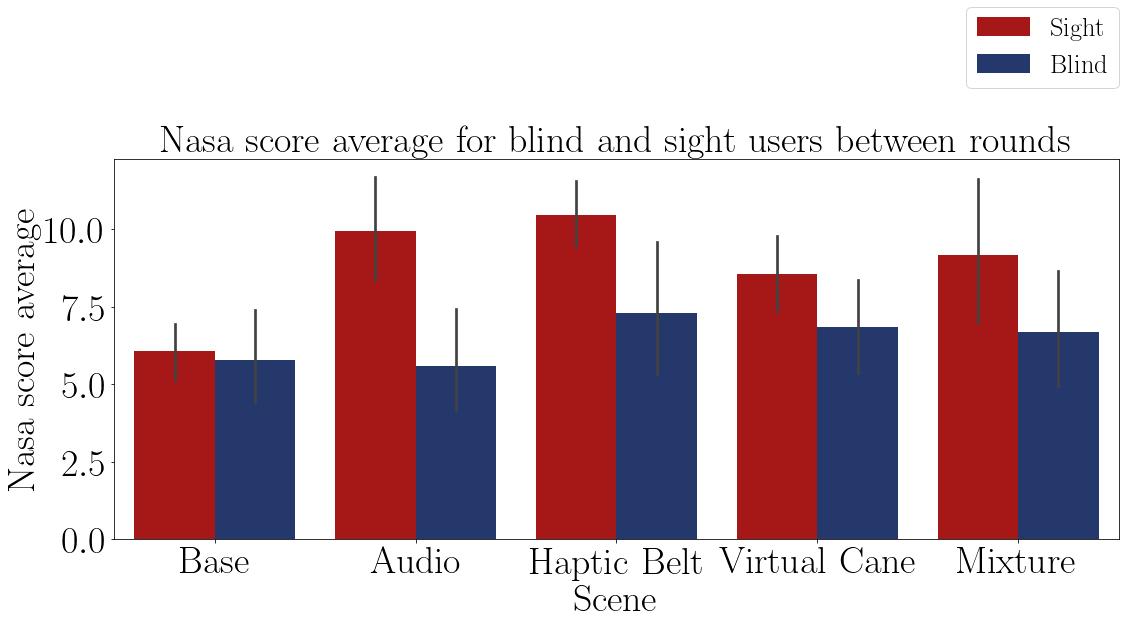

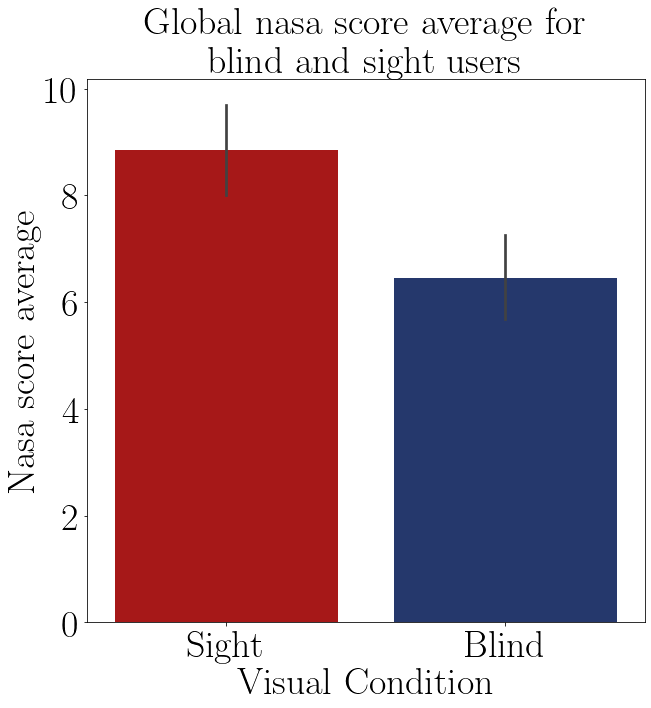

In [ ]:
# Gerar um box plot de todas as médias dos participantes em cada cena
if gerar == True:
    plot = copy.deepcopy(dfCmVariation_2).reset_index(level = [1,2])
else:
    plot = copy.deepcopy(dfCmVariation).reset_index(level = [1,2])
score = 'nasa score average'
Score = 'Nasa score average'
teste = 'Nasa'
label = 'nasa_avg'

mdMelt = pd.melt(plot.reset_index(),id_vars = ['Participant','Round','Visual Condition'], var_name = 'Scene', value_name = 'Score',ignore_index=True)
mdMelt.set_index('Participant')

plt.figure(figsize = tamanhoBarra5)
sns.barplot(data = mdMelt[mdMelt['Visual Condition'] == 'Blind'], x = 'Scene', y = 'Score', hue = 'Round')
plt.title(Score + ' for blind users between rounds')
plt.legend(bbox_to_anchor=(1, 1.4), loc='upper right', borderaxespad=0)
plt.ylabel(Score)
plt.savefig(teste + '/Figuras/png/barplot_' + label + '_scene_blind.png',bbox_inches='tight')
plt.savefig(teste + '/Figuras/barplot_' + label + '_scene_blind.pgf',bbox_inches='tight')
plt.show()

plt.figure(figsize = tamanhoBarra5)
sns.barplot(data = mdMelt[mdMelt['Visual Condition'] == 'Sight'], x = 'Scene', y = 'Score', hue = 'Round')
plt.title(Score + ' for sight users')
plt.legend(bbox_to_anchor=(1, 1.4), loc='upper right', borderaxespad=0)
plt.ylabel(Score)
plt.savefig(teste + '/Figuras/png/barplot_' + label + '_scene_sight.png',bbox_inches='tight')
plt.savefig(teste + '/Figuras/barplot_' + label + '_scene_sight.pgf',bbox_inches='tight')
plt.show()

plt.figure(figsize = tamanhoBarra5)
sns.barplot(data = mdMelt, x = 'Scene', y = 'Score', hue = 'Visual Condition')
plt.title(Score + ' for blind and sight users between rounds')
plt.legend(bbox_to_anchor=(1, 1.4), loc='upper right', borderaxespad=0)
plt.ylabel(Score)
plt.savefig(teste + '/Figuras/png/barplot_' + label + '_scene.png',bbox_inches='tight')
plt.savefig(teste + '/Figuras/barplot_' + label + '_scene.pgf',bbox_inches='tight')
plt.show()

plt.figure(figsize = tamanhoBarra2)
sns.barplot(data = mdMelt, x = 'Visual Condition', y = 'Score')
plt.title('Global ' + score + ' for \n blind and sight users')
#plt.legend(bbox_to_anchor=(1, 1.4), loc='upper right', borderaxespad=0)
plt.ylabel(Score)
plt.savefig(teste + '/Figuras/png/barplot_' + label + '_global.png',bbox_inches='tight')
plt.savefig(teste + '/Figuras/barplot_' + label + '_global.pgf',bbox_inches='tight')
plt.show()

### Gráfico de barra da variação da carga mental

No handles with labels found to put in legend.


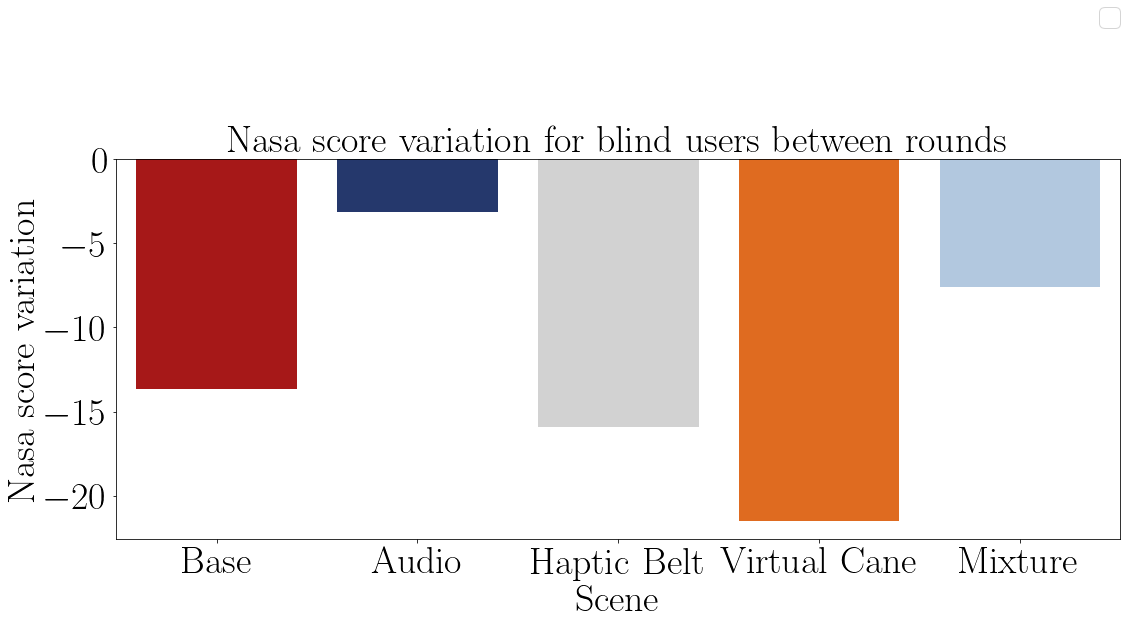

No handles with labels found to put in legend.


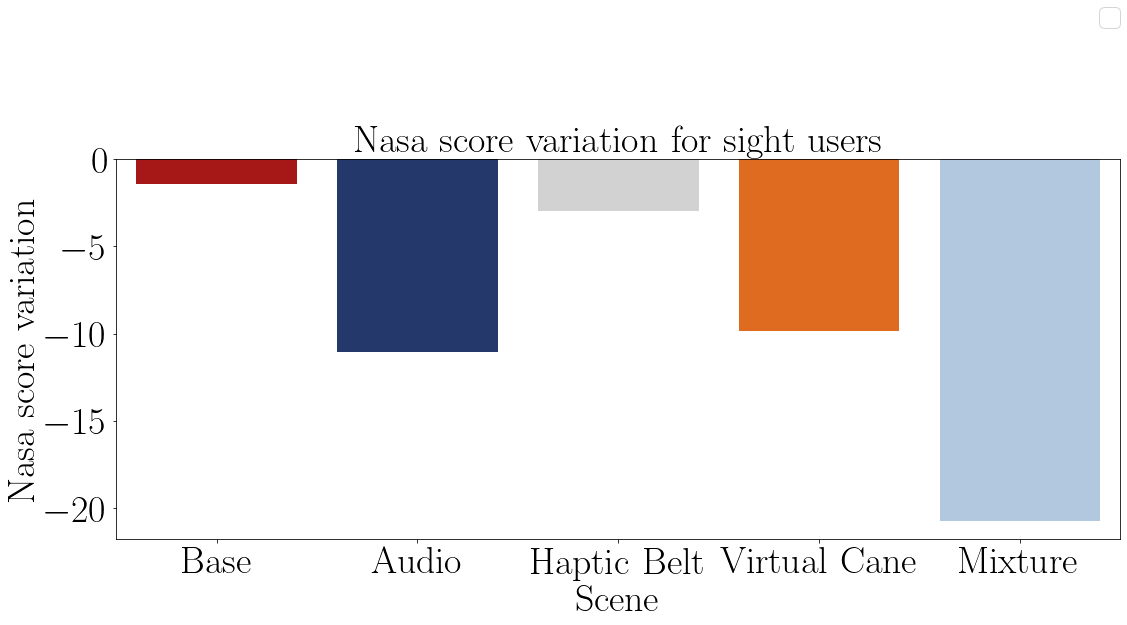

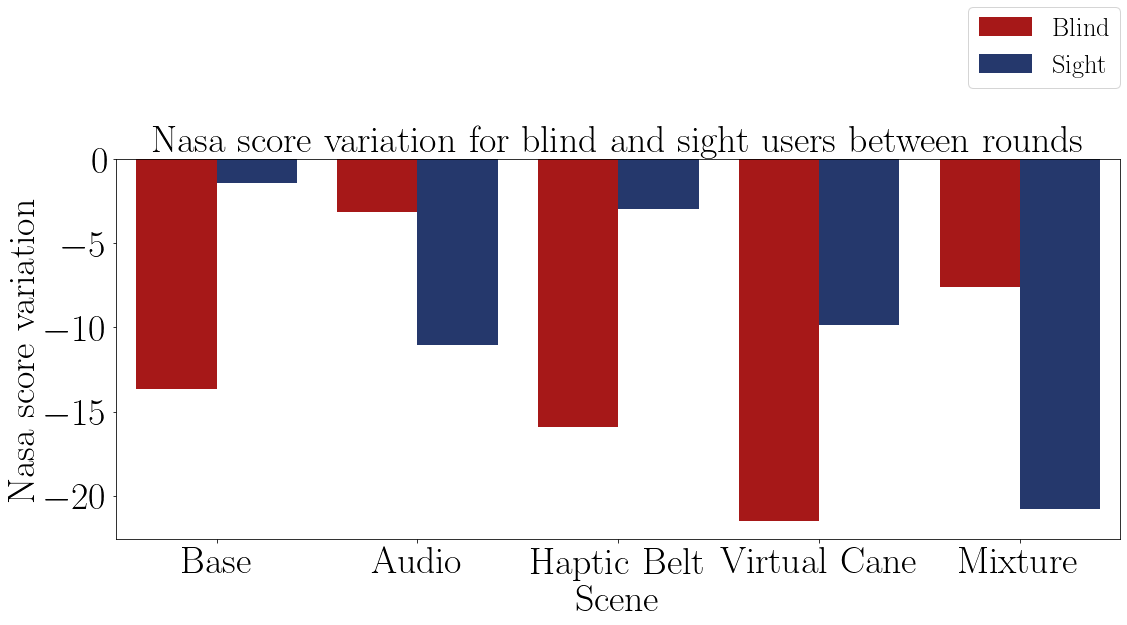

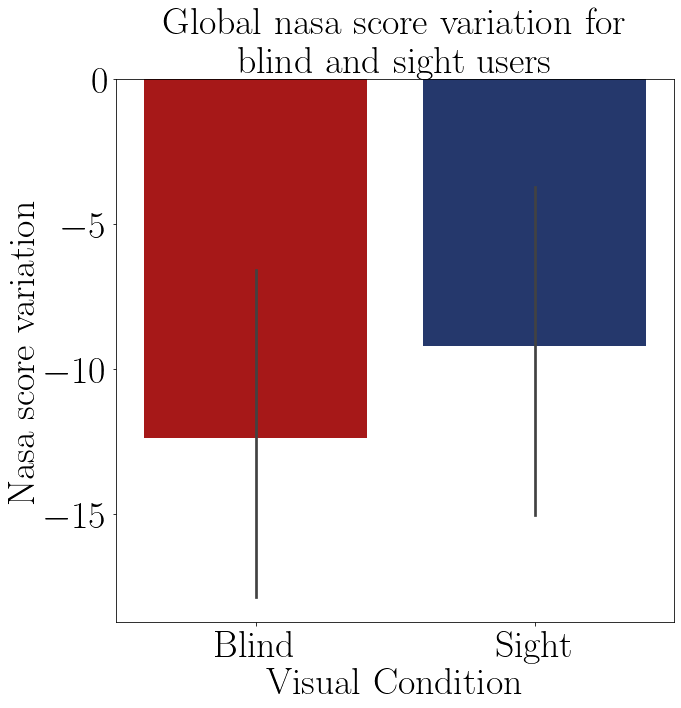

In [ ]:
# Gerar um box plot de todas as médias dos participantes em cada cena
if gerar == True:
    plot = copy.deepcopy(cmNasa_var_cen_def_2)
else:
    plot = copy.deepcopy(cmNasa_var_cen_def)
score = 'nasa score variation'
Score = 'Nasa score variation'
teste = 'Nasa'
label = 'nasa_var'

mdMelt = pd.melt(plot.reset_index(),id_vars = ['Visual Condition'], var_name = 'Scene', value_name = 'Score',ignore_index=True)
mdMelt.set_index('Visual Condition')

plt.figure(figsize = tamanhoBarra5)
sns.barplot(data = mdMelt[mdMelt['Visual Condition'] == 'Blind'], x = 'Scene', y = 'Score')
plt.title(Score + ' for blind users between rounds')
plt.legend(bbox_to_anchor=(1, 1.4), loc='upper right', borderaxespad=0)
plt.ylabel(Score)
plt.savefig(teste + '/Figuras/png/barplot_' + label + '_scene_blind.png',bbox_inches='tight')
plt.savefig(teste + '/Figuras/barplot_' + label + '_scene_blind.pgf',bbox_inches='tight')
plt.show()

plt.figure(figsize = tamanhoBarra5)
sns.barplot(data = mdMelt[mdMelt['Visual Condition'] == 'Sight'], x = 'Scene', y = 'Score')
plt.title(Score + ' for sight users')
plt.legend(bbox_to_anchor=(1, 1.4), loc='upper right', borderaxespad=0)
plt.ylabel(Score)
plt.savefig(teste + '/Figuras/png/barplot_' + label + '_scene_sight.png',bbox_inches='tight')
plt.savefig(teste + '/Figuras/barplot_' + label + '_scene_sight.pgf',bbox_inches='tight')
plt.show()

plt.figure(figsize = tamanhoBarra5)
sns.barplot(data = mdMelt, x = 'Scene', y = 'Score', hue = 'Visual Condition')
plt.title(Score + ' for blind and sight users between rounds')
plt.legend(bbox_to_anchor=(1, 1.4), loc='upper right', borderaxespad=0)
plt.ylabel(Score)
plt.savefig(teste + '/Figuras/png/barplot_' + label + '_scene.png',bbox_inches='tight')
plt.savefig(teste + '/Figuras/barplot_' + label + '_scene.pgf',bbox_inches='tight')
plt.show()

plt.figure(figsize = tamanhoBarra2)
sns.barplot(data = mdMelt, x = 'Visual Condition', y = 'Score')
plt.title('Global ' + score + ' for \n  blind and sight users')
#plt.legend(bbox_to_anchor=(1, 1.4), loc='upper right', borderaxespad=0)
plt.ylabel(Score)
plt.savefig(teste + '/Figuras/png/barplot_' + label + '_global.png',bbox_inches='tight')
plt.savefig(teste + '/Figuras/barplot_' + label + '_global.pgf',bbox_inches='tight')
plt.show()

### Gráfico de barra da média da pontuação do Sagat

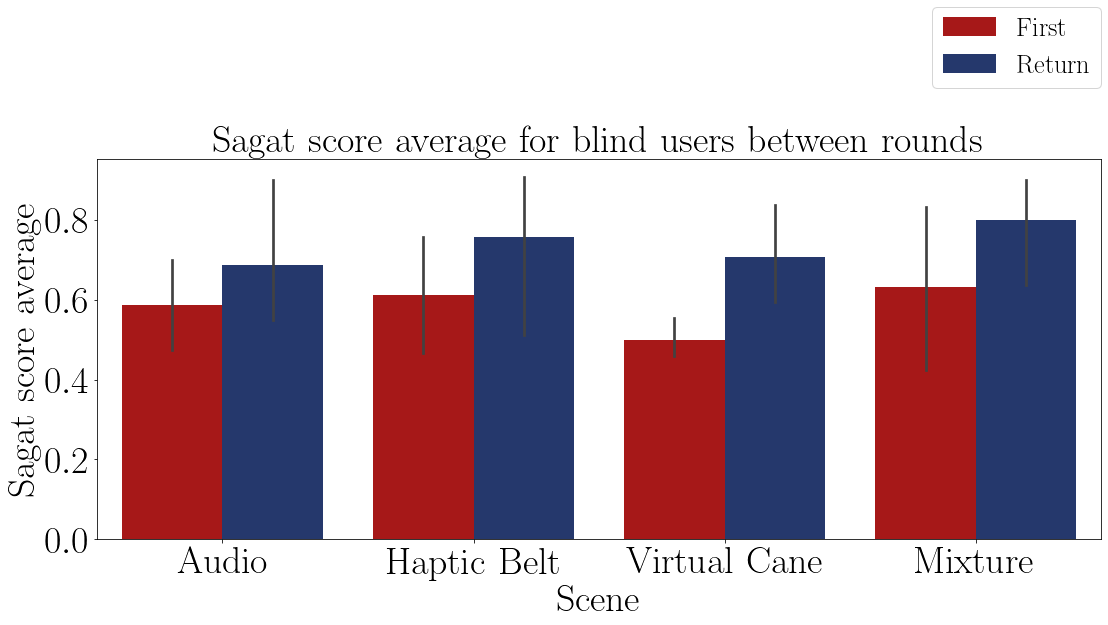

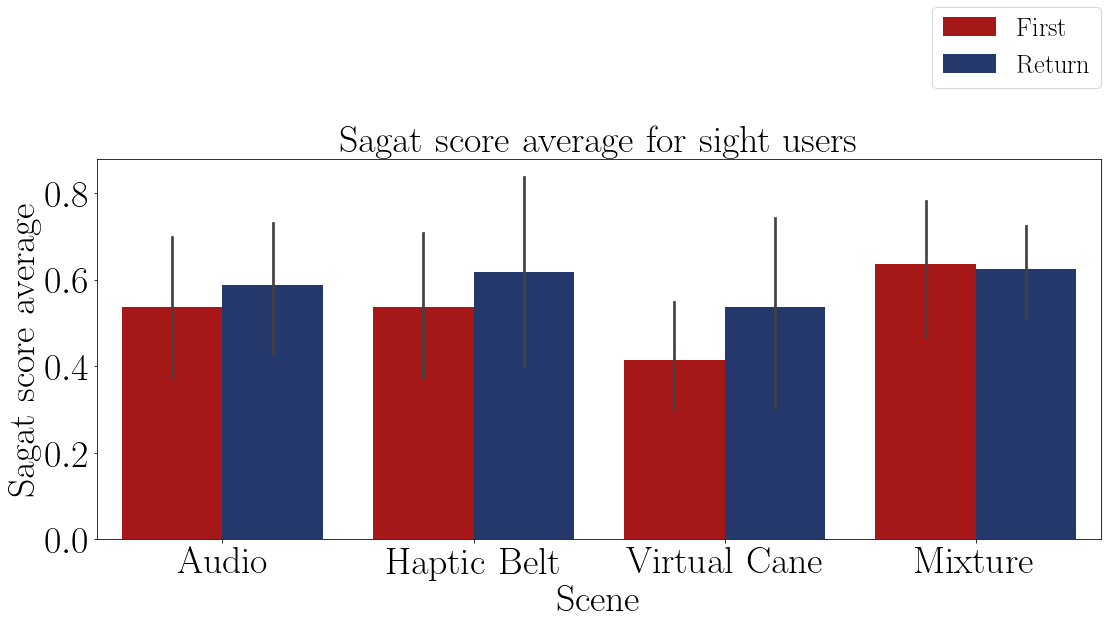

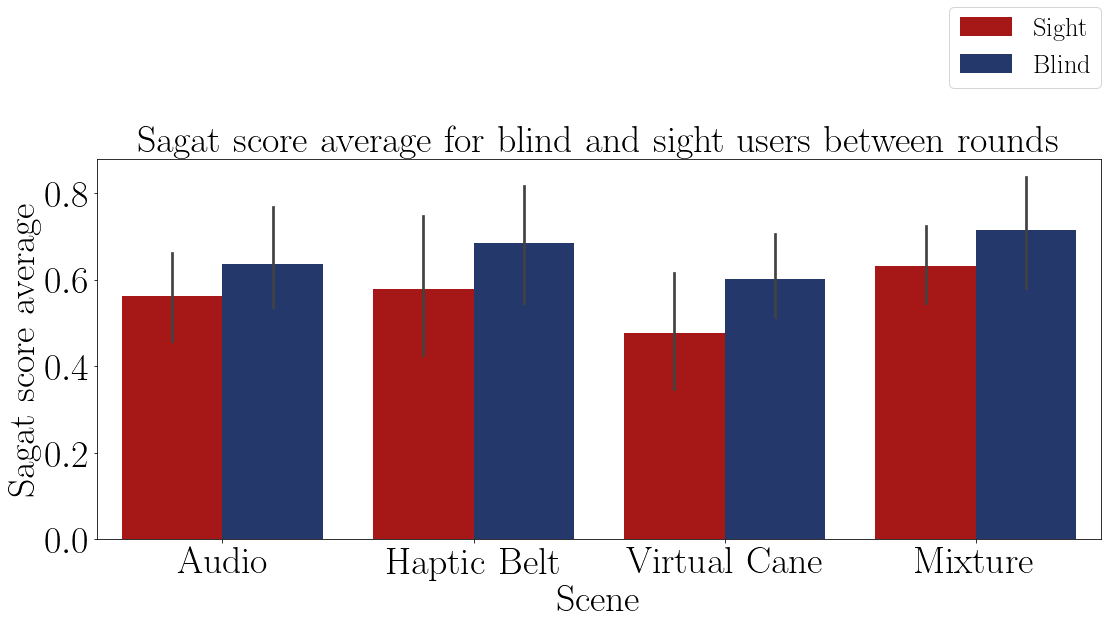

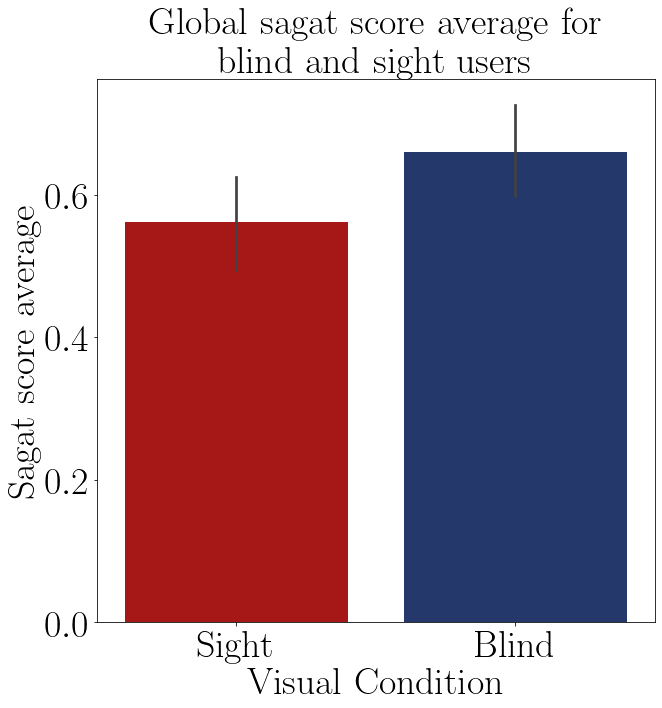

In [ ]:
# Gerar um box plot de todas as médias dos participantes em cada cena
if gerar == True:
    plot = copy.deepcopy(dfSaVariation_2.drop('Base',axis =1).reset_index(level = [1,2]))
else:
    plot = copy.deepcopy(dfSaVariation.drop('Base',axis =1)).reset_index(level = [1,2])
score = 'sagat score average'
Score = 'Sagat score average'
teste = 'Sagat'
label = 'sagat_avg'

mdMelt = pd.melt(plot.reset_index(),id_vars = ['Participant','Round','Visual Condition'], var_name = 'Scene', value_name = 'Score',ignore_index=True)
mdMelt.set_index('Participant')

plt.figure(figsize = tamanhoBarra5)
sns.barplot(data = mdMelt[mdMelt['Visual Condition'] == 'Blind'], x = 'Scene', y = 'Score', hue = 'Round')
plt.title(Score + ' for blind users between rounds')
plt.legend(bbox_to_anchor=(1, 1.4), loc='upper right', borderaxespad=0)
plt.ylabel(Score)
plt.savefig(teste + '/Figuras/png/barplot_' + label + '_scene_blind.png',bbox_inches='tight')
plt.savefig(teste + '/Figuras/barplot_' + label + '_scene_blind.pgf',bbox_inches='tight')
plt.show()

plt.figure(figsize = tamanhoBarra5)
sns.barplot(data = mdMelt[mdMelt['Visual Condition'] == 'Sight'], x = 'Scene', y = 'Score', hue = 'Round')
plt.title(Score + ' for sight users')
plt.legend(bbox_to_anchor=(1, 1.4), loc='upper right', borderaxespad=0)
plt.ylabel(Score)
plt.savefig(teste + '/Figuras/png/barplot_' + label + '_scene_sight.png',bbox_inches='tight')
plt.savefig(teste + '/Figuras/barplot_' + label + '_scene_sight.pgf',bbox_inches='tight')
plt.show()

plt.figure(figsize = tamanhoBarra5)
sns.barplot(data = mdMelt, x = 'Scene', y = 'Score', hue = 'Visual Condition')
plt.title(Score + ' for blind and sight users between rounds')
plt.legend(bbox_to_anchor=(1, 1.4), loc='upper right', borderaxespad=0)
plt.ylabel(Score)
plt.savefig(teste + '/Figuras/png/barplot_' + label + '_scene.png',bbox_inches='tight')
plt.savefig(teste + '/Figuras/barplot_' + label + '_scene.pgf',bbox_inches='tight')
plt.show()

plt.figure(figsize = tamanhoBarra2)
sns.barplot(data = mdMelt, x = 'Visual Condition', y = 'Score')
plt.title('Global ' + score + ' for \n  blind and sight users')
#plt.legend(bbox_to_anchor=(1, 1.4), loc='upper right', borderaxespad=0)
plt.ylabel(Score)
plt.savefig(teste + '/Figuras/png/barplot_' + label + '_global.png',bbox_inches='tight')
plt.savefig(teste + '/Figuras/barplot_' + label + '_global.pgf',bbox_inches='tight')
plt.show()

### Gráfico de barra da variação da pontuação do Sagat

No handles with labels found to put in legend.


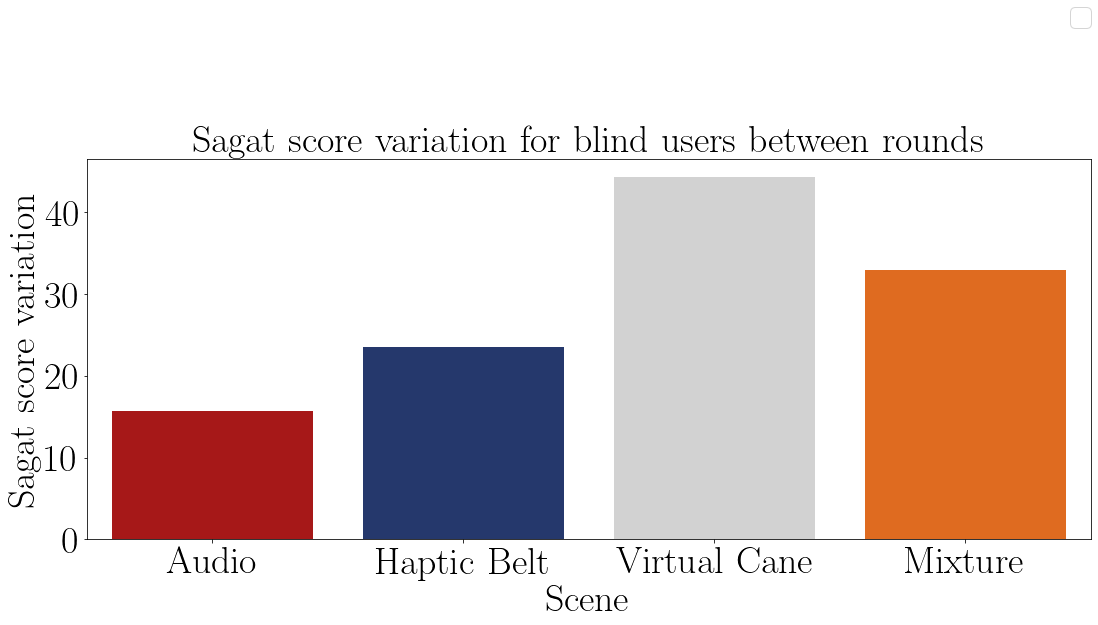

No handles with labels found to put in legend.


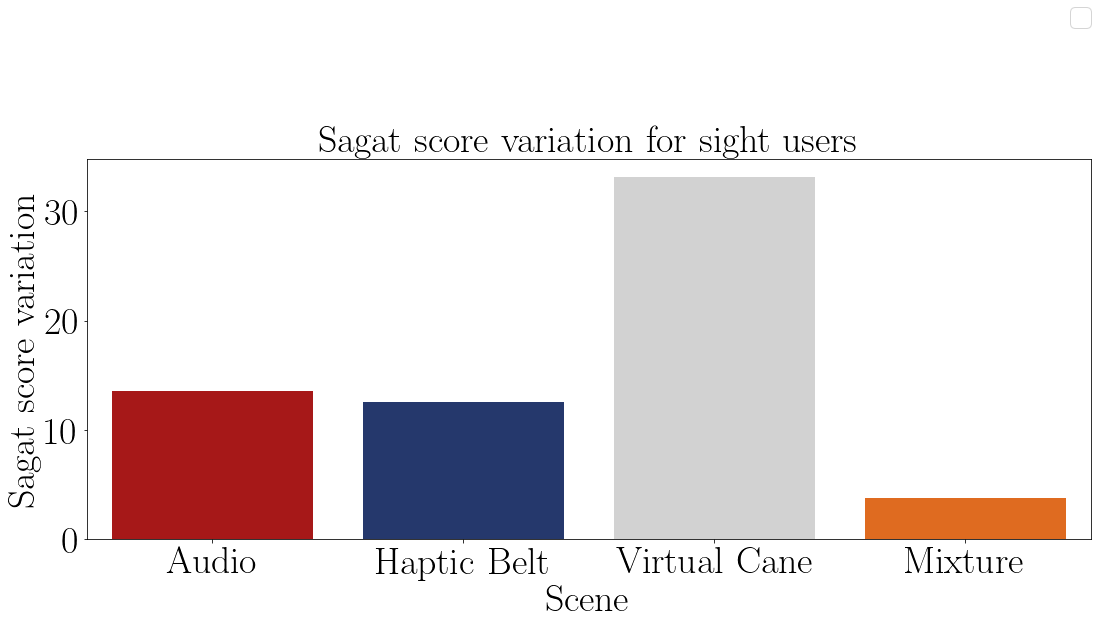

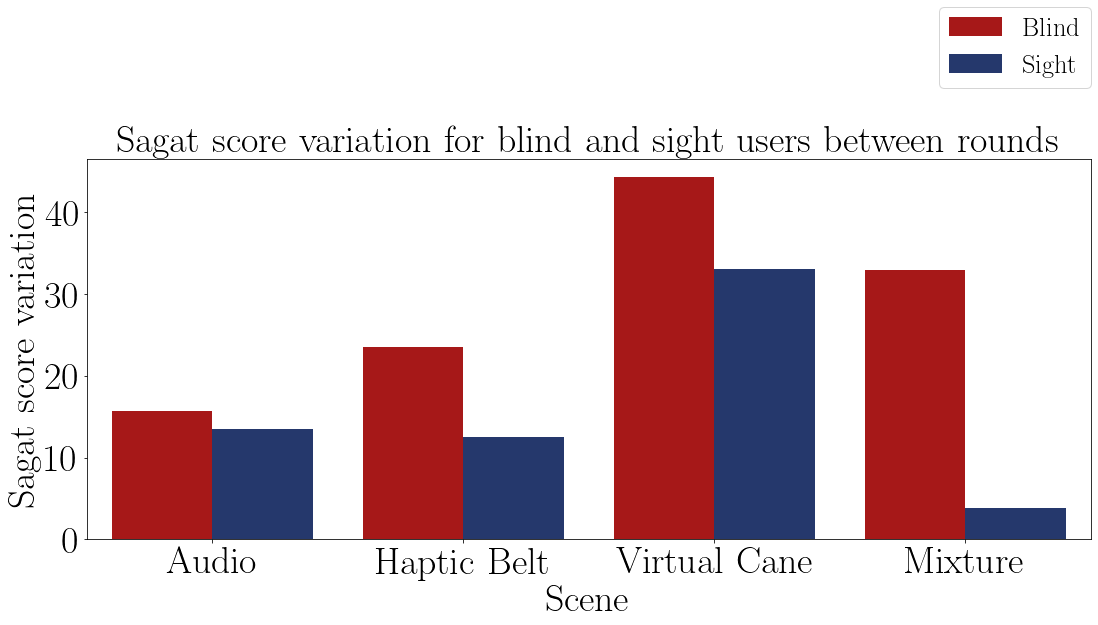

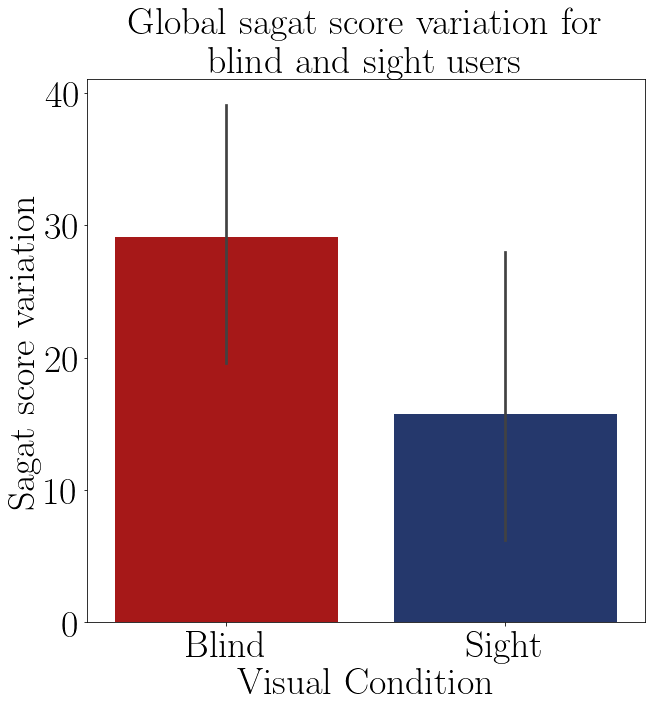

In [ ]:
# Gerar um box plot de todas as médias dos participantes em cada cena
if gerar == True:
    plot = copy.deepcopy(saSagat_var_cen_def.drop('Base',axis =1))
else:
    plot = copy.deepcopy(saSagat_var_cen_def.drop('Base',axis =1))
score = 'sagat score variation'
Score = 'Sagat score variation'
teste = 'Sagat'
label = 'sagat_var'

mdMelt = pd.melt(plot.reset_index(),id_vars = ['Visual Condition'], var_name = 'Scene', value_name = 'Score',ignore_index=True)
mdMelt.set_index('Visual Condition')

plt.figure(figsize = tamanhoBarra5)
sns.barplot(data = mdMelt[mdMelt['Visual Condition'] == 'Blind'], x = 'Scene', y = 'Score')
plt.title(Score + ' for blind users between rounds')
plt.legend(bbox_to_anchor=(1, 1.4), loc='upper right', borderaxespad=0)
plt.ylabel(Score)
plt.savefig(teste + '/Figuras/png/barplot_' + label + '_scene_blind.png',bbox_inches='tight')
plt.savefig(teste + '/Figuras/barplot_' + label + '_scene_blind.pgf',bbox_inches='tight')
plt.show()

plt.figure(figsize = tamanhoBarra5)
sns.barplot(data = mdMelt[mdMelt['Visual Condition'] == 'Sight'], x = 'Scene', y = 'Score')
plt.title(Score + ' for sight users')
plt.legend(bbox_to_anchor=(1, 1.4), loc='upper right', borderaxespad=0)
plt.ylabel(Score)
plt.savefig(teste + '/Figuras/png/barplot_' + label + '_scene_sight.png',bbox_inches='tight')
plt.savefig(teste + '/Figuras/barplot_' + label + '_scene_sight.pgf',bbox_inches='tight')
plt.show()

plt.figure(figsize = tamanhoBarra5)
sns.barplot(data = mdMelt, x = 'Scene', y = 'Score', hue = 'Visual Condition')
plt.title(Score + ' for blind and sight users between rounds')
plt.legend(bbox_to_anchor=(1, 1.4), loc='upper right', borderaxespad=0)
plt.ylabel(Score)
plt.savefig(teste + '/Figuras/png/barplot_' + label + '_scene.png',bbox_inches='tight')
plt.savefig(teste + '/Figuras/barplot_' + label + '_scene.pgf',bbox_inches='tight')
plt.show()

plt.figure(figsize = tamanhoBarra2)
sns.barplot(data = mdMelt, x = 'Visual Condition', y = 'Score')
plt.title('Global ' + score + ' for \n blind and sight users')
#plt.legend(bbox_to_anchor=(1, 1.4), loc='upper right', borderaxespad=0)
plt.ylabel(Score)
plt.savefig(teste + '/Figuras/png/barplot_' + label + '_global.png',bbox_inches='tight')
plt.savefig(teste + '/Figuras/barplot_' + label + '_global.pgf',bbox_inches='tight')
plt.show()

### Gráfico de barra da variação do tempo dos participantes

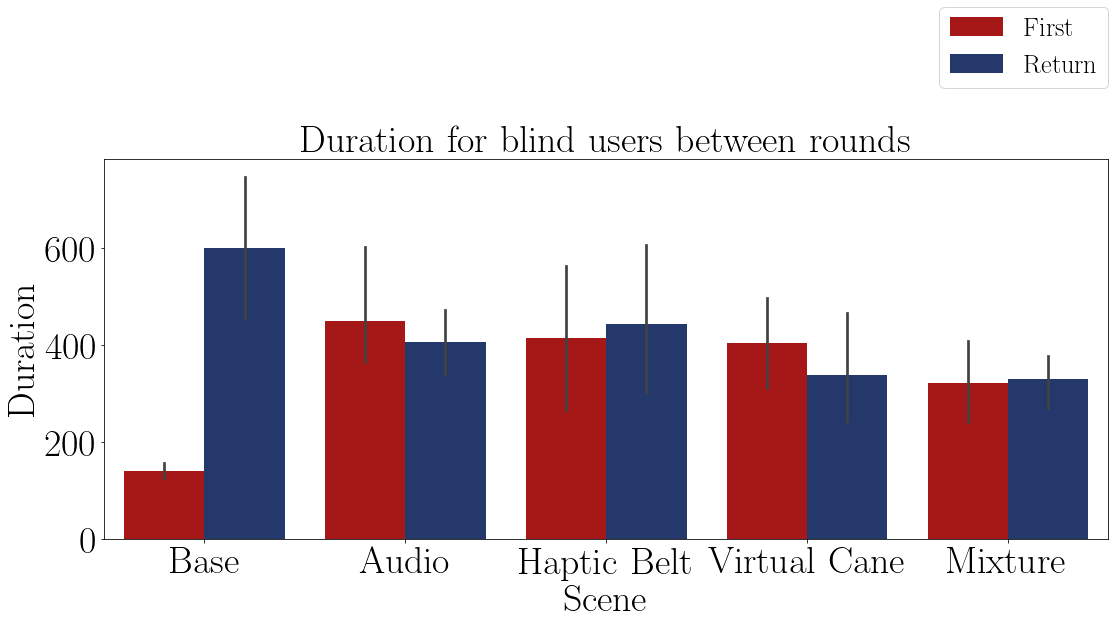

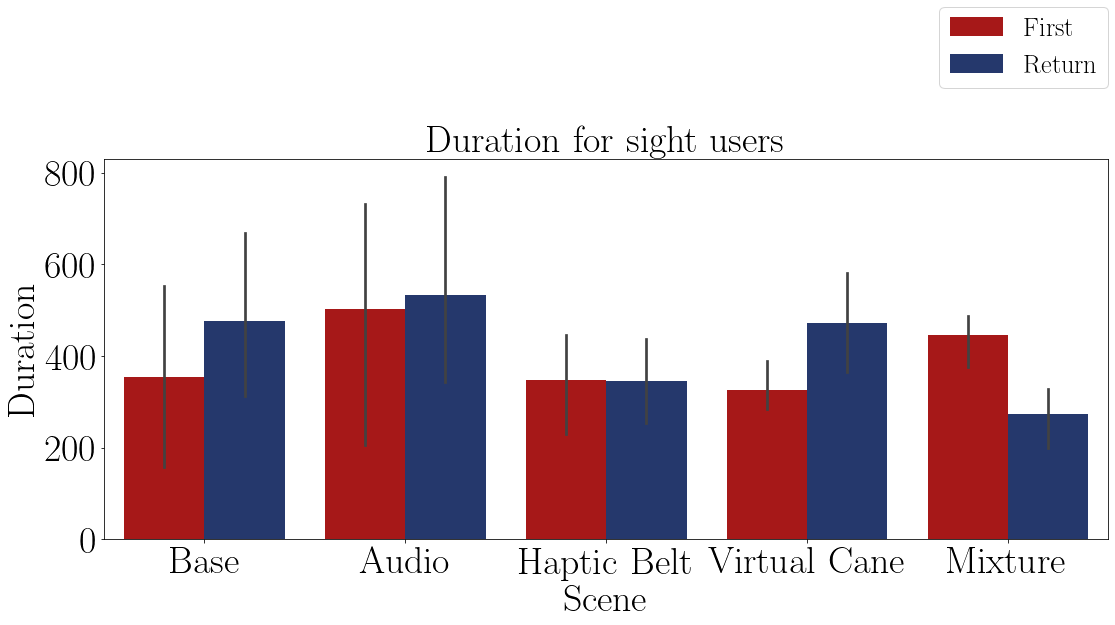

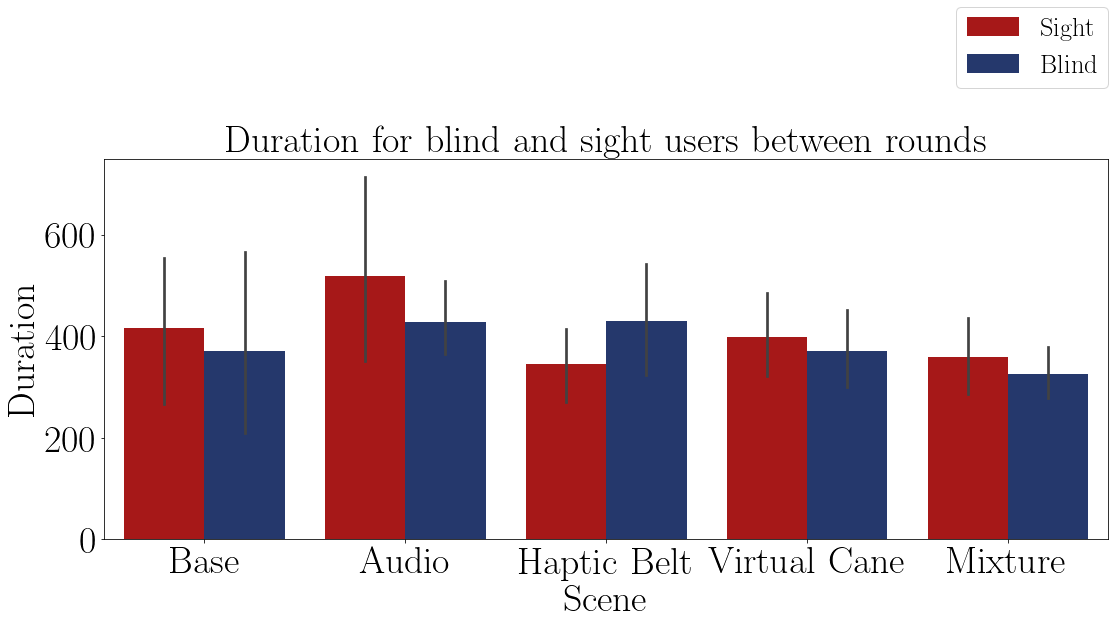

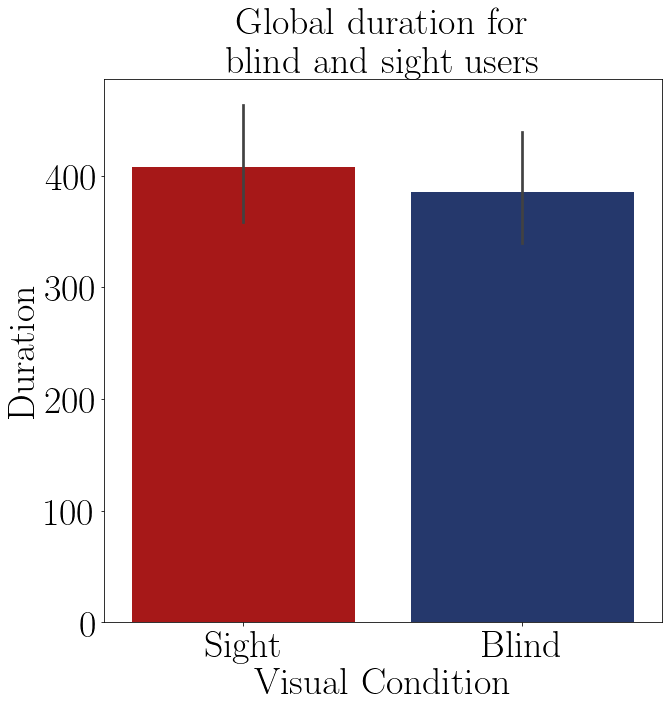

In [ ]:
# Gerar um box plot de todas as médias dos participantes em cada cena
if gerar == True:
    plot = copy.deepcopy(dfTVariation_2.reset_index(level = [1,2]))
else:
    plot = copy.deepcopy(dfTVariation.reset_index(level = [1,2]))
score = 'duration'
Score = 'Duration'
teste = 'Tempo'
label = 'duration'

mdMelt = pd.melt(plot.reset_index(),id_vars = ['Participant','Round','Visual Condition'], var_name = 'Scene', value_name = 'Score',ignore_index=True)
mdMelt.set_index('Participant')

plt.figure(figsize = tamanhoBarra5)
sns.barplot(data = mdMelt[mdMelt['Visual Condition'] == 'Blind'], x = 'Scene', y = 'Score', hue = 'Round')
plt.title(Score + ' for blind users between rounds')
plt.legend(bbox_to_anchor=(1, 1.4), loc='upper right', borderaxespad=0)
plt.ylabel(Score)
plt.savefig(teste + '/Figuras/png/barplot_' + label + '_scene_blind.png',bbox_inches='tight')
plt.savefig(teste + '/Figuras/barplot_' + label + '_scene_blind.pgf',bbox_inches='tight')
plt.show()

plt.figure(figsize = tamanhoBarra5)
sns.barplot(data = mdMelt[mdMelt['Visual Condition'] == 'Sight'], x = 'Scene', y = 'Score', hue = 'Round')
plt.title(Score + ' for sight users')
plt.legend(bbox_to_anchor=(1, 1.4), loc='upper right', borderaxespad=0)
plt.ylabel(Score)
plt.savefig(teste + '/Figuras/png/barplot_' + label + '_scene_sight.png',bbox_inches='tight')
plt.savefig(teste + '/Figuras/barplot_' + label + '_scene_sight.pgf',bbox_inches='tight')
plt.show()

plt.figure(figsize = tamanhoBarra5)
sns.barplot(data = mdMelt, x = 'Scene', y = 'Score', hue = 'Visual Condition')
plt.title(Score + ' for blind and sight users between rounds')
plt.legend(bbox_to_anchor=(1, 1.4), loc='upper right', borderaxespad=0)
plt.ylabel(Score)
plt.savefig(teste + '/Figuras/png/barplot_' + label + '_scene.png',bbox_inches='tight')
plt.savefig(teste + '/Figuras/barplot_' + label + '_scene.pgf',bbox_inches='tight')
plt.show()

plt.figure(figsize = tamanhoBarra2)
sns.barplot(data = mdMelt, x = 'Visual Condition', y = 'Score')
plt.title('Global ' + score + ' for\nblind and sight users')
#plt.legend(bbox_to_anchor=(1, 1.4), loc='upper right', borderaxespad=0)
plt.ylabel(Score)
plt.savefig(teste + '/Figuras/png/barplot_' + label + '_global.png',bbox_inches='tight')
plt.savefig(teste + '/Figuras/barplot_' + label + '_global.pgf',bbox_inches='tight')
plt.show()

### Gráfico de barra da média da pontuação dos questionários

No handles with labels found to put in legend.


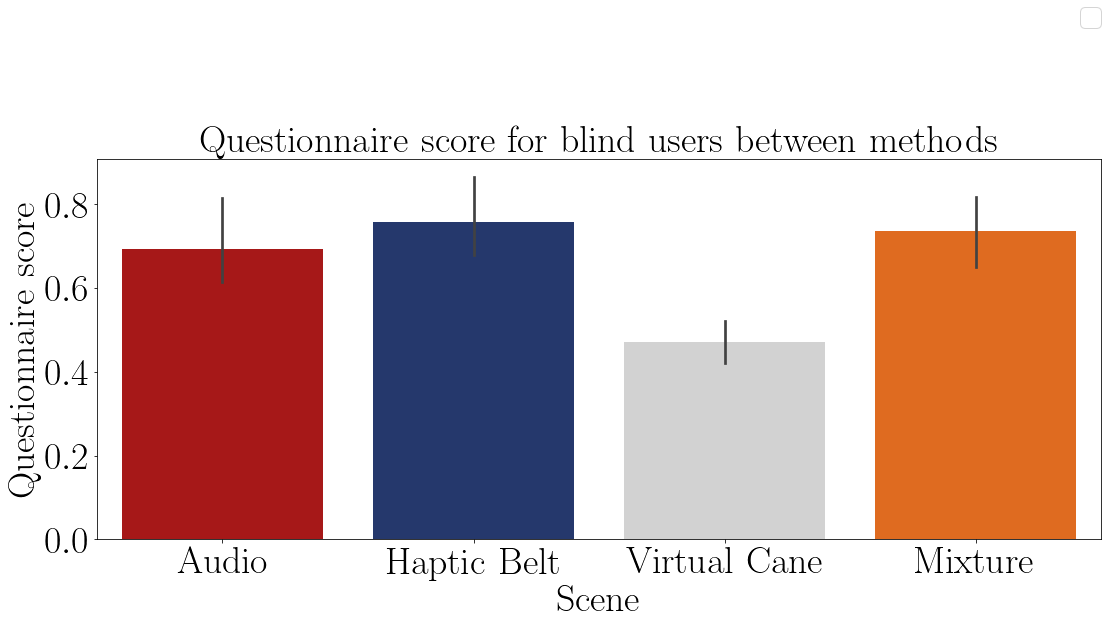

No handles with labels found to put in legend.


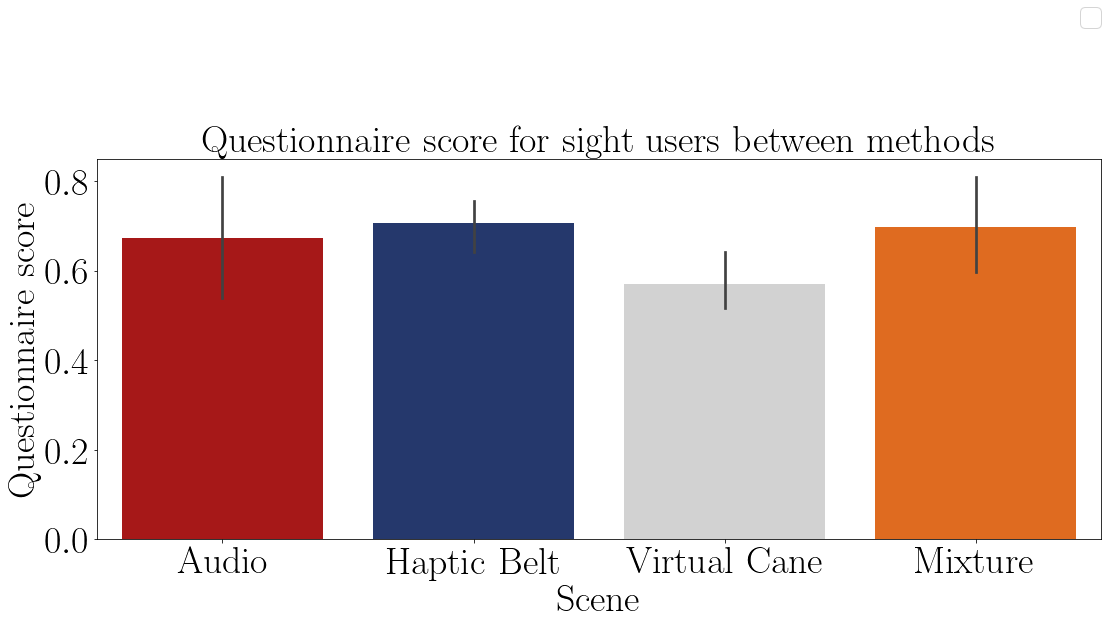

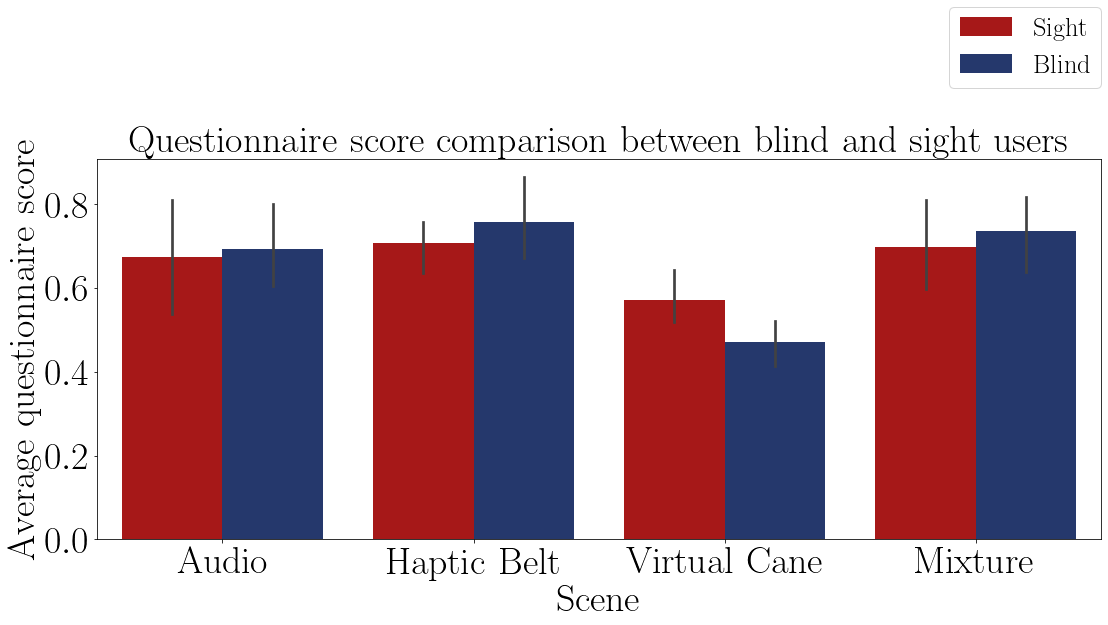

No handles with labels found to put in legend.


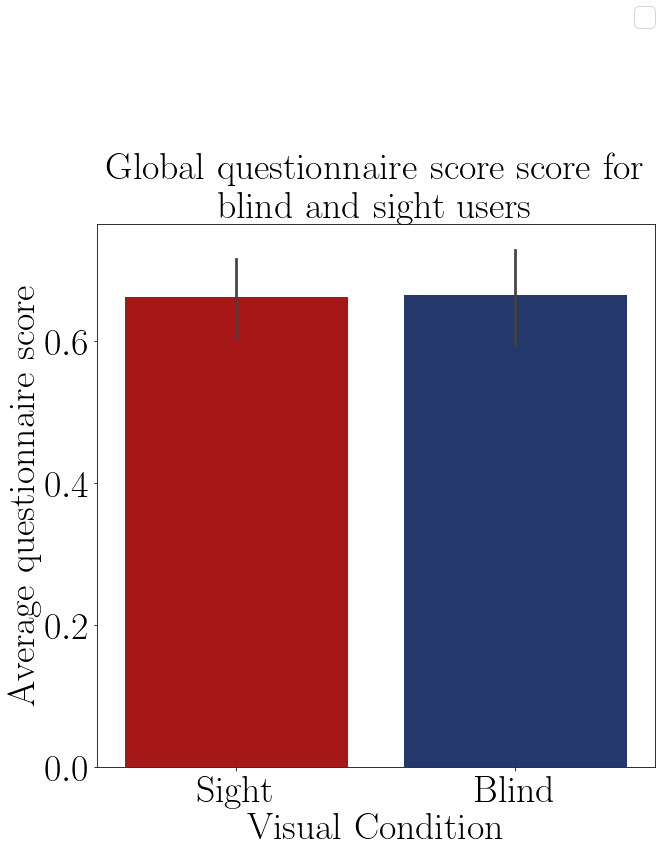

In [ ]:
# Gerar um box plot de todas as médias dos participantes em cada cena
if gerar == True:
    plot = copy.deepcopy(pgQuestionario_media_2)
else:
    plot = copy.deepcopy(pgQuestionario_media)
score = 'questionnaire score'
Score = 'Questionnaire score'
teste = 'Questionario'
label = 'questionnaire'

mdMelt = pd.melt(plot.reset_index(),id_vars = ['Participant','Visual Condition'], var_name = 'Scene', value_name = 'Score',ignore_index=True)
mdMelt.set_index('Participant')

plt.figure(figsize = tamanhoBarra5)
sns.barplot(data = mdMelt[mdMelt['Visual Condition'] == 'Blind'], x = 'Scene', y = 'Score')
plt.title(Score + ' for blind users between methods')
plt.legend(bbox_to_anchor=(1, 1.4), loc='upper right', borderaxespad=0)
plt.ylabel(Score)
plt.savefig(teste + '/Figuras/png/barplot_' + label + '_scene_blind.png',bbox_inches='tight')
plt.savefig(teste + '/Figuras/barplot_' + label + '_scene_blind.pgf',bbox_inches='tight')
plt.show()

plt.figure(figsize = tamanhoBarra5)
sns.barplot(data = mdMelt[mdMelt['Visual Condition'] == 'Sight'], x = 'Scene', y = 'Score')
plt.title(Score + ' for sight users between methods')
plt.legend(bbox_to_anchor=(1, 1.4), loc='upper right', borderaxespad=0)
plt.ylabel(Score)
plt.savefig(teste + '/Figuras/png/barplot_' + label + '_scene_sight.png',bbox_inches='tight')
plt.savefig(teste + '/Figuras/barplot_' + label + '_scene_sight.pgf',bbox_inches='tight')
plt.show()

plt.figure(figsize = tamanhoBarra5)
sns.barplot(data = mdMelt, x = 'Scene', y = 'Score', hue = 'Visual Condition')
plt.title(Score + ' comparison between blind and sight users')
plt.legend(bbox_to_anchor=(1, 1.4), loc='upper right', borderaxespad=0)
plt.ylabel('Average ' + score)
plt.savefig(teste + '/Figuras/png/barplot_' + label + '_scene.png',bbox_inches='tight')
plt.savefig(teste + '/Figuras/barplot_' + label + '_scene.pgf',bbox_inches='tight')
plt.show()

plt.figure(figsize = tamanhoBarra2)
sns.barplot(data = mdMelt, x = 'Visual Condition', y = 'Score')
plt.title('Global ' + score + ' score for \n blind and sight users')
plt.legend(bbox_to_anchor=(1, 1.4), loc='upper right', borderaxespad=0)
plt.ylabel('Average ' + score)
plt.savefig(teste + '/Figuras/png/barplot_' + label + '_global.png',bbox_inches='tight')
plt.savefig(teste + '/Figuras/barplot_' + label + '_global.pgf',bbox_inches='tight')
plt.show()

### Gráfico box plot da variação do ECG

#### Frequência cardiaca

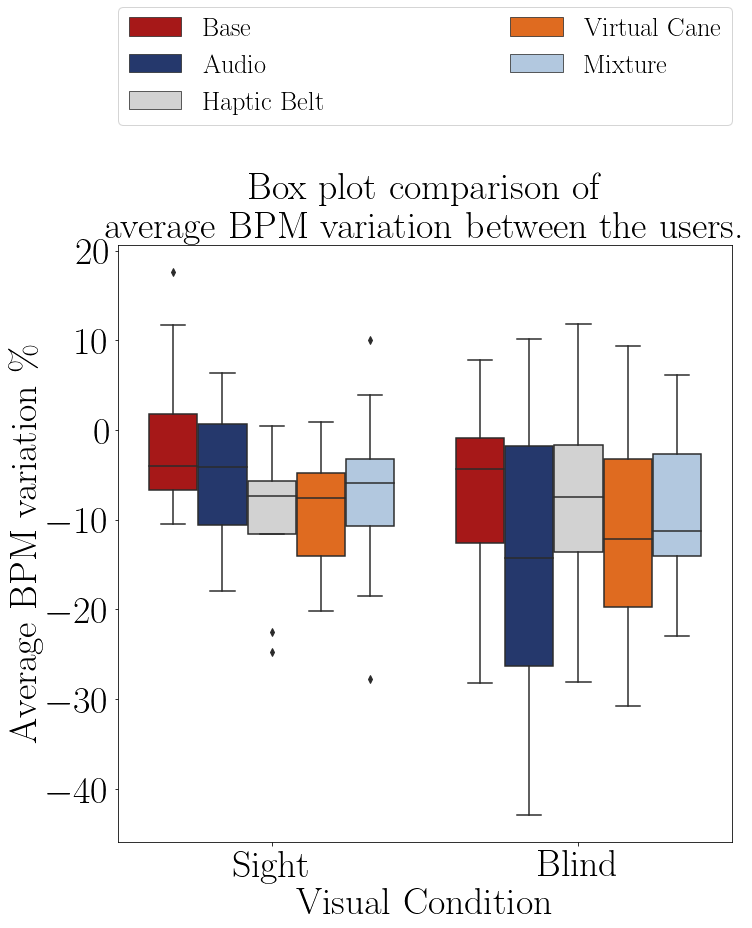

No handles with labels found to put in legend.


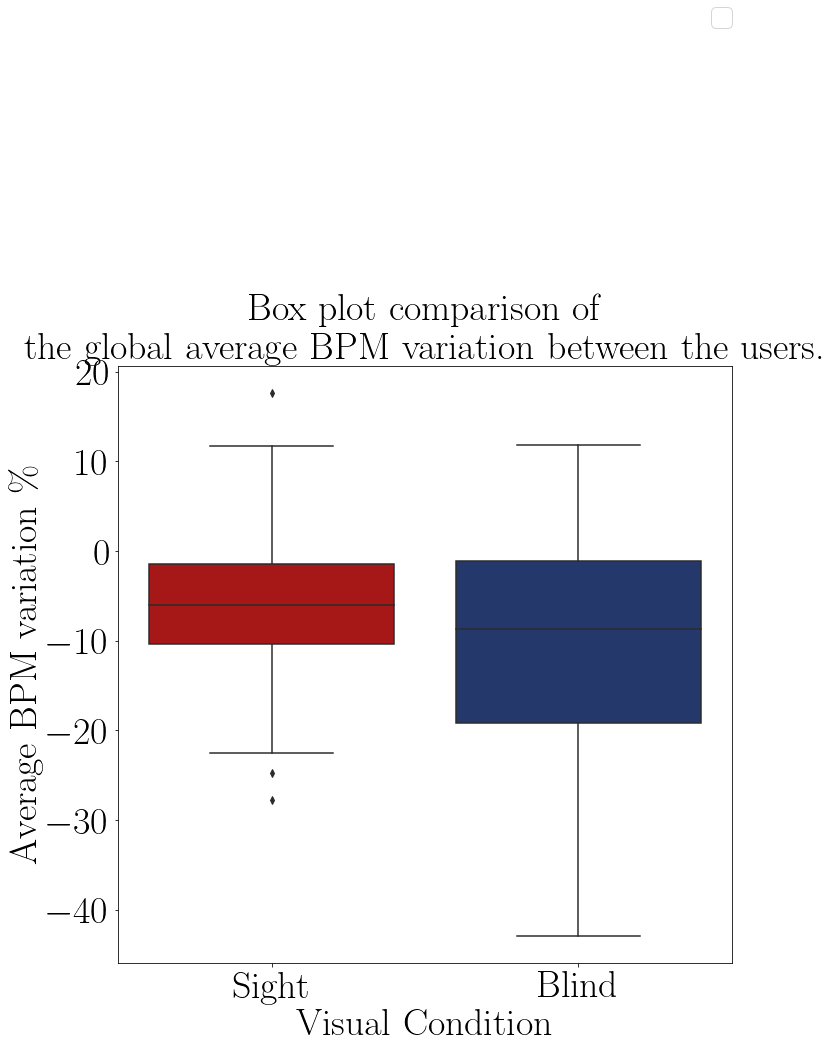

In [ ]:
score = 'average BPM variation'
Score = 'Average BPM variation'
teste = 'ECG'
label = 'ecg_bpm'

tamanhoBox = [11,11]

PlotarGraficosBox(dfECGDadosBPMMedio_var_cen_par,score,Score,teste,label)

#dfECGDadosBPMMedio_var_cen_par
#dfECGDadosSDNN_var_cen_par
#dfECGDadosRMSSD_var_cen_par
#dfECGDadosPNN50_var_cen_par
#dfECGDadosLFHF_var_cen_par



#### Desvio Padrão entre intervalos

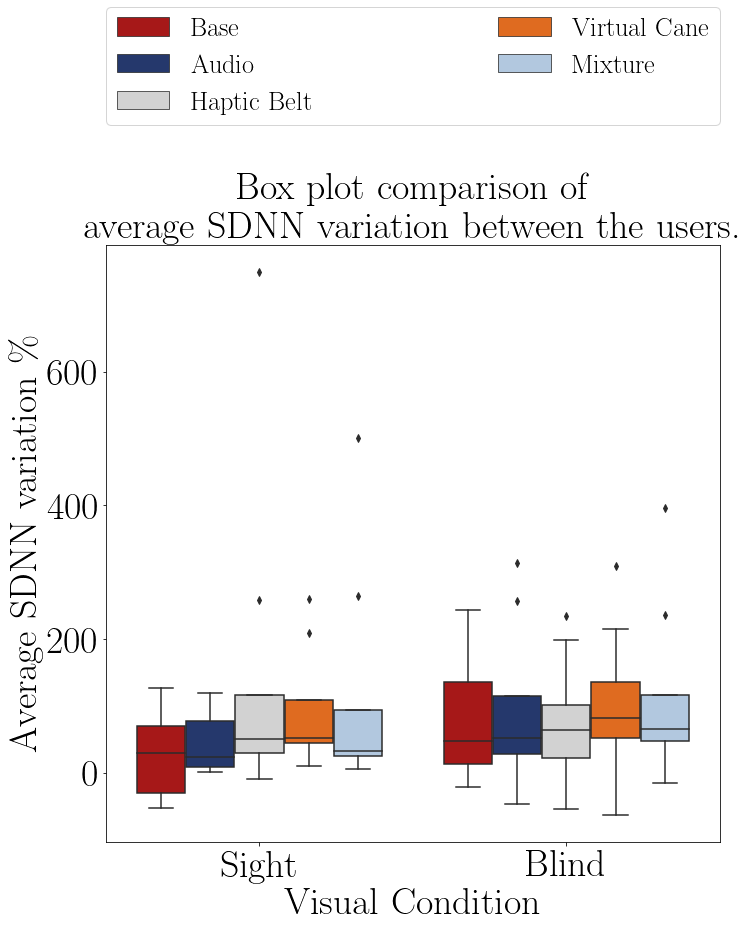

No handles with labels found to put in legend.


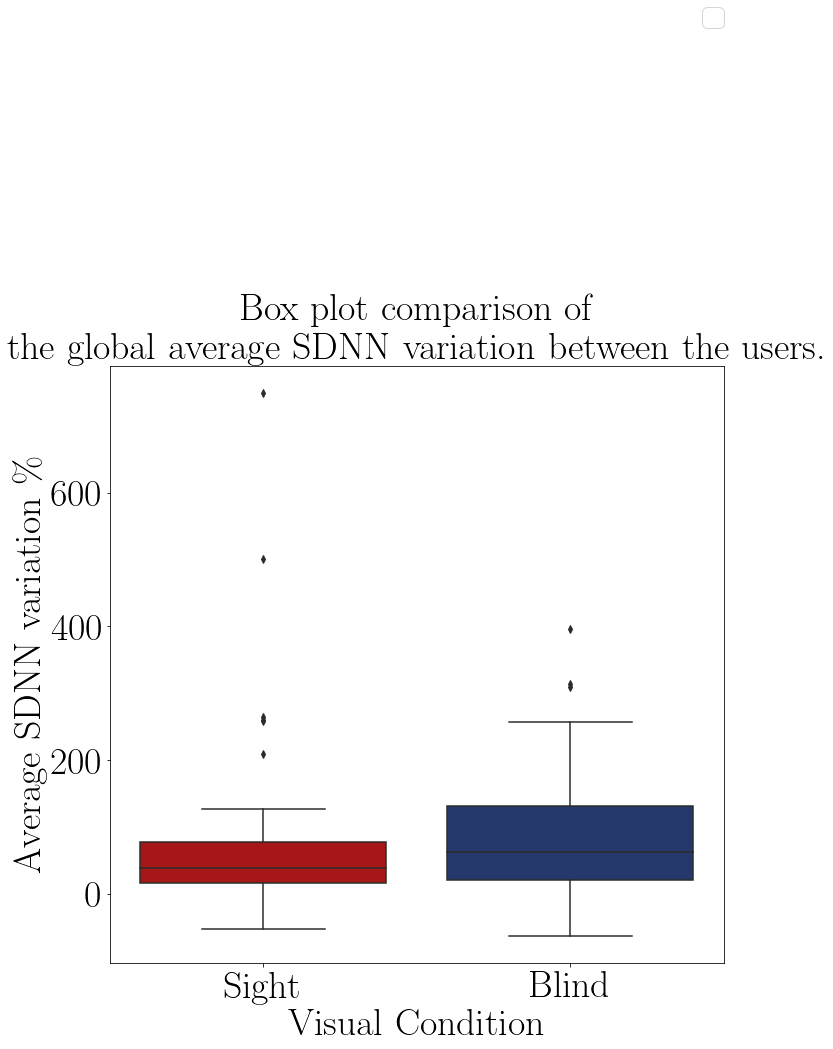

In [ ]:
score = 'average SDNN variation'
Score = 'Average SDNN variation'
teste = 'ECG'
label = 'ecg_sdnn_box'

PlotarGraficosBox(dfECGDadosSDNN_var_cen_par,score,Score,teste,label)

#### Erro quadrático médio

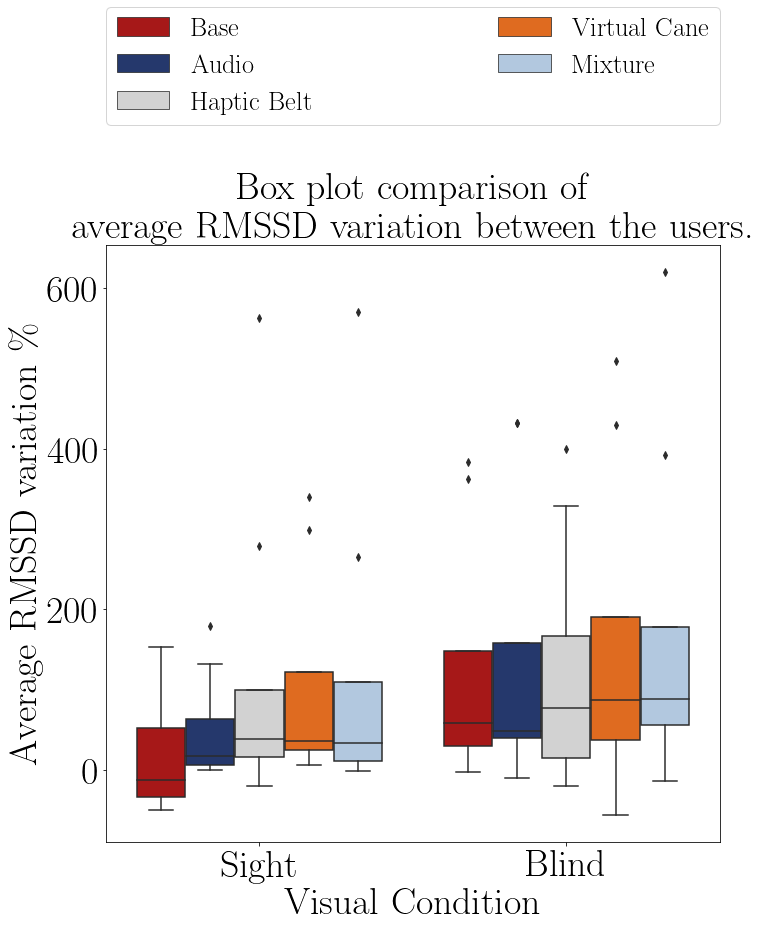

No handles with labels found to put in legend.


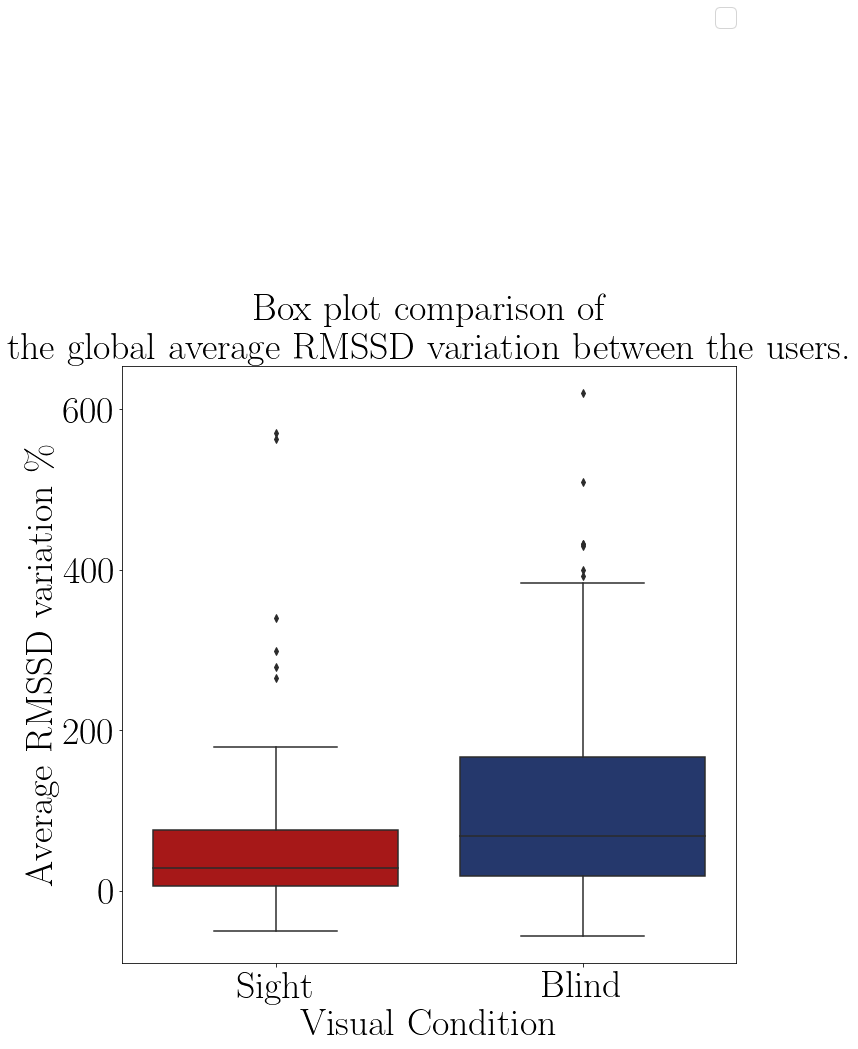

In [ ]:
score = 'average RMSSD variation'
Score = 'Average RMSSD variation'
label = 'ecg_rmssd_box'

PlotarGraficosBox(dfECGDadosRMSSD_var_cen_par,score,Score,teste,label)

#### pNN50

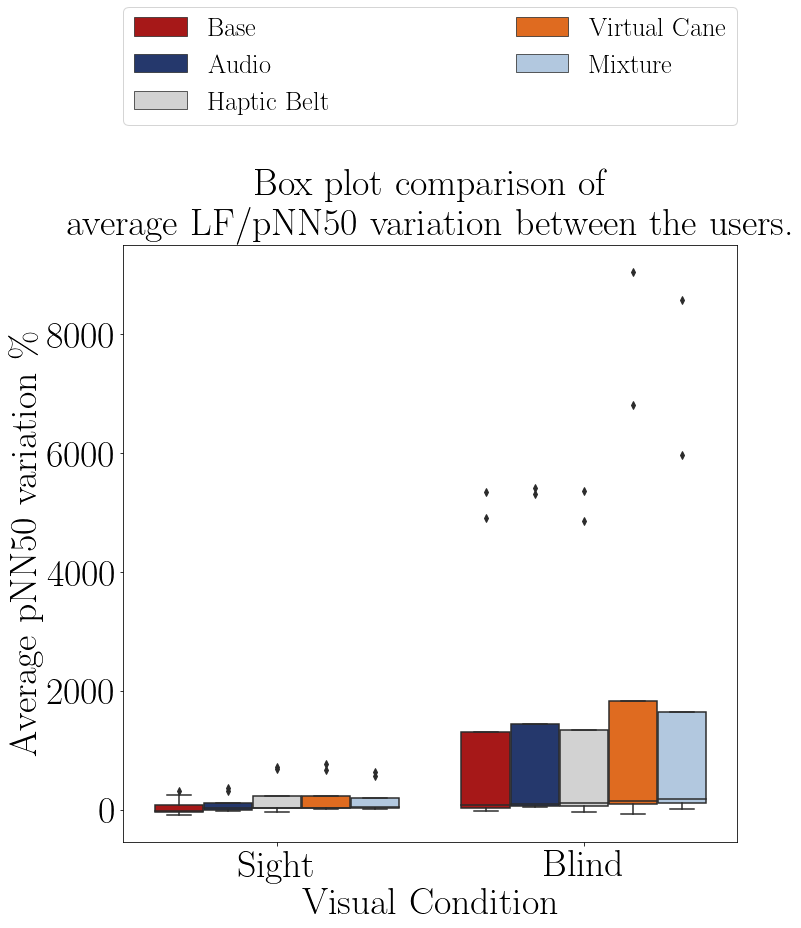

No handles with labels found to put in legend.


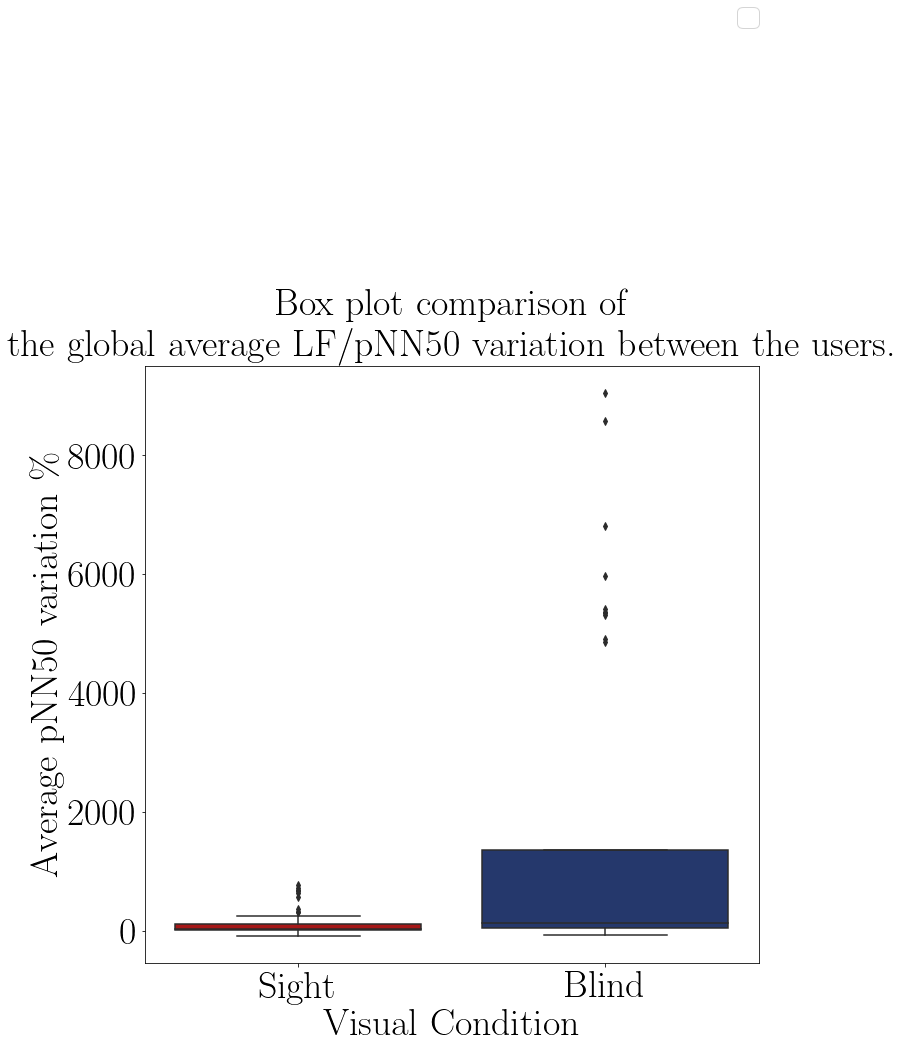

In [ ]:
score = 'average LF/pNN50 variation'
Score = 'Average pNN50 variation'
label = 'ecg_pnn50_box'

PlotarGraficosBox(dfECGDadosPNN50_var_cen_par,score,Score,teste,label)

#### LF/HF

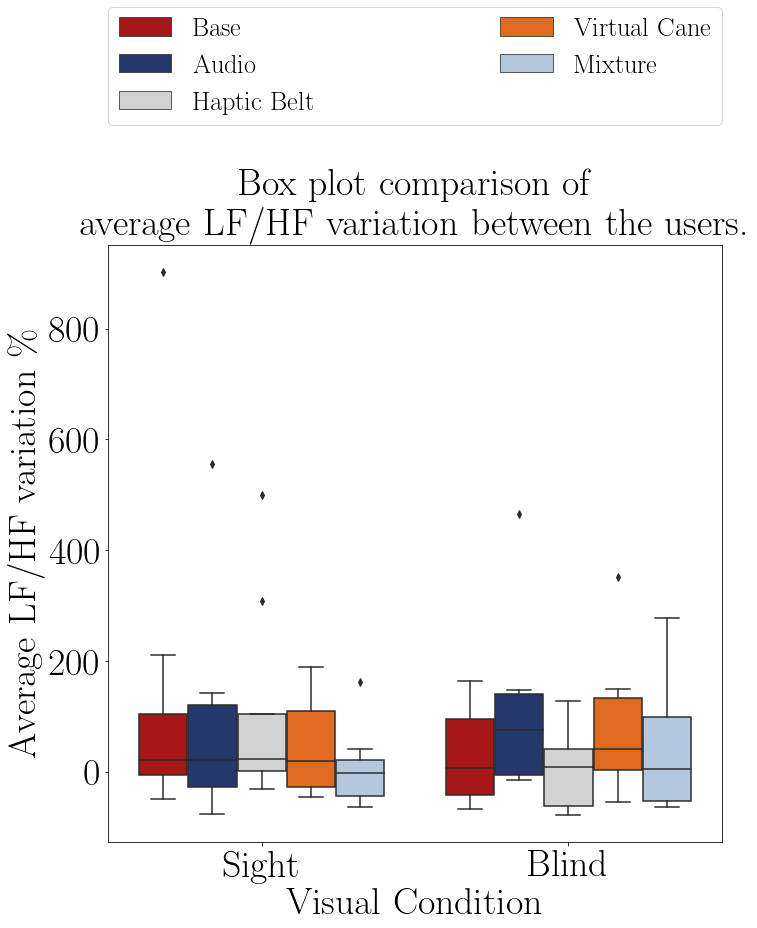

No handles with labels found to put in legend.


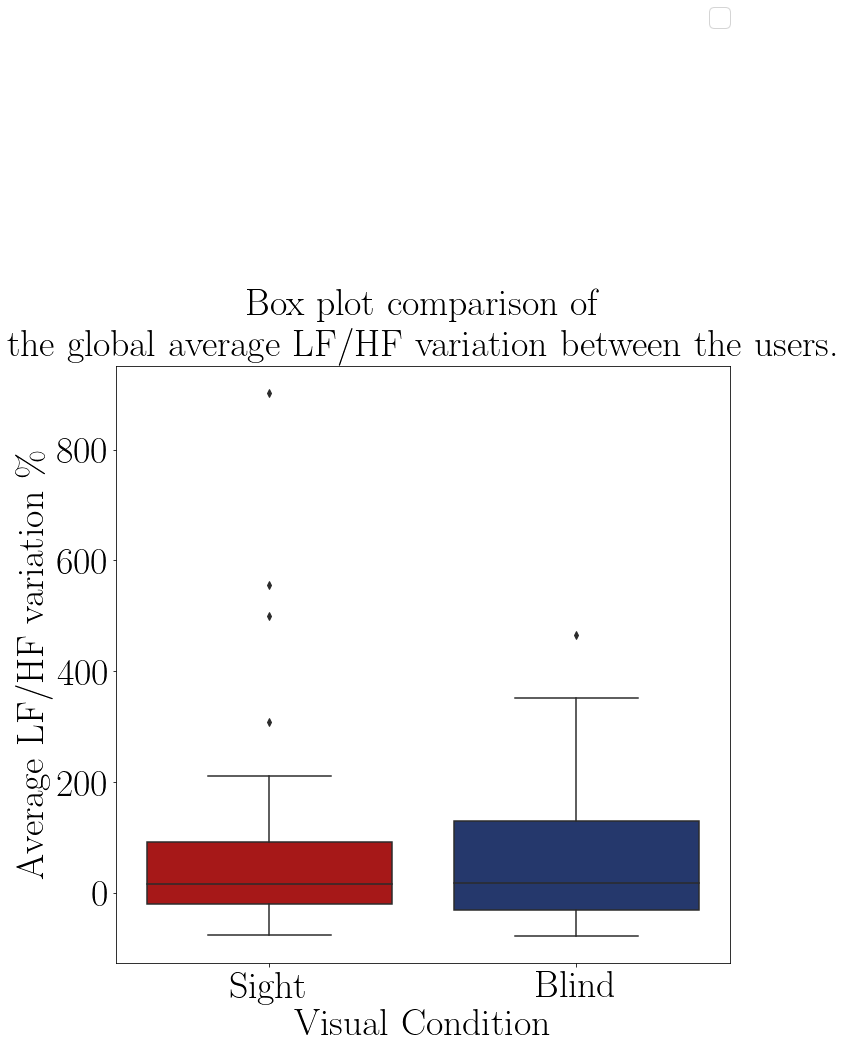

In [ ]:
score = 'average LF/HF variation'
Score = 'Average LF/HF variation'
label = 'ecg_lfhf_box'

PlotarGraficosBox(dfECGDadosLFHF_var_cen_par,score,Score,teste,label)

### Box plot da variação do GSR Médio

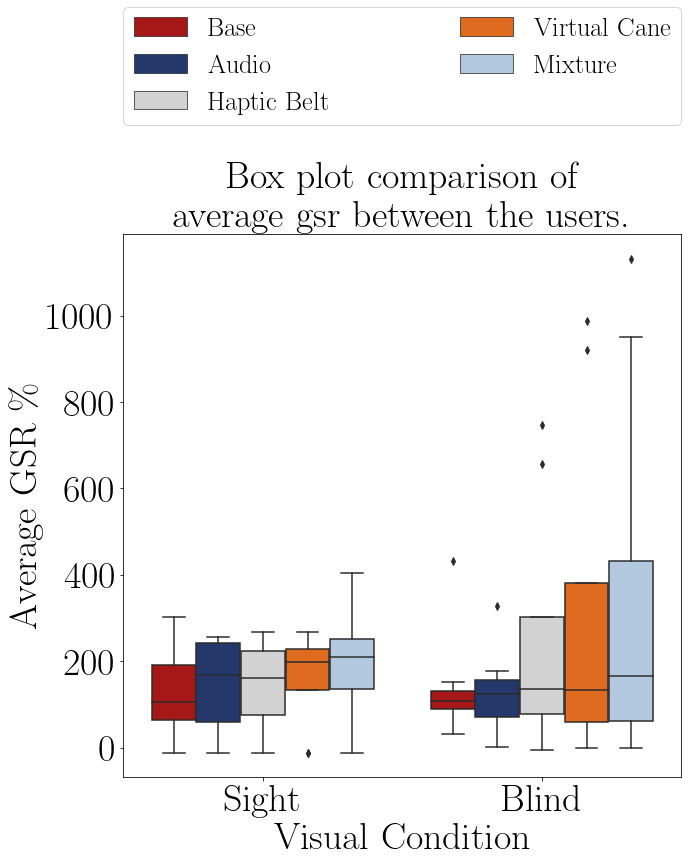

No handles with labels found to put in legend.


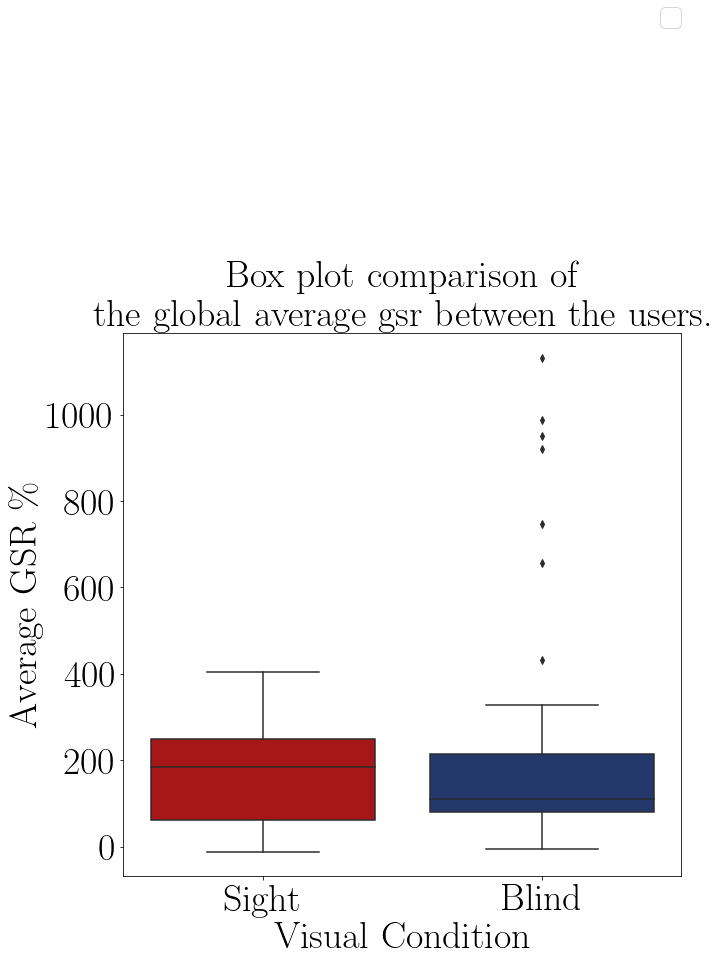

In [ ]:
tamanhoBox = [10,10]

# Gerar um box plot de todas as médias dos participantes em cada cena
if gerar == True:
    plot = copy.deepcopy(dfGSRMedio_var_cen_par_2.reset_index(level = 1))
else:
    plot = copy.deepcopy(dfGSRMedio_var_cen_par.reset_index(level = 1))
score = 'average gsr'
Score = 'Average GSR'
teste = 'GSR'
label = 'gsr'

plot.loc[plot['Visual Condition'] == 0, 'Visual Condition'] = "Sight"
plot.loc[plot['Visual Condition'] == 1, 'Visual Condition'] = "Blind"

mdMelt = pd.melt(plot.reset_index(),id_vars = ['Participant','Round','Visual Condition'], var_name = 'Scene', value_name = 'Score',ignore_index=True)
mdMelt.set_index('Participant')

plt.figure(figsize = tamanhoBox)
sns.boxplot(data = mdMelt, x = 'Visual Condition', y = 'Score', hue = "Scene")
plt.title('Box plot comparison of \n' + score + ' between the users.')
#plt.legend(bbox_to_anchor=(1, 1.6), loc='upper right', borderaxespad=0)
plt.legend(bbox_to_anchor=(0., 1.20, 1., .102), loc='lower left', ncol=2, mode="expand", borderaxespad=0.)
plt.ylabel(Score + ' \%')
plt.savefig(teste + '/Figuras/png/boxplot_' + label + '_scene.png',bbox_inches='tight')
plt.savefig(teste + '/Figuras/boxplot_' + label + '_scene.pgf',bbox_inches='tight')
plt.show()

plot.loc[plot['Visual Condition'] == 0, 'Visual Condition'] = "Sight"
plot.loc[plot['Visual Condition'] == 1, 'Visual Condition'] = "Blind"

mdMelt = pd.melt(plot,id_vars = 'Visual Condition', var_name = 'Scene', value_name = 'Average')

plt.figure(figsize = tamanhoBox)
sns.boxplot(data = mdMelt, x = 'Visual Condition', y = 'Average')
plt.title('Box plot comparison of \n the global ' + score + ' between the users.')
plt.legend(bbox_to_anchor=(1, 1.6), loc='upper right', borderaxespad=0)
plt.ylabel(Score + ' \%')
plt.savefig(teste + '/Figuras/png/boxplot_' + label + '_global.png',bbox_inches='tight')
plt.savefig(teste + '/Figuras/boxplot_' + label + '_global.pgf',bbox_inches='tight')
plt.show()

### Box plot da média da demanda mental

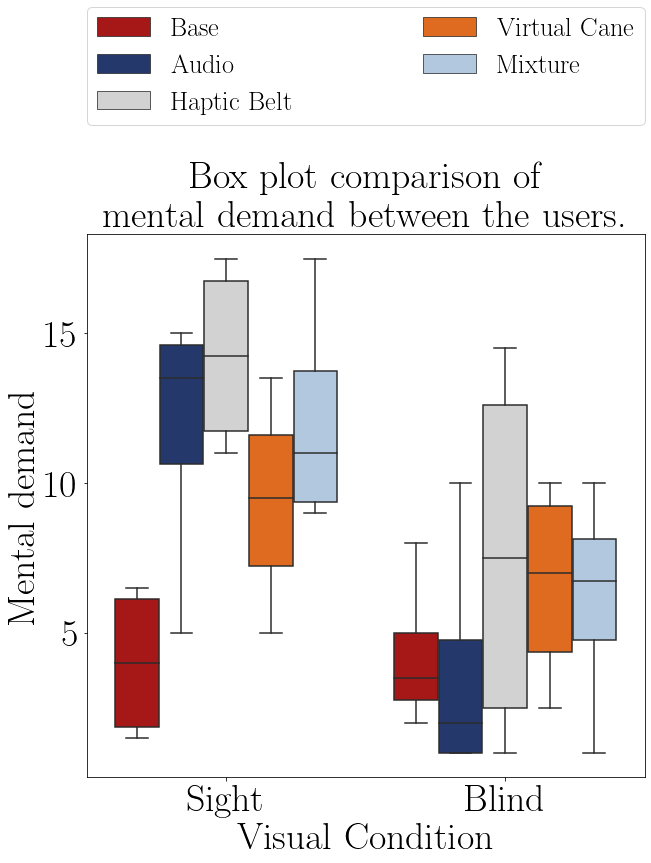

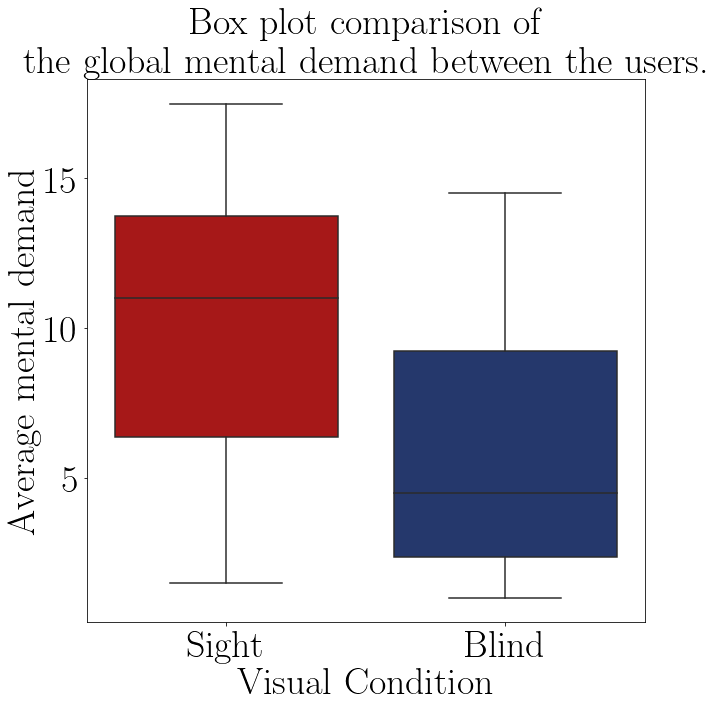

In [ ]:
# Gerar um box plot de todas as médias dos participantes em cada cena
if gerar == True:
    plot = copy.deepcopy(mdNasa_media_cen_par_2)
else:
    plot = copy.deepcopy(mdNasa_media_cen_par)
score = 'mental demand'
Score = 'Mental demand'
teste = 'Nasa'
label = 'md_avg'

plot.loc[plot['Visual Condition'] == 0, 'Visual Condition'] = "Sight"
plot.loc[plot['Visual Condition'] == 1, 'Visual Condition'] = "Blind"

mdMelt = pd.melt(plot,id_vars = 'Visual Condition', var_name = 'Scene', value_name = 'Average')

plt.figure(figsize = tamanhoBox)
sns.boxplot(data = mdMelt, x = 'Visual Condition', y = 'Average', hue = "Scene")
plt.title('Box plot comparison of \n' + score + ' between the users.')
plt.legend(bbox_to_anchor=(0., 1.20, 1., .102), loc='lower left', ncol=2, mode="expand", borderaxespad=0.)
plt.ylabel(Score)
plt.savefig(teste + '/Figuras/png/boxplot_' + label + '_scene.png',bbox_inches='tight')
plt.savefig(teste + '/Figuras/boxplot_' + label + '_scene.pgf',bbox_inches='tight')
plt.show()

plot.loc[plot['Visual Condition'] == 0, 'Visual Condition'] = "Sight"
plot.loc[plot['Visual Condition'] == 1, 'Visual Condition'] = "Blind"

mdMelt = pd.melt(plot,id_vars = 'Visual Condition', var_name = 'Scene', value_name = 'Average')

plt.figure(figsize = tamanhoBox)
sns.boxplot(data = mdMelt, x = 'Visual Condition', y = 'Average')
plt.title('Box plot comparison of \n the global ' + score + ' between the users.')
#plt.legend(loc='upper right', bbox_to_anchor=(1.35, 1.45), borderaxespad=0)
plt.ylabel('Average ' + score)
plt.savefig(teste + '/Figuras/png/boxplot_' + label + '.png',bbox_inches='tight')
plt.savefig(teste + '/Figuras/boxplot_' + label + '.pgf',bbox_inches='tight')
plt.show()

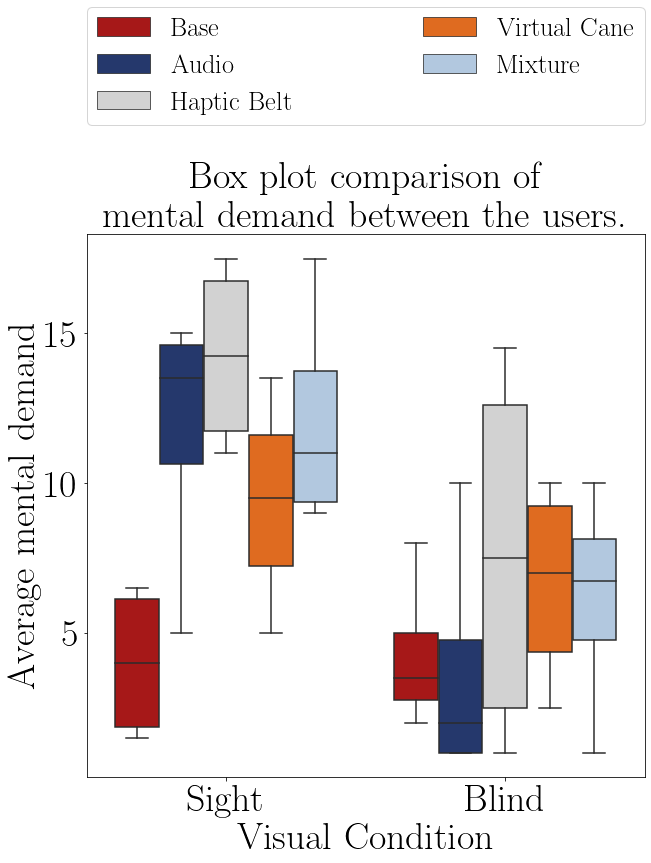

No handles with labels found to put in legend.


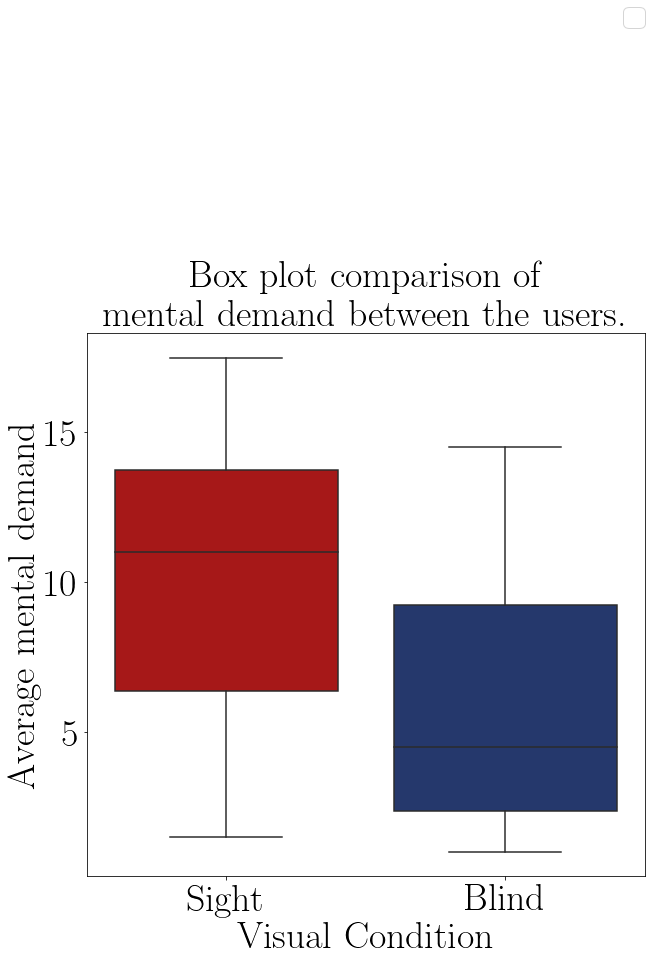

In [ ]:
# Gerar um box plot de todas as médias dos participantes em cada cena
if gerar == True:
    plot = copy.deepcopy(mdNasa_media_cen_par_2)
else:
    plot = copy.deepcopy(mdNasa_media_cen_par)
score = 'mental demand'
Score = 'Mental demand'
teste = 'Nasa'
label = 'md_avg'

plot.loc[plot['Visual Condition'] == 0, 'Visual Condition'] = "Sight"
plot.loc[plot['Visual Condition'] == 1, 'Visual Condition'] = "Blind"

mdMelt = pd.melt(plot,id_vars = 'Visual Condition', var_name = 'Scene', value_name = 'Average')

plt.figure(figsize = tamanhoBox)
sns.boxplot(data = mdMelt, x = 'Visual Condition', y = 'Average', hue = "Scene")
plt.title('Box plot comparison of \n' + score + ' between the users.')
plt.legend(bbox_to_anchor=(0., 1.20, 1., .102), loc='lower left', ncol=2, mode="expand", borderaxespad=0.)
plt.ylabel('Average ' + score)
plt.savefig(teste + '/Figuras/png/boxplot_' + label + '_scene.png',bbox_inches='tight')
plt.savefig(teste + '/Figuras/boxplot_' + label + '_scene.pgf',bbox_inches='tight')
plt.show()

plot.loc[plot['Visual Condition'] == 0, 'Visual Condition'] = "Sight"
plot.loc[plot['Visual Condition'] == 1, 'Visual Condition'] = "Blind"

mdMelt = pd.melt(plot,id_vars = 'Visual Condition', var_name = 'Scene', value_name = 'Average')

plt.figure(figsize = tamanhoBox)
sns.boxplot(data = mdMelt, x = 'Visual Condition', y = 'Average')
plt.title('Box plot comparison of \n' + score + ' between the users.')
plt.legend(bbox_to_anchor=(1, 1.6), loc='upper right', borderaxespad=0)
plt.ylabel('Average ' + score)
plt.savefig(teste + '/Figuras/png/boxplot_' + label + '.png',bbox_inches='tight')
plt.savefig(teste + '/Figuras/boxplot_' + label + '.pgf',bbox_inches='tight')
plt.show()

### Box plot da média da Carga Mental

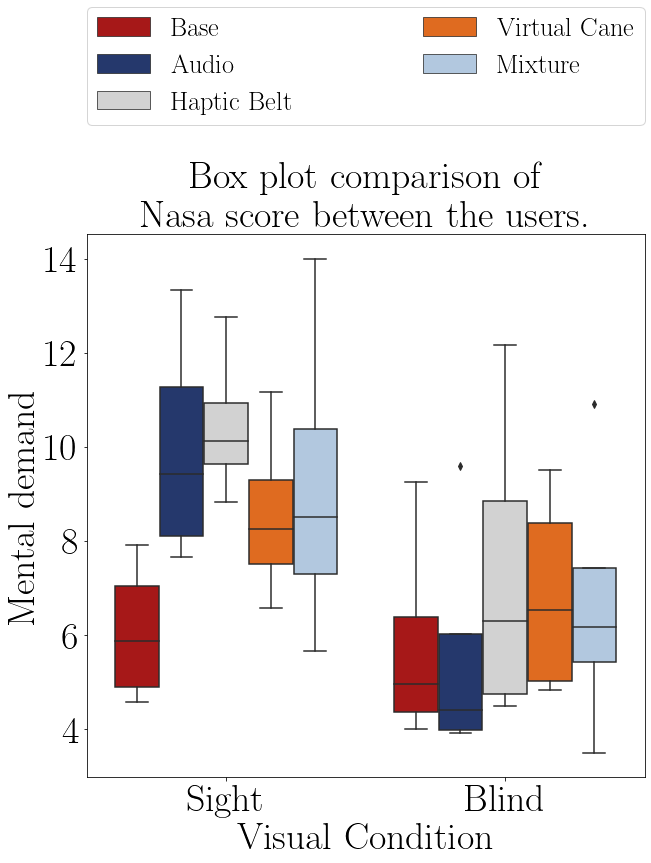

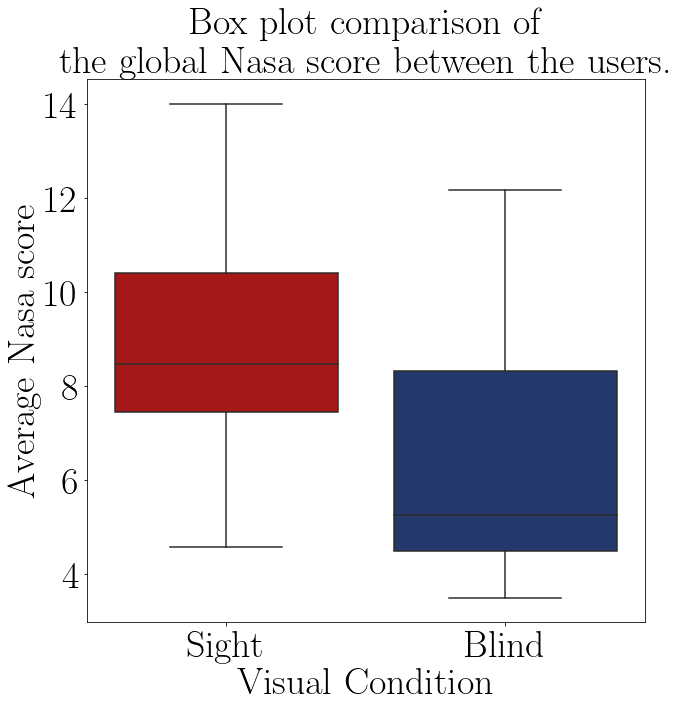

In [ ]:
# Gerar um box plot de todas as médias dos participantes em cada cena
if gerar == True:
    plot = copy.deepcopy(cmNasa_media_cen_par_2)
else:
    plot = copy.deepcopy(cmNasa_media_cen_par)

score = 'nasa score'
score = 'Nasa score'
teste = 'Nasa'
label = 'nasa_avg'

plot.loc[plot['Visual Condition'] == 0, 'Visual Condition'] = "Sight"
plot.loc[plot['Visual Condition'] == 1, 'Visual Condition'] = "Blind"

mdMelt = pd.melt(plot,id_vars = 'Visual Condition', var_name = 'Scene', value_name = 'Average')

plt.figure(figsize = tamanhoBox)
sns.boxplot(data = mdMelt, x = 'Visual Condition', y = 'Average', hue = "Scene")
plt.title('Box plot comparison of \n' + score + ' between the users.')
#plt.legend(mode = 'expand') #, loc='upper right', bbox_to_anchor=(1.35, 1.45), borderaxespad=0)
plt.legend(bbox_to_anchor=(0., 1.20, 1., .102), loc='lower left', ncol=2, mode="expand", borderaxespad=0.)
plt.ylabel(Score)
plt.savefig(teste + '/Figuras/png/boxplot_' + label + '_scene.png',bbox_inches='tight')
plt.savefig(teste + '/Figuras/boxplot_' + label + '_scene.pgf',bbox_inches='tight')
plt.show()

plot.loc[plot['Visual Condition'] == 0, 'Visual Condition'] = "Sight"
plot.loc[plot['Visual Condition'] == 1, 'Visual Condition'] = "Blind"

mdMelt = pd.melt(plot,id_vars = 'Visual Condition', var_name = 'Scene', value_name = 'Average')

plt.figure(figsize = tamanhoBox)
sns.boxplot(data = mdMelt, x = 'Visual Condition', y = 'Average')
plt.title('Box plot comparison of \n the global ' + score + ' between the users.')
#plt.legend(loc='upper right', bbox_to_anchor=(1.35, 1.45), borderaxespad=0)
plt.ylabel('Average ' + score)
plt.savefig(teste + '/Figuras/png/boxplot_' + label + '.png',bbox_inches='tight')
plt.savefig(teste + '/Figuras/boxplot_' + label + '.pgf',bbox_inches='tight')
plt.show()

### Box plot da média do SAGAT

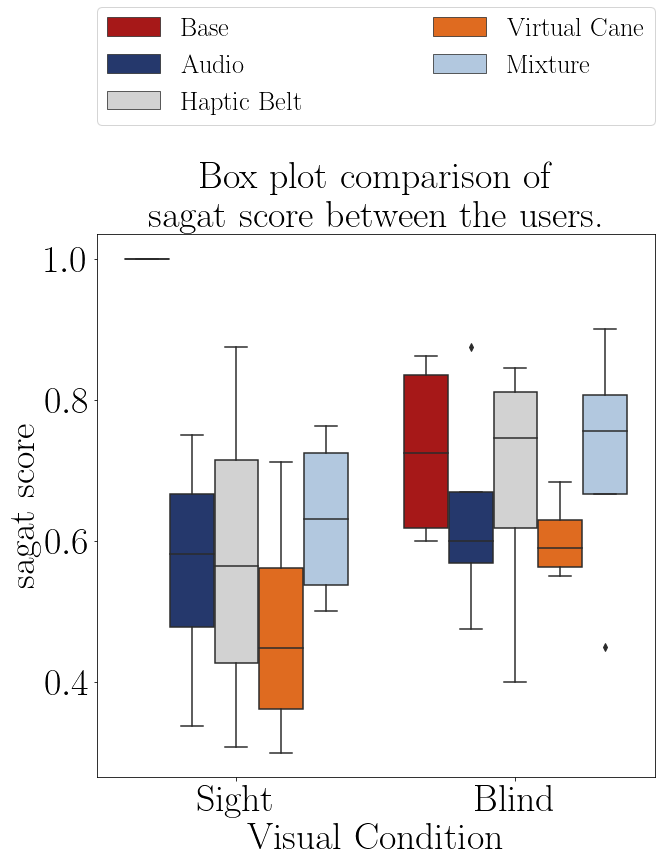

No handles with labels found to put in legend.


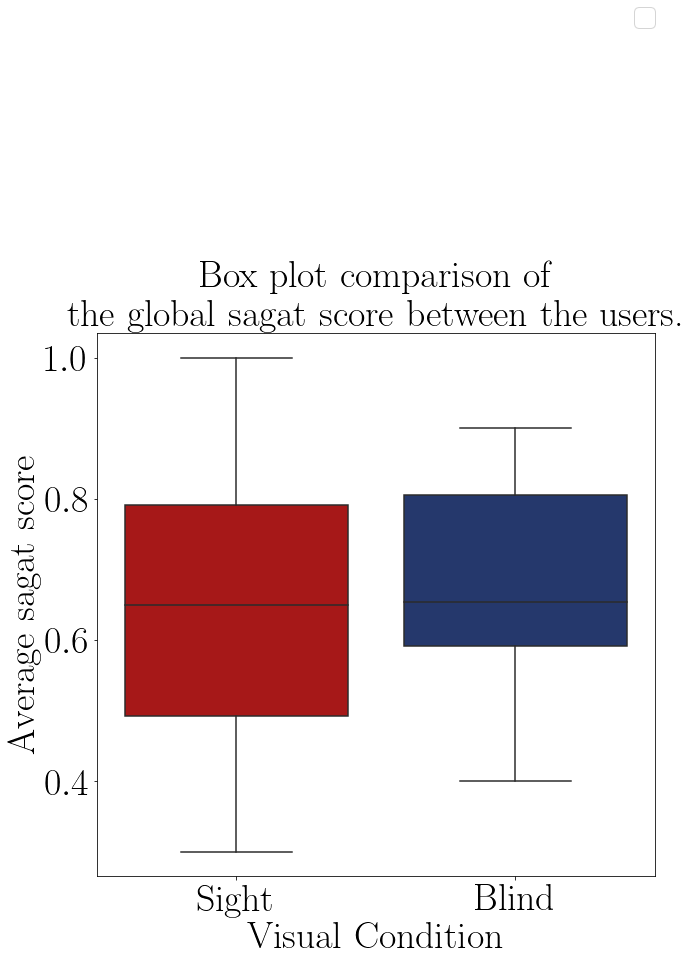

In [ ]:
# Gerar um box plot de todas as médias dos participantes em cada cena
if gerar == True:
    plot = copy.deepcopy(saSagat_media_cen_par_2)
else:
    plot = copy.deepcopy(saSagat_media_cen_par)

score = 'sagat score'
Score = 'sagat score'
teste = 'SAGAT'
label = 'sagat'

plot.loc[plot['Visual Condition'] == 0, 'Visual Condition'] = "Sight"
plot.loc[plot['Visual Condition'] == 1, 'Visual Condition'] = "Blind"

mdMelt = pd.melt(plot,id_vars = 'Visual Condition', var_name = 'Scene', value_name = 'Average')

plt.figure(figsize = tamanhoBox)
sns.boxplot(data = mdMelt, x = 'Visual Condition', y = 'Average', hue = "Scene")
plt.title('Box plot comparison of \n' + score + ' between the users.')
#plt.legend(bbox_to_anchor=(1, 1.6), loc='upper right', borderaxespad=0)
plt.legend(bbox_to_anchor=(0., 1.20, 1., .102), loc='lower left', ncol=2, mode="expand", borderaxespad=0.)
plt.ylabel(Score)
plt.savefig(teste + '/Figuras/png/boxplot_' + label + '_scene.png',bbox_inches='tight')
plt.savefig(teste + '/Figuras/boxplot_' + label + '_scene.pgf',bbox_inches='tight')
plt.show()

plot.loc[plot['Visual Condition'] == 0, 'Visual Condition'] = "Sight"
plot.loc[plot['Visual Condition'] == 1, 'Visual Condition'] = "Blind"

mdMelt = pd.melt(plot,id_vars = 'Visual Condition', var_name = 'Scene', value_name = 'Average')

plt.figure(figsize = tamanhoBox)
sns.boxplot(data = mdMelt, x = 'Visual Condition', y = 'Average')
plt.title('Box plot comparison of \n the global ' + score + ' between the users.')
plt.legend(bbox_to_anchor=(1, 1.6), loc='upper right', borderaxespad=0)
plt.ylabel('Average ' + score)
plt.savefig(teste + '/Figuras/png/boxplot_' + label + '.png',bbox_inches='tight')
plt.savefig(teste + '/Figuras/boxplot_' + label + '.pgf',bbox_inches='tight')
plt.show()

### Box plot da média do tempo

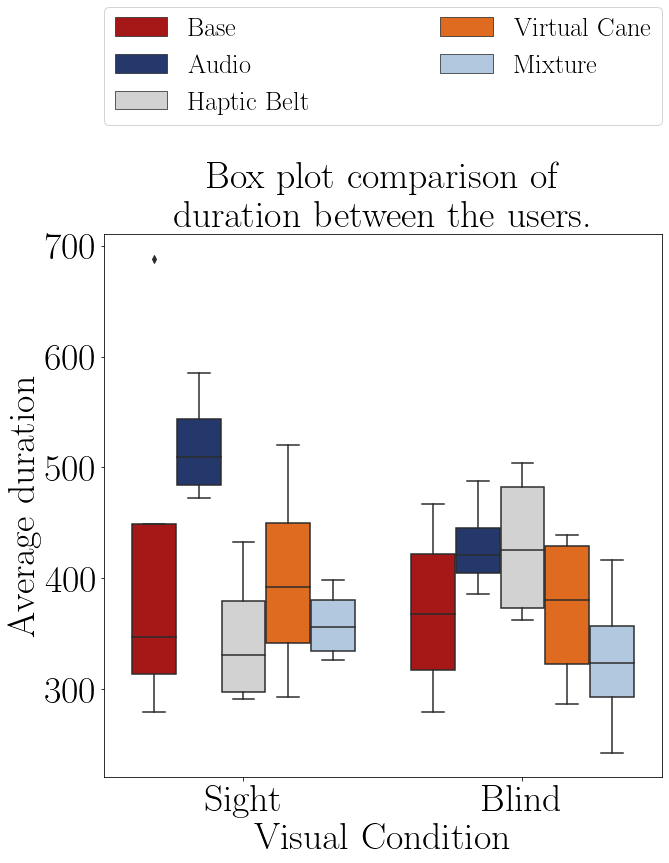

No handles with labels found to put in legend.


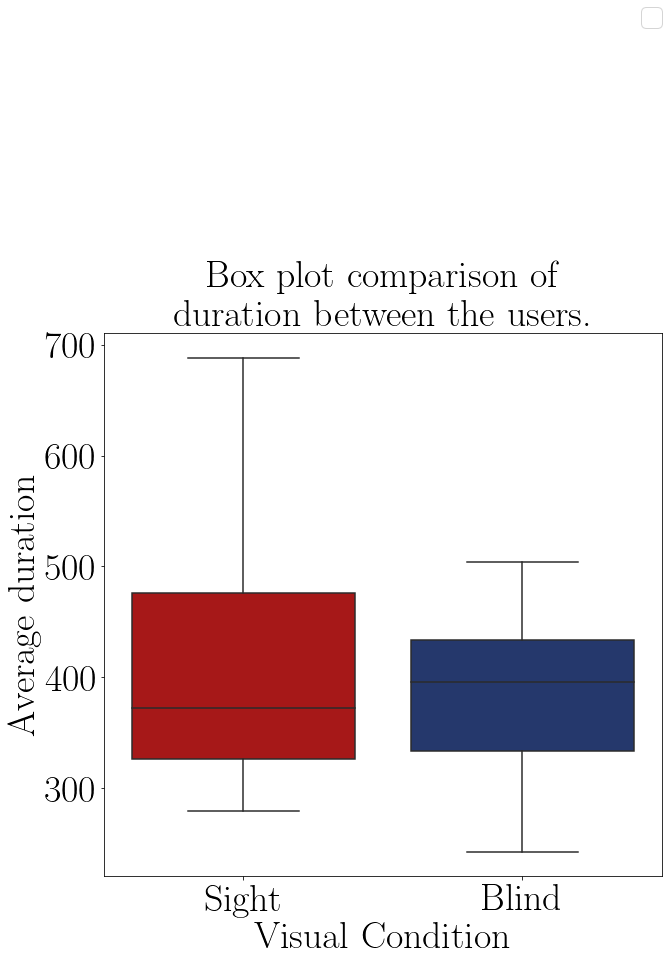

In [ ]:
# Gerar um box plot de todas as médias dos participantes em cada cena
if gerar == True:
    plot = copy.deepcopy(duracao_media_cen_par_2)
else:
    plot = copy.deepcopy(duracao_media_cen_par)

score = 'duration'
Score = 'Duration'
teste = 'Tempo'
label = 'duration'

plot.loc[plot['Visual Condition'] == 0, 'Visual Condition'] = "Sight"
plot.loc[plot['Visual Condition'] == 1, 'Visual Condition'] = "Blind"

mdMelt = pd.melt(plot,id_vars = 'Visual Condition', var_name = 'Scene', value_name = 'Average')

plt.figure(figsize = tamanhoBox)
sns.boxplot(data = mdMelt, x = 'Visual Condition', y = 'Average', hue = "Scene")
plt.title('Box plot comparison of \n' + score + ' between the users.')
plt.legend(bbox_to_anchor=(0., 1.20, 1., .102), loc='lower left', ncol=2, mode="expand", borderaxespad=0.)
plt.ylabel('Average ' + score)
plt.savefig(teste + '/Figuras/png/boxplot_' + label + '_scene.png',bbox_inches='tight')
plt.savefig(teste + '/Figuras/boxplot_' + label + '_scene.pgf',bbox_inches='tight')
plt.show()

plot.loc[plot['Visual Condition'] == 0, 'Visual Condition'] = "Sight"
plot.loc[plot['Visual Condition'] == 1, 'Visual Condition'] = "Blind"

mdMelt = pd.melt(plot,id_vars = 'Visual Condition', var_name = 'Scene', value_name = 'Average')

plt.figure(figsize = tamanhoBox)
sns.boxplot(data = mdMelt, x = 'Visual Condition', y = 'Average')
plt.title('Box plot comparison of \n' + score + ' between the users.')
plt.legend(bbox_to_anchor=(1, 1.6), loc='upper right', borderaxespad=0)
plt.ylabel('Average ' + score)
plt.savefig(teste + '/Figuras/png/boxplot_' + label + '.png',bbox_inches='tight')
plt.savefig(teste + '/Figuras/boxplot_' + label + '.pgf',bbox_inches='tight')
plt.show()

### Box plot da média dos Questionario

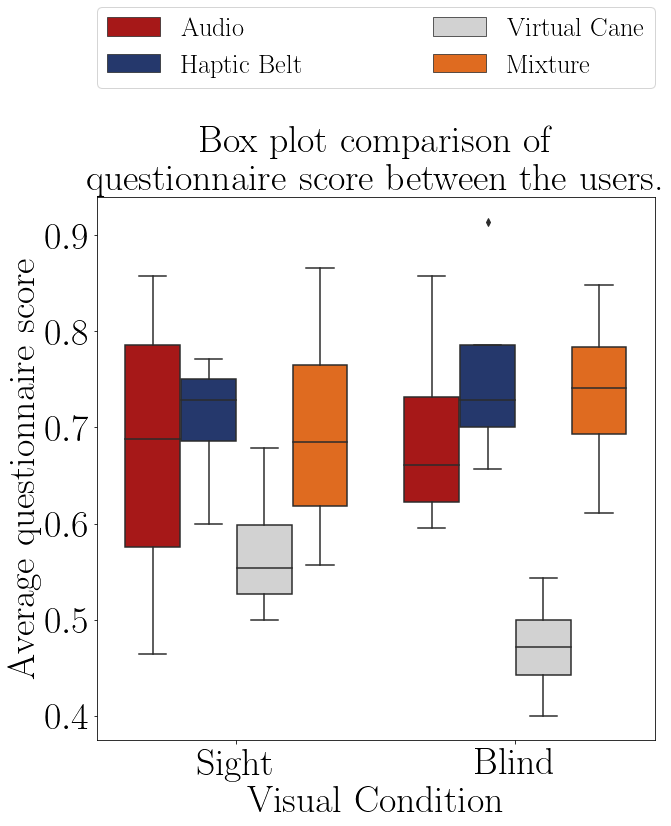

No handles with labels found to put in legend.


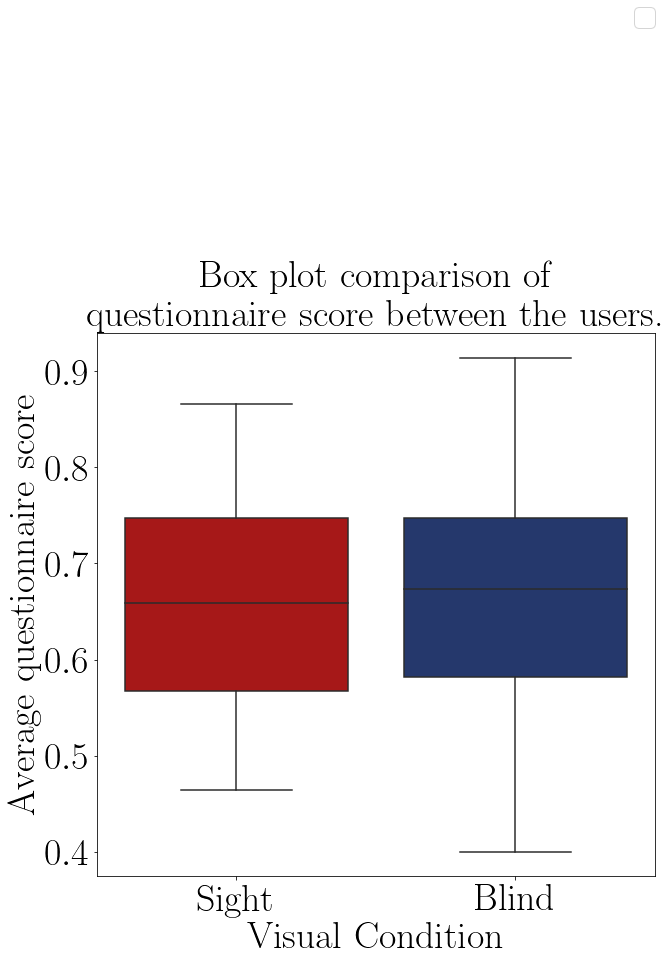

In [ ]:
# Gerar um box plot de todas as médias dos participantes em cada cena
if gerar == True:
    plot = copy.deepcopy(pgQuestionario_media_2)
else:
    plot = copy.deepcopy(pgQuestionario_media)

score = 'questionnaire score'
Score = 'Questionnaire score'
teste = 'Questionario'
label = 'questionnaire'

plot.loc[plot['Visual Condition'] == 0, 'Visual Condition'] = "Sight"
plot.loc[plot['Visual Condition'] == 1, 'Visual Condition'] = "Blind"

mdMelt = pd.melt(plot,id_vars = 'Visual Condition', var_name = 'Scene', value_name = 'Average')

plt.figure(figsize = tamanhoBox)
sns.boxplot(data = mdMelt, x = 'Visual Condition', y = 'Average', hue = "Scene")
plt.title('Box plot comparison of \n' + score + ' between the users.')
#plt.legend(bbox_to_anchor=(1, 1.6), loc='upper right', borderaxespad=0)
plt.legend(bbox_to_anchor=(0., 1.20, 1., .102), loc='lower left', ncol=2, mode="expand", borderaxespad=0.)
plt.ylabel('Average ' + score)
plt.savefig(teste + '/Figuras/png/boxplot_' + label + '_scene.png',bbox_inches='tight')
plt.savefig(teste + '/Figuras/boxplot_' + label + '_scene.pgf',bbox_inches='tight')
plt.show()

plot.loc[plot['Visual Condition'] == 0, 'Visual Condition'] = "Sight"
plot.loc[plot['Visual Condition'] == 1, 'Visual Condition'] = "Blind"

mdMelt = pd.melt(plot,id_vars = 'Visual Condition', var_name = 'Scene', value_name = 'Average')

plt.figure(figsize = tamanhoBox)
sns.boxplot(data = mdMelt, x = 'Visual Condition', y = 'Average')
plt.title('Box plot comparison of \n' + score + ' between the users.')
plt.legend(bbox_to_anchor=(1, 1.6), loc='upper right', borderaxespad=0)
plt.ylabel('Average ' + score)
plt.savefig(teste + '/Figuras/png/boxplot_' + label + '.png',bbox_inches='tight')
plt.savefig(teste + '/Figuras/boxplot_' + label + '.pgf',bbox_inches='tight')
plt.show()
